In [1]:
!pip install quandl
!pip install pmdarima
import quandl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import math
from sklearn.preprocessing import MinMaxScaler
from keras.layers import SimpleRNN
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
quandl.ApiConfig.api_key = 'GFC1VTVV3SXKRmR9w-mr'
output = quandl.get("EIA/PET_RWTC_D")

In [21]:
output.to_csv('WTICrudeOilPrice.csv')


In [3]:
df = pd.read_csv('WTICrudeOilPrice.csv')

# EDA

In [4]:
df

Date  Value
0     1986-01-02  25.56
1     1986-01-03  26.00
2     1986-01-06  26.53
3     1986-01-07  25.85
4     1986-01-08  25.87
...          ...    ...
9119  2022-02-02  88.16
9120  2022-02-03  90.17
9121  2022-02-04  92.27
9122  2022-02-07  91.25
9123  2022-02-08  89.32

[9124 rows x 2 columns]

In [23]:
df.shape

(9124, 2)

In [24]:
df.describe(include='all')

Date        Value
count         9124  9124.000000
unique        9124          NaN
top     1986-01-02          NaN
freq             1          NaN
mean           NaN    44.830416
std            NaN    28.786346
min            NaN   -36.980000
25%            NaN    19.910000
50%            NaN    33.900000
75%            NaN    64.557500
max            NaN   145.310000

In [25]:
df.isnull().sum()

Date     0
Value    0
dtype: int64

In [26]:
#Datatypes
df.dtypes

Date      object
Value    float64
dtype: object

In [27]:
df['Date']=pd.to_datetime(df['Date'])
df.dtypes

Date     datetime64[ns]
Value           float64
dtype: object

# Data Visualization

In [28]:
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams['figure.dpi'] = 200

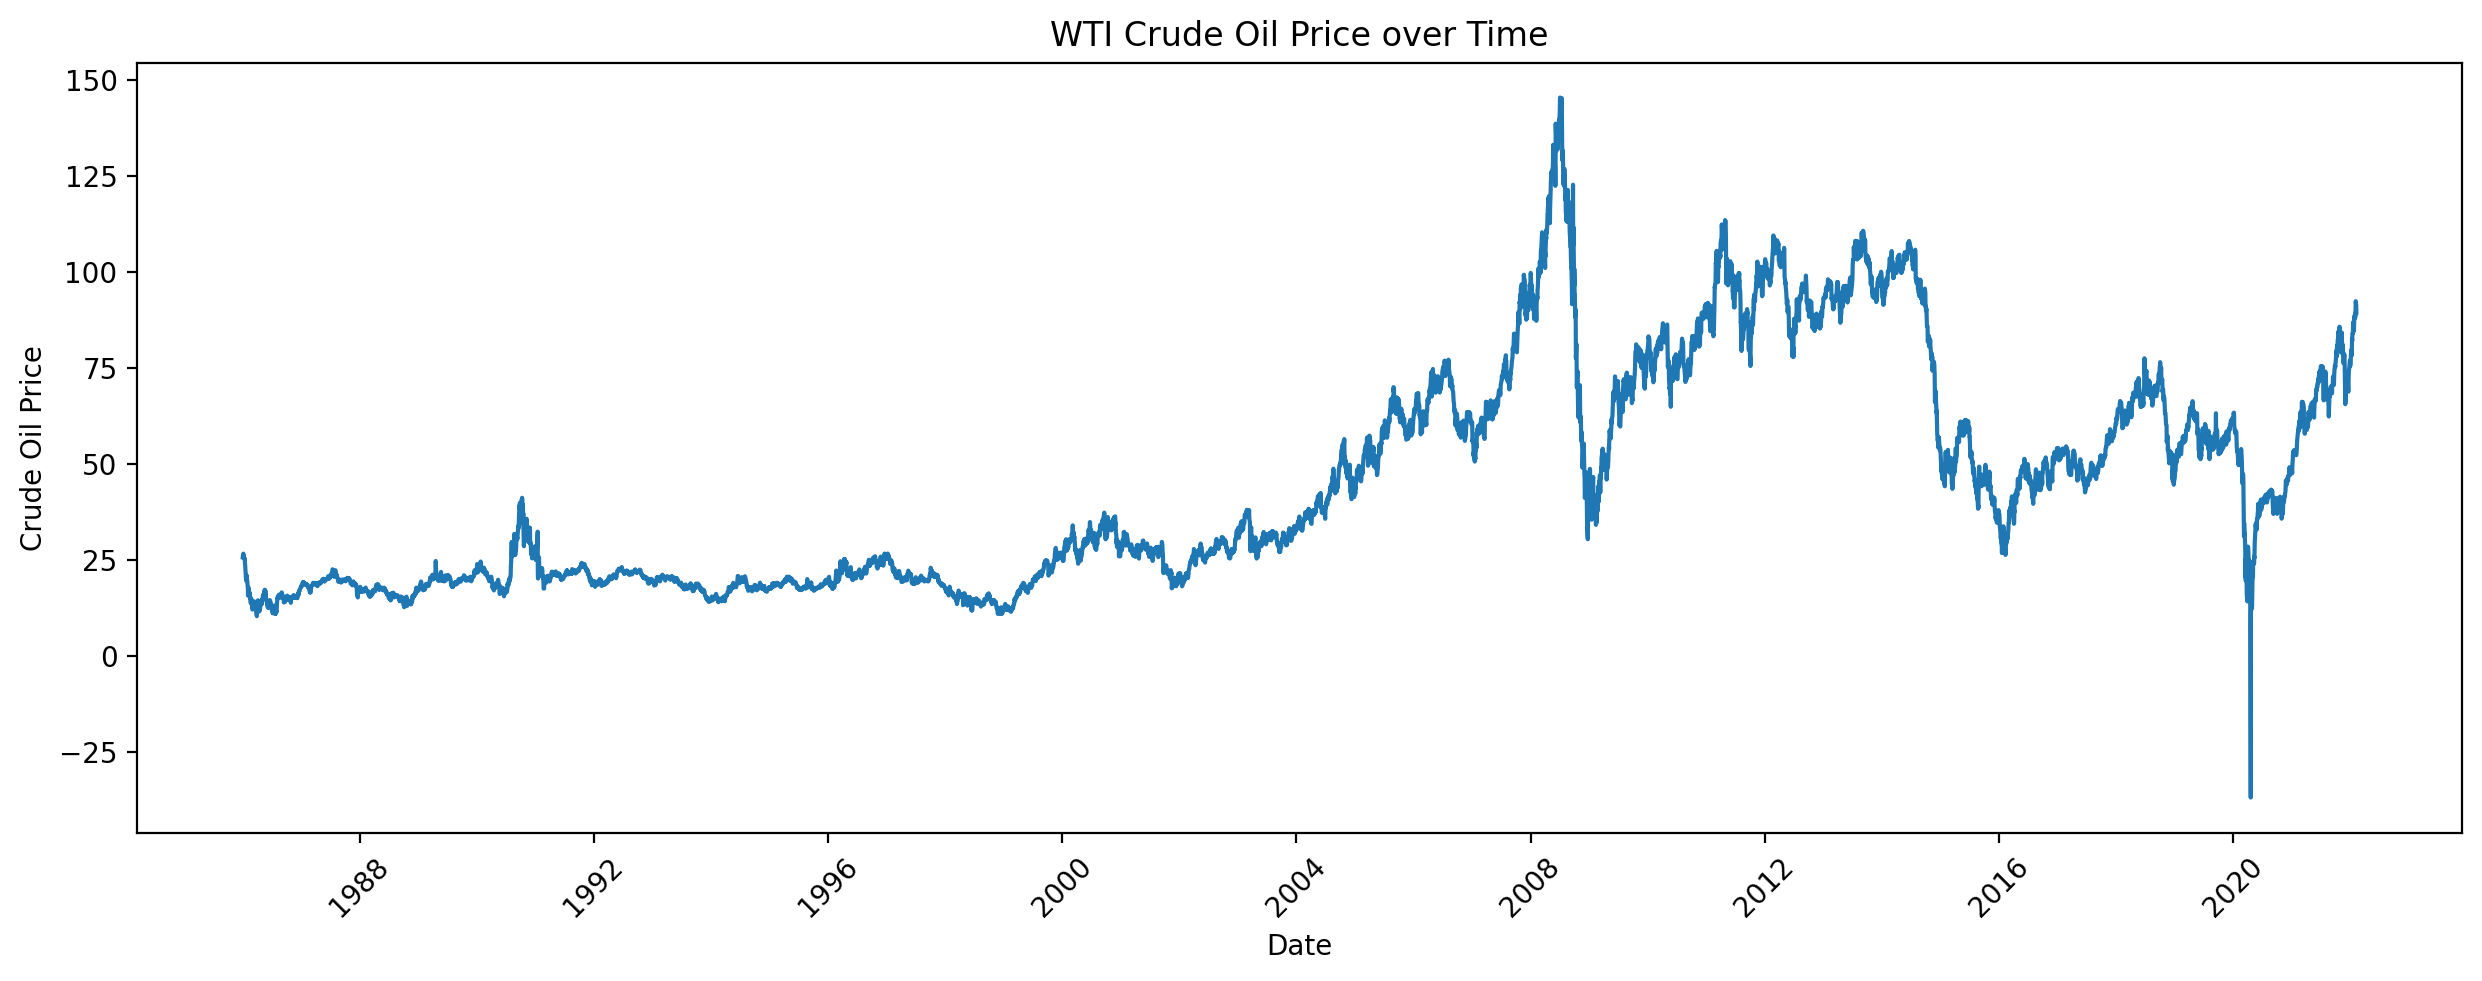

In [29]:
plt.plot(df['Date'],df['Value'])
plt.xlabel('Date')
plt.ylabel('Crude Oil Price')
plt.title('WTI Crude Oil Price over Time')
plt.xticks(rotation=45)
plt.show()

#### This code will generate a line plot showing the fluctuation of crude oil prices.
-Based on Above graph our dataset is Non-Stationary

In [30]:
adfuller(df['Value'])[1]

0.27239206185381504

- if p<0.05 = Data is Stationary
- If p>0.05 = Data is Not Stationary
#### According to P-value, the dataset is not stationary as the p-value is Greater than alpha value

### Moving Average smoothing

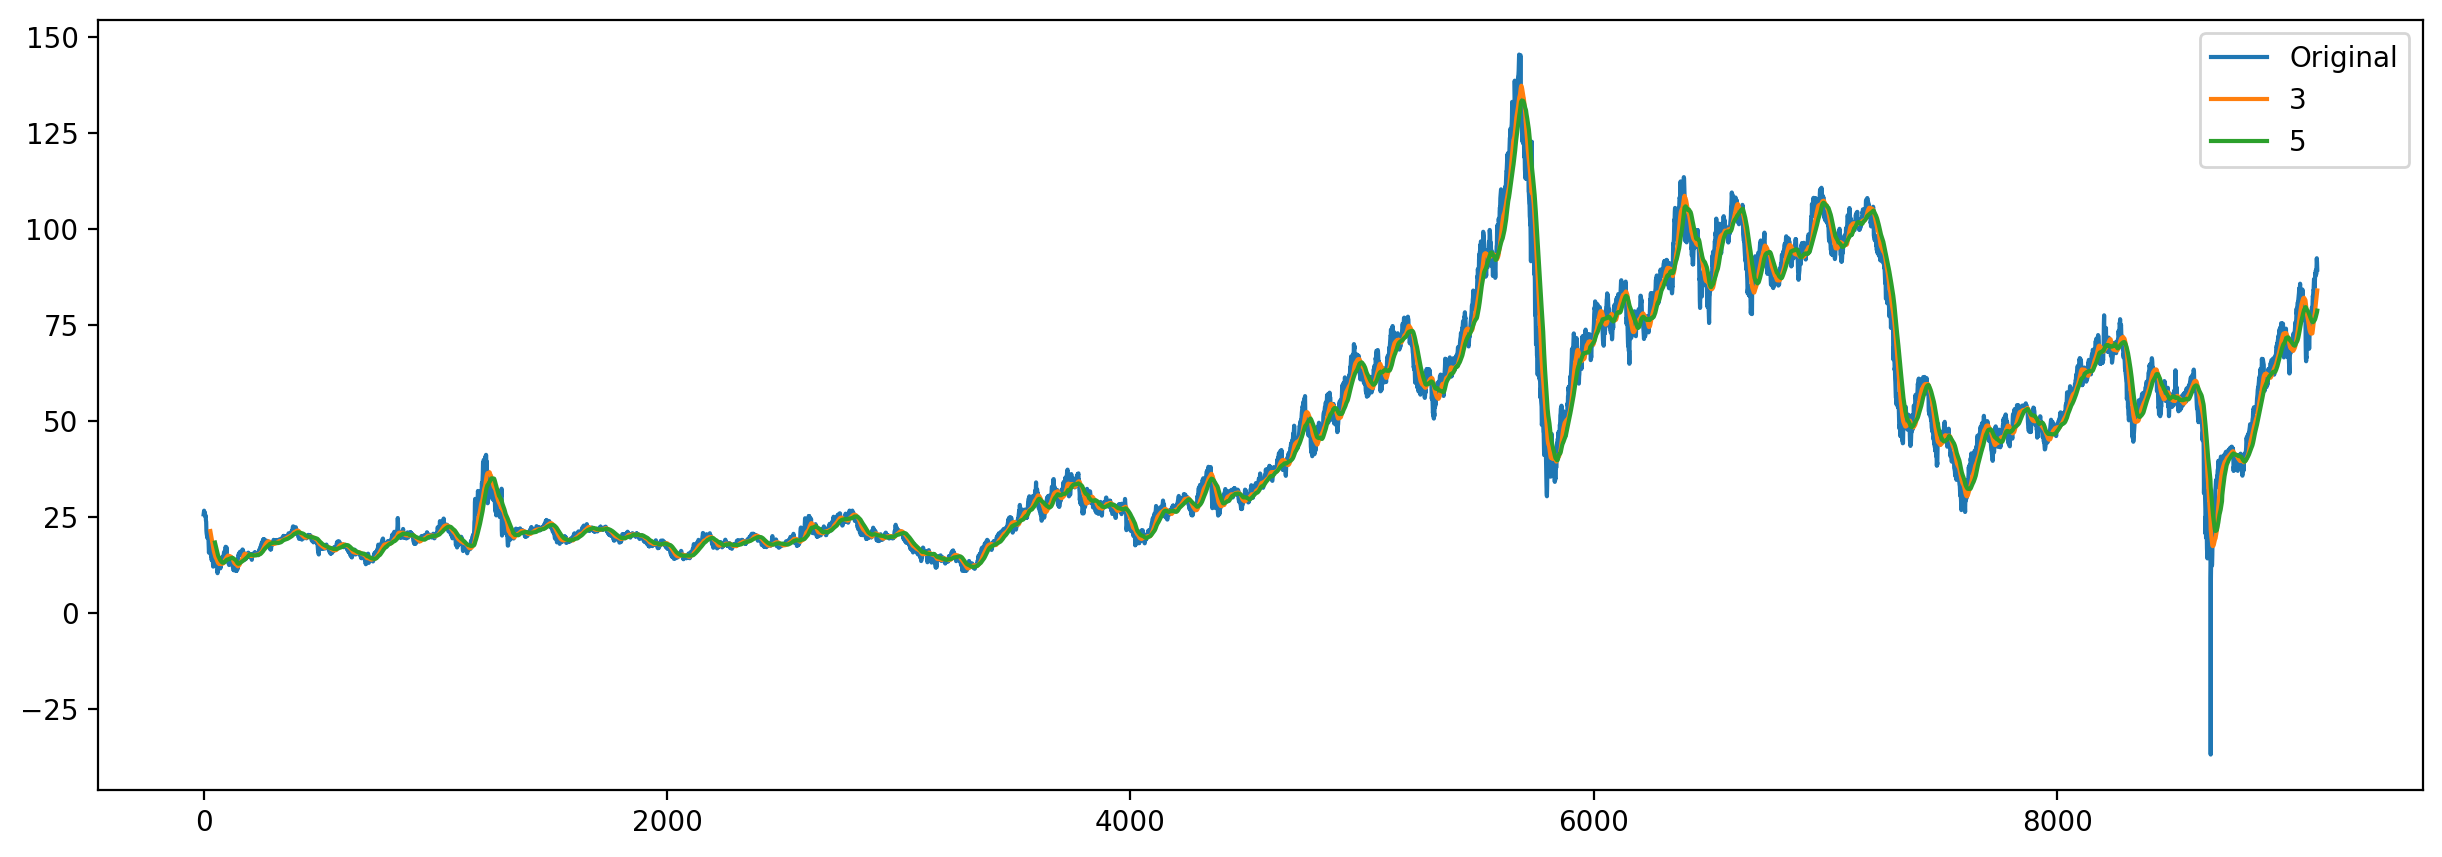

In [31]:
df['Value'].plot(label= 'Original')
df['Value'].rolling(30).mean().plot(label = '3')
df['Value'].rolling(50).mean().plot(label = '5')
plt.legend()

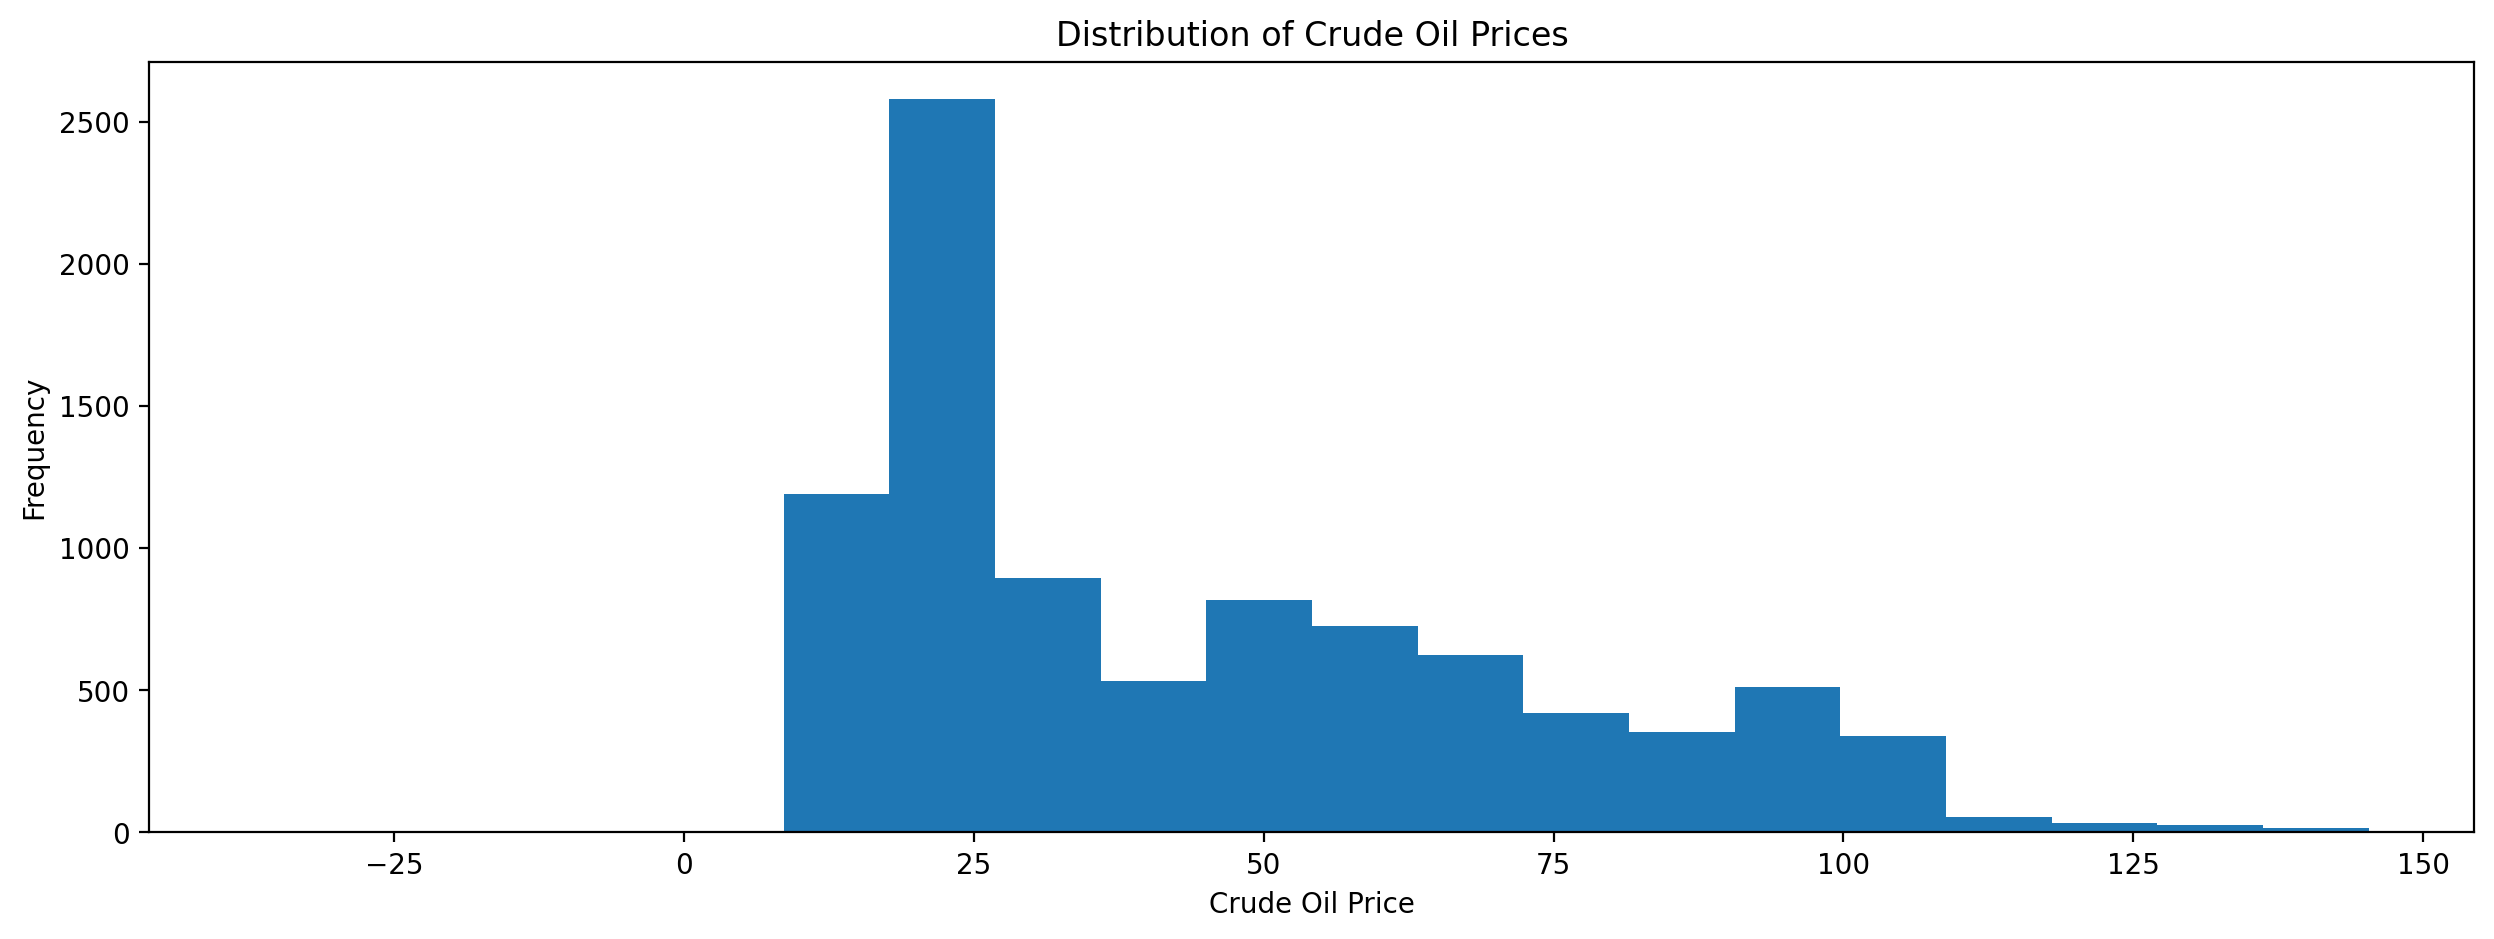

In [32]:
plt.hist(df['Value'], bins=20)
plt.xlabel('Crude Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Crude Oil Prices')
plt.show()

#### Histogram provides insights into the distribution of crude oil prices. It displays the frequency of prices within different price ranges

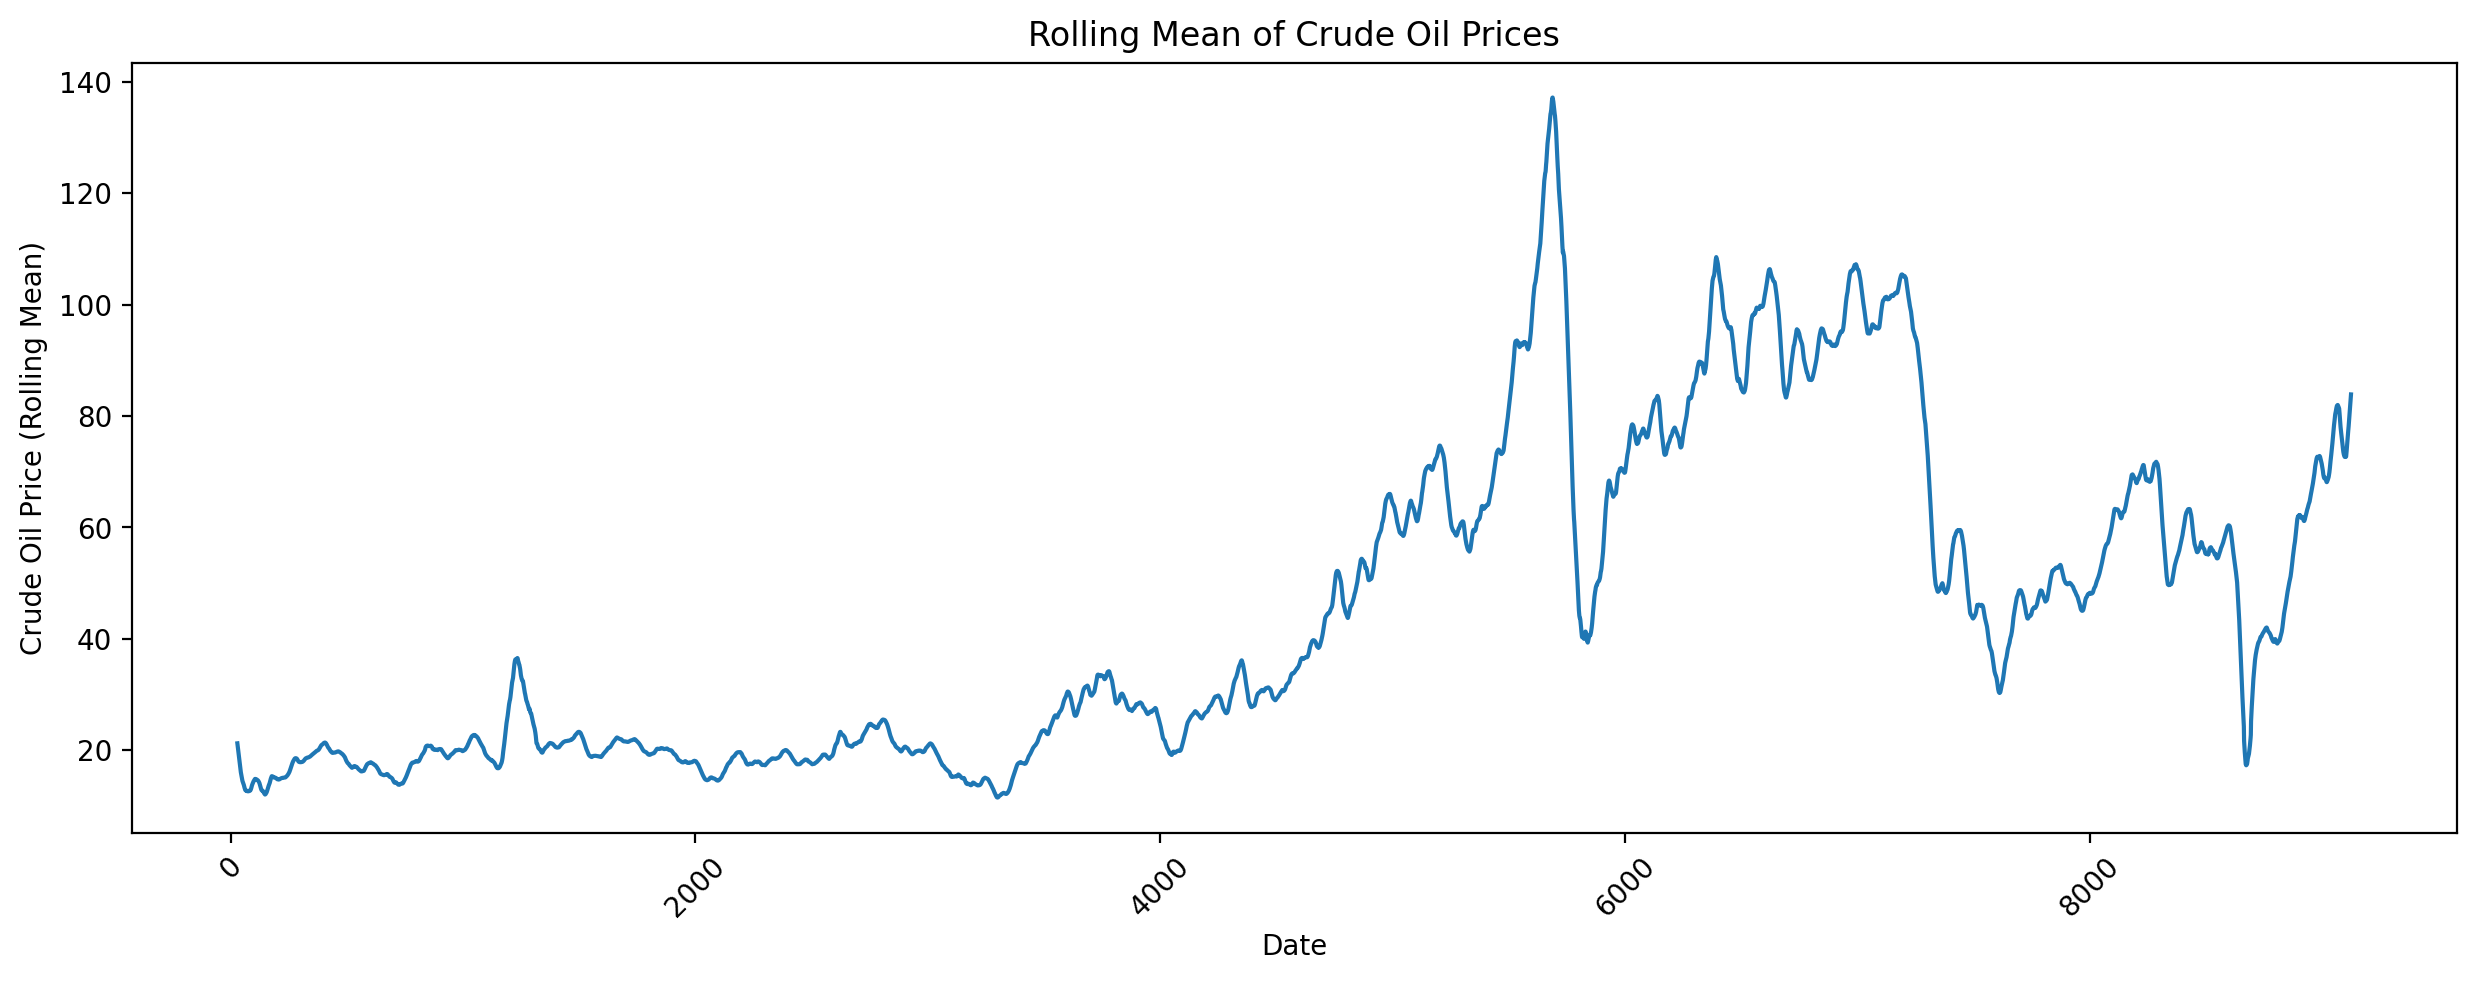

In [33]:
rolling_mean = df['Value'].rolling(window=30).mean()
plt.plot(rolling_mean)
plt.xlabel('Date')
plt.ylabel('Crude Oil Price (Rolling Mean)')
plt.title('Rolling Mean of Crude Oil Prices')
plt.xticks(rotation=45)
plt.show()

#### The rolling mean plot calculates the average crude oil price over a specified time window

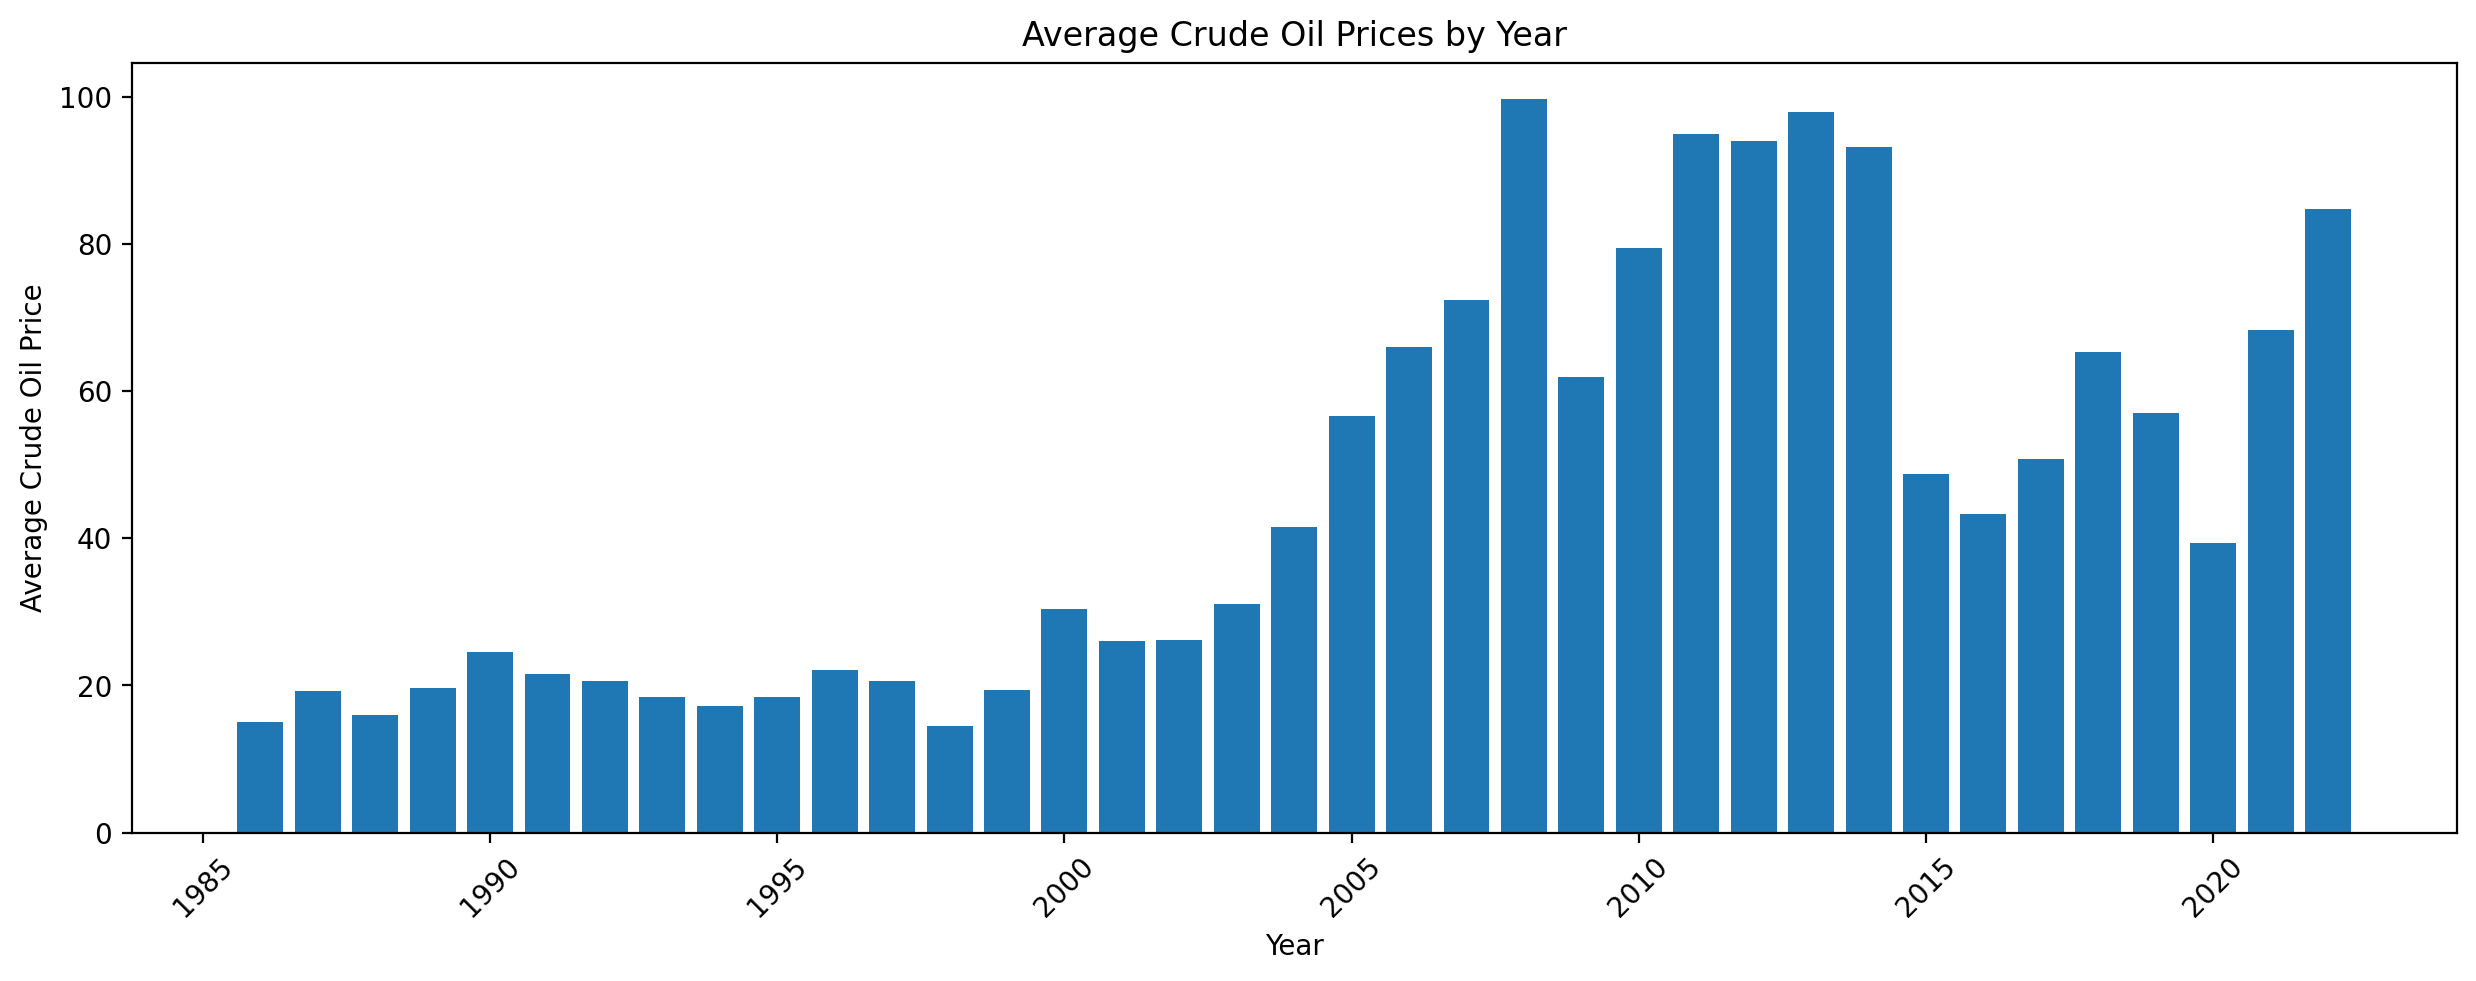

In [34]:
df['Year'] = df['Date'].dt.year
average_prices = df.groupby('Year')['Value'].mean()

plt.bar(average_prices.index, average_prices.values)
plt.xlabel('Year')
plt.ylabel('Average Crude Oil Price')
plt.title('Average Crude Oil Prices by Year')
plt.xticks(rotation=45)
plt.show()

#### The bar plot displays the average crude oil prices for each year. It allows for easy comparison between different years

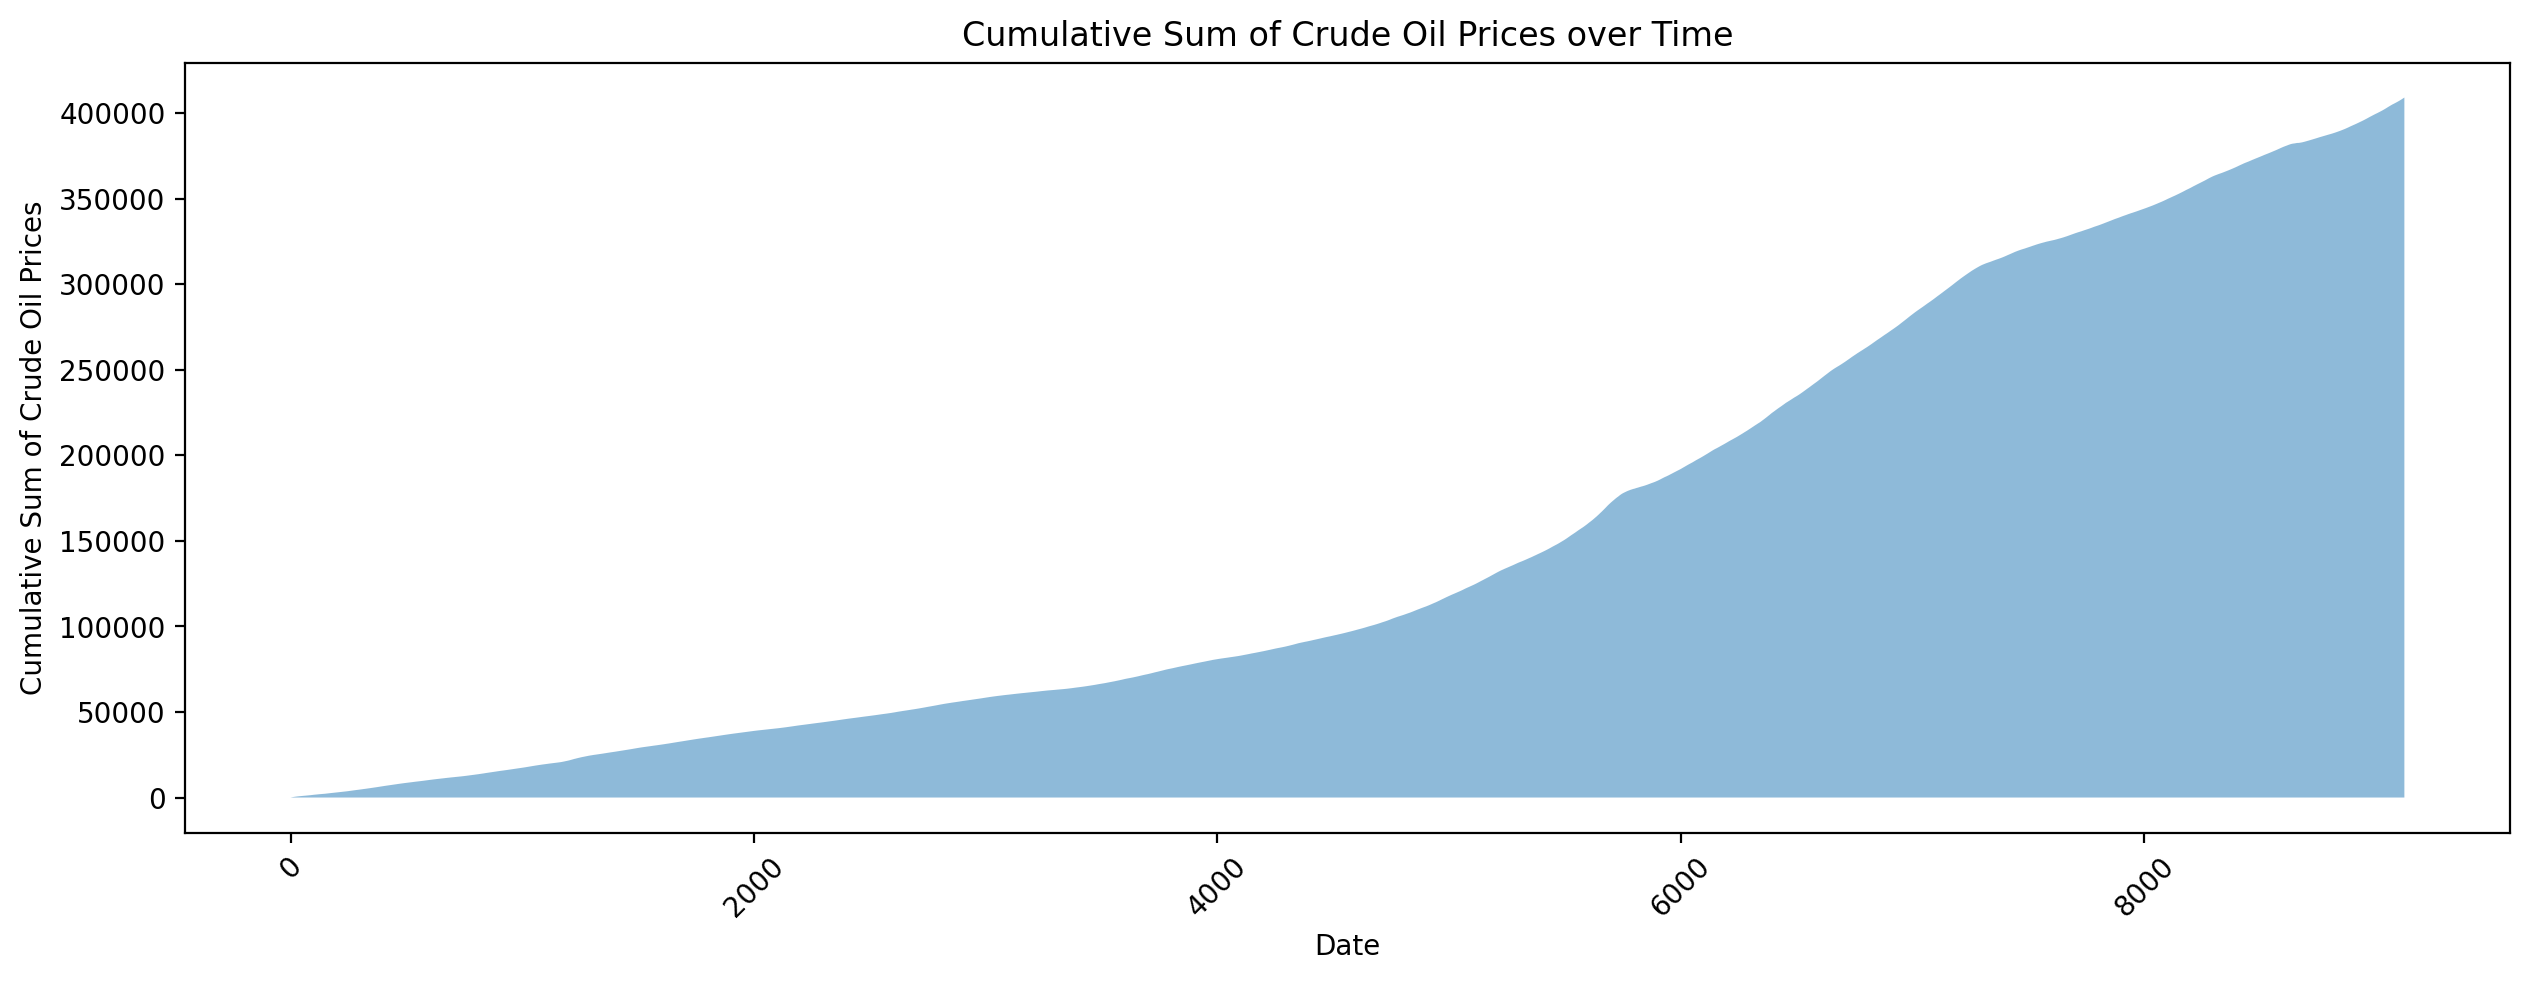

In [35]:
cumulative_sum = df['Value'].cumsum()

plt.fill_between(df.index, cumulative_sum, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative Sum of Crude Oil Prices')
plt.title('Cumulative Sum of Crude Oil Prices over Time')
plt.xticks(rotation=45)
plt.show()

#### The area chart illustrates the cumulative sum of crude oil prices over time. It helps identify the overall growth

# Outlier Detection

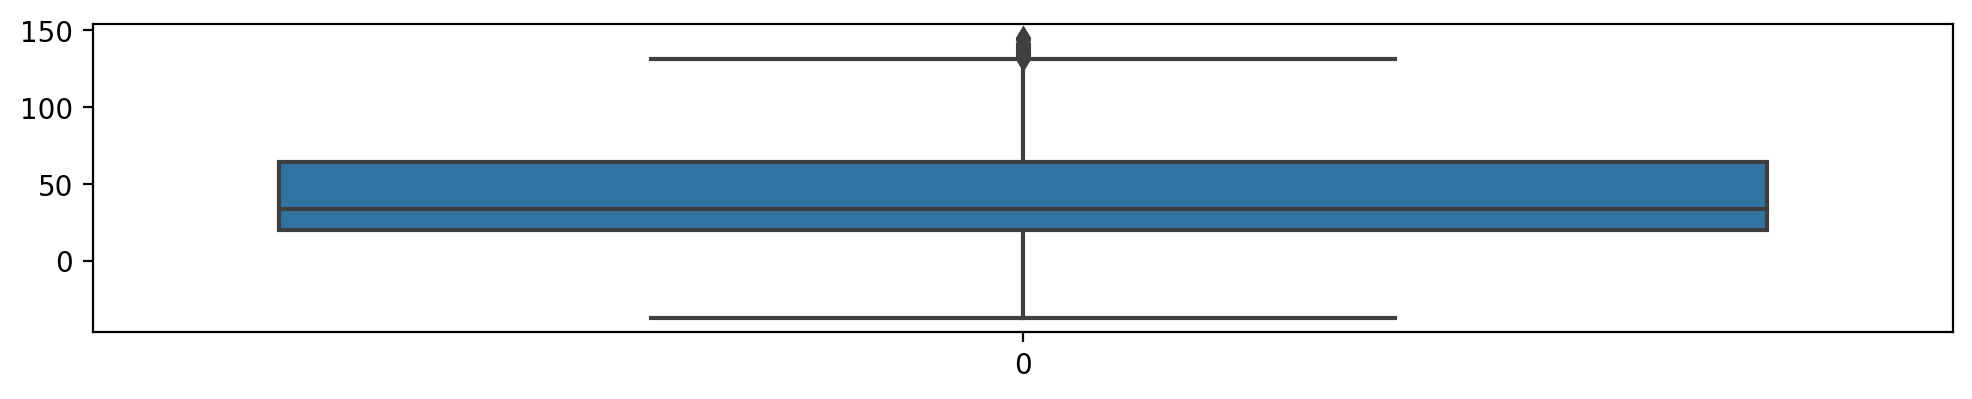

In [36]:
#Box Plot
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(df['Value'], whis=1.5)

<Axes: xlabel='Year', ylabel='Value'>

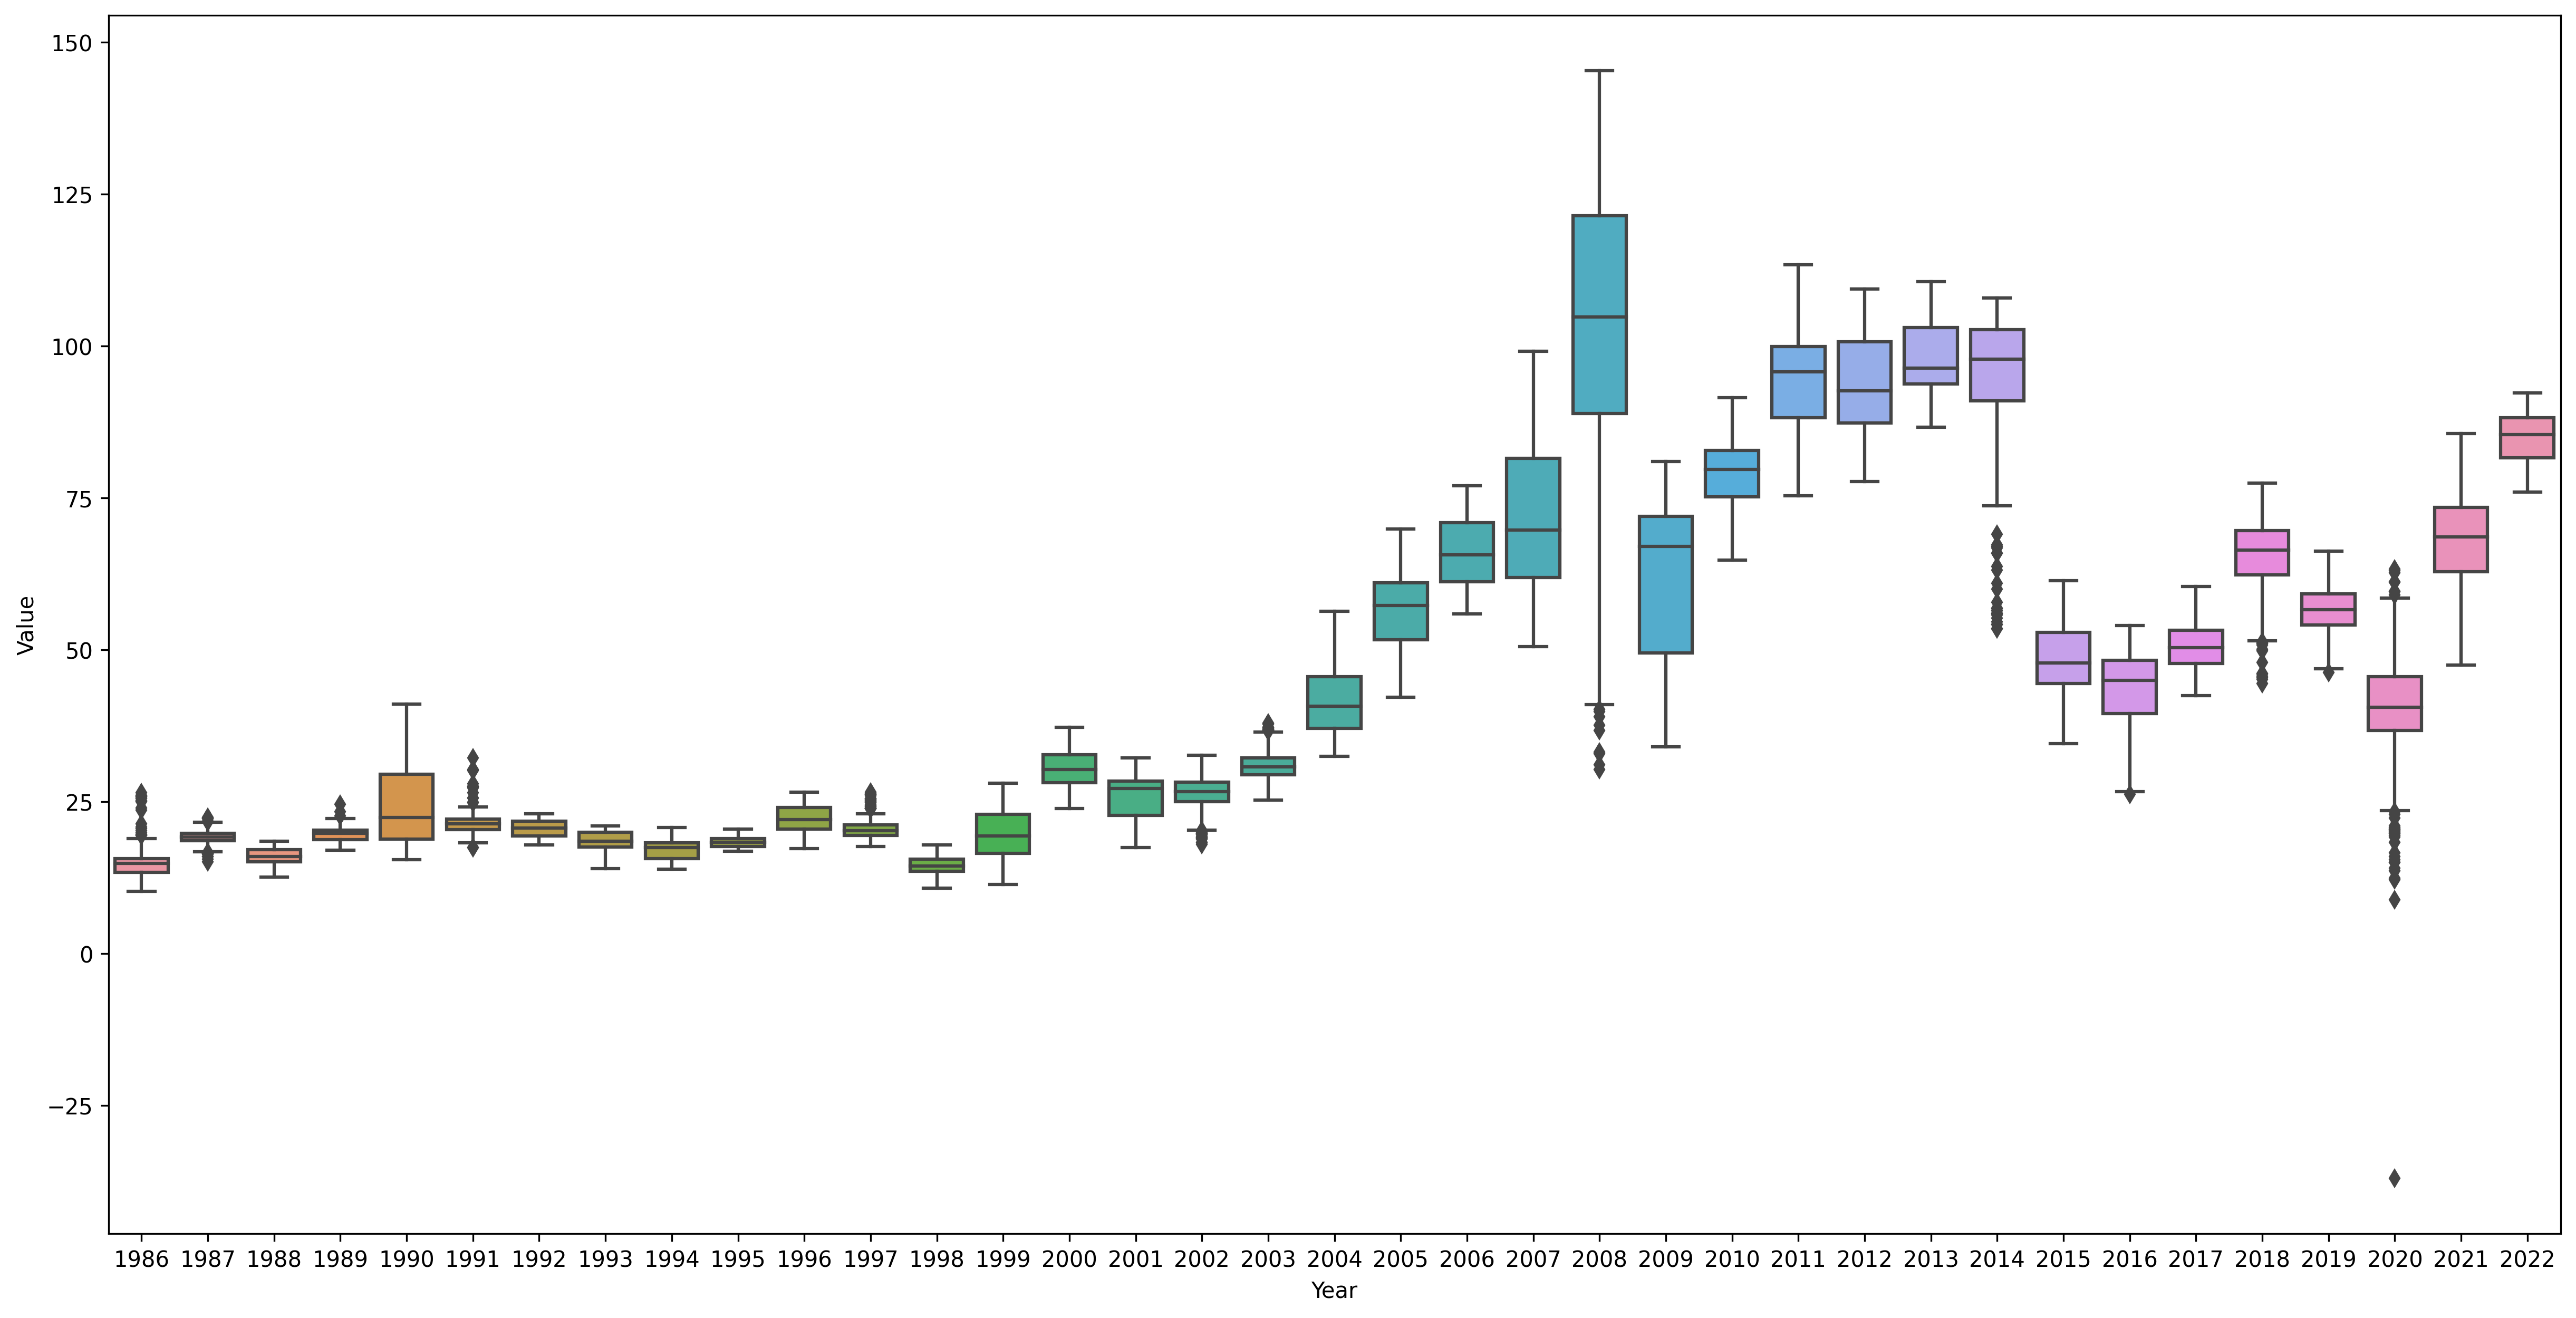

In [37]:
# Checking year wise outliere
fig, axes = plt.subplots(figsize=(20,10), dpi=300)
sns.boxplot(x='Year', y='Value', data=df)

### Outlires detected in below years

In [38]:
# Separate the data year-wise into different dataframes
yearly_data = {}
for year in df['Year'].unique():
    yearly_data[year] = df[df['Year'] == year]

# Access the data for a specific year

data_1986 = yearly_data[1986]
data_1987 = yearly_data[1987]
data_1989 = yearly_data[1989]
data_1991 = yearly_data[1991]
data_1997 = yearly_data[1997]
data_2002 = yearly_data[2002]
data_2003 = yearly_data[2003]
data_2008 = yearly_data[2008]
data_2014 = yearly_data[2014]
data_2016 = yearly_data[2016]
data_2018 = yearly_data[2018]
data_2019 = yearly_data[2019]
data_2020 = yearly_data[2020]

In [39]:
def outlier_detection(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1

    upper = q3+(1.5*iqr)
    lower = q1-(1.5*iqr)

    return lower,upper

In [40]:
selected_years = [1986, 1987, 1989, 1991, 1997,2002,2003, 2008, 2014, 2016, 2018, 2019, 2020]

for year in selected_years:
    year_data = df[df['Date'].dt.year == year]  # Filter data for the specific year
    lower_limit, upper_limit = outlier_detection(year_data, 'Value')  # Apply outlier detection

    # Print the lower and upper limits for each year
    print(f"Year: {year}")
    print(f"Lower Limit: {lower_limit}")
    print(f"Upper Limit: {upper_limit}")
    print("\n")

Year: 1986
Lower Limit: 9.902499999999996
Upper Limit: 19.082500000000003


Year: 1987
Lower Limit: 16.715
Upper Limit: 21.715


Year: 1989
Lower Limit: 16.515000000000004
Upper Limit: 22.554999999999996


Year: 1991
Lower Limit: 17.799999999999997
Upper Limit: 24.78


Year: 1997
Lower Limit: 16.841249999999995
Upper Limit: 23.791249999999998


Year: 2002
Lower Limit: 20.253750000000004
Upper Limit: 32.96375


Year: 2003
Lower Limit: 25.15875
Upper Limit: 36.50874999999999


Year: 2008
Lower Limit: 40.17499999999999
Upper Limit: 170.215


Year: 2014
Lower Limit: 73.32499999999996
Upper Limit: 120.32500000000002


Year: 2016
Lower Limit: 26.292499999999997
Upper Limit: 61.472500000000004


Year: 2018
Lower Limit: 51.34875
Upper Limit: 80.65875


Year: 2019
Lower Limit: 46.44125000000001
Upper Limit: 66.83125


Year: 2020
Lower Limit: 23.4225
Upper Limit: 58.9225




In [41]:
grouped_data = df.groupby('Year')

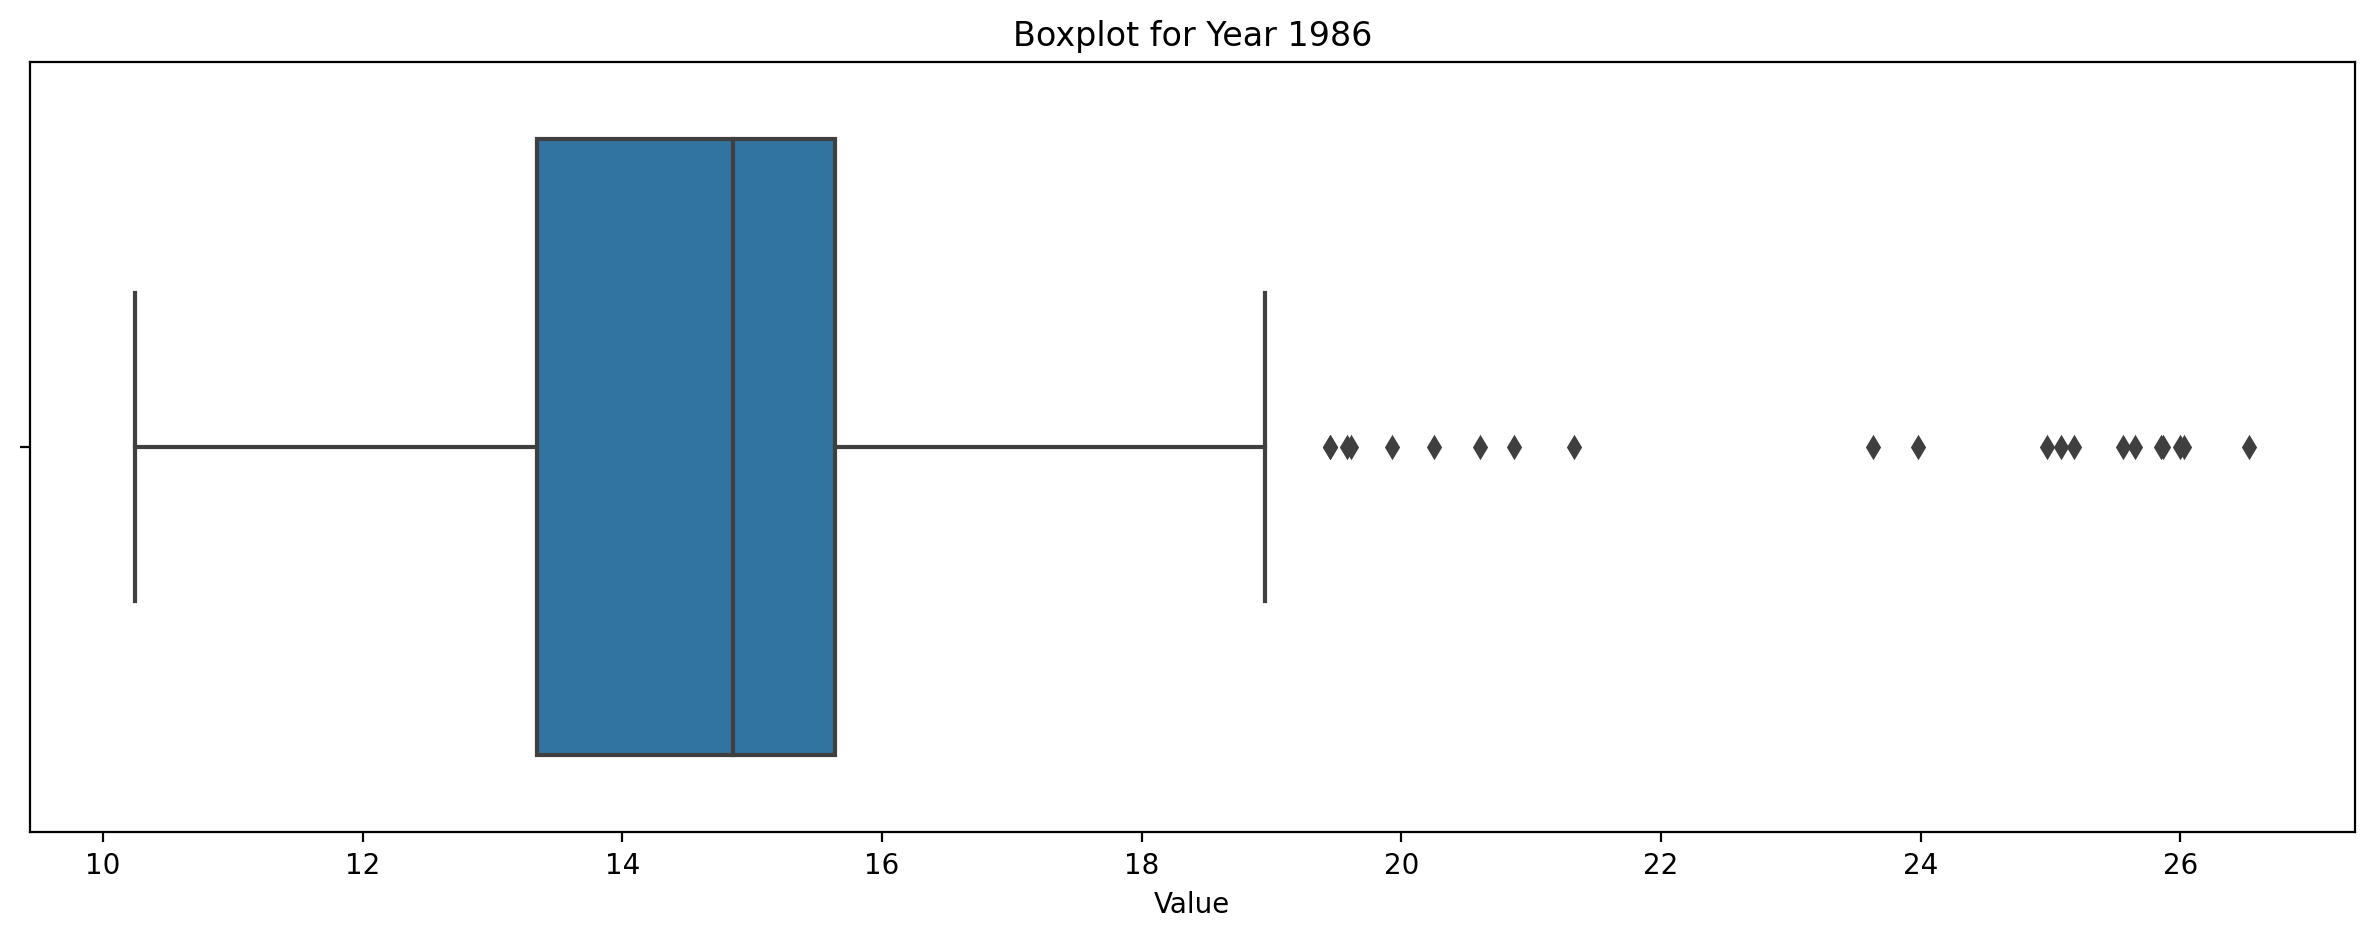

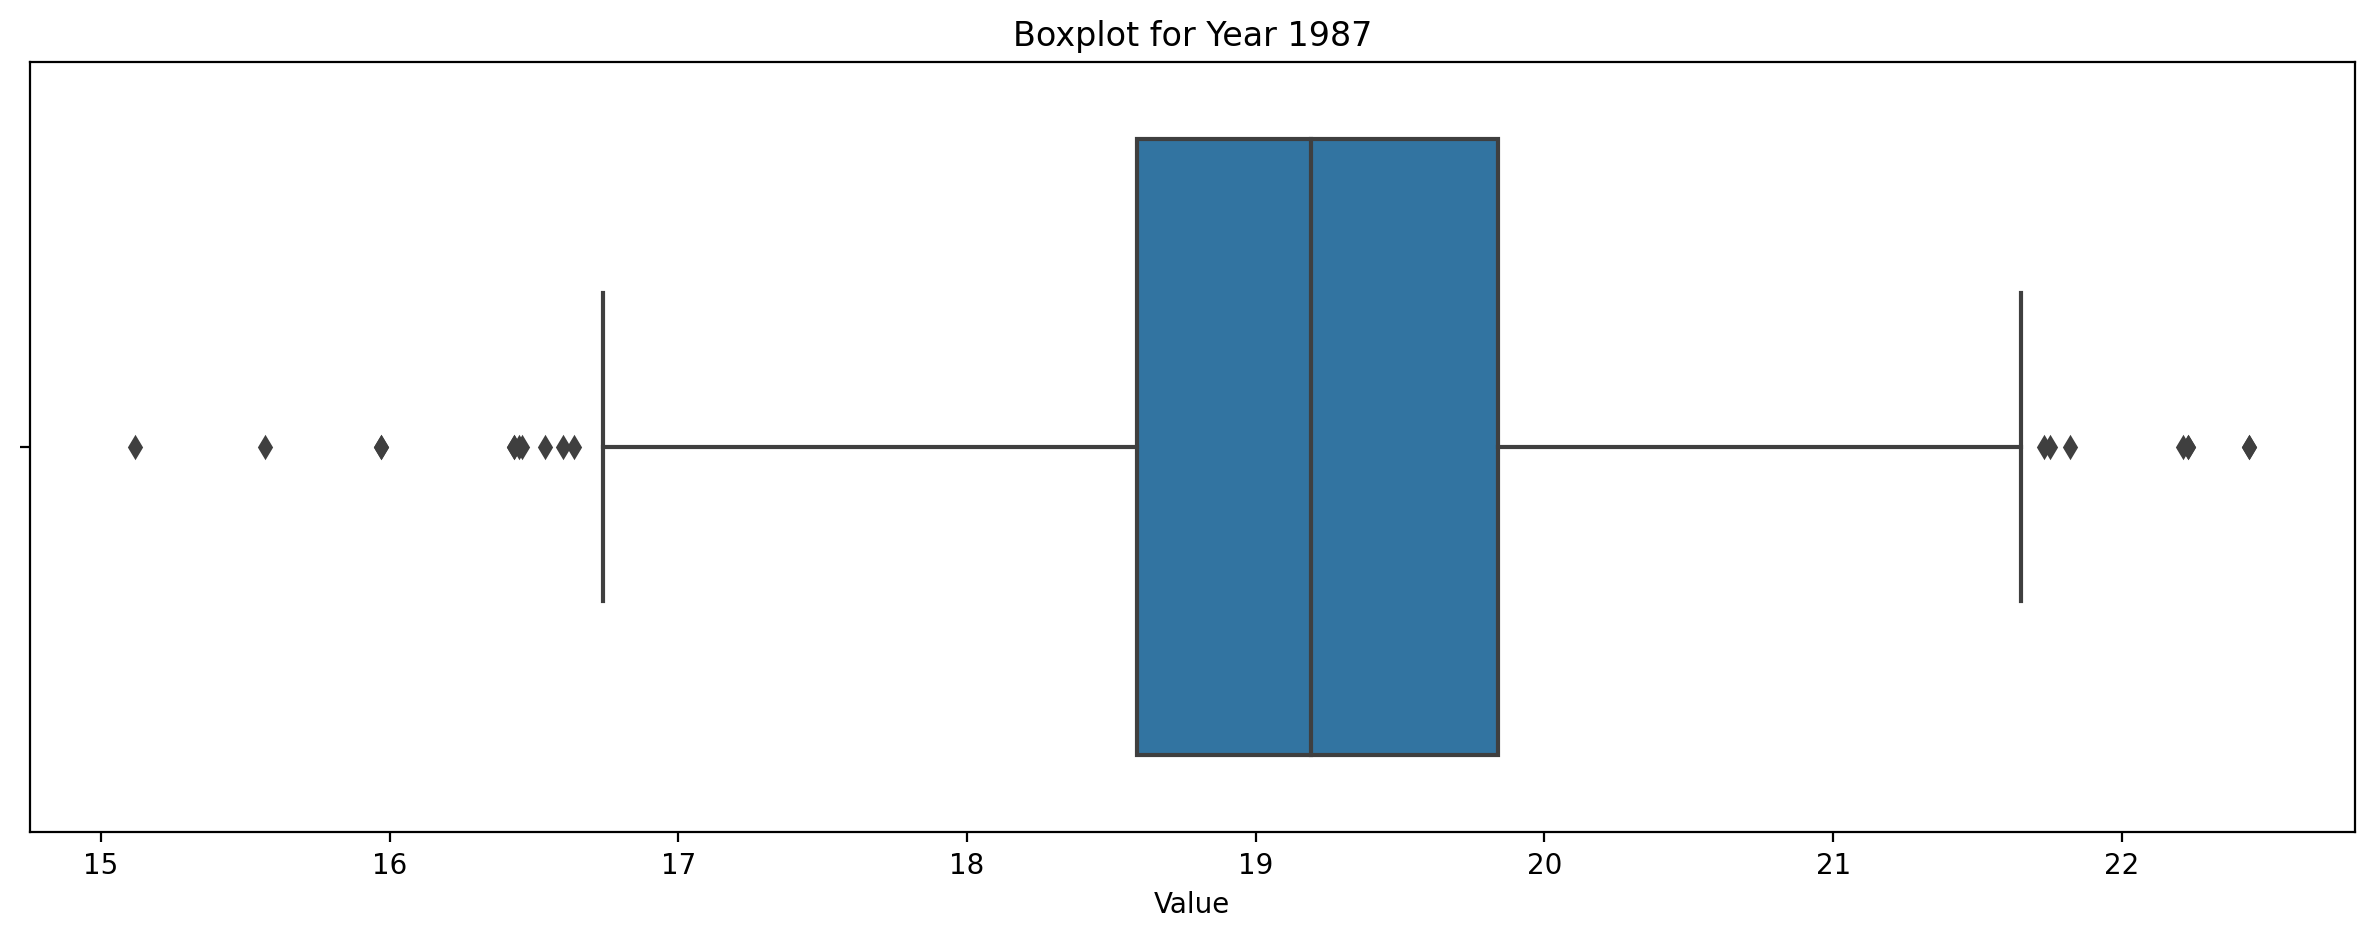

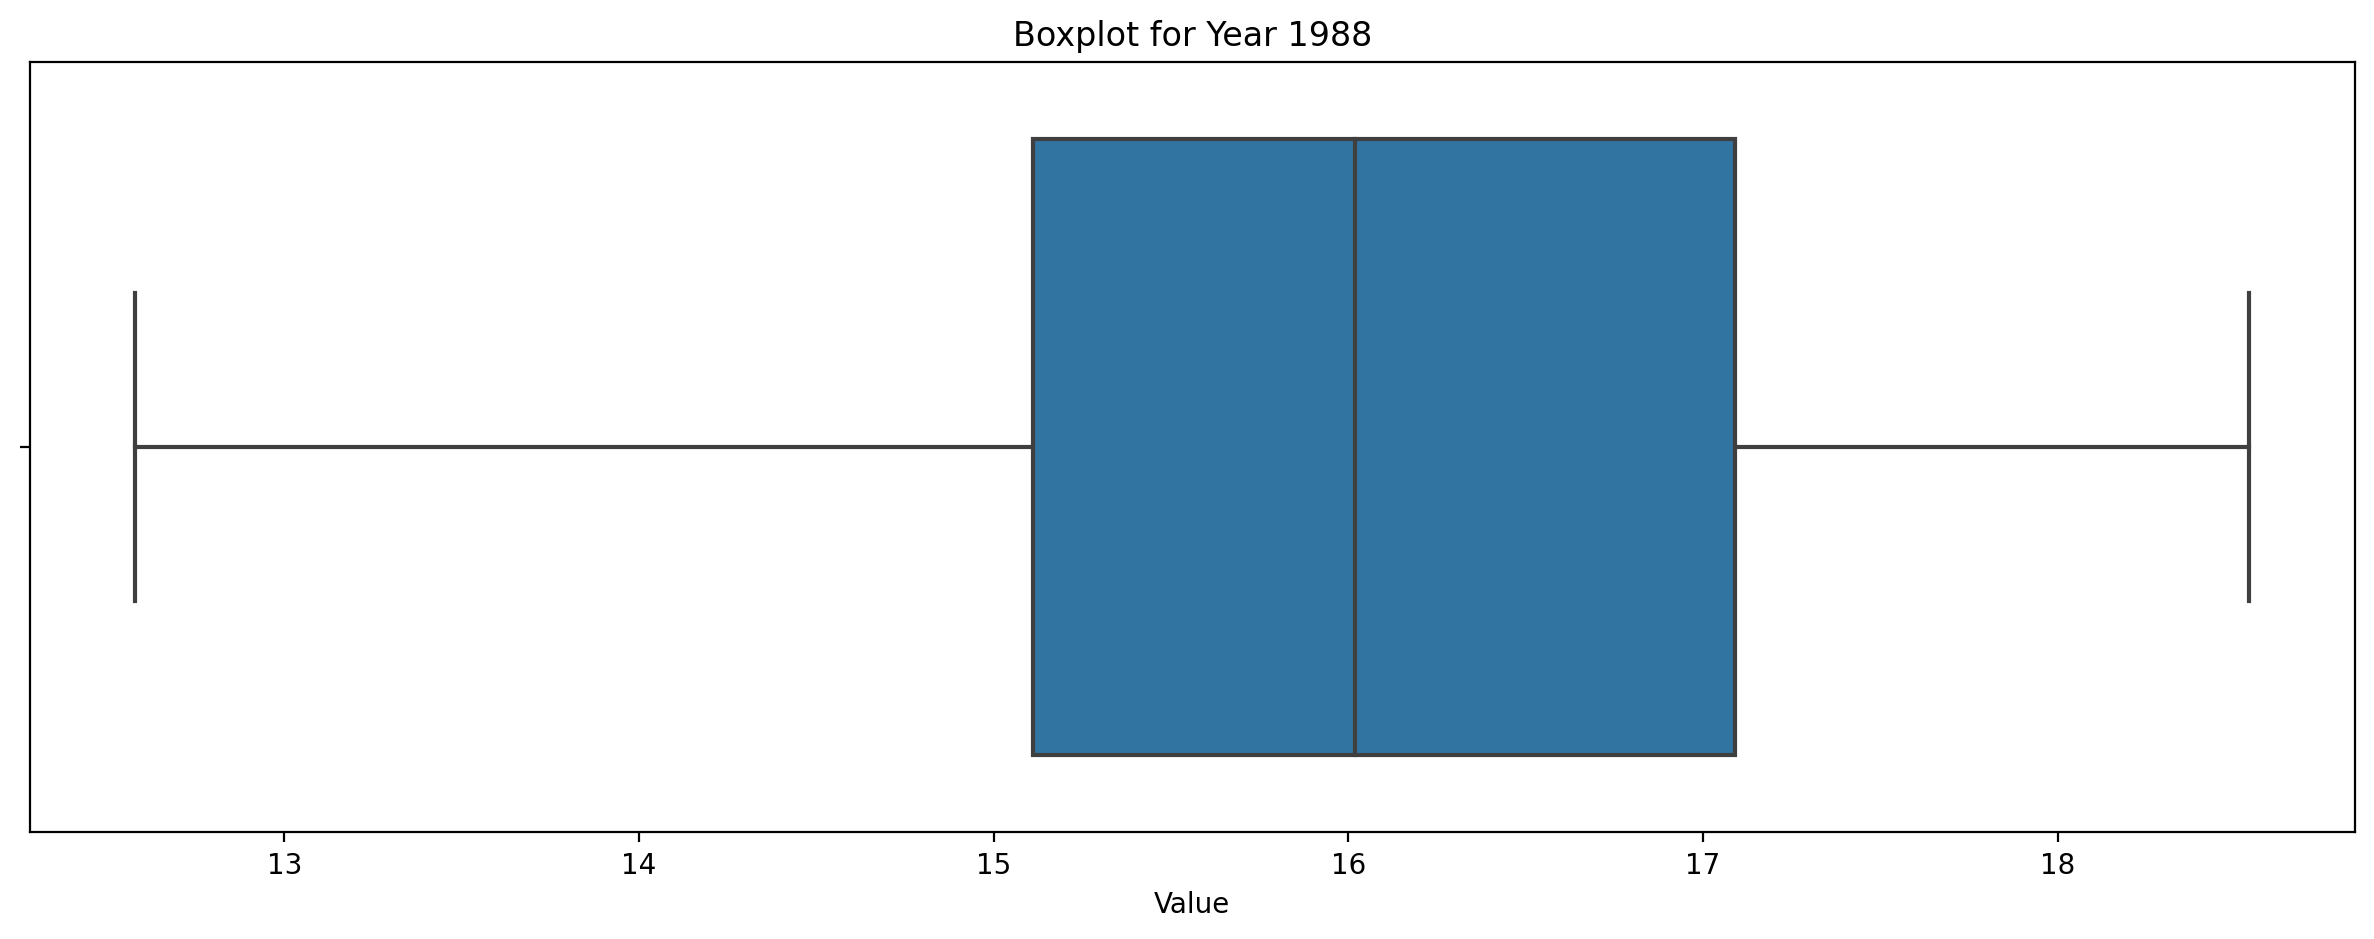

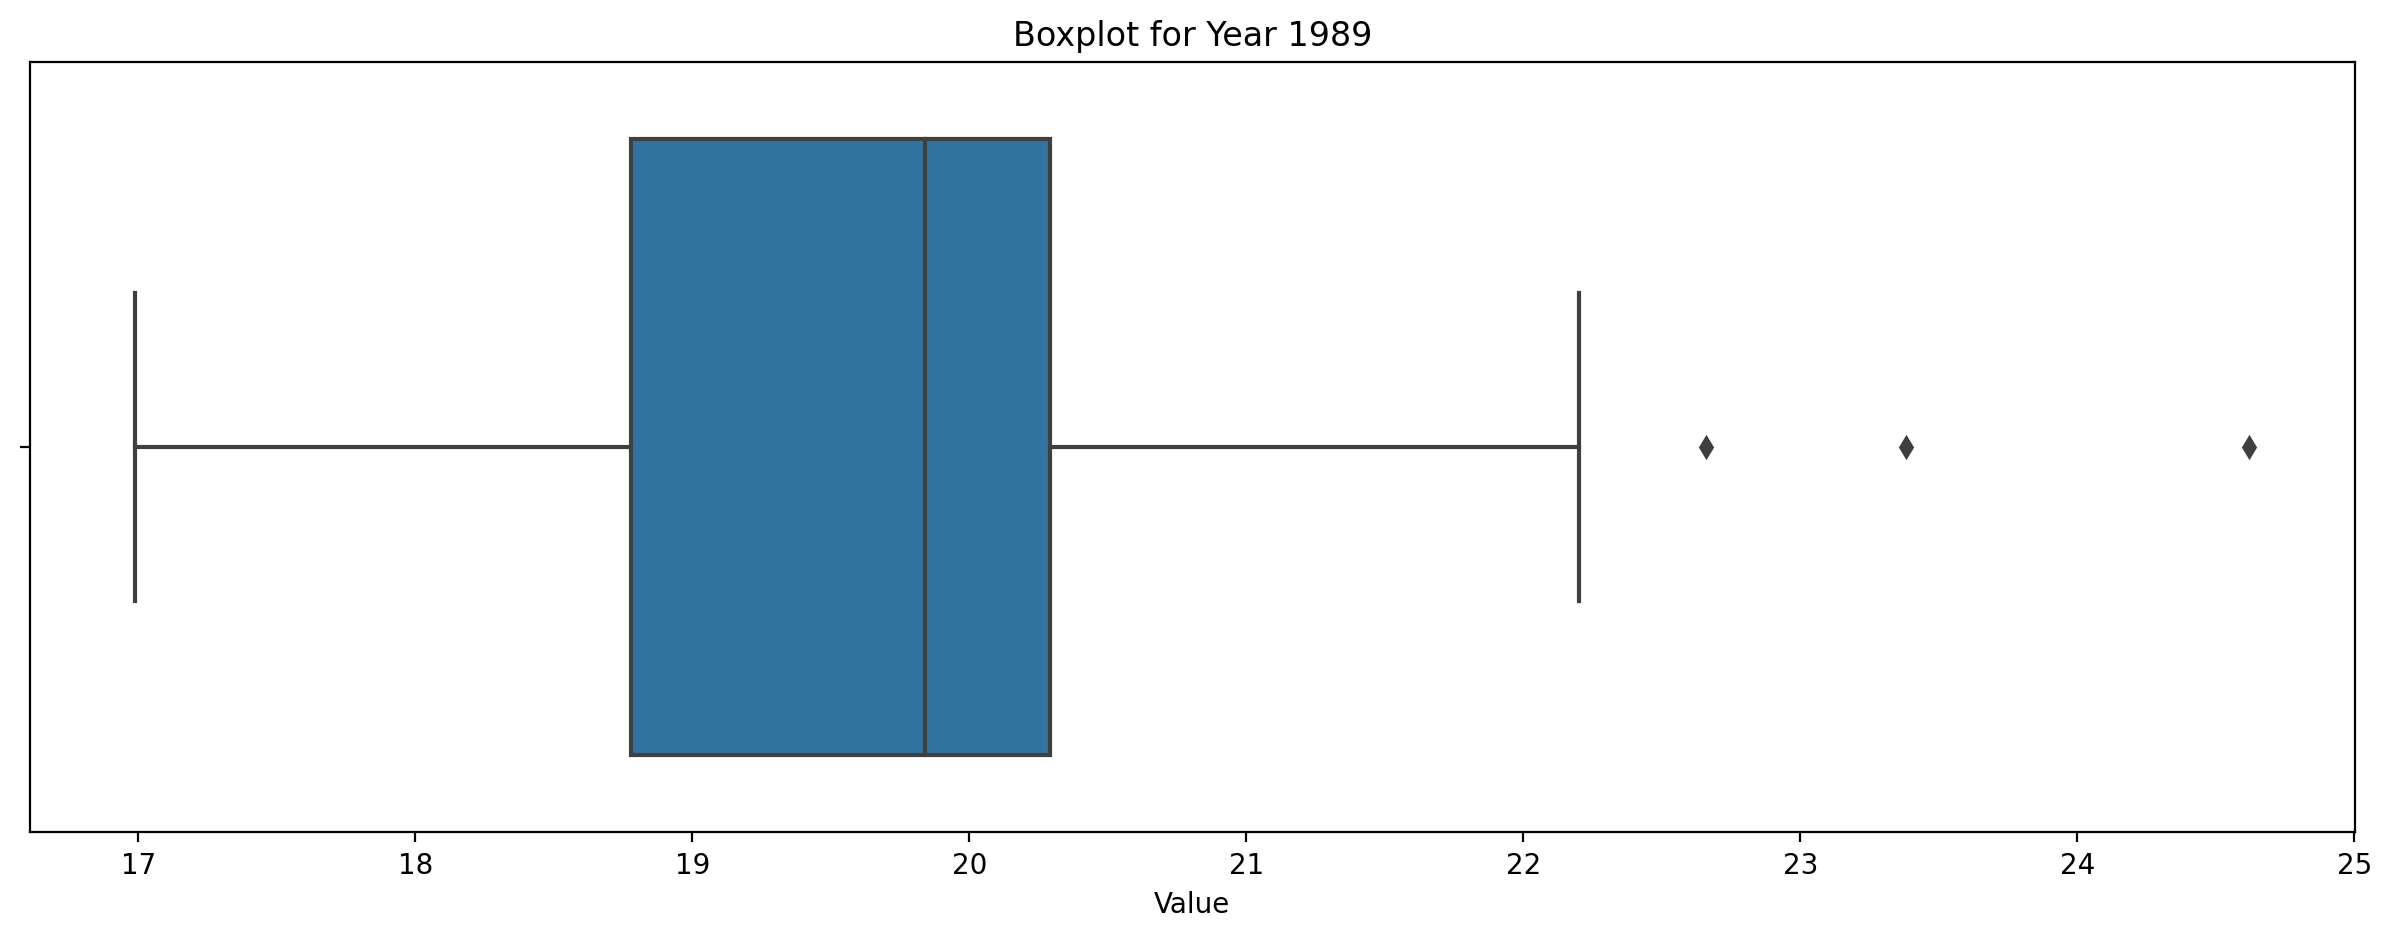

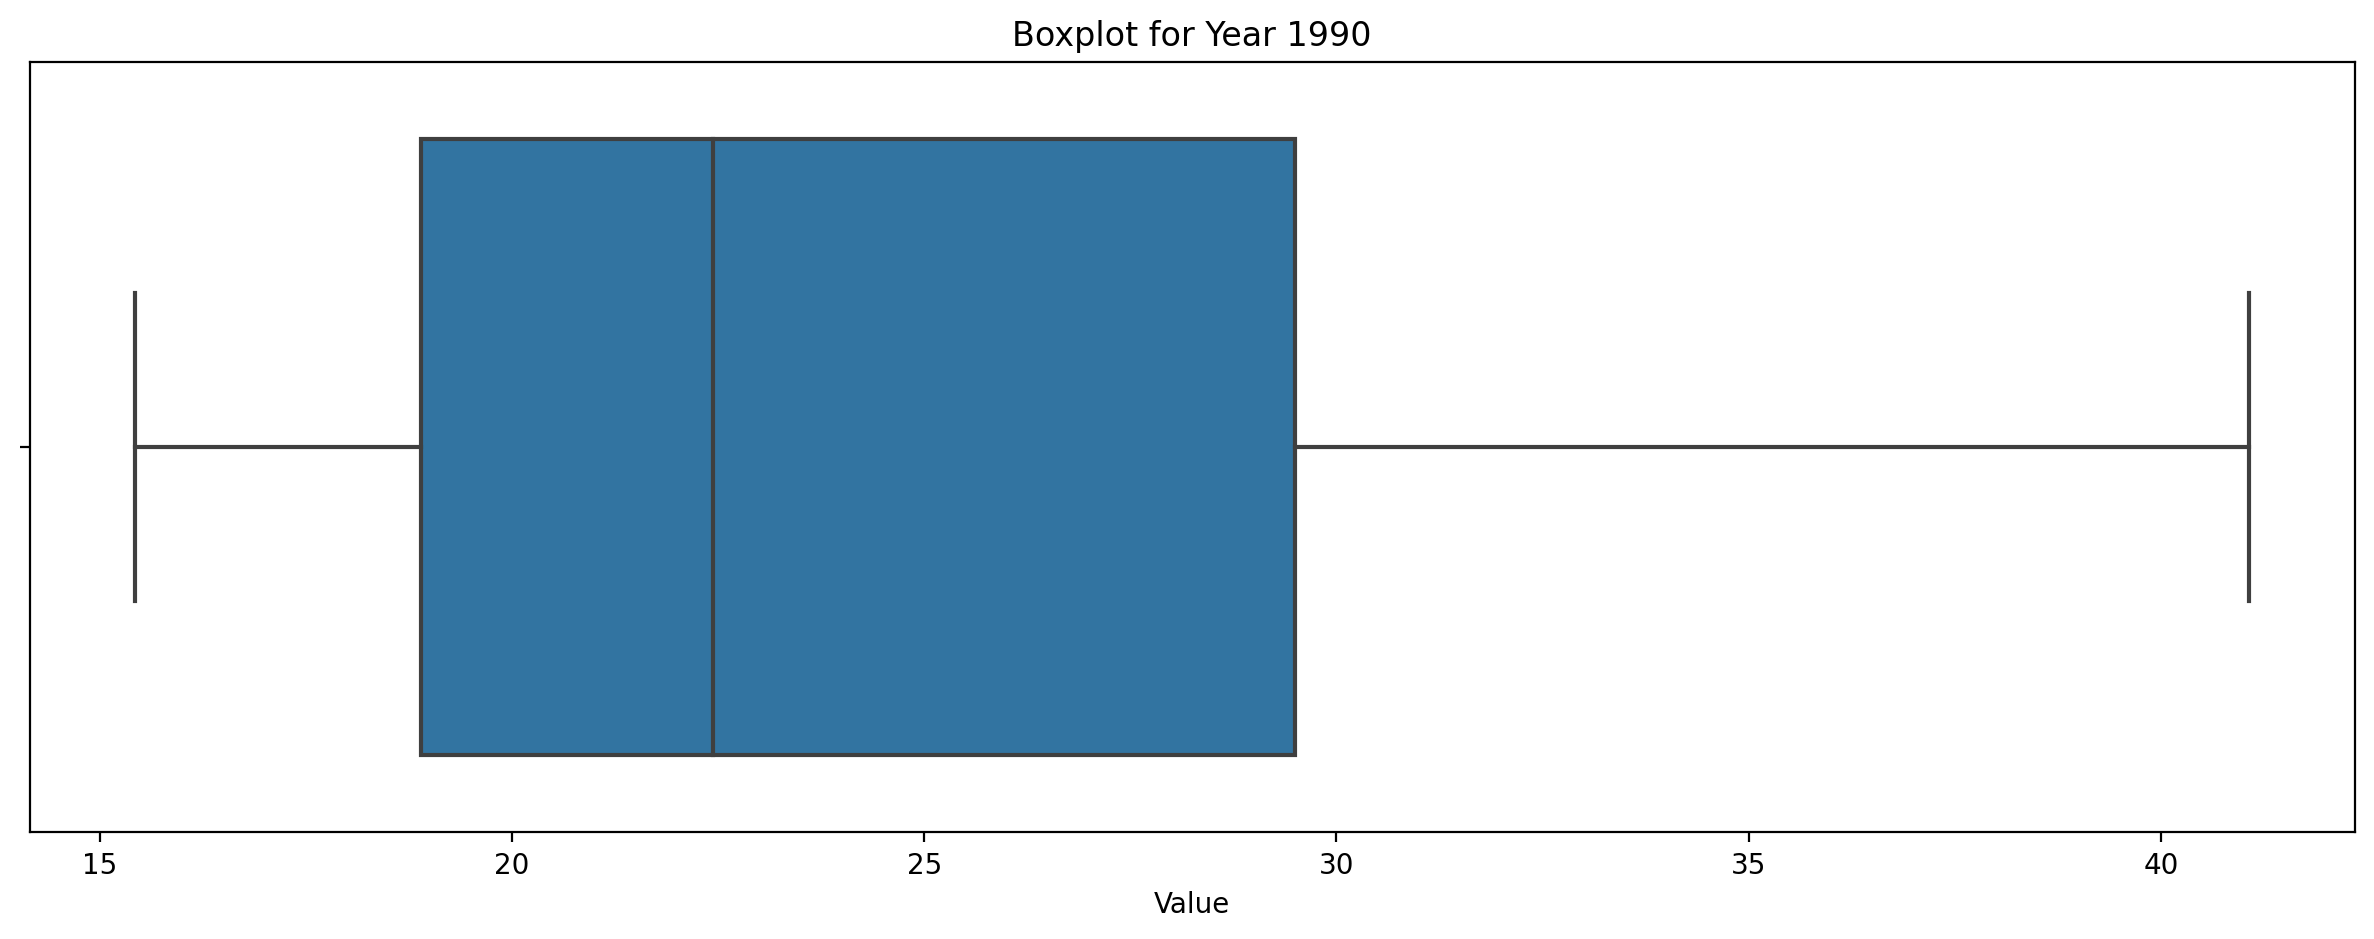

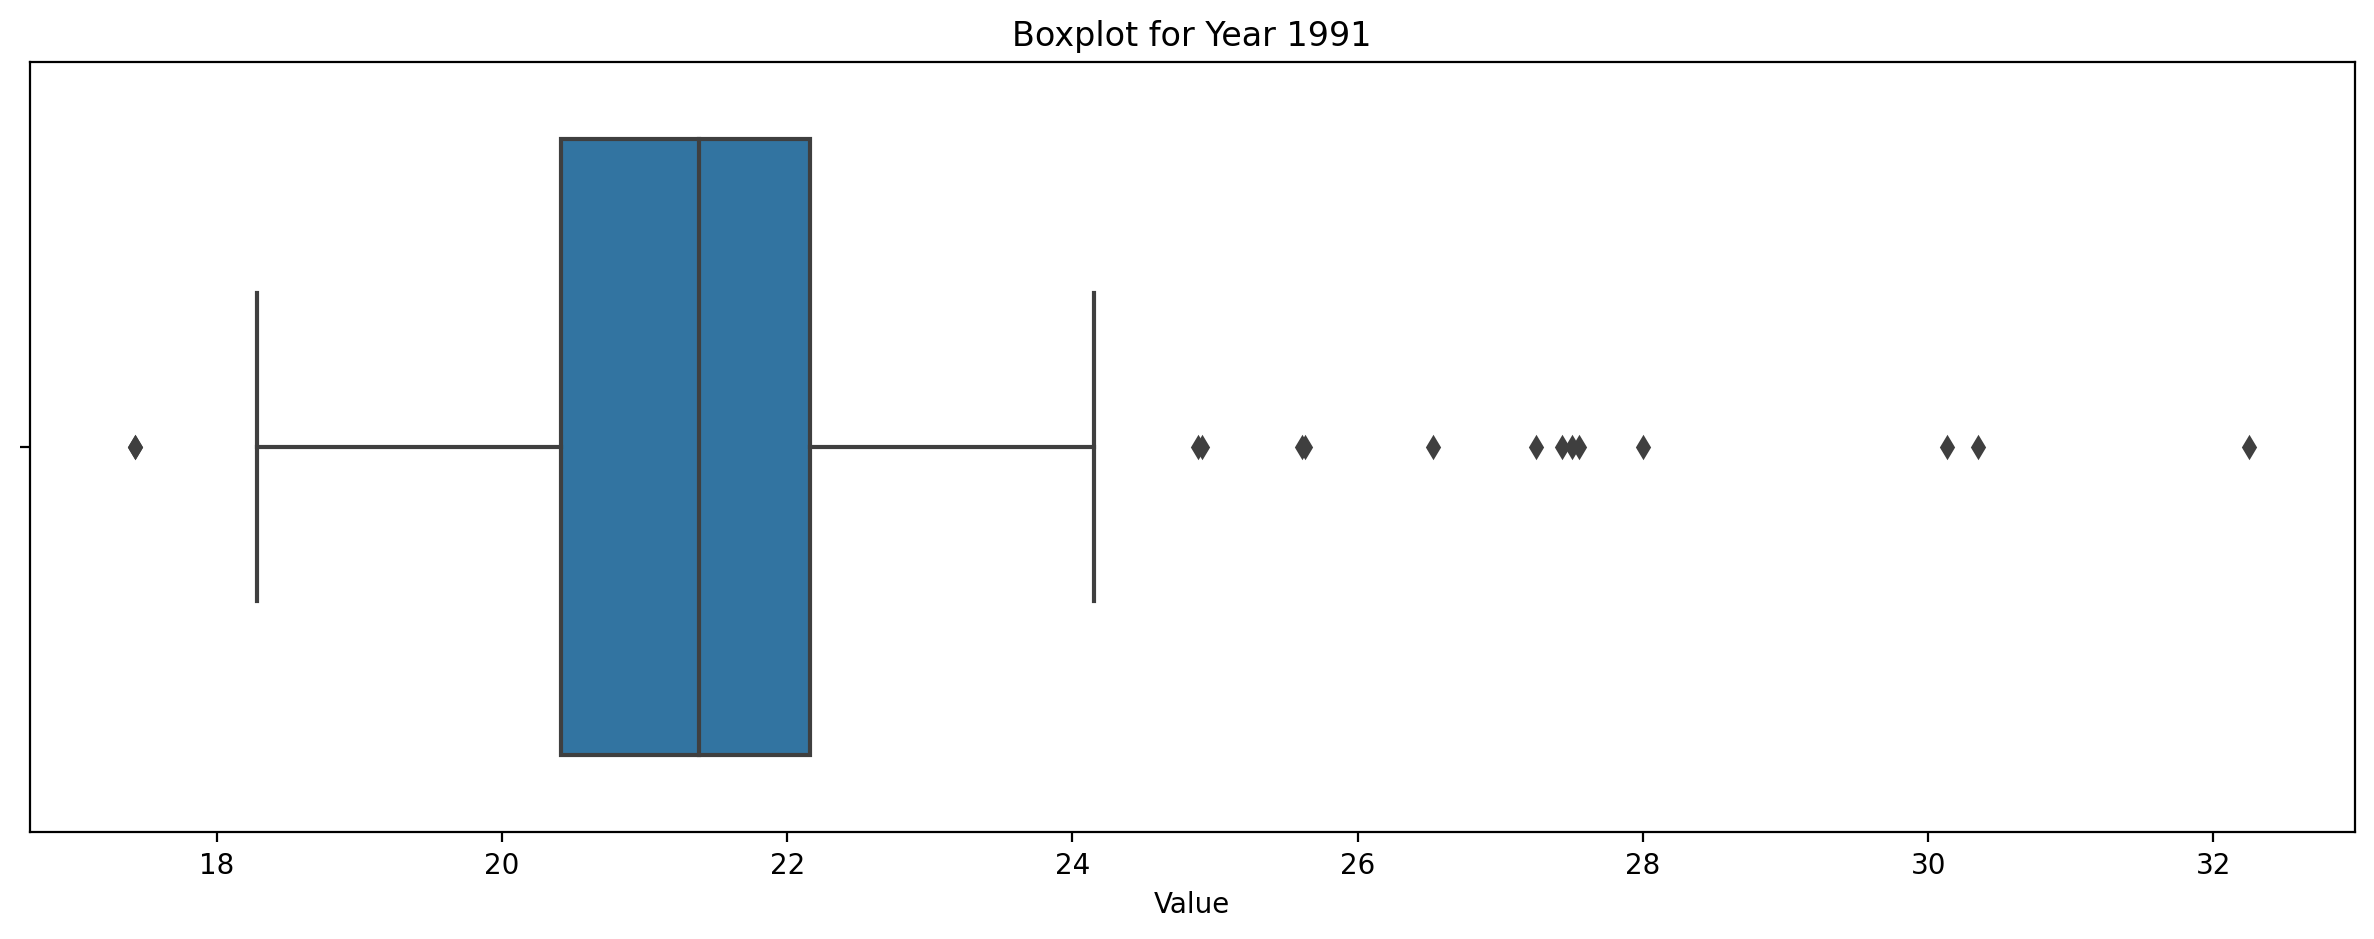

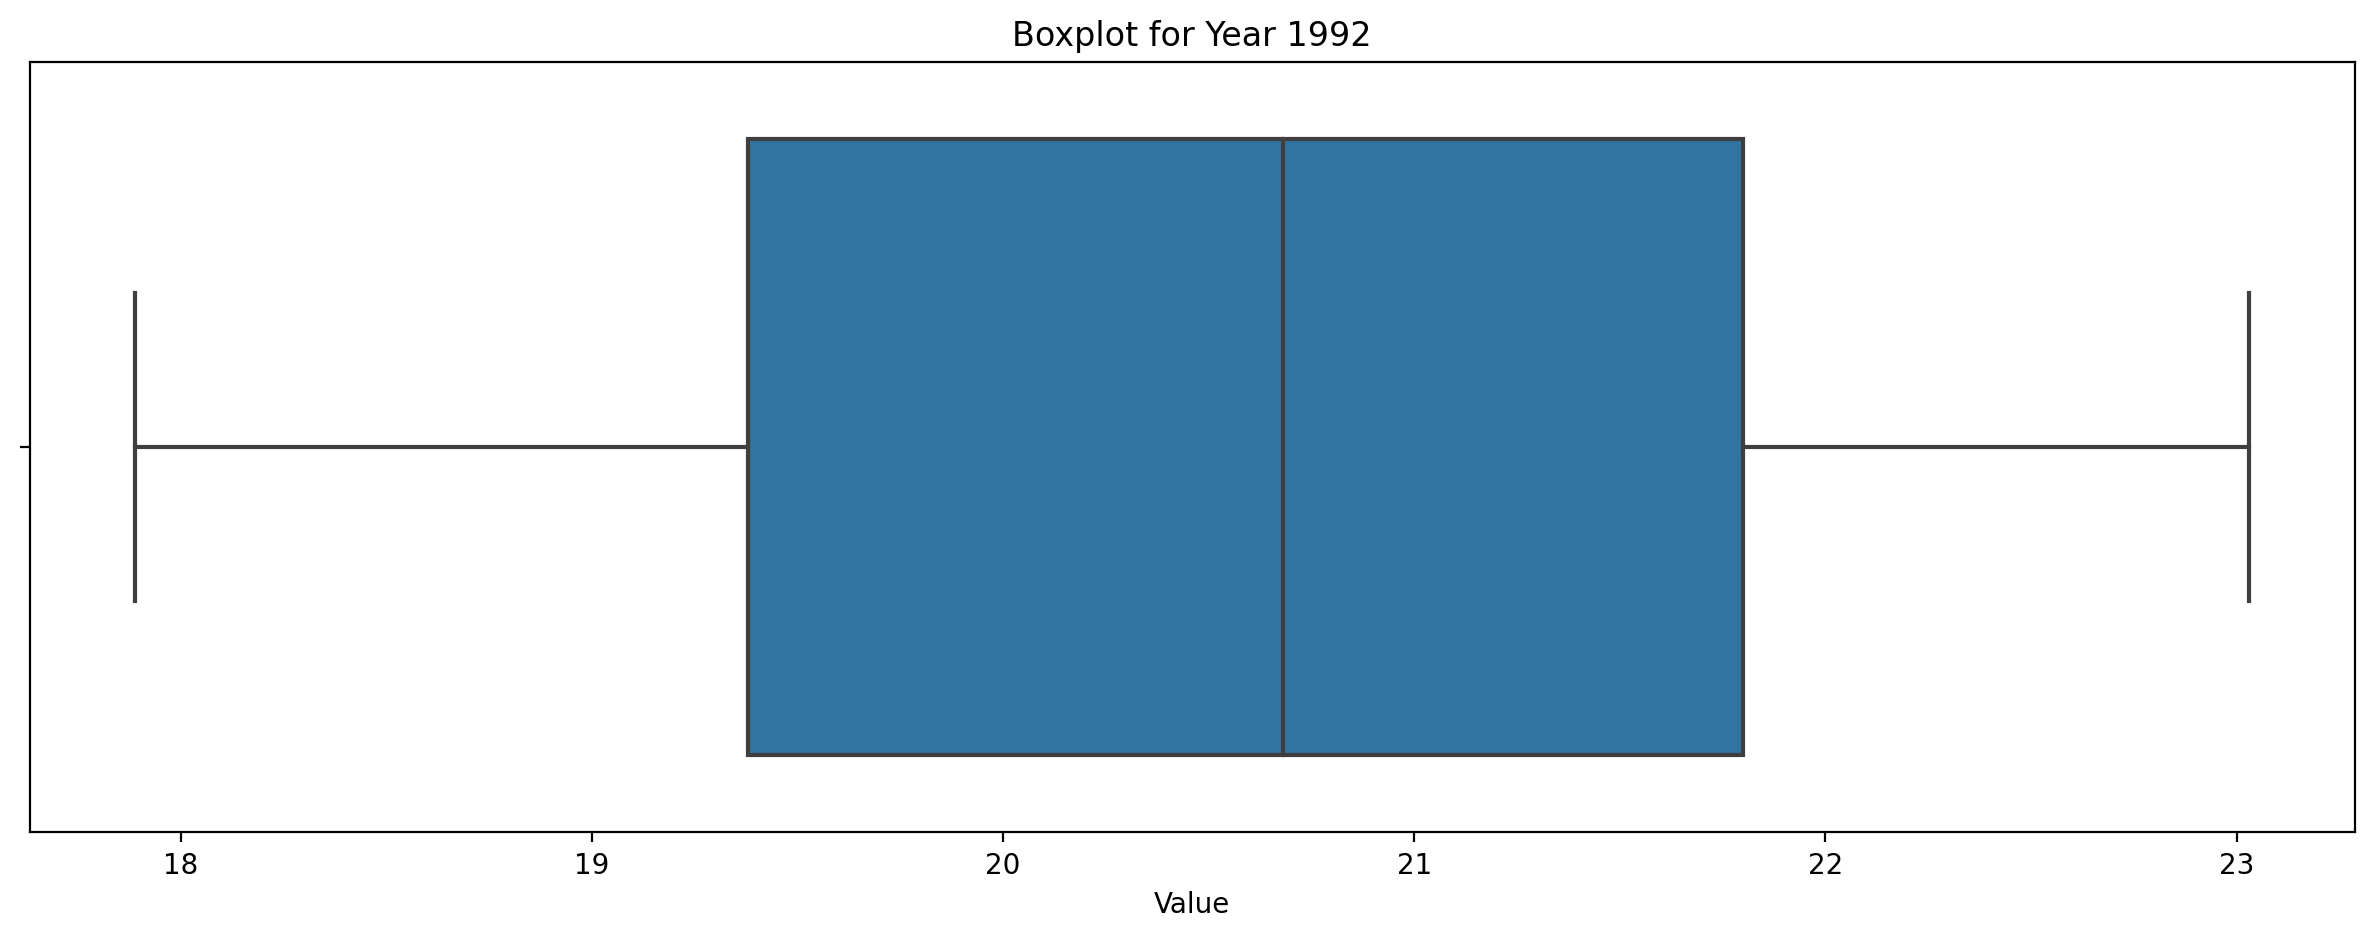

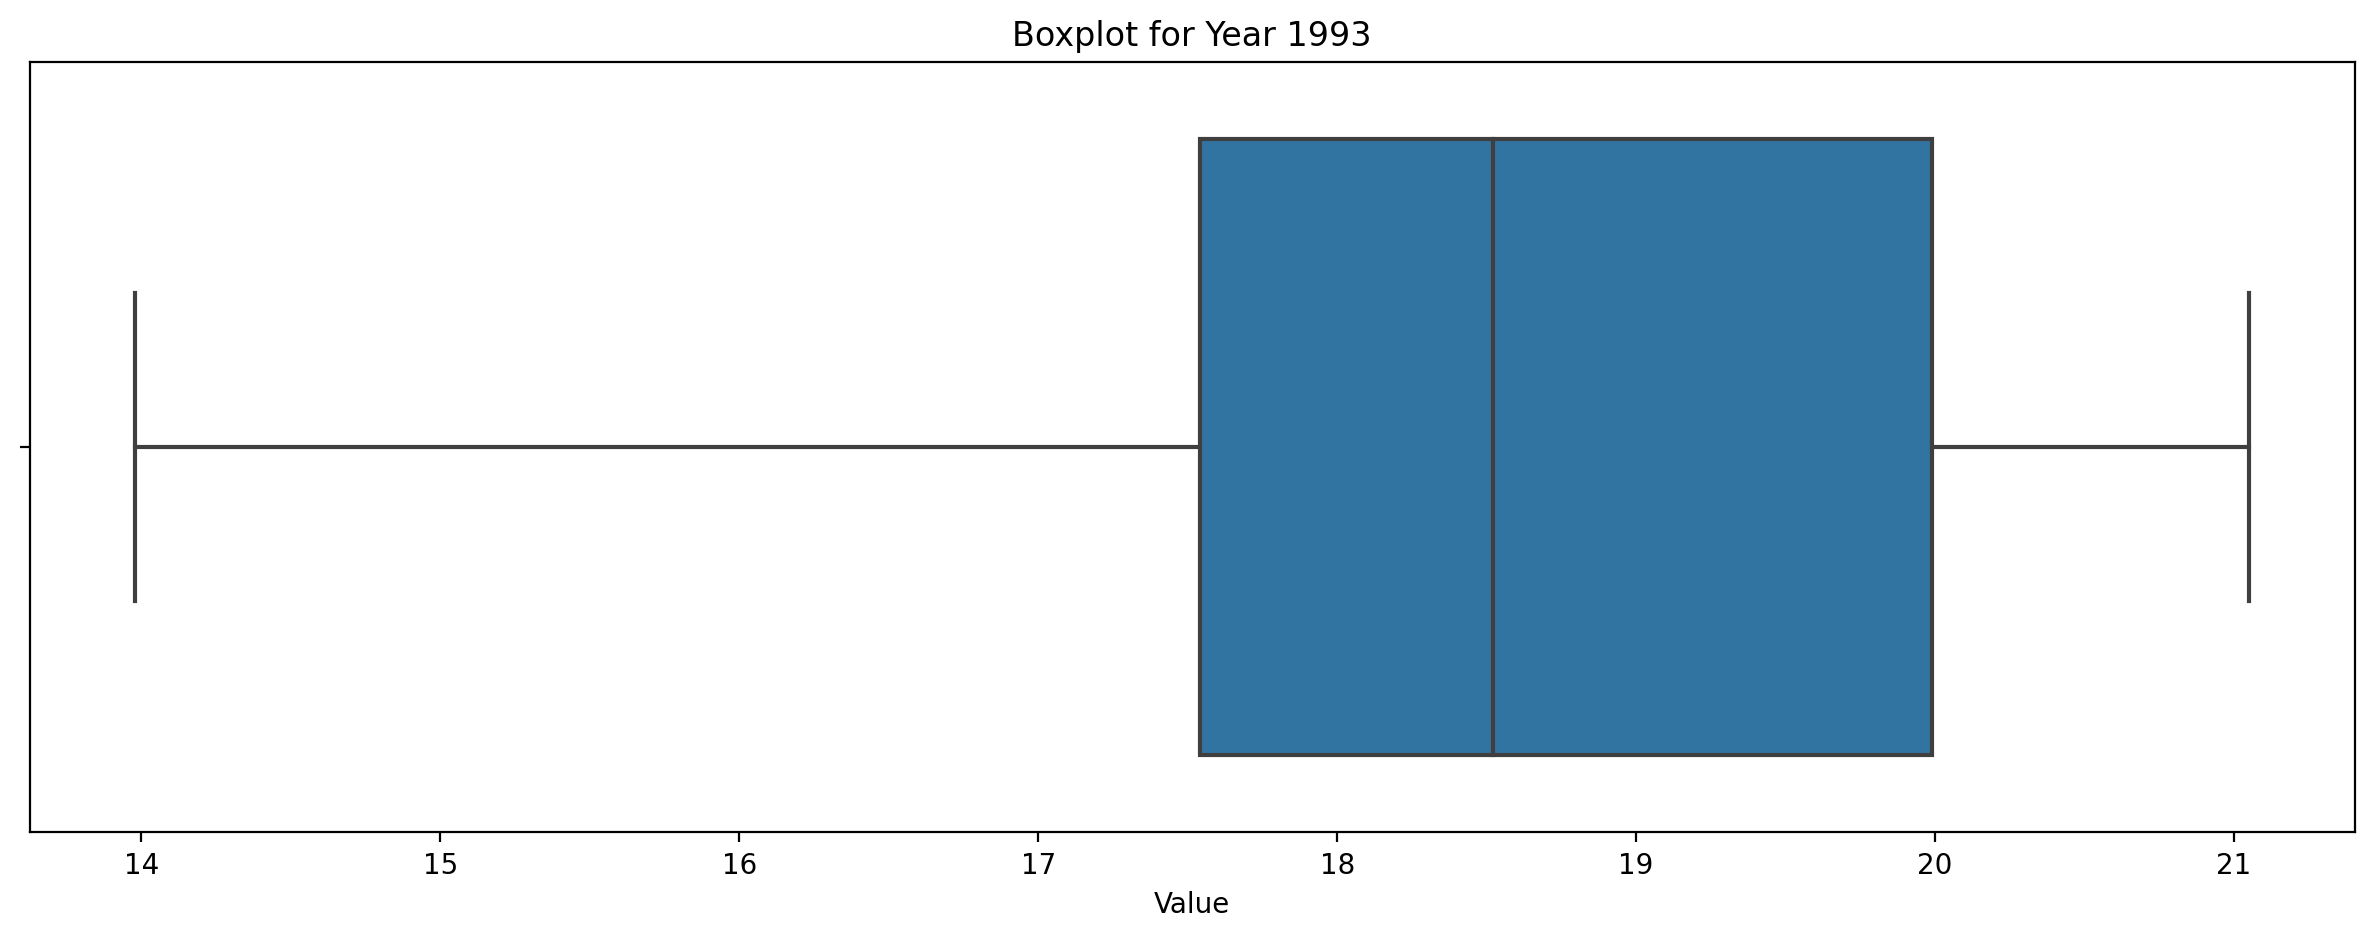

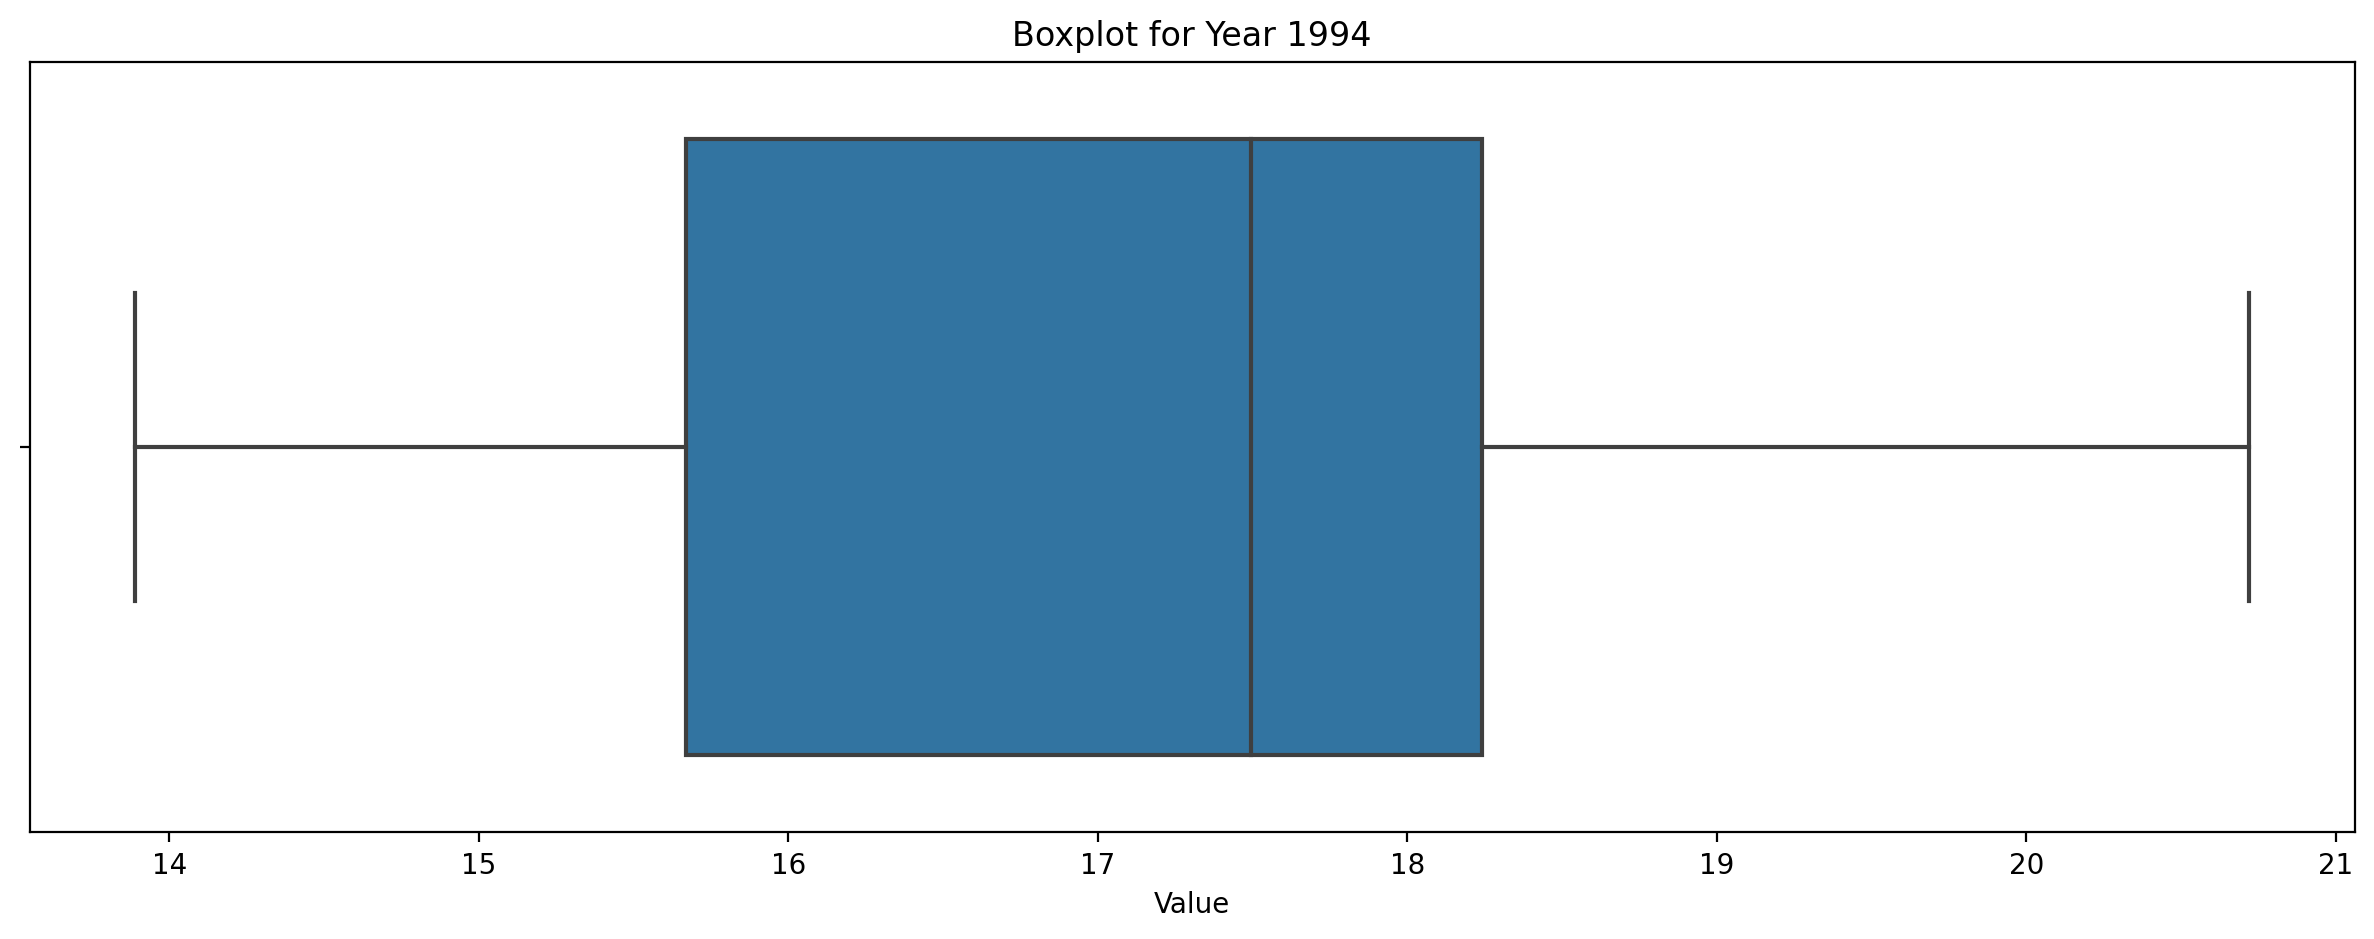

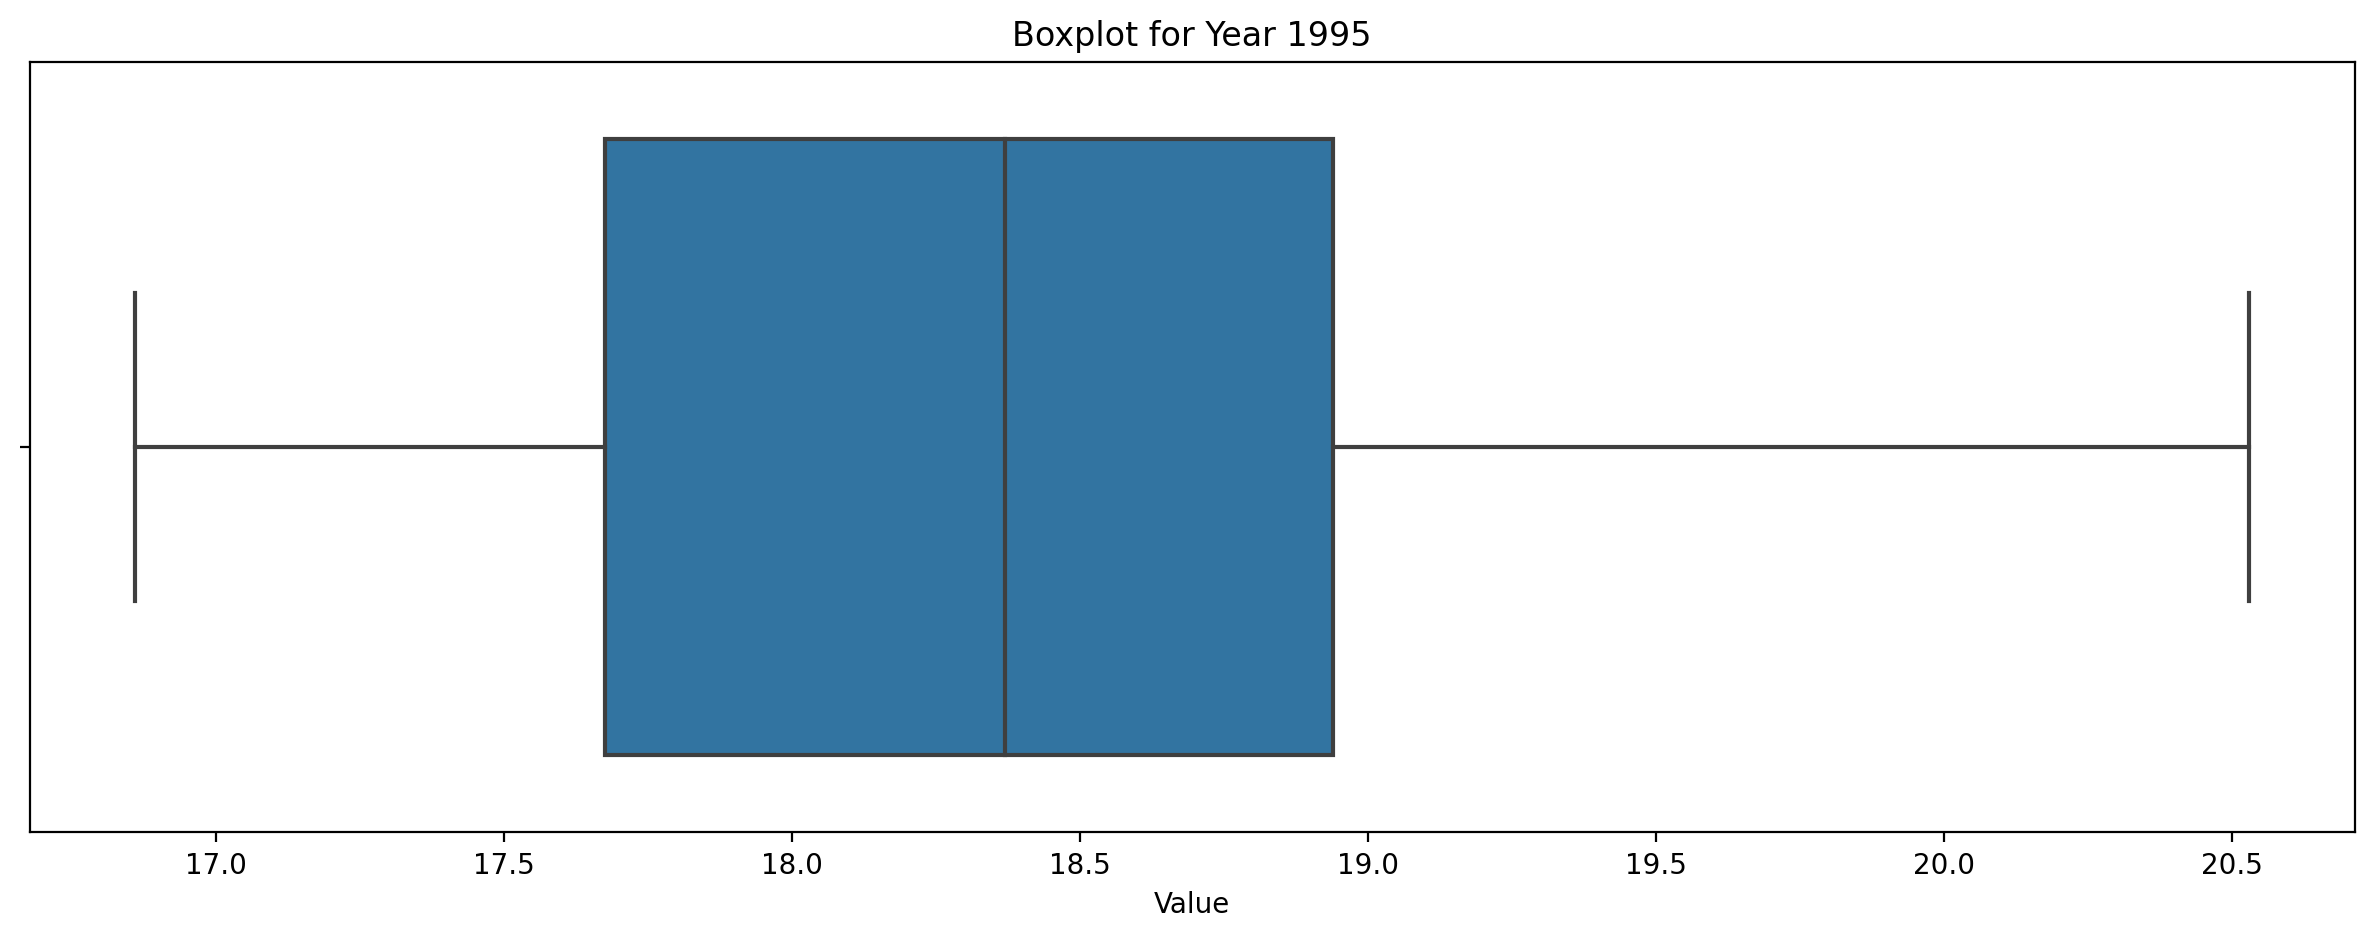

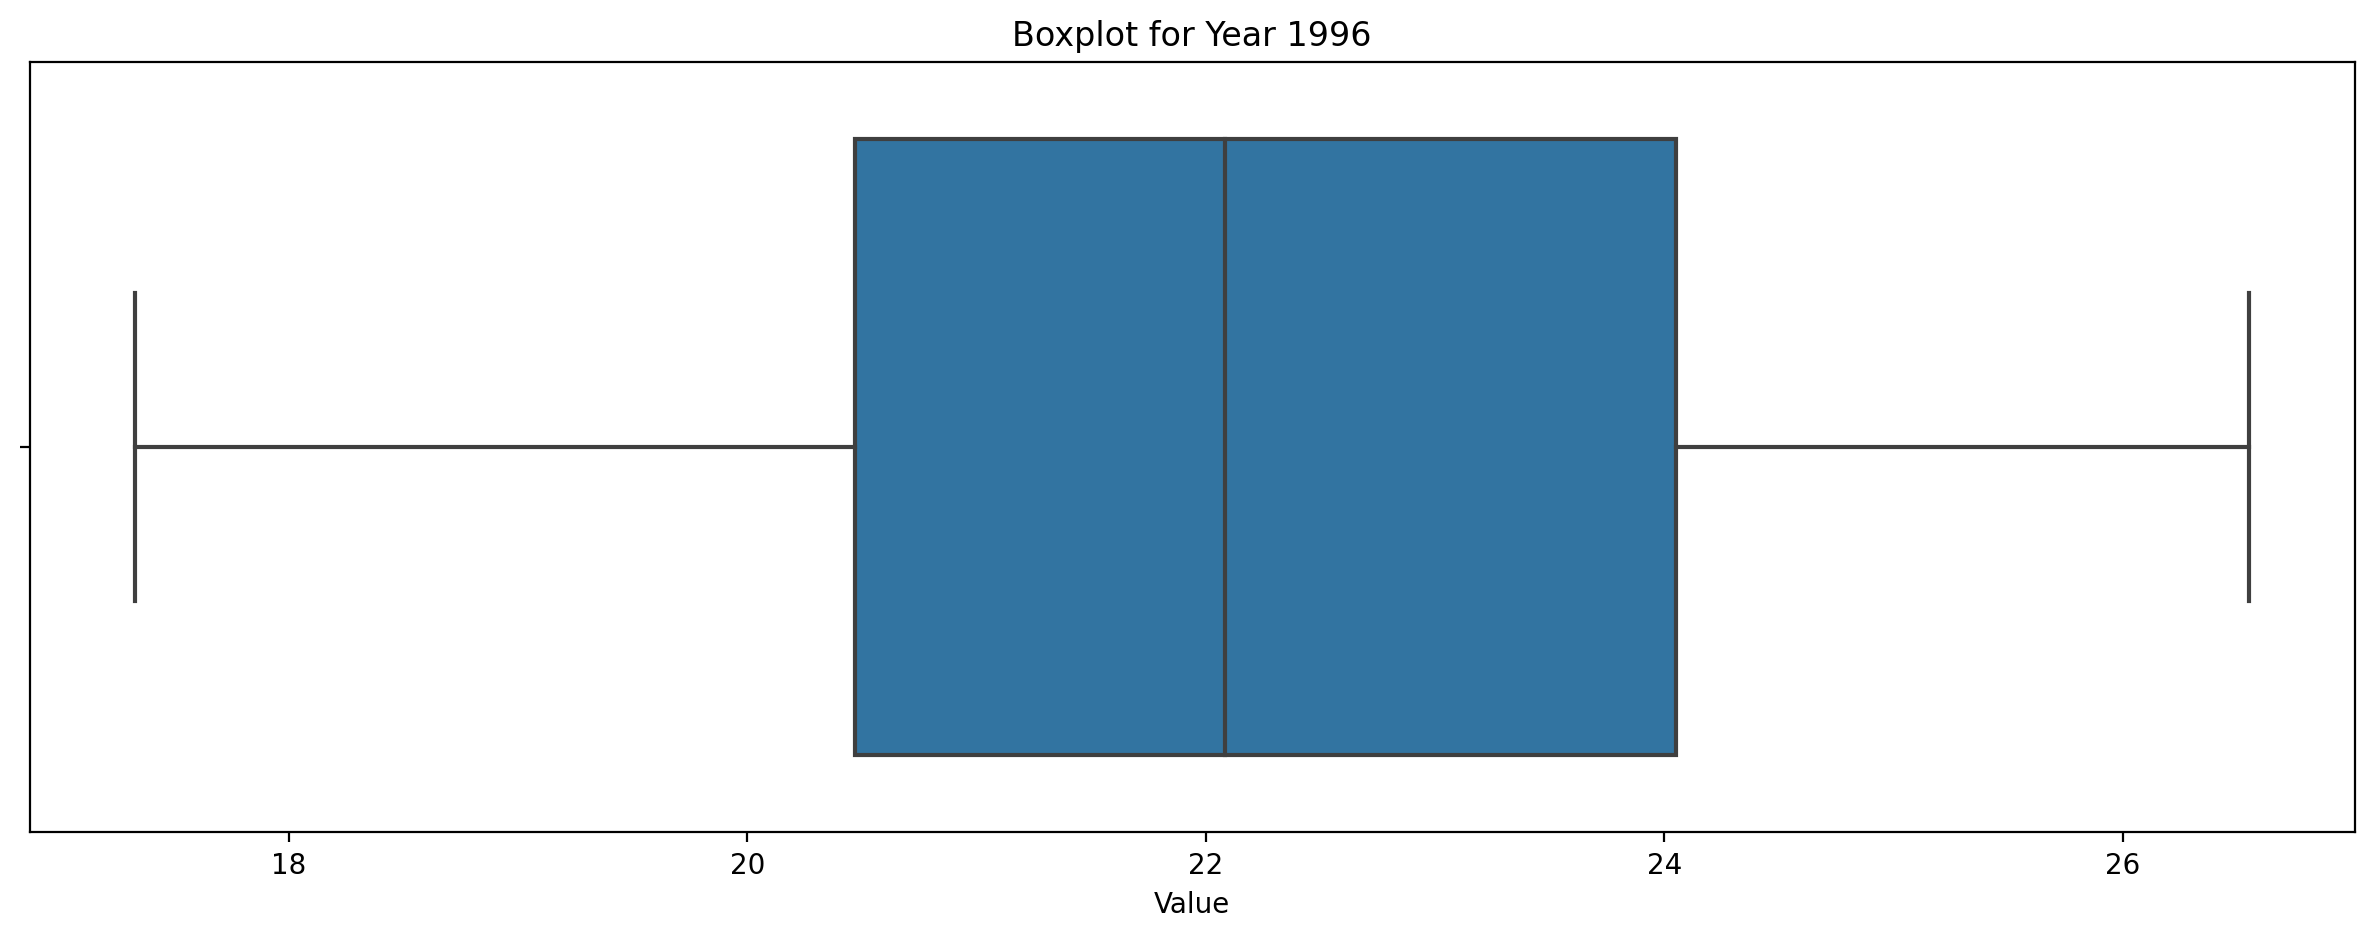

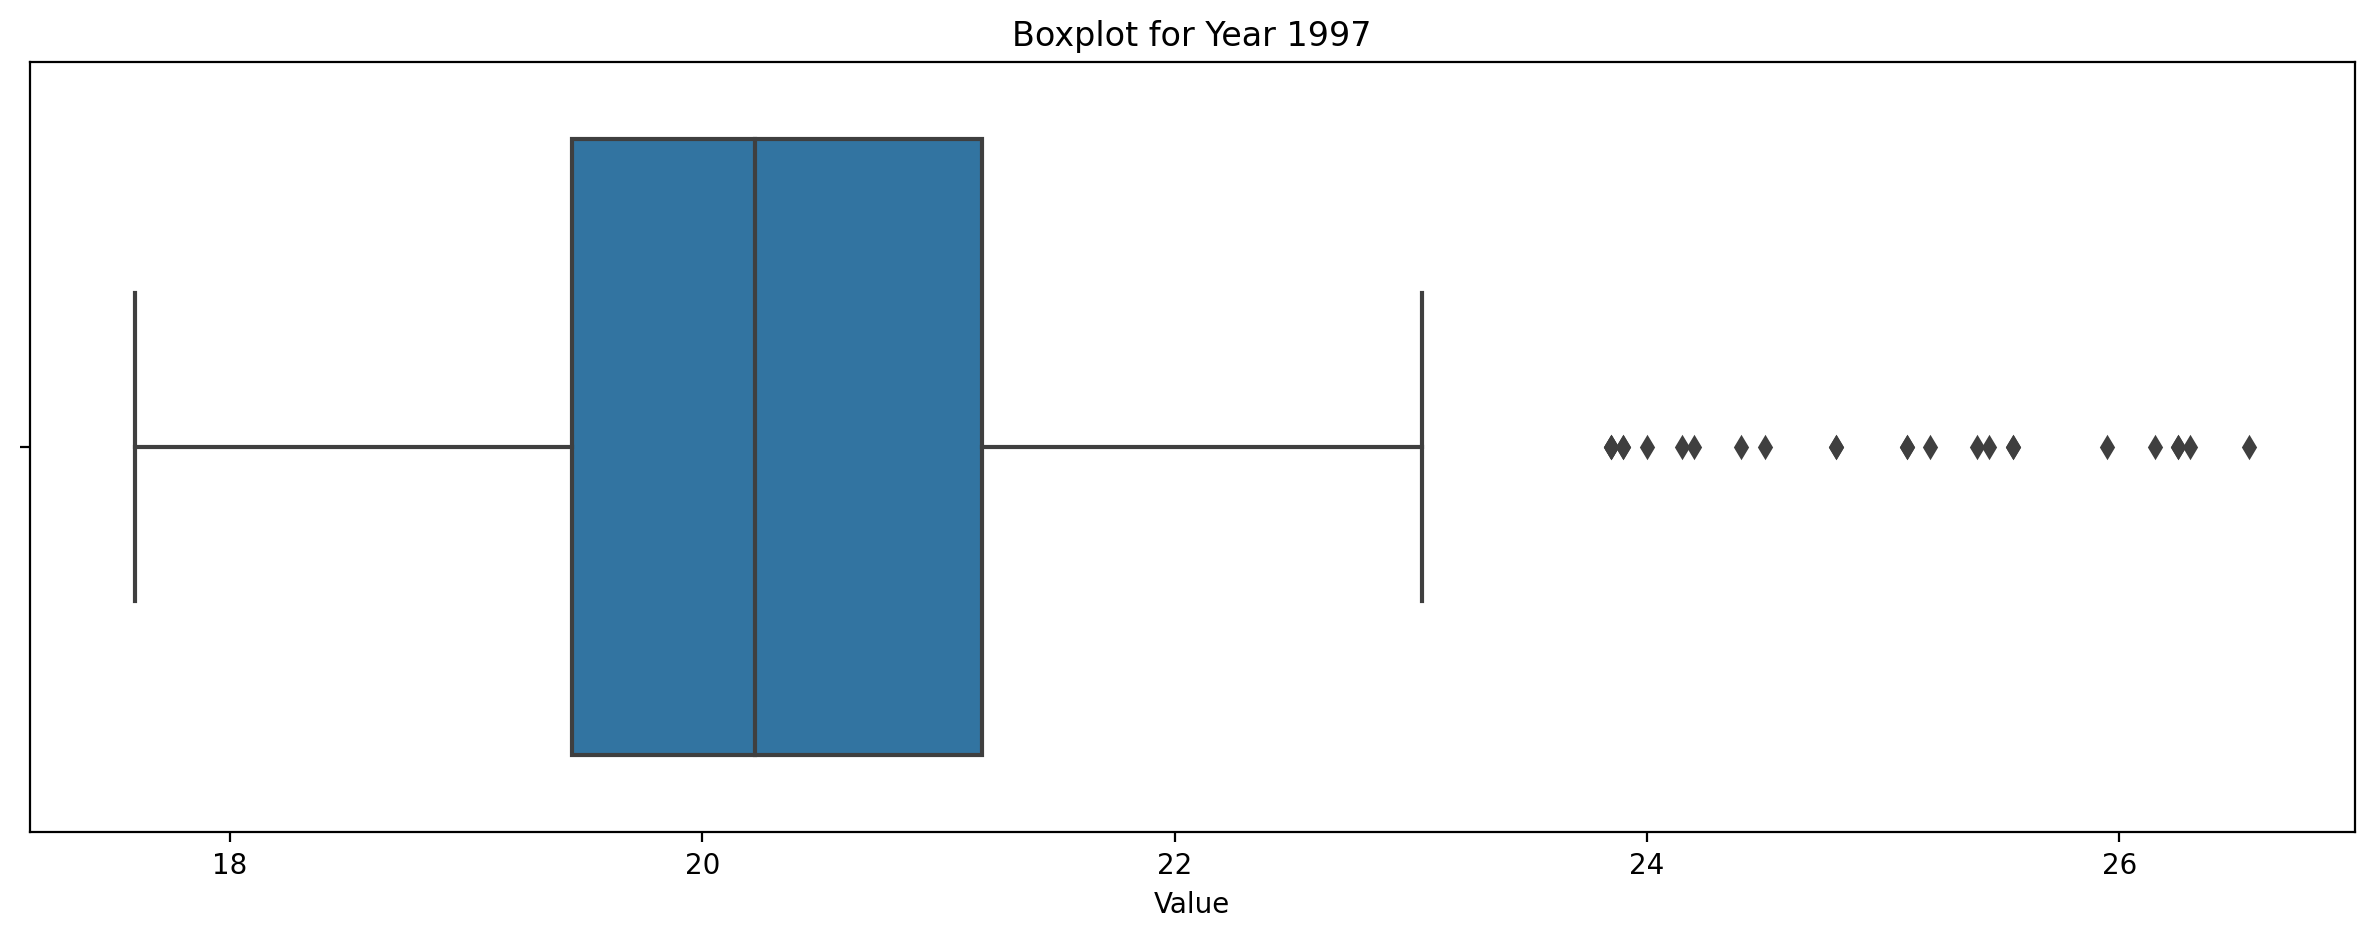

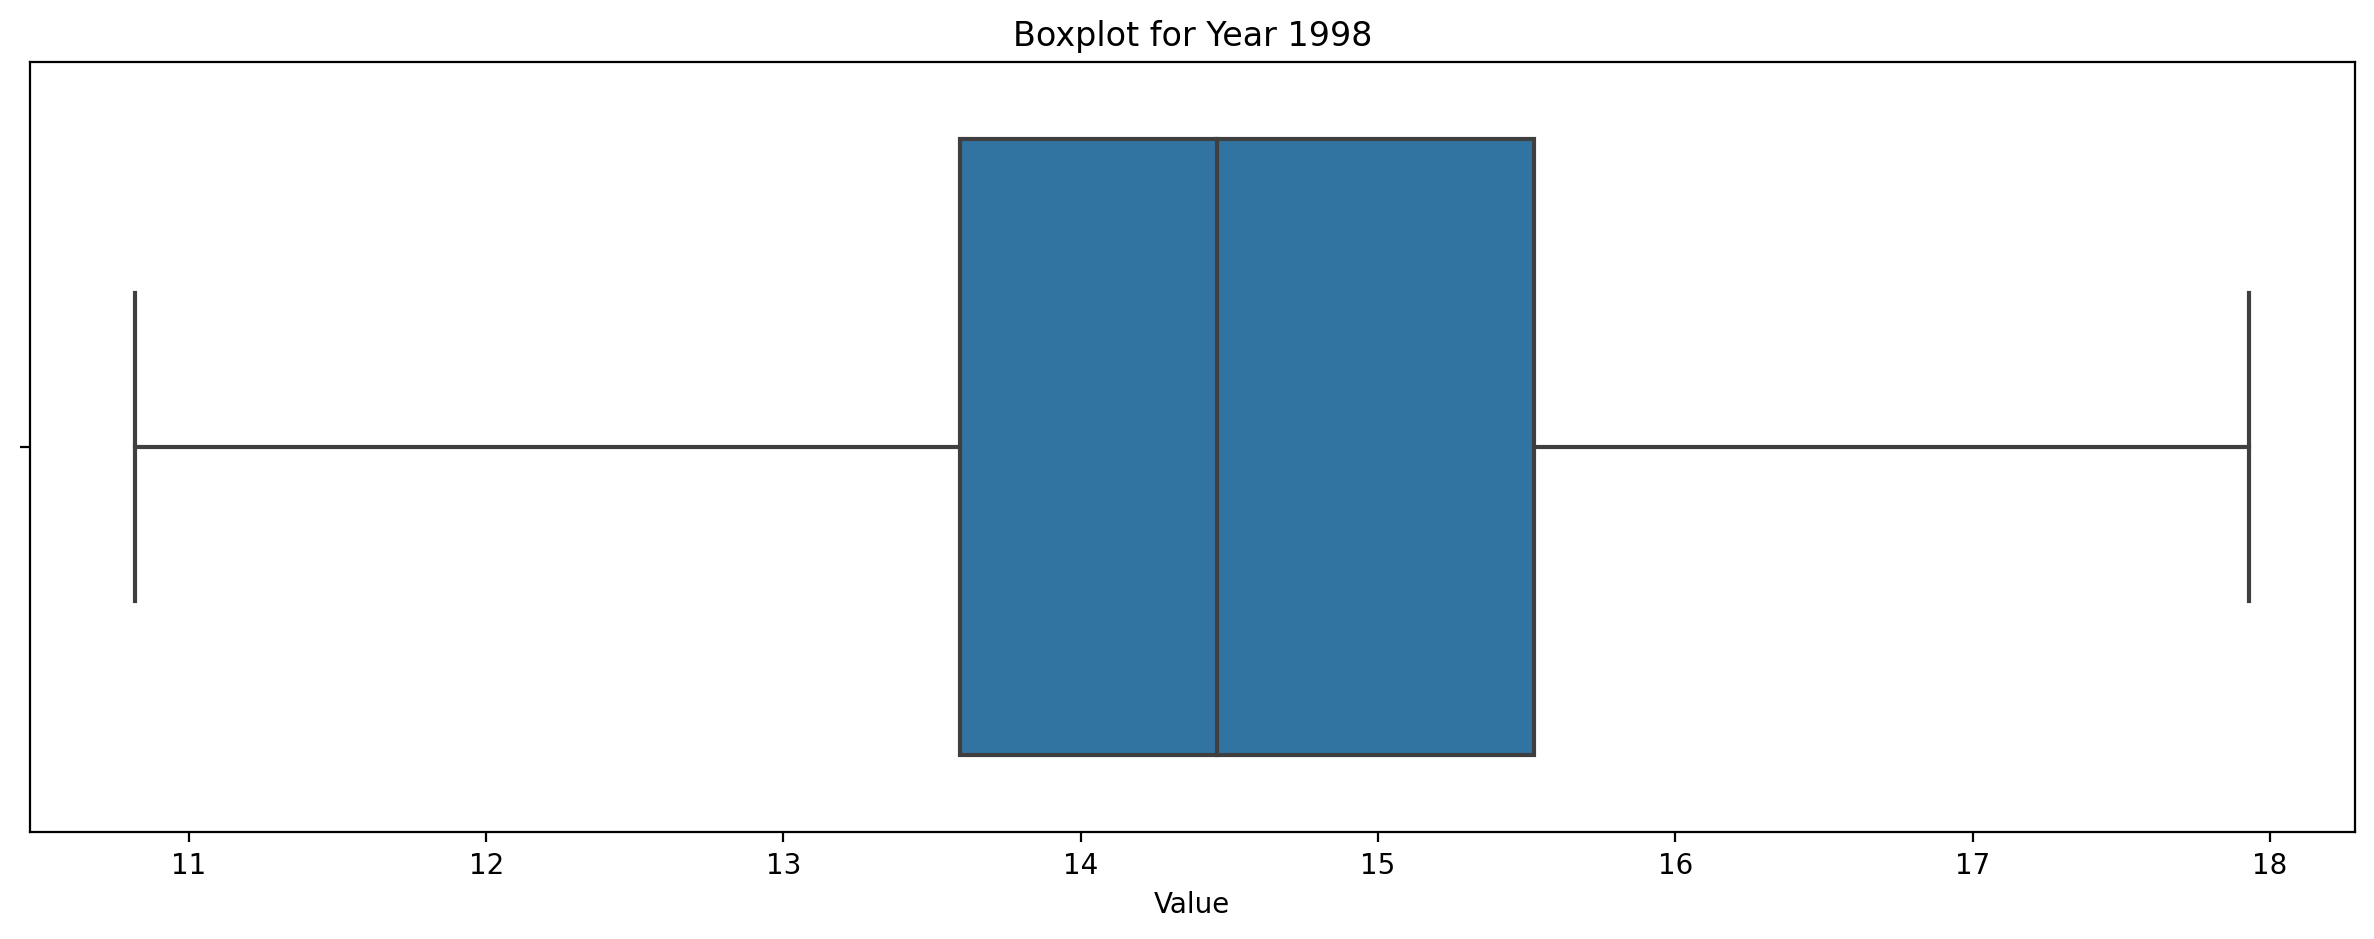

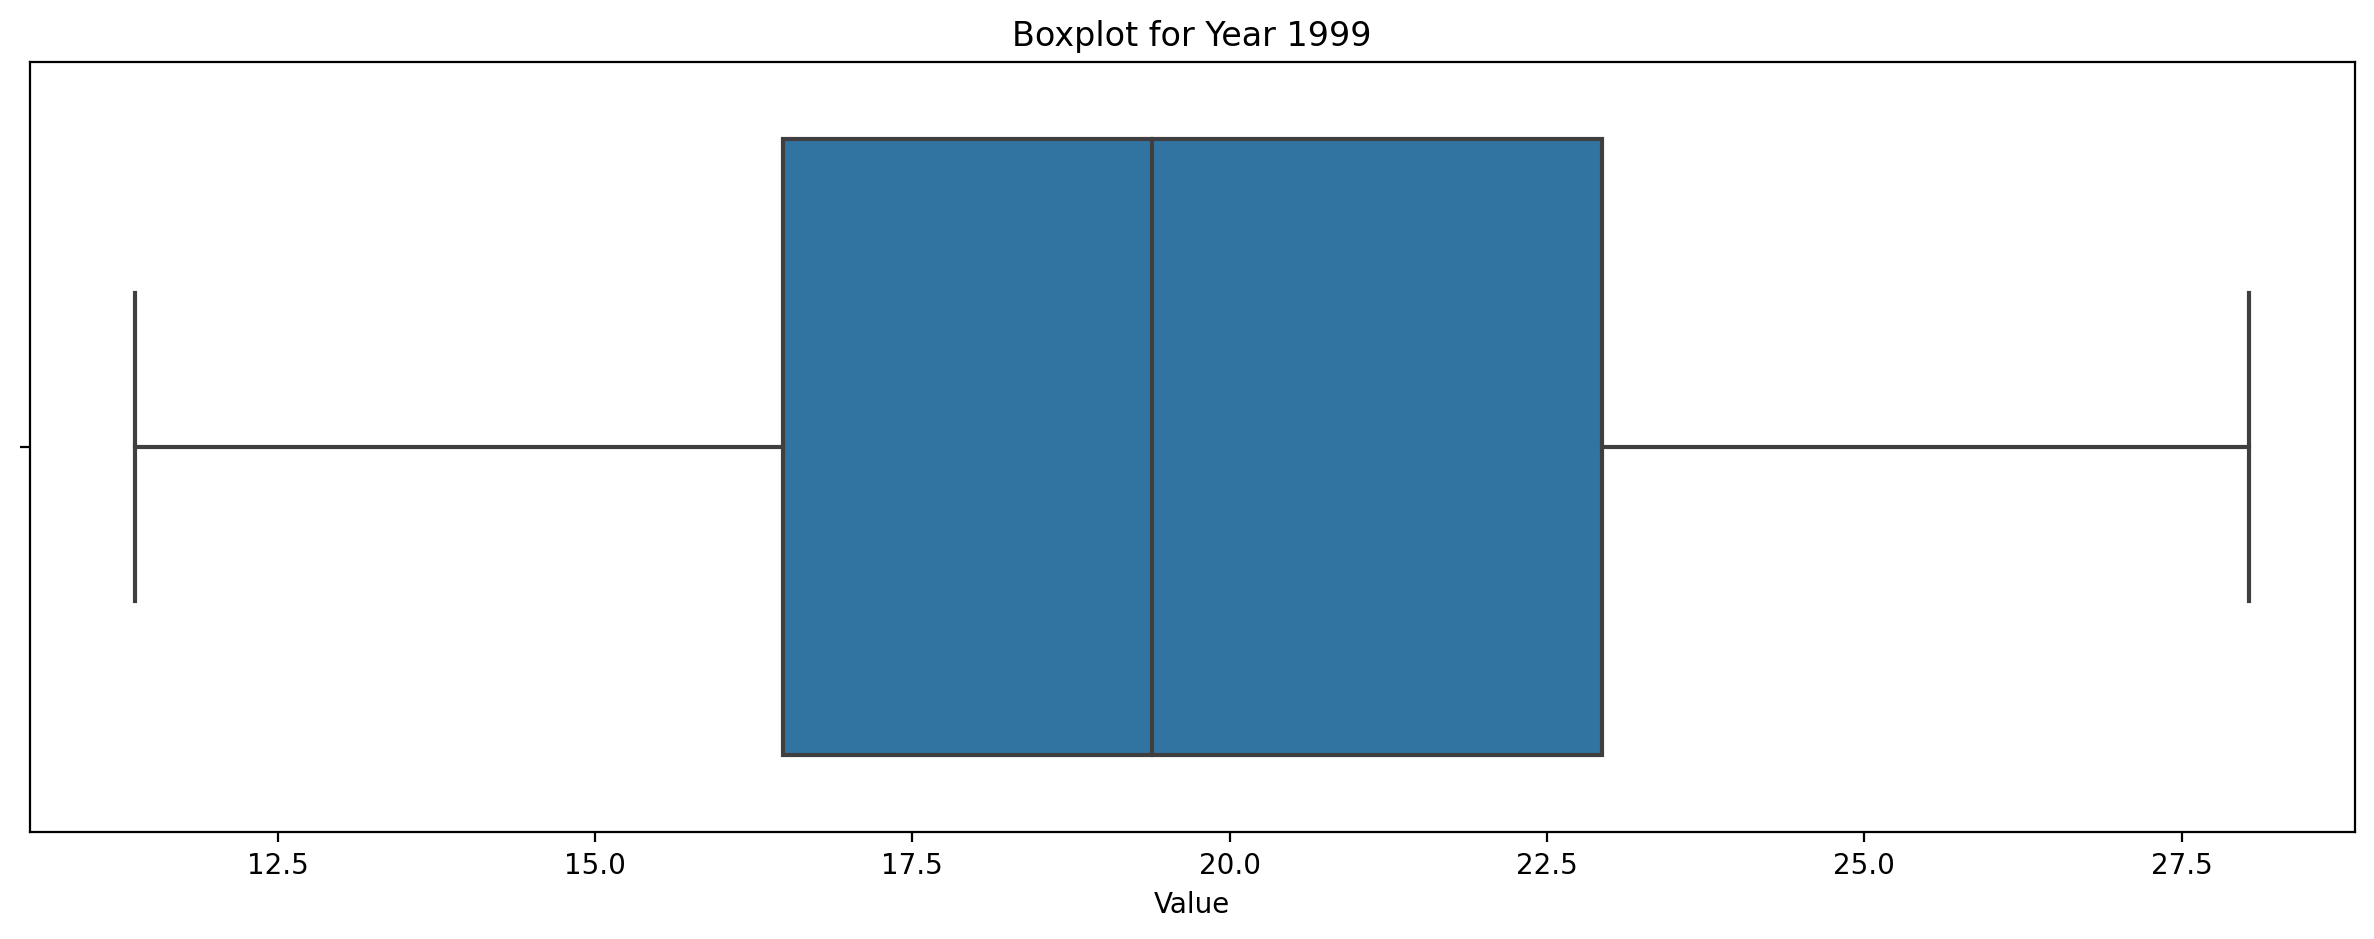

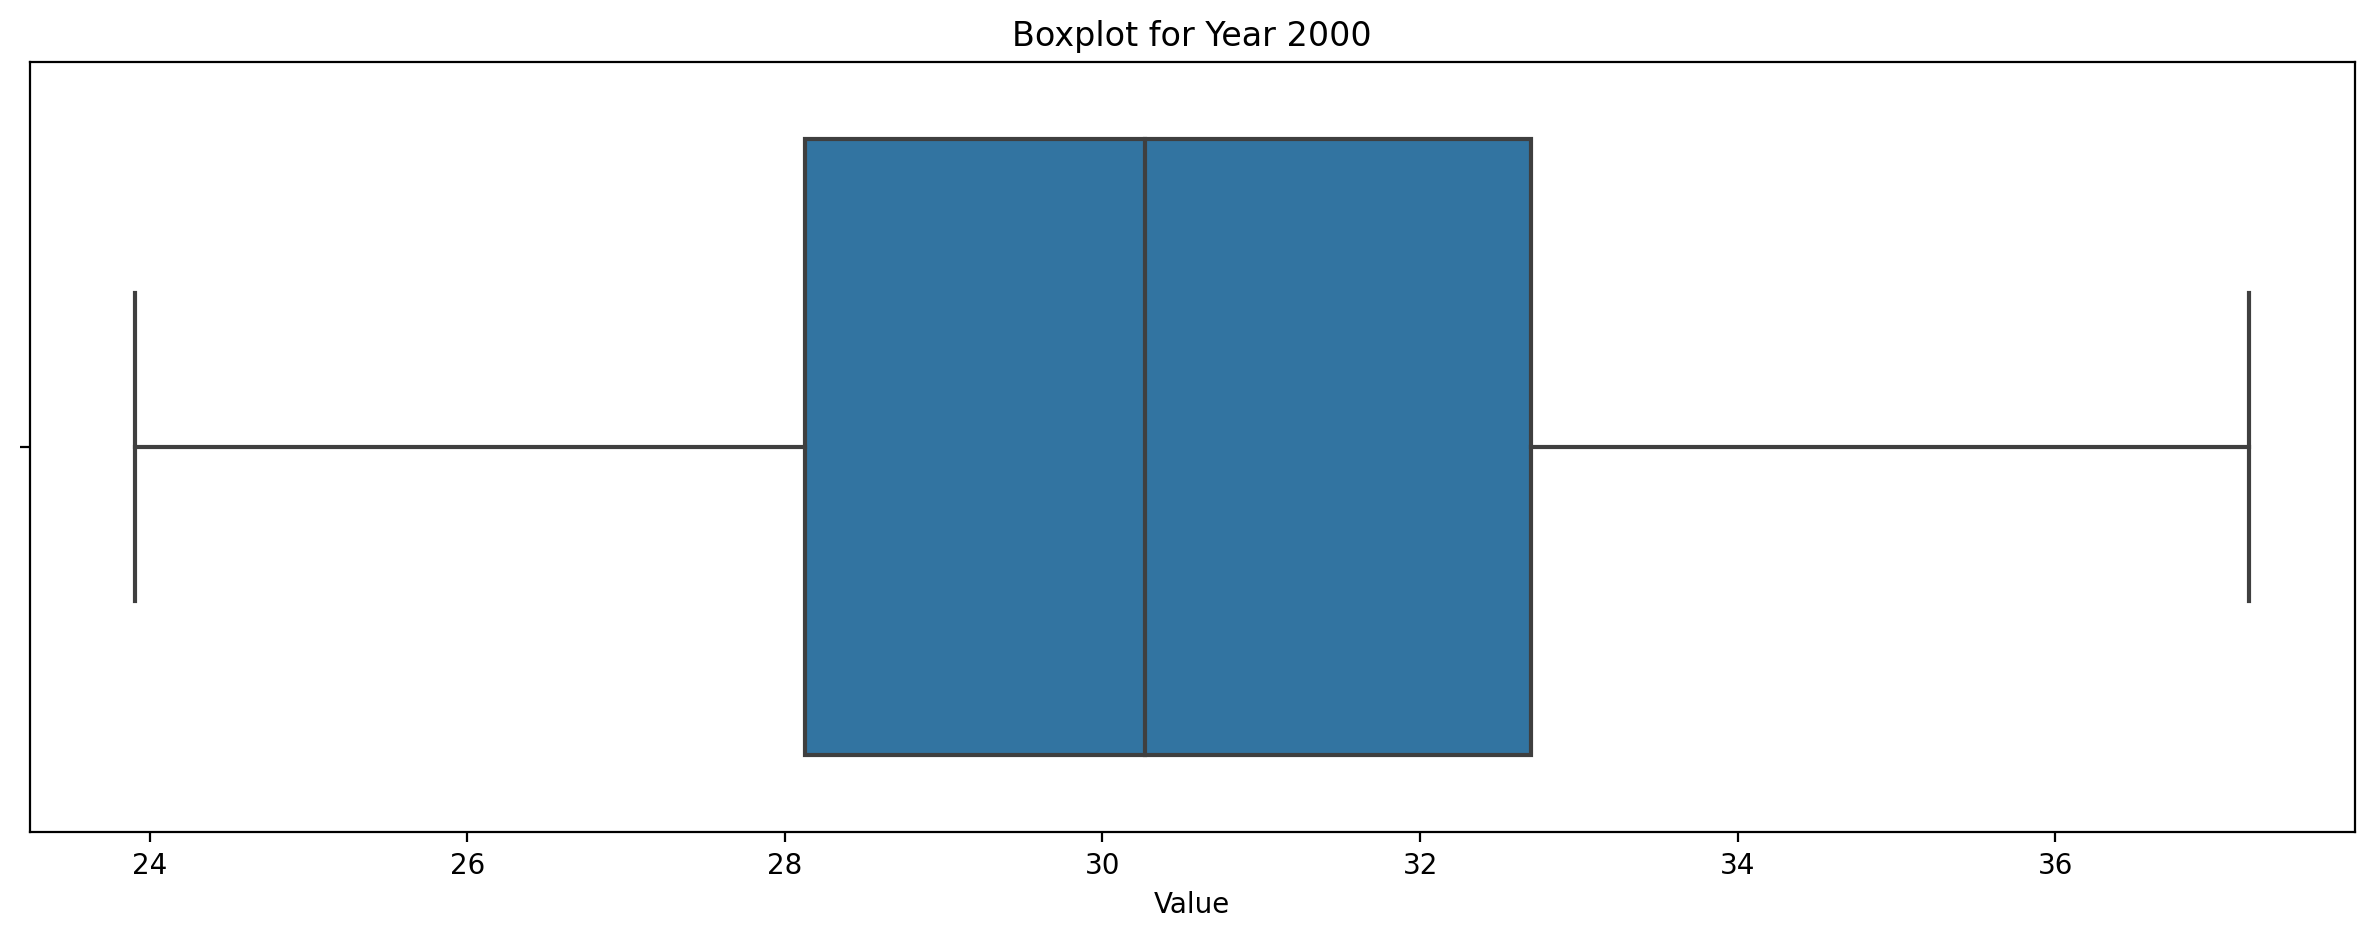

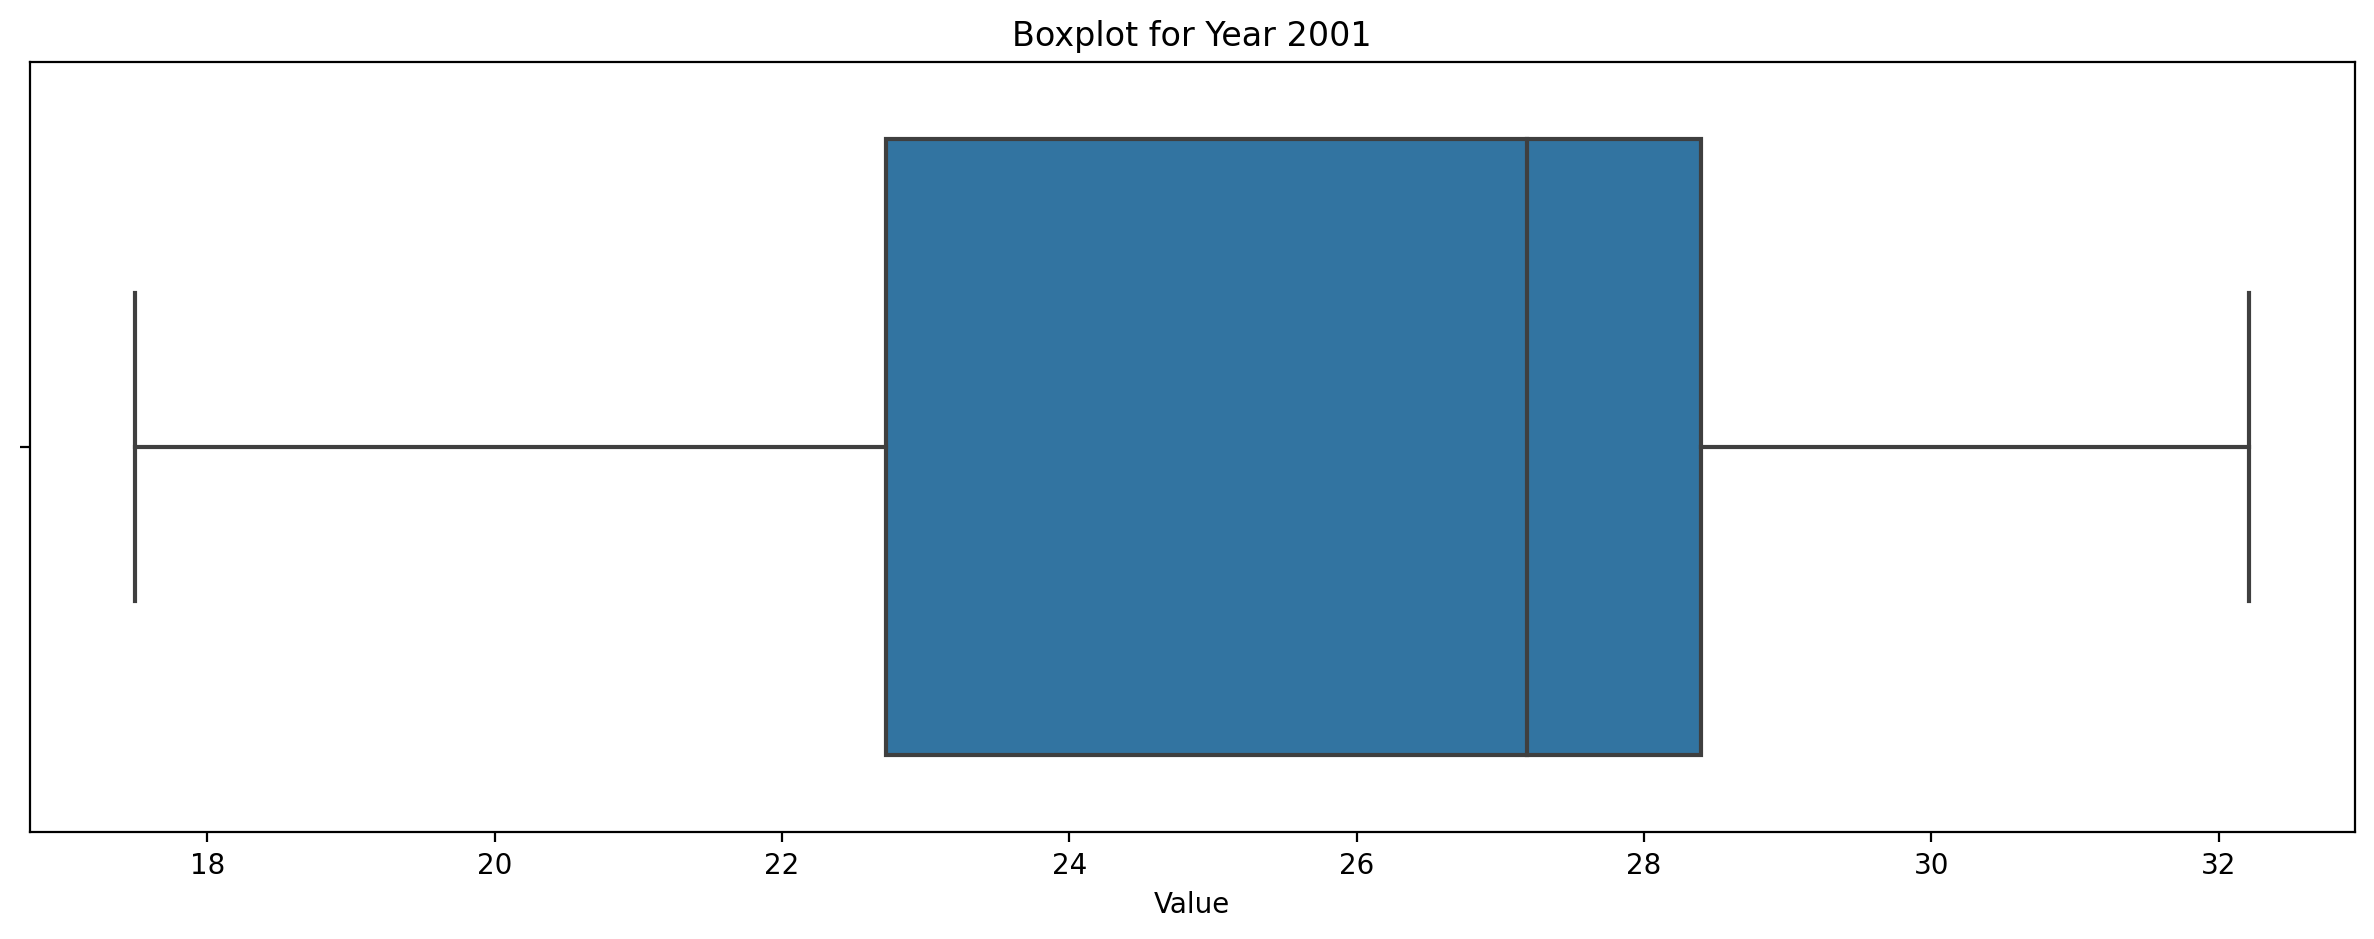

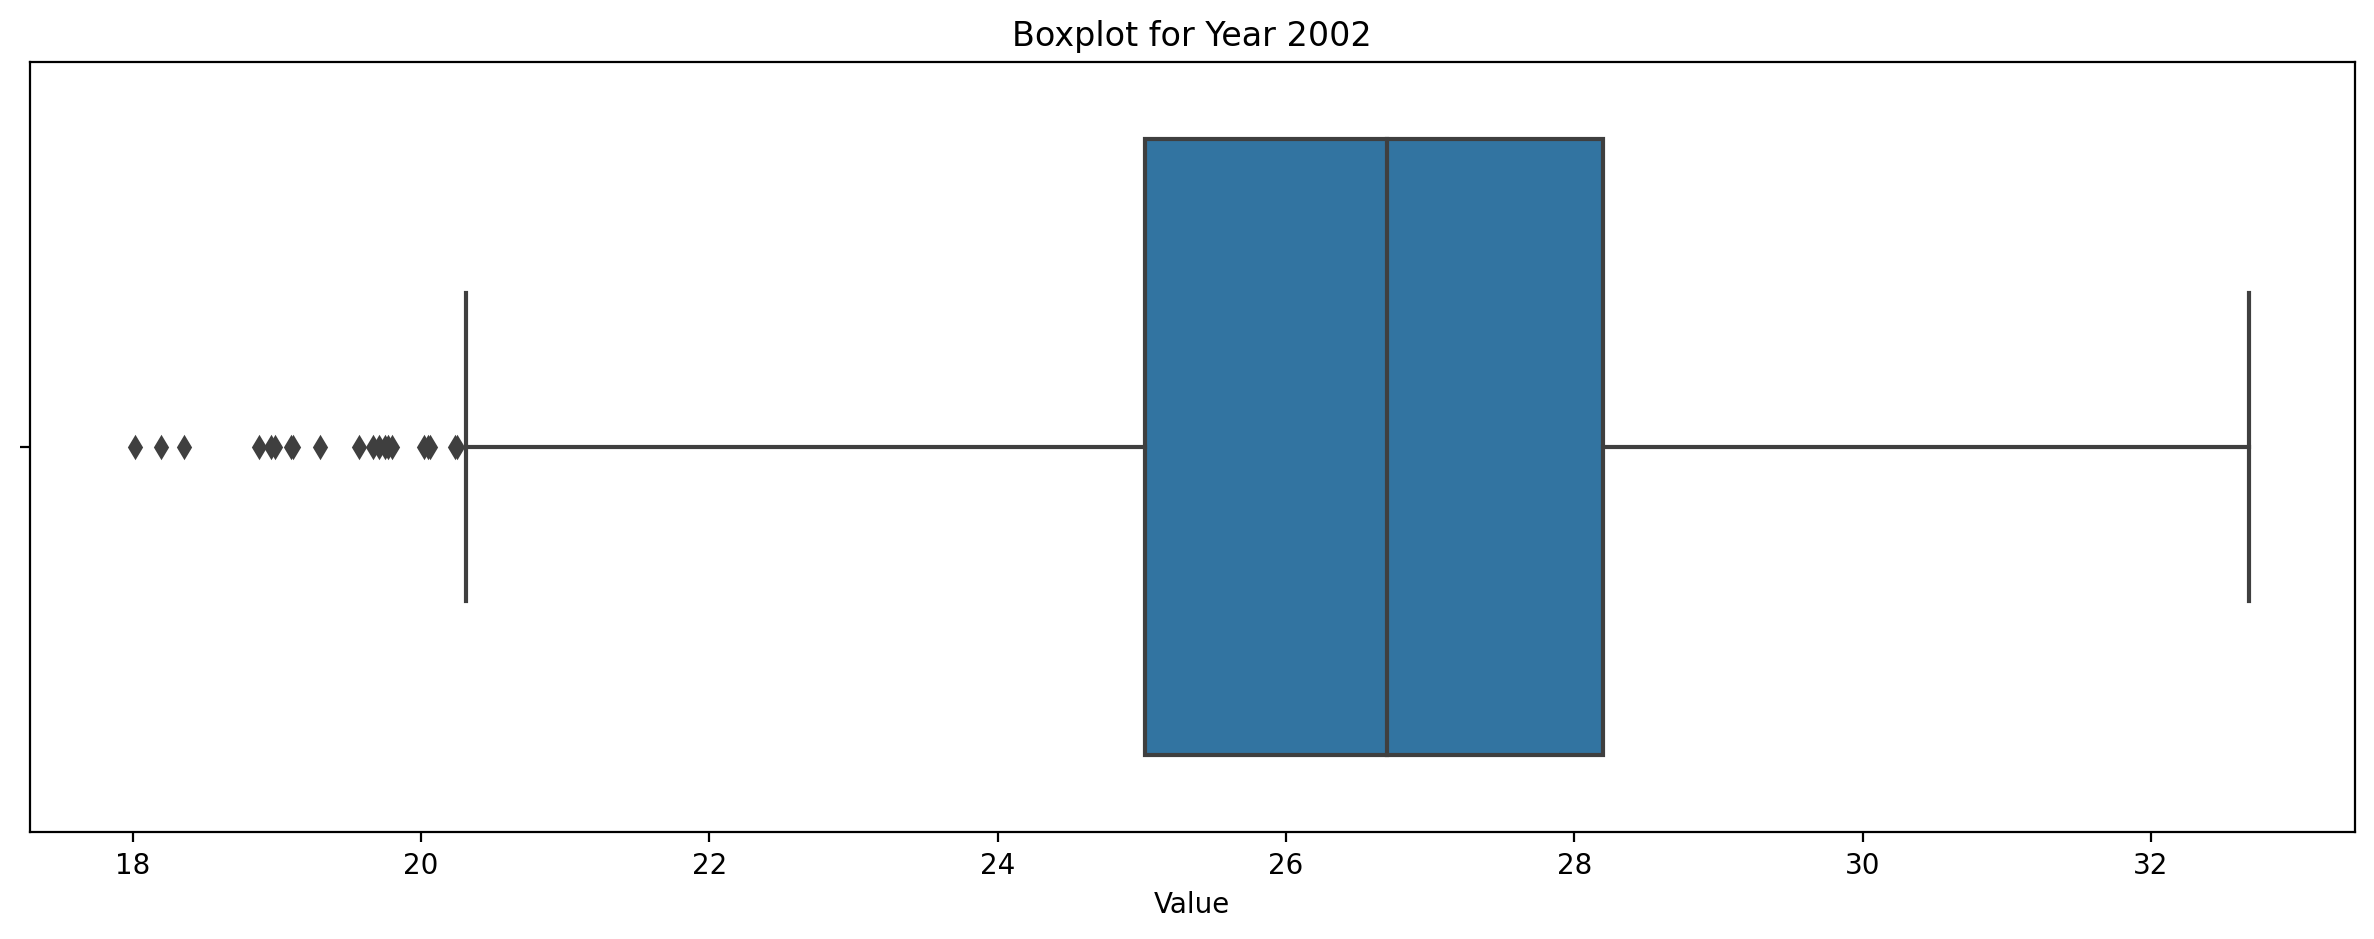

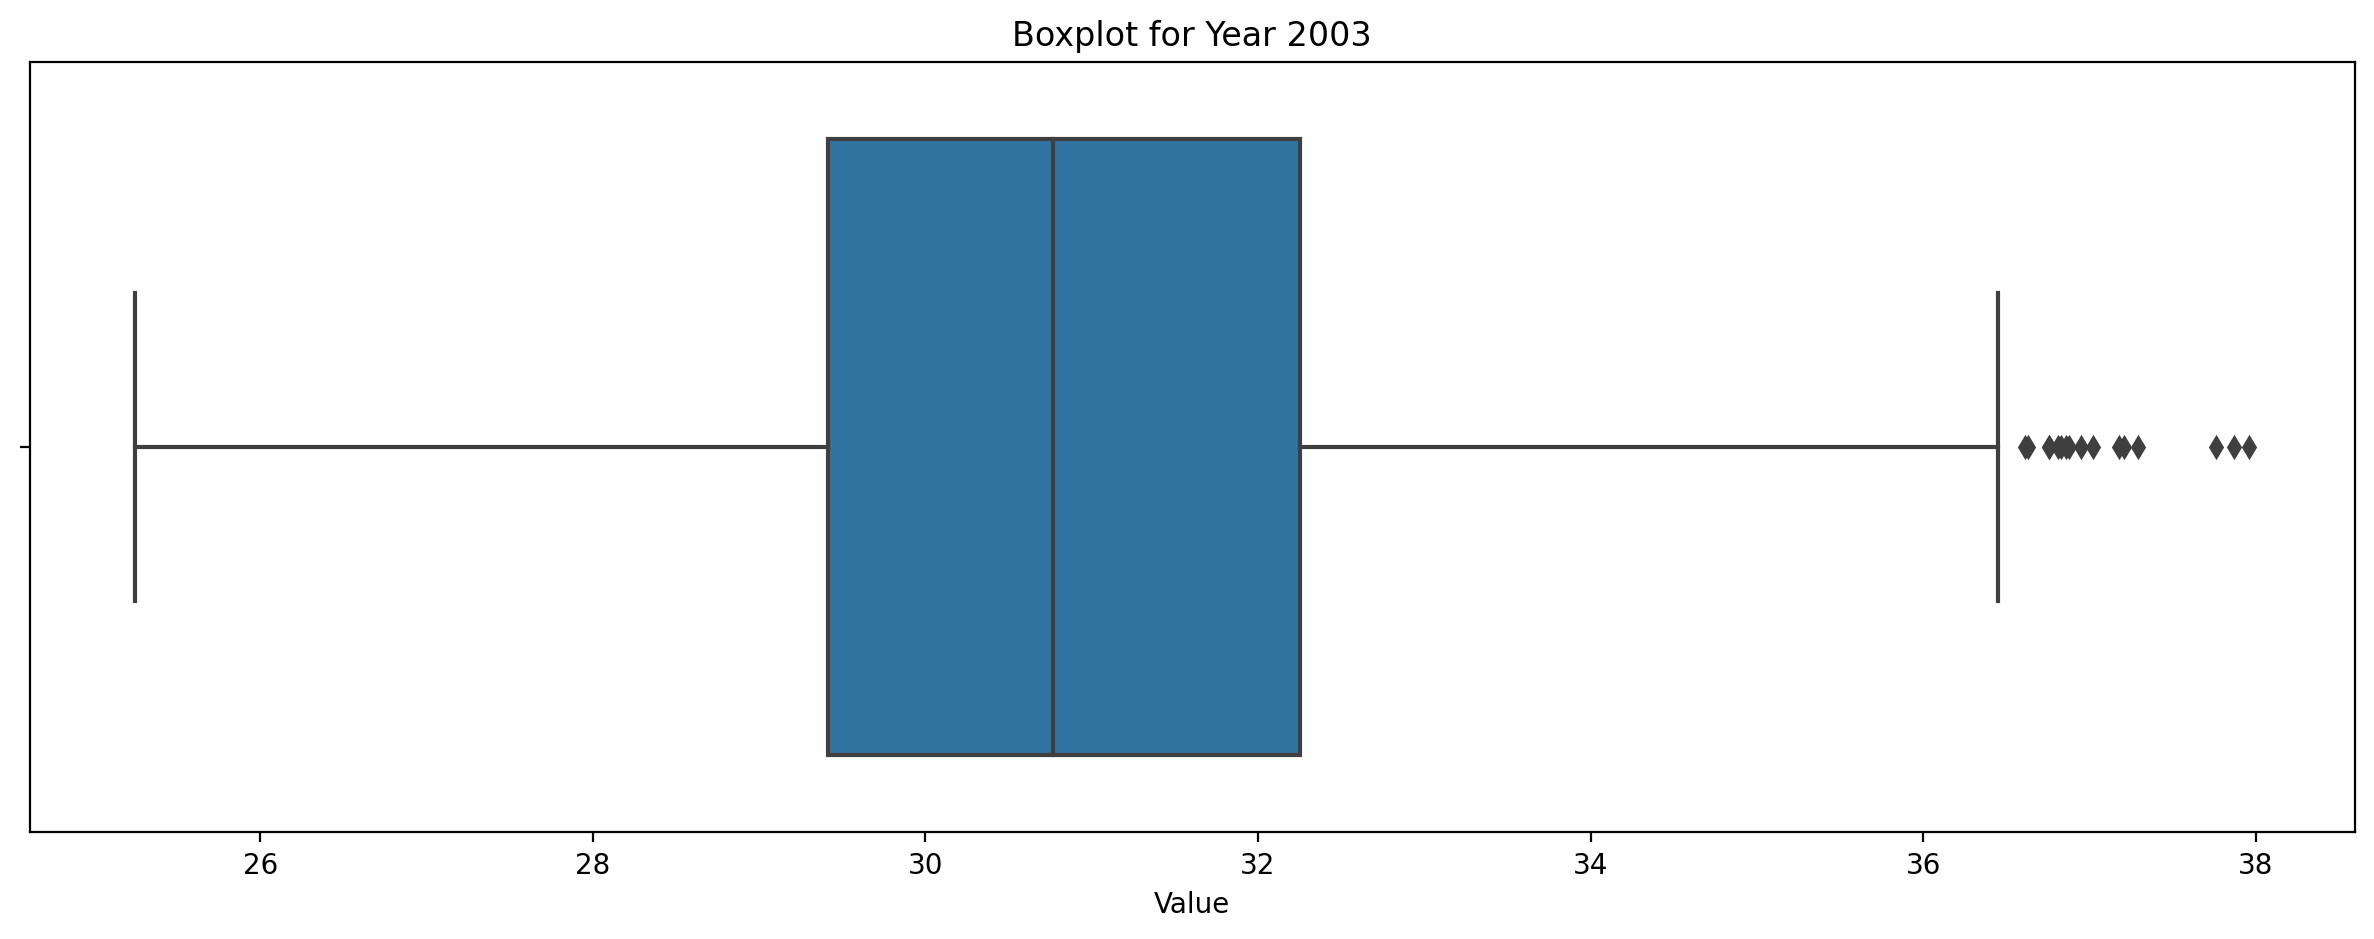

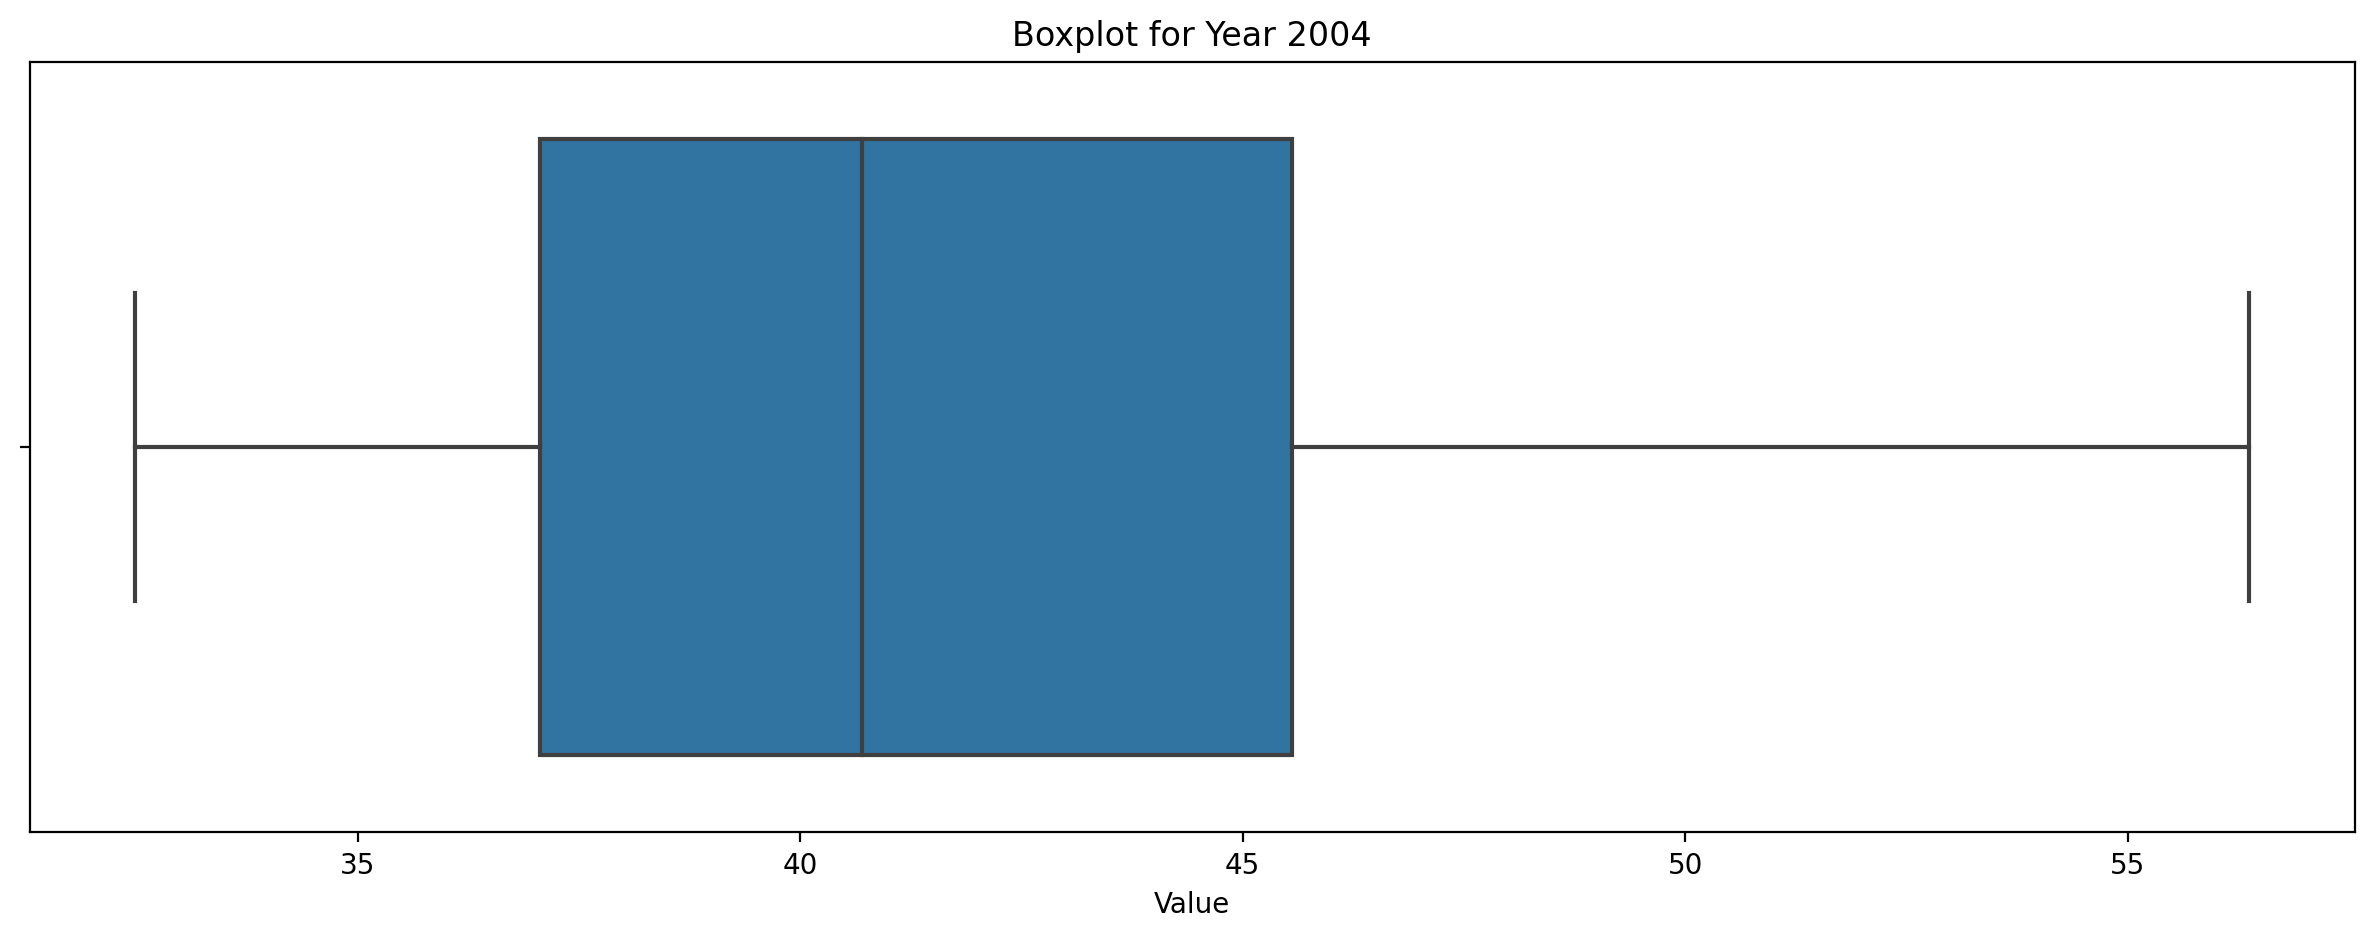

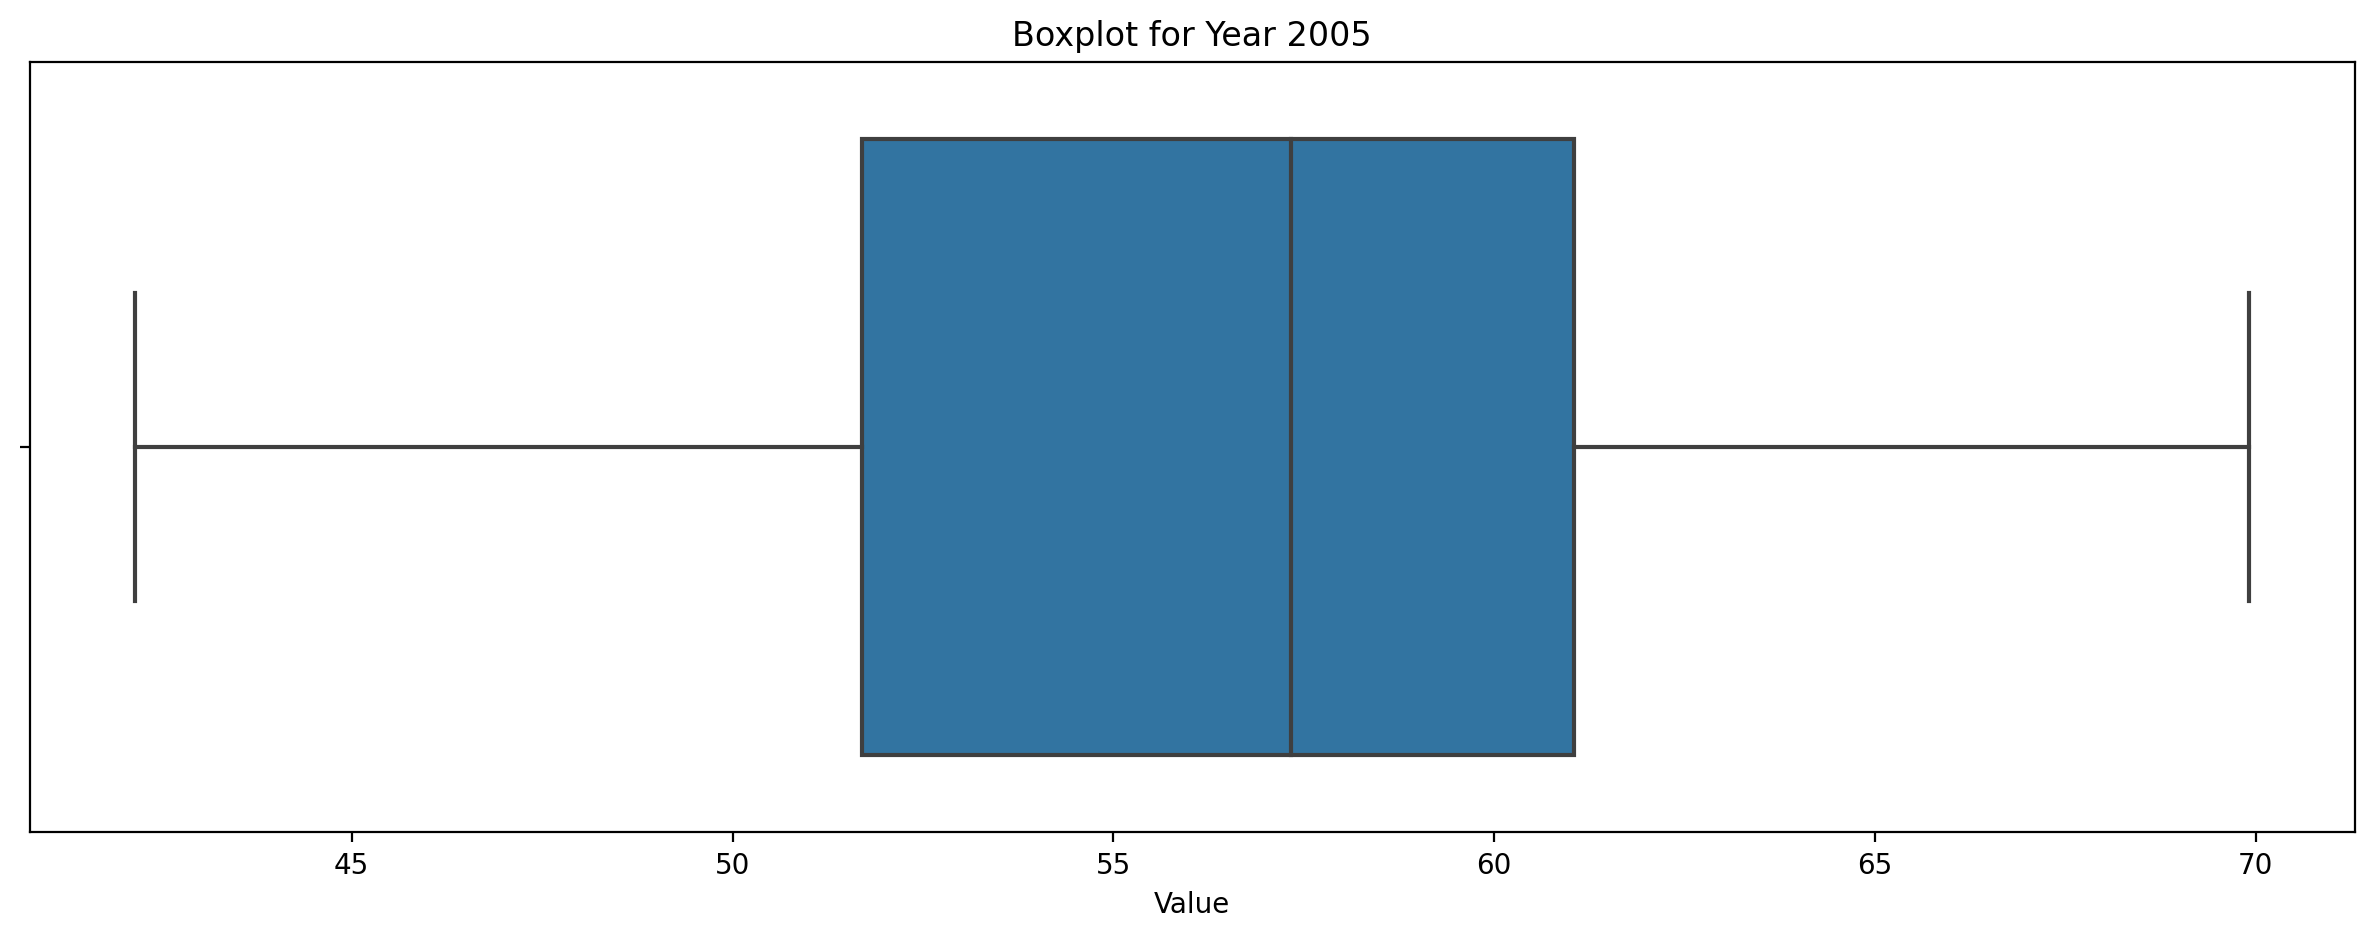

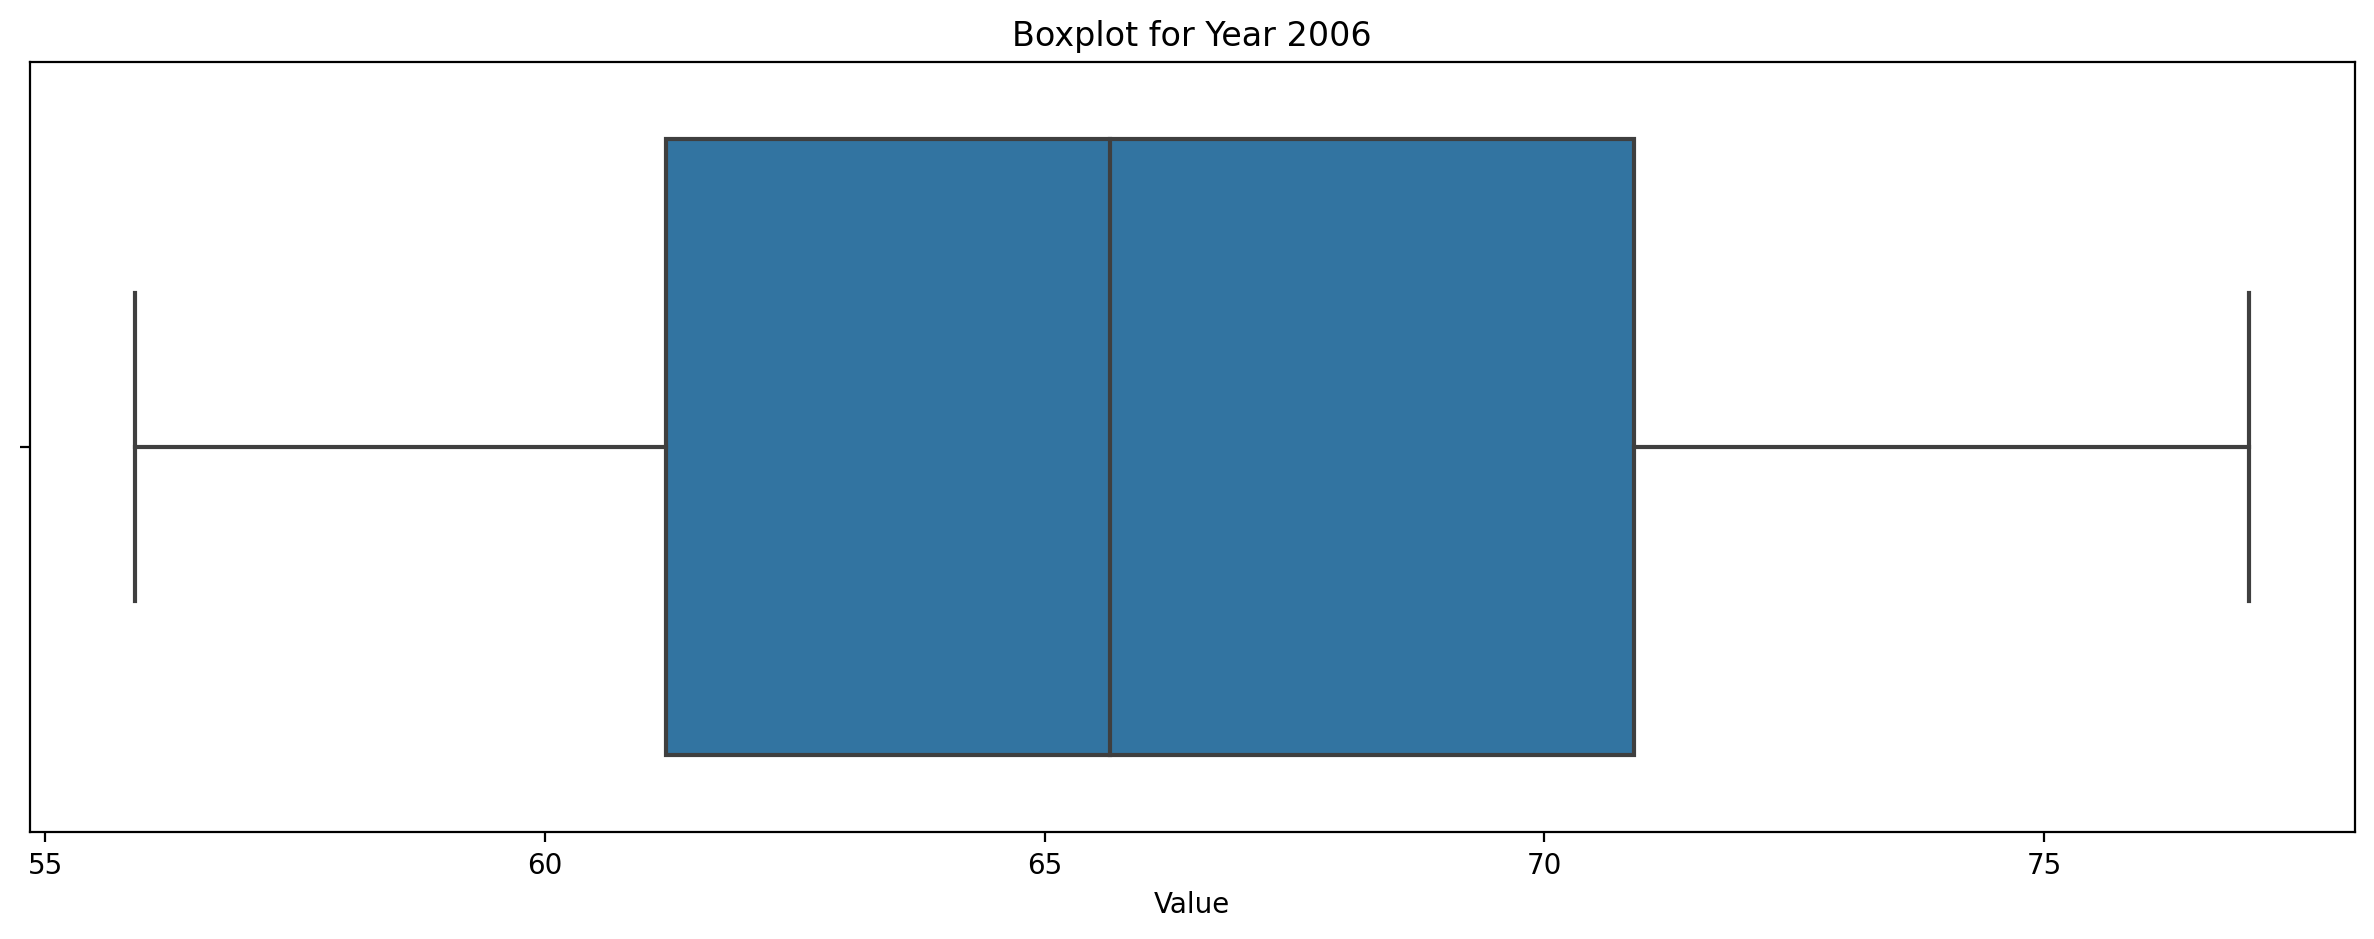

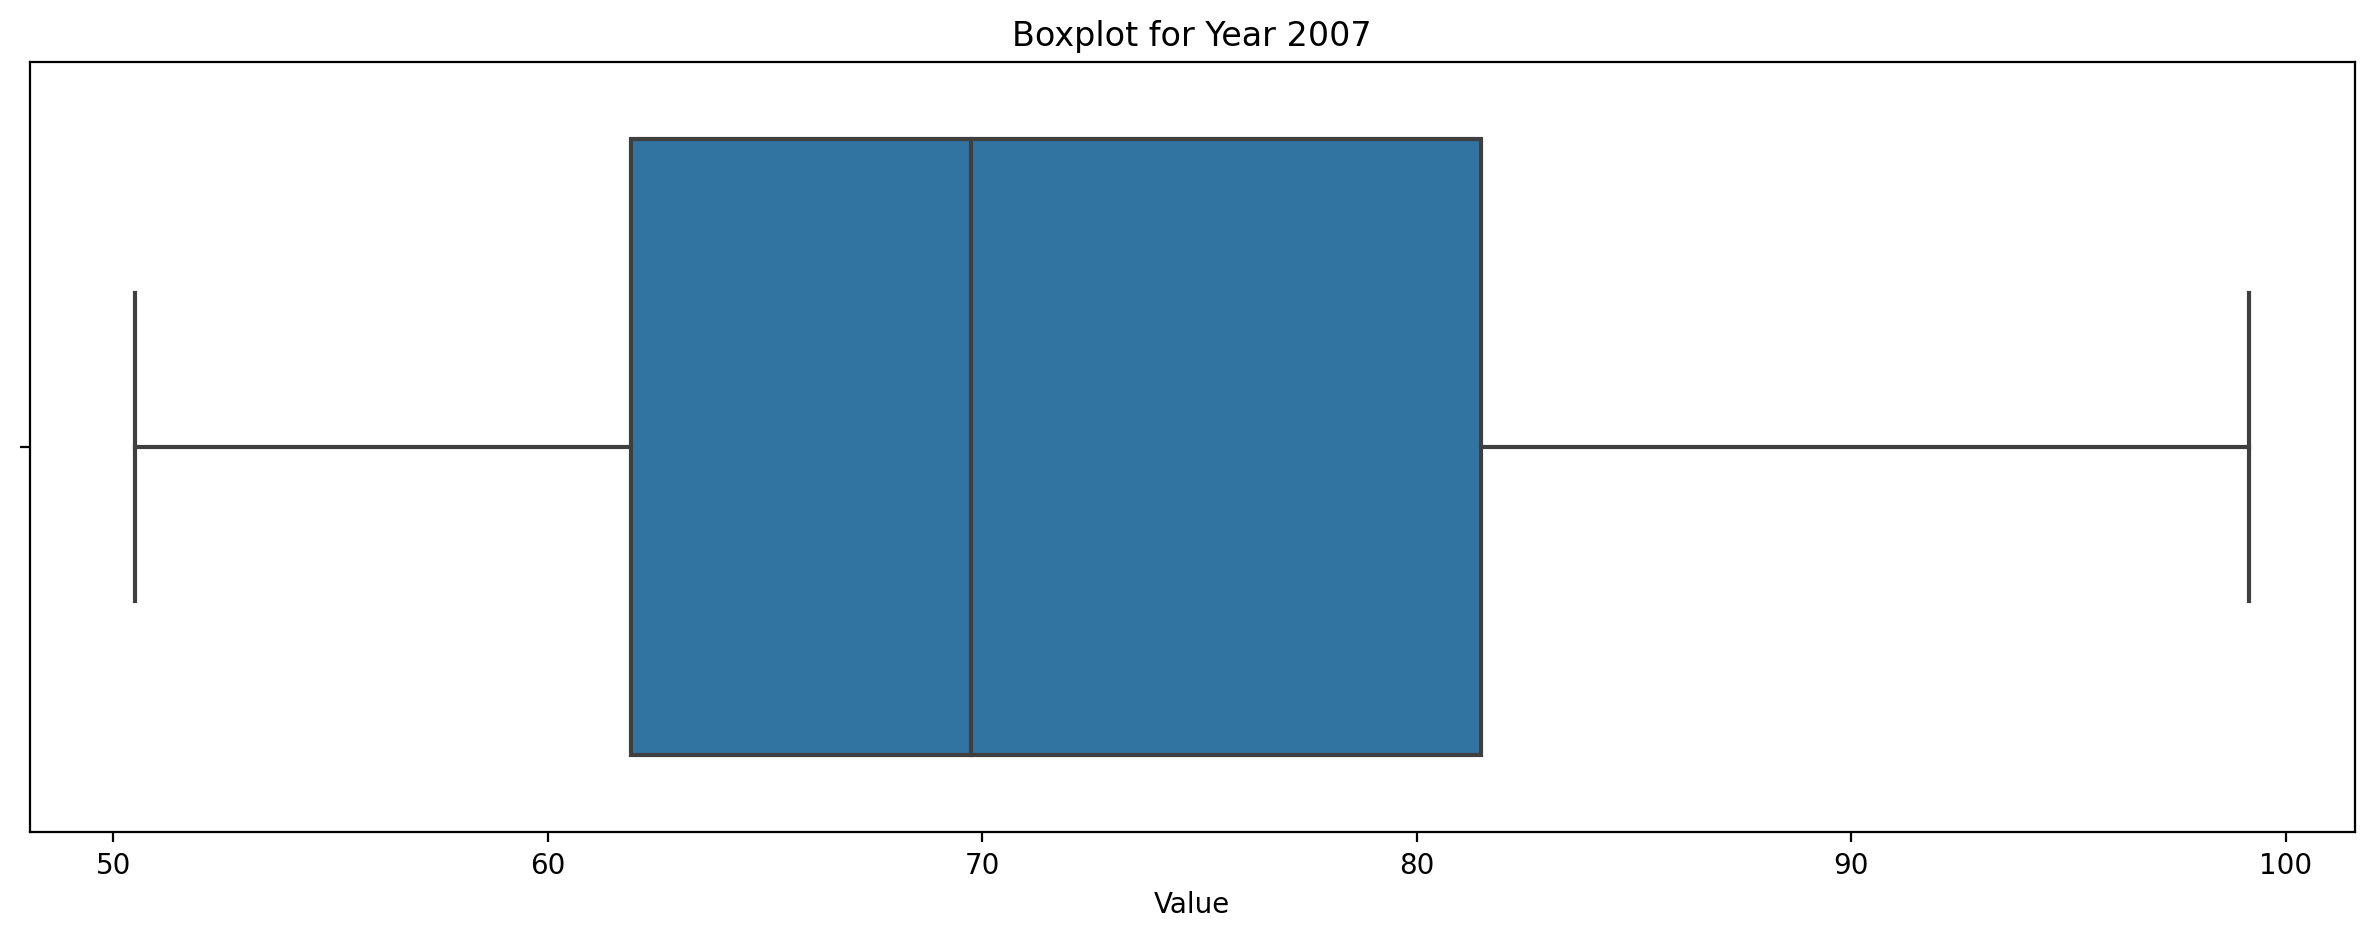

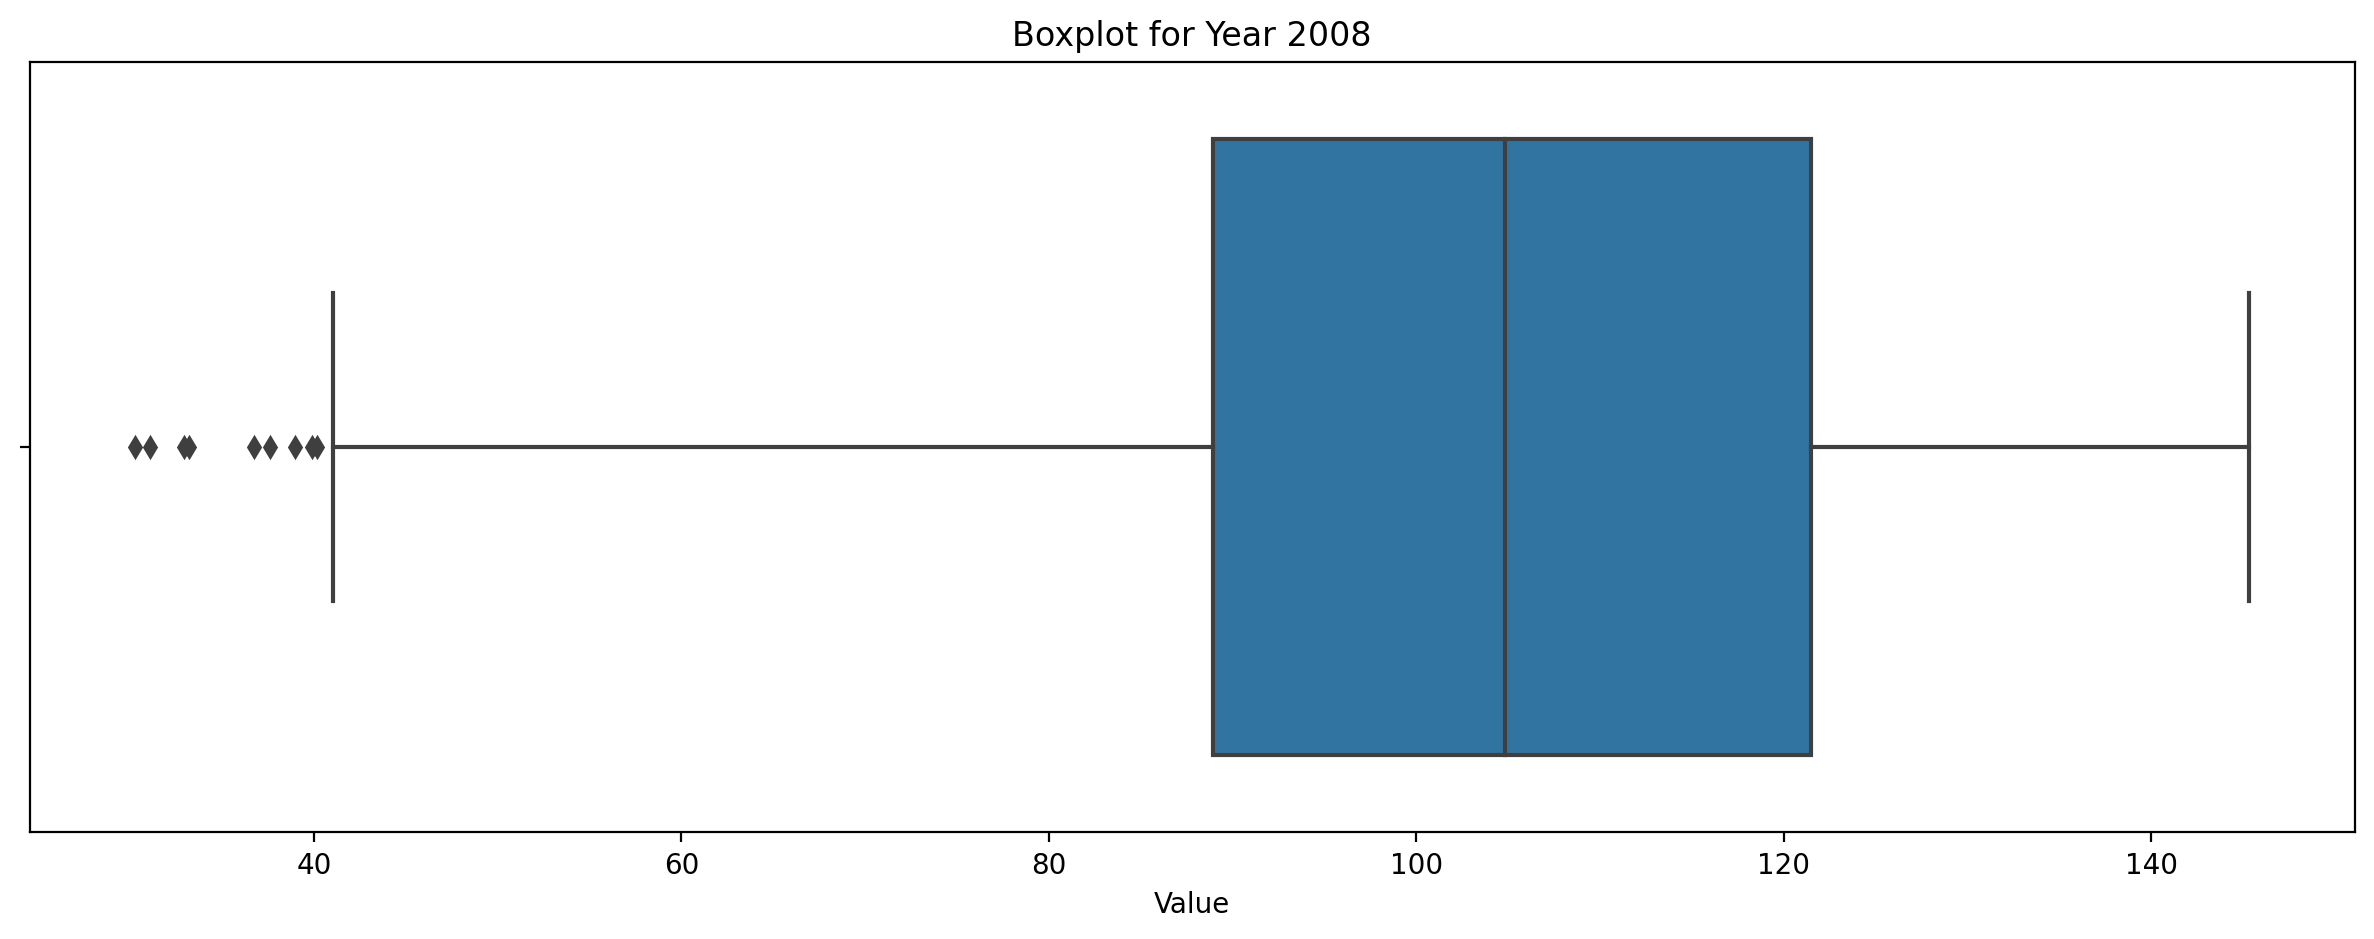

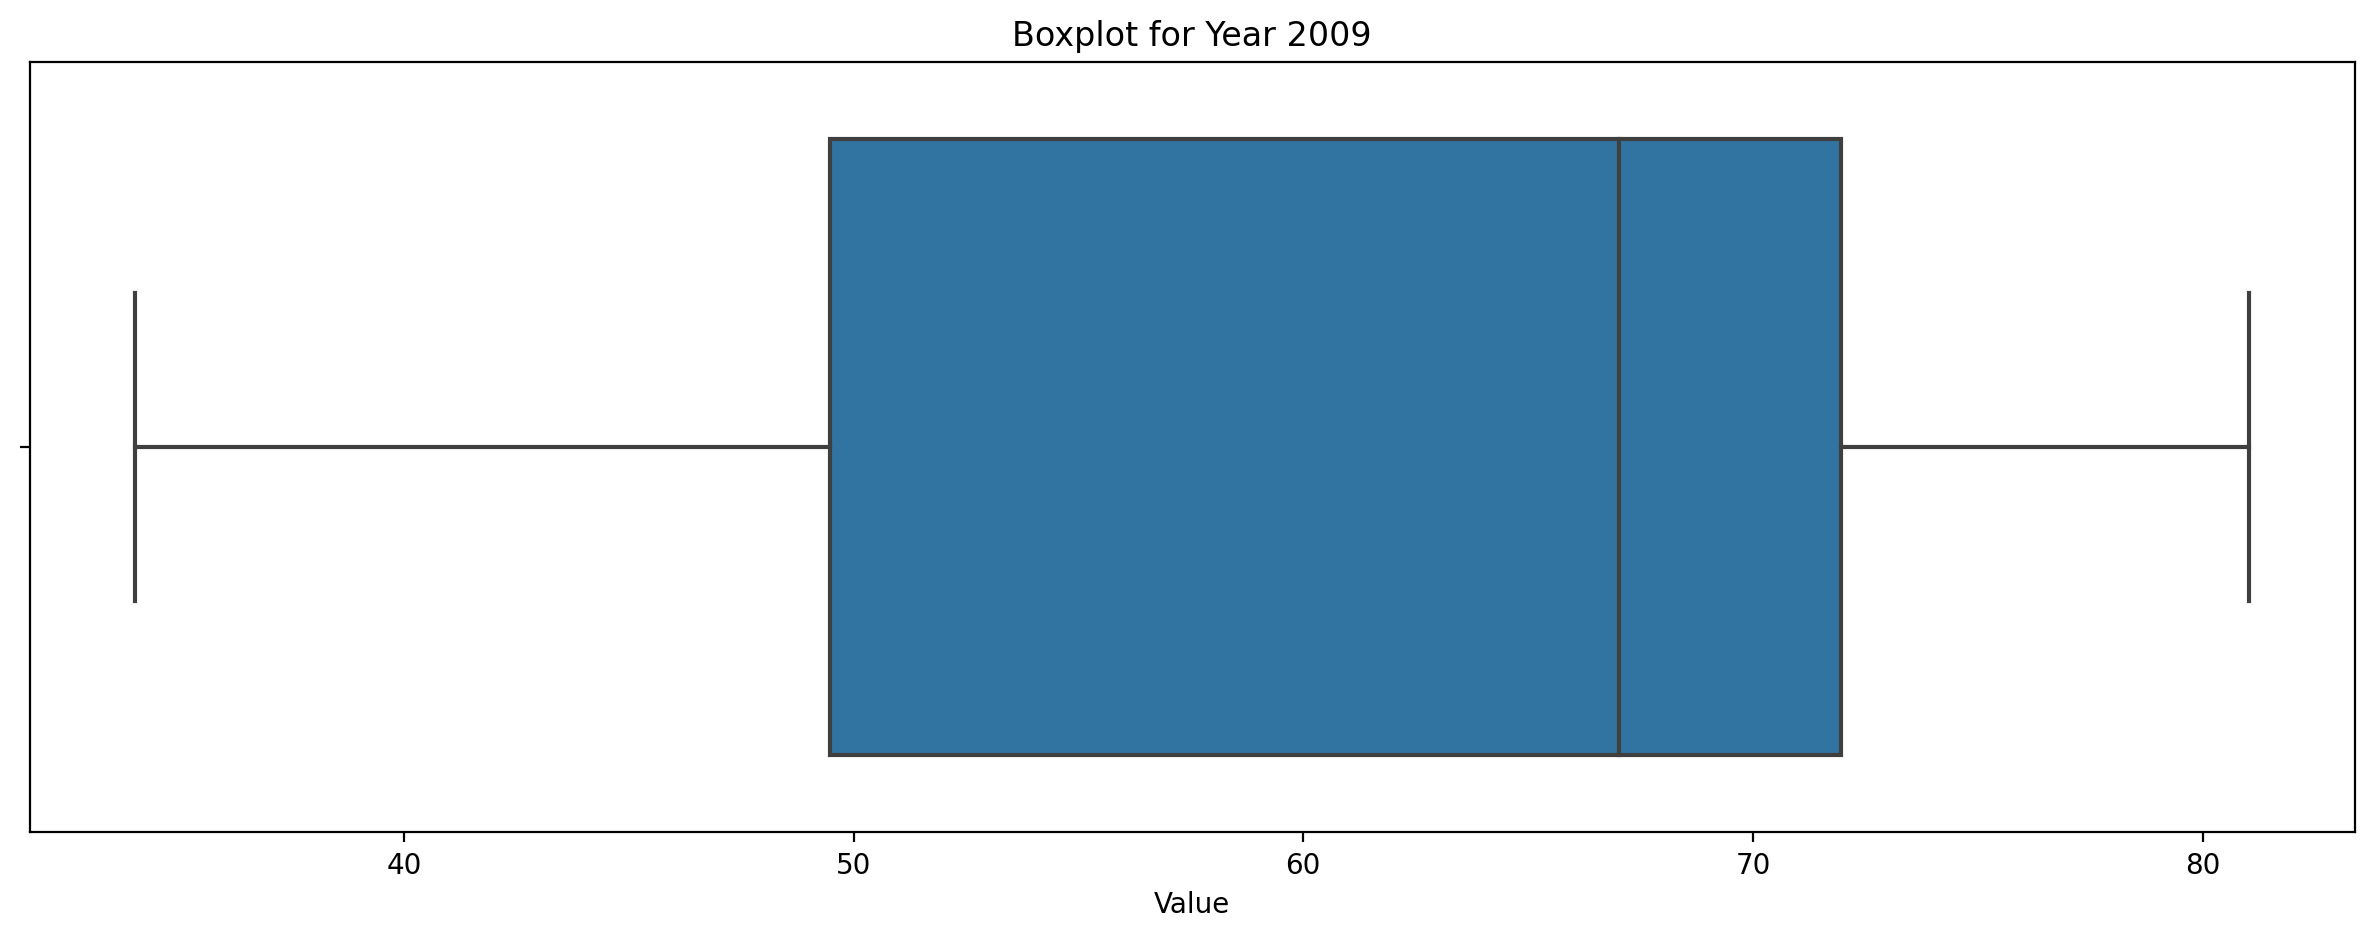

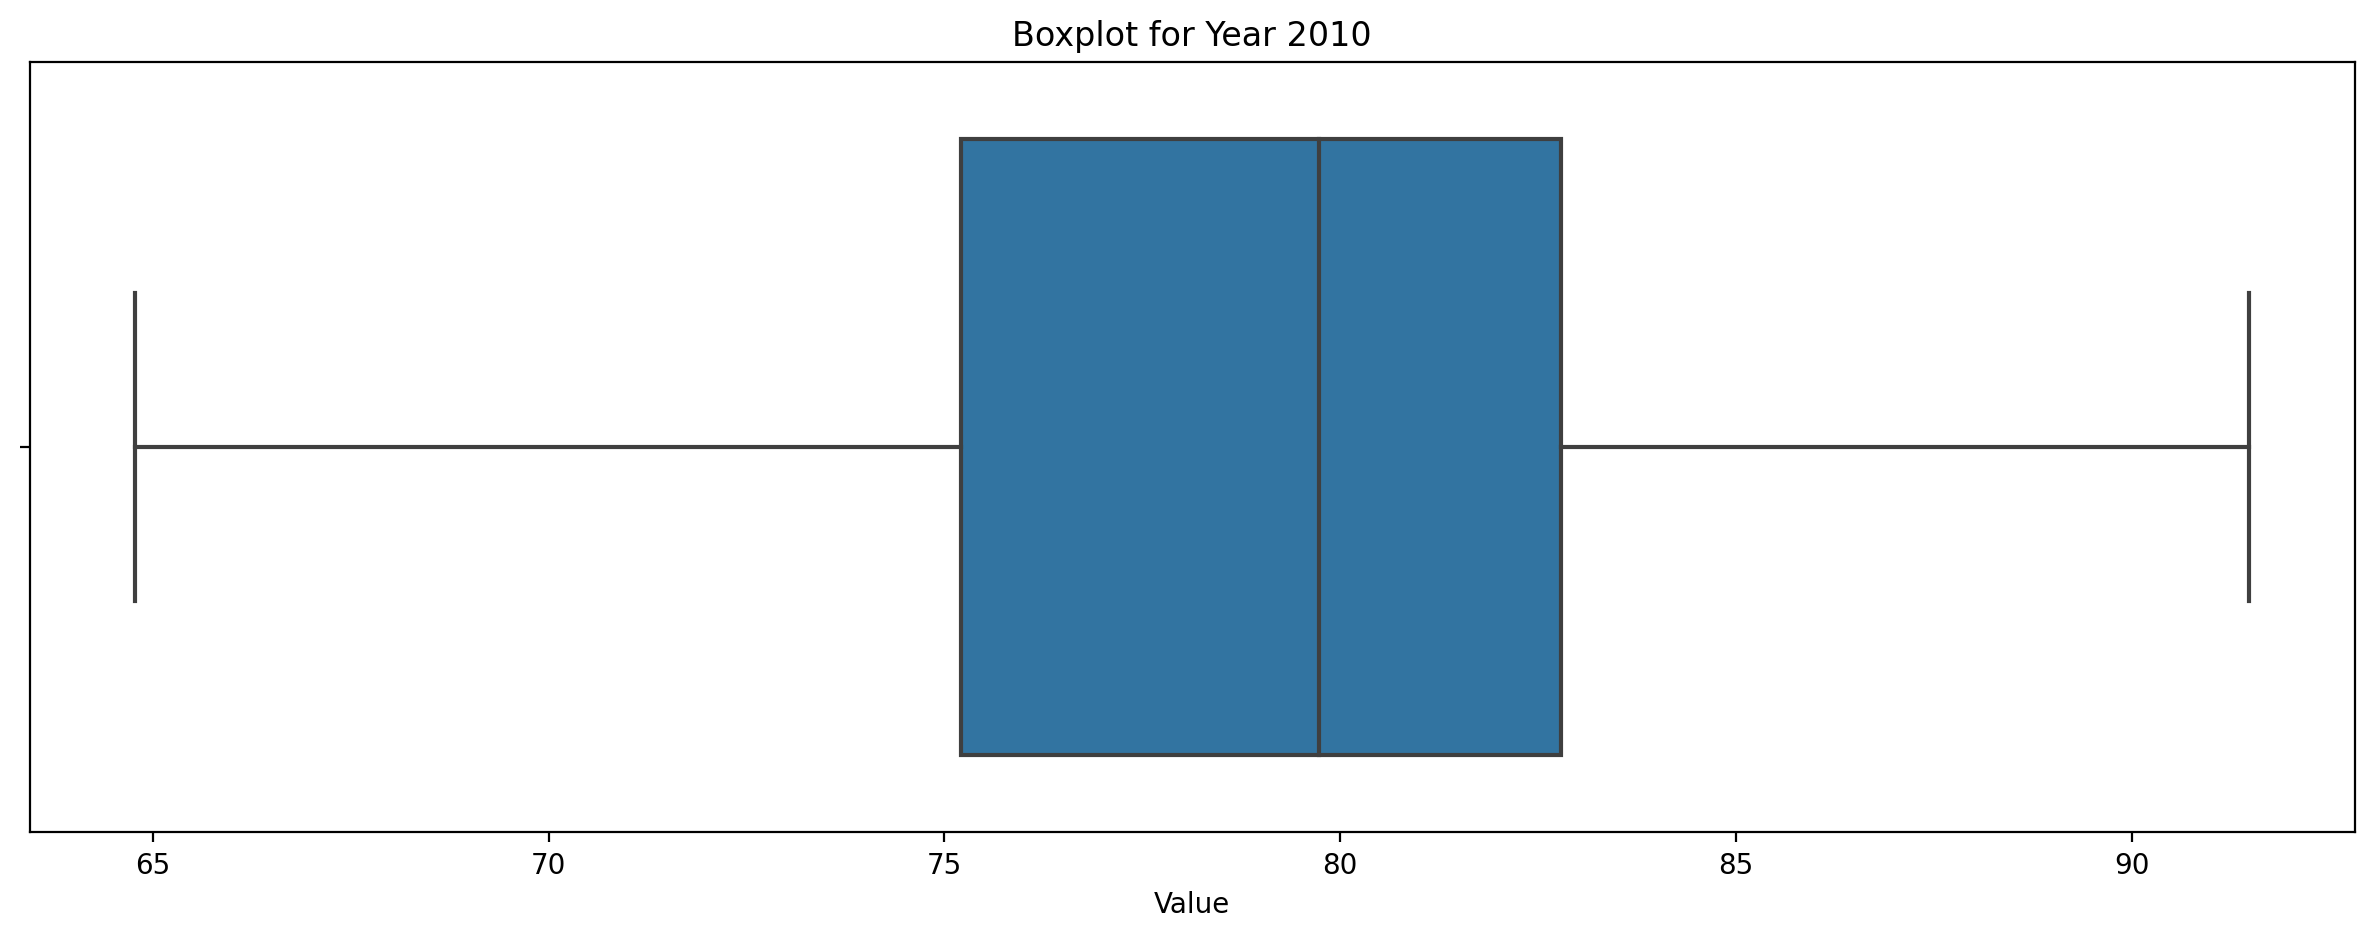

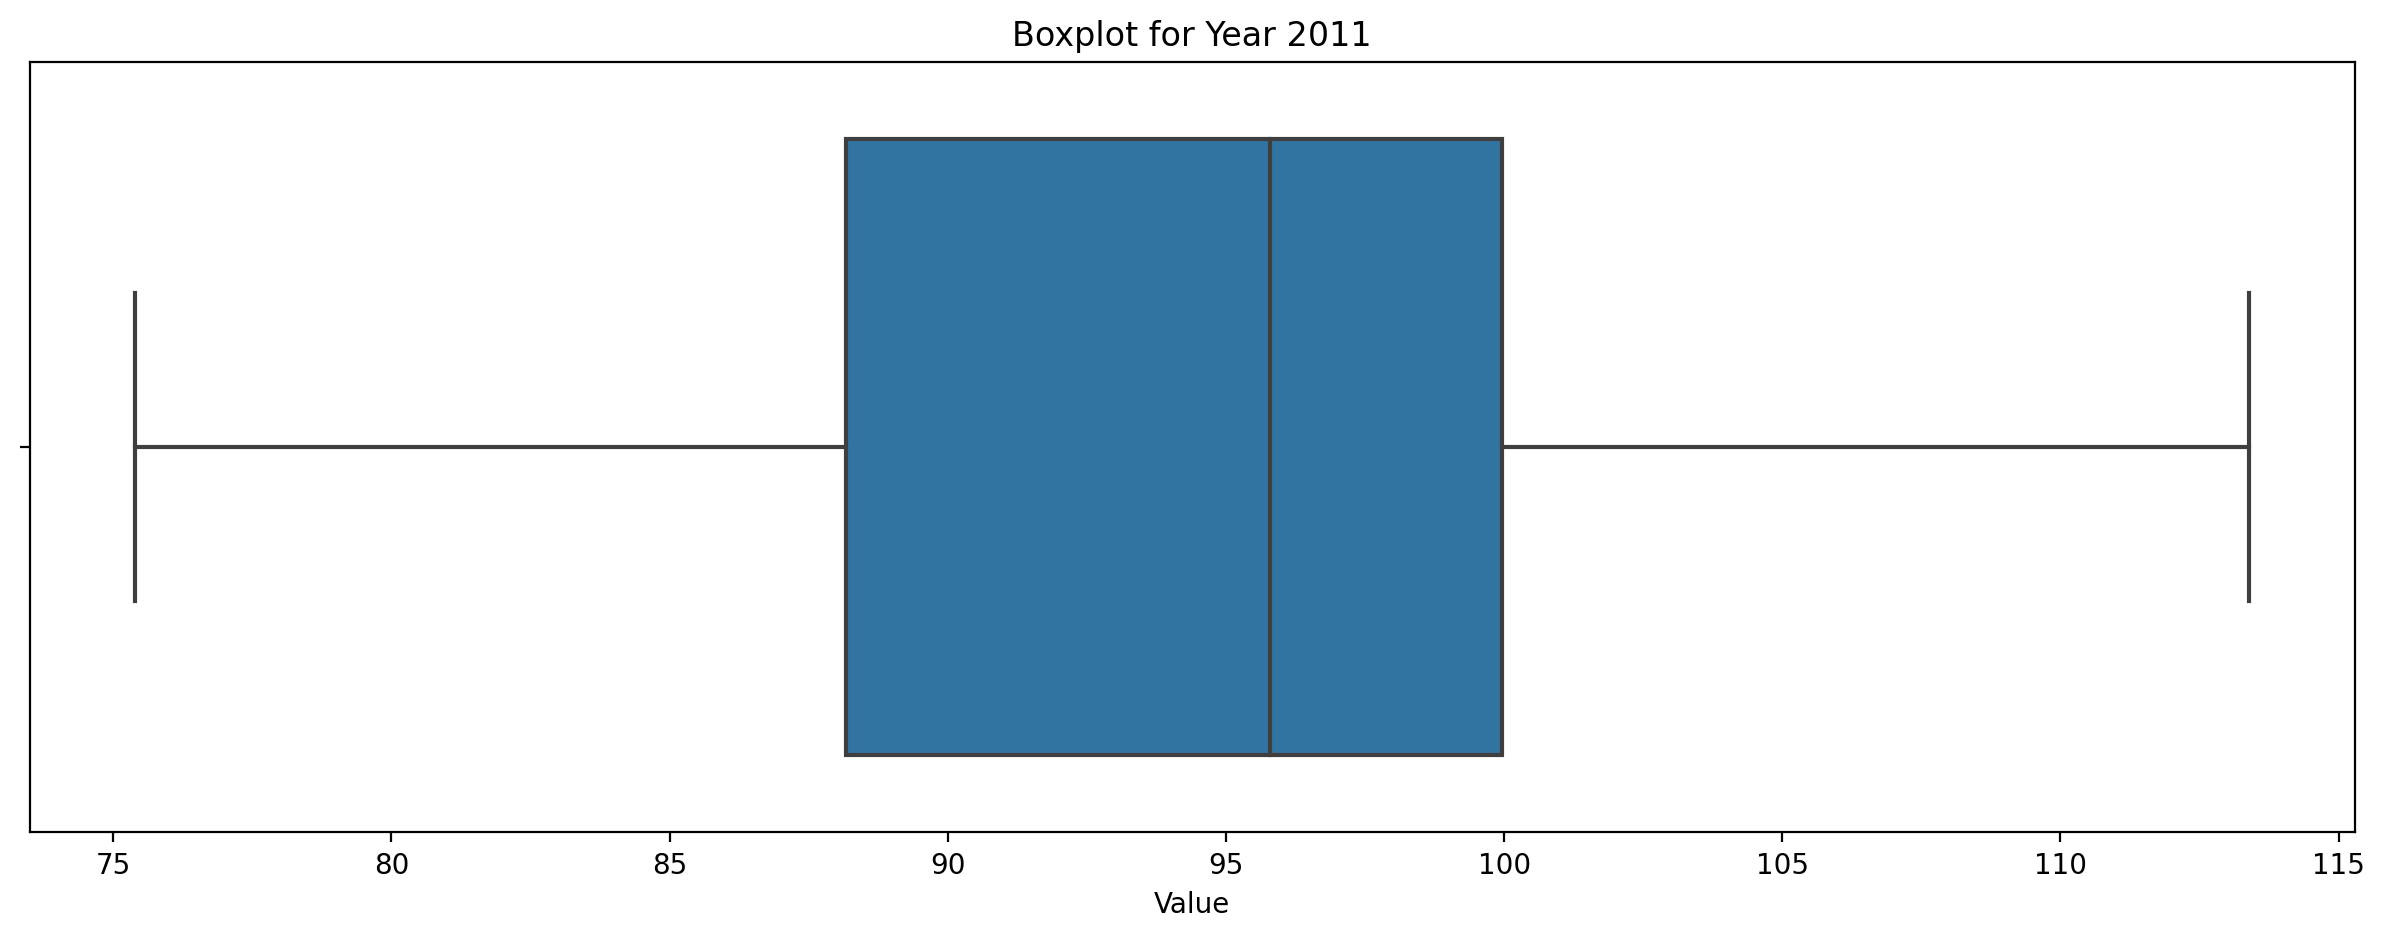

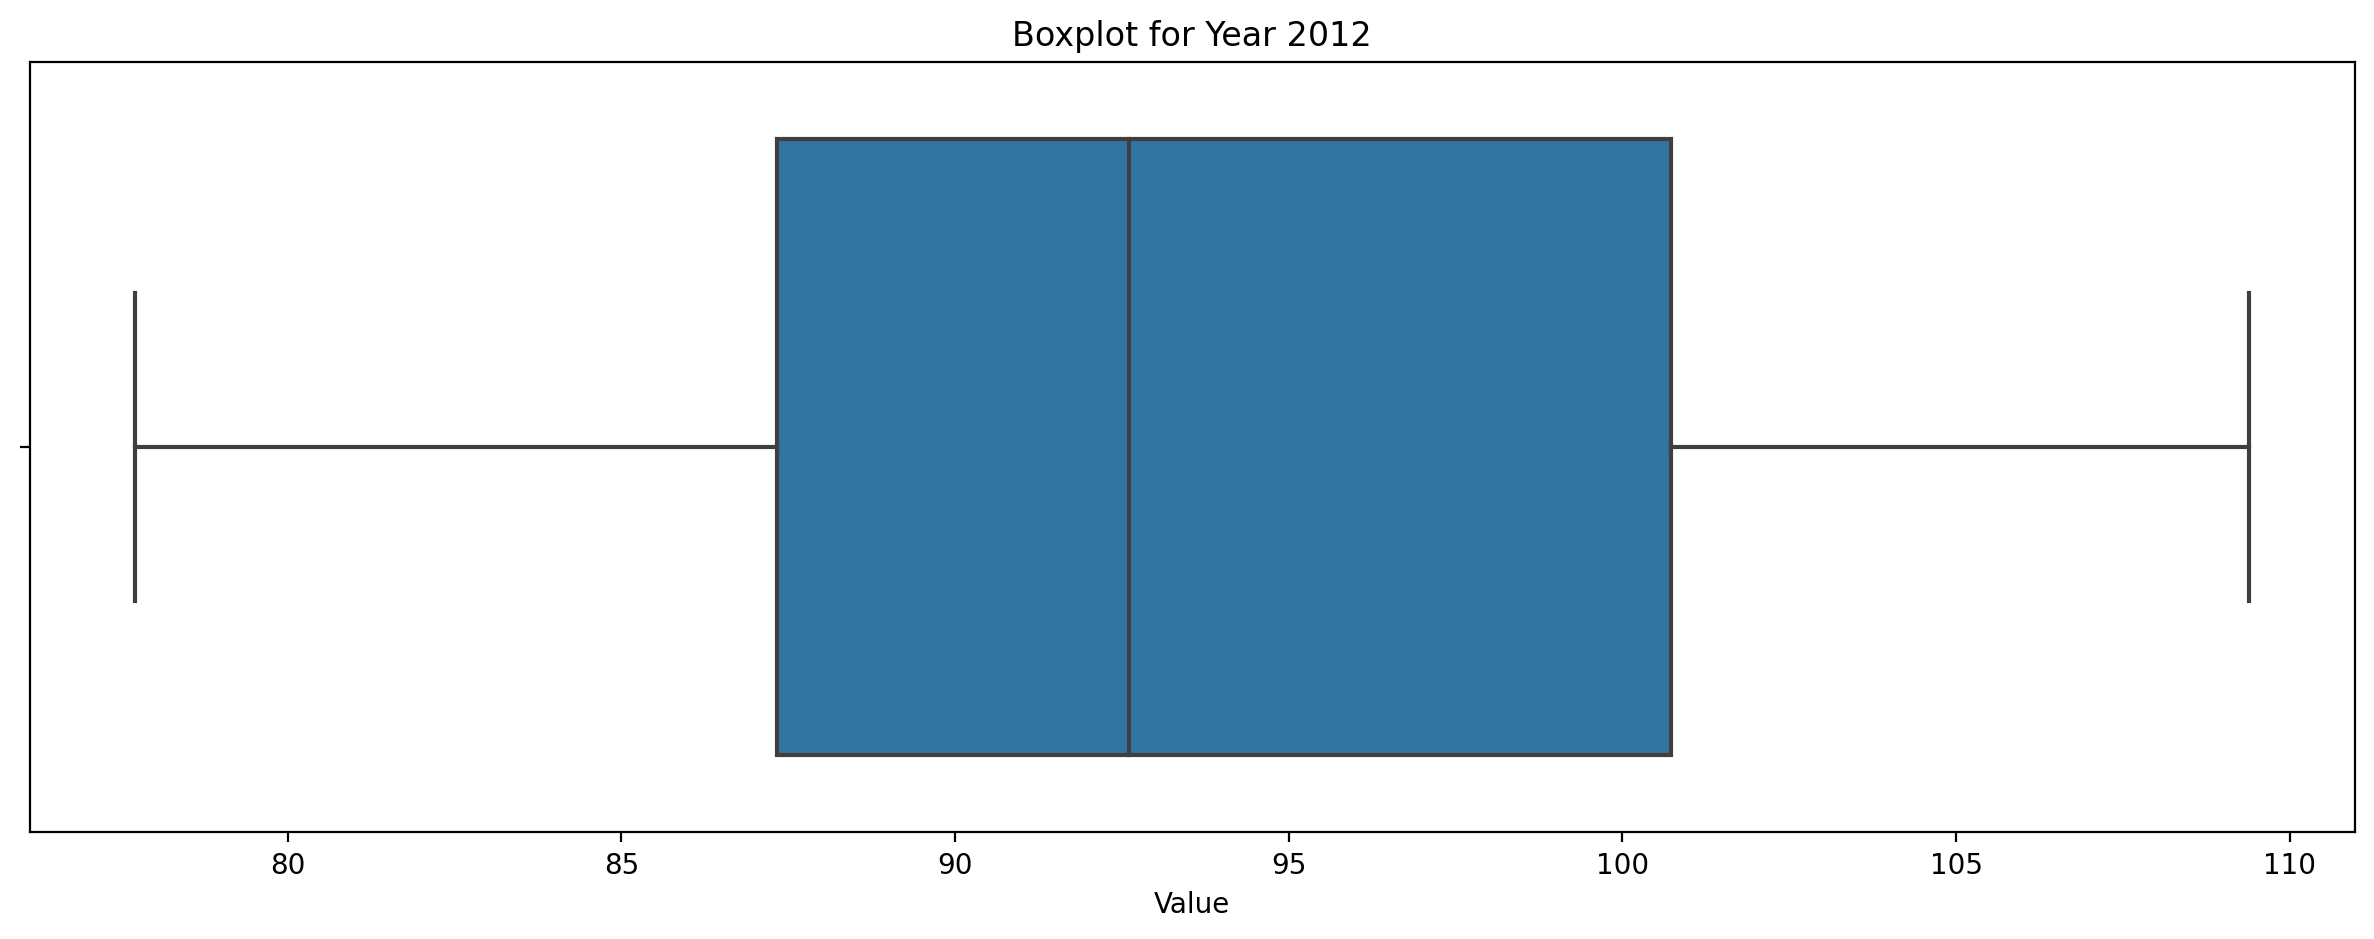

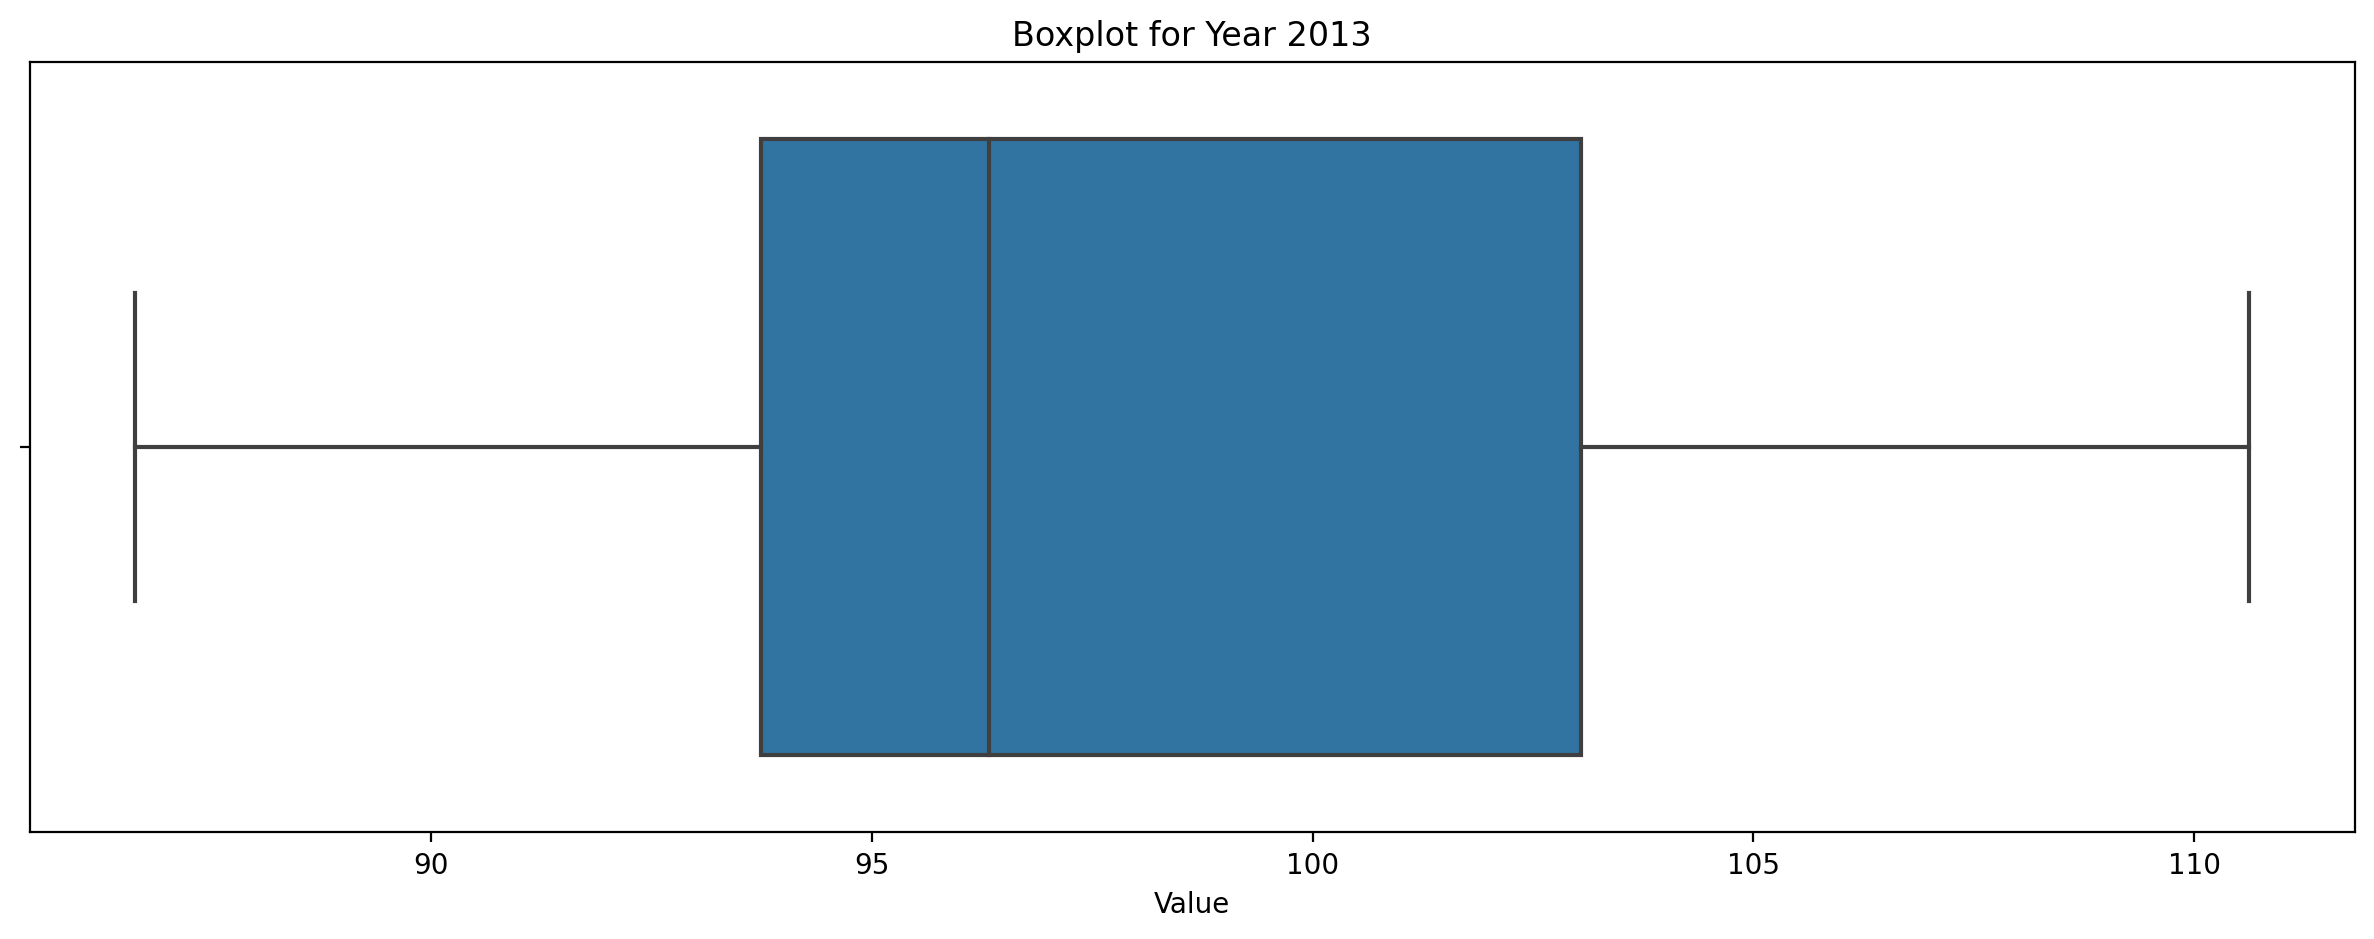

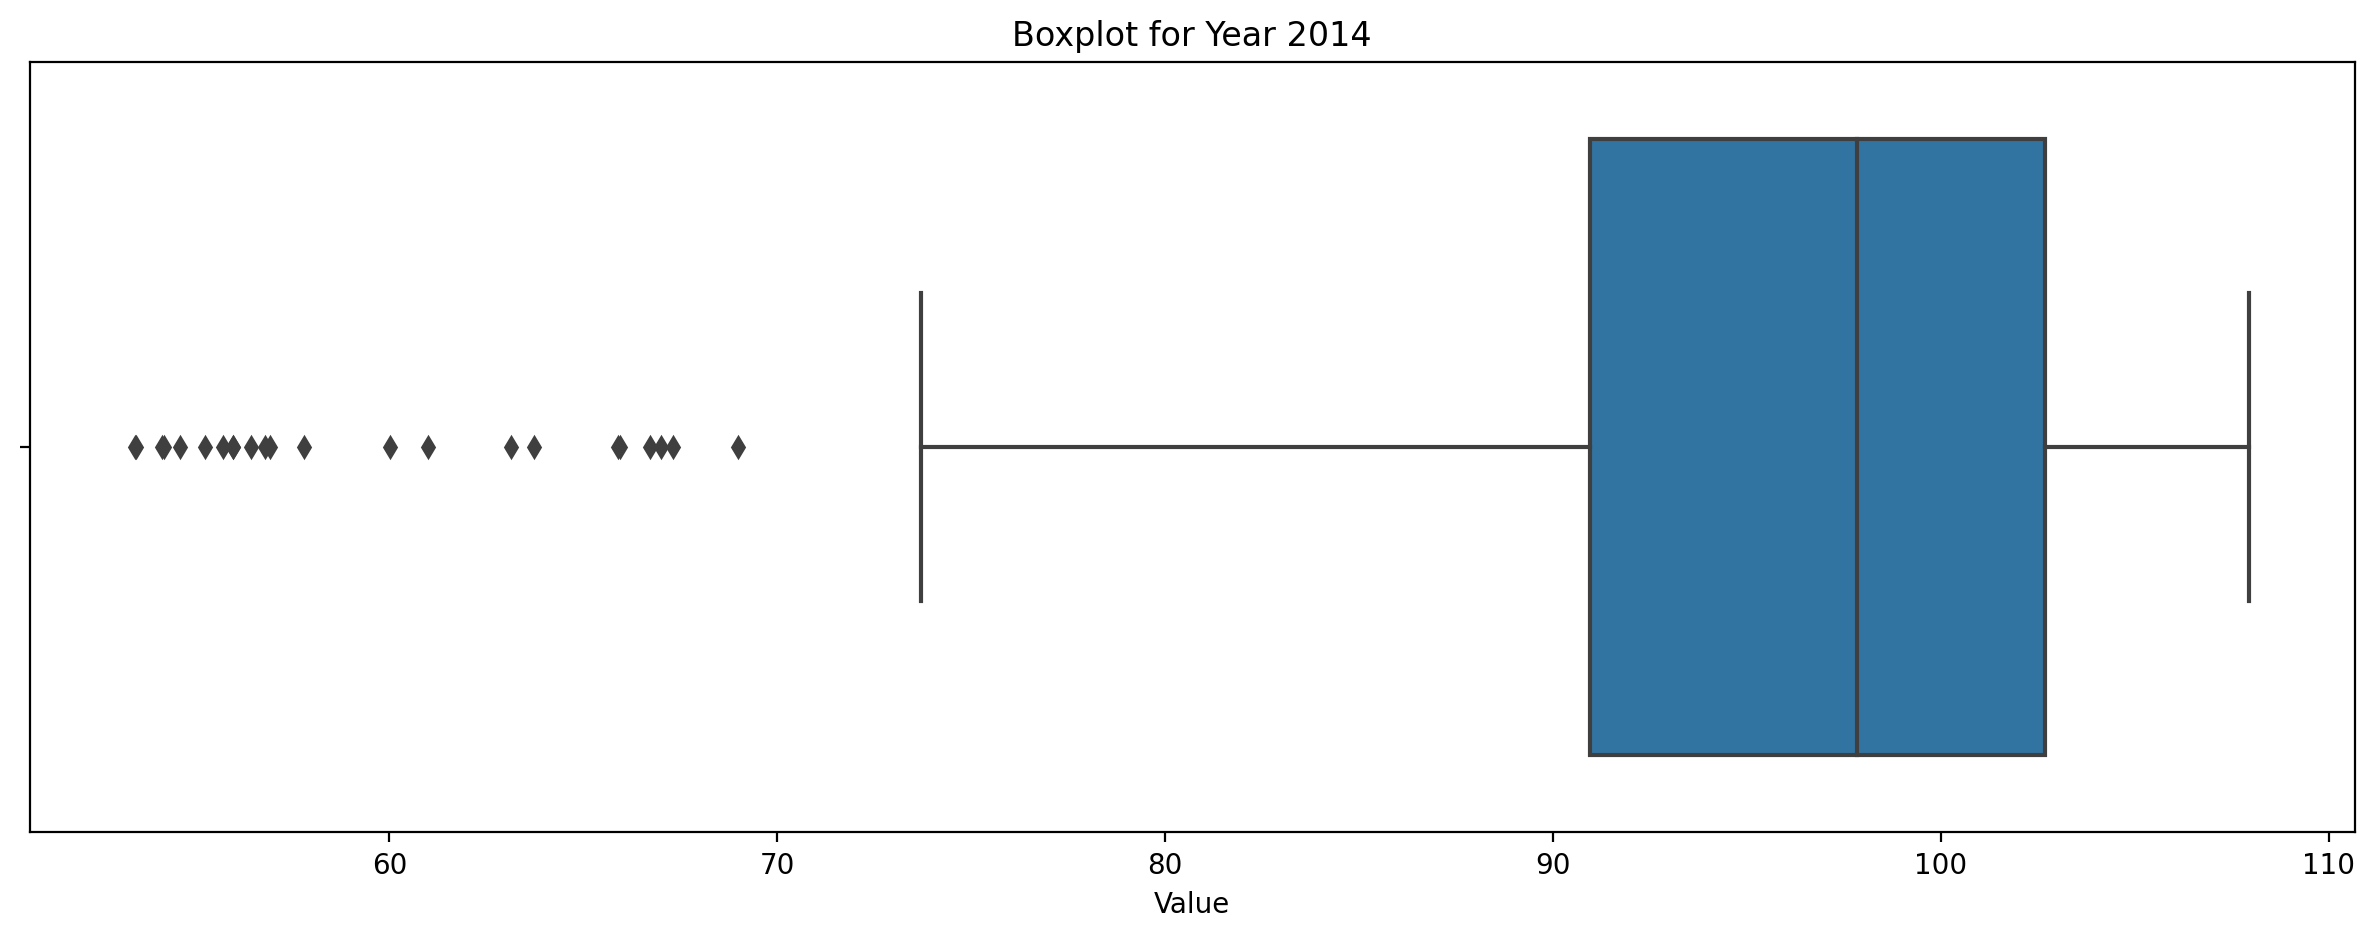

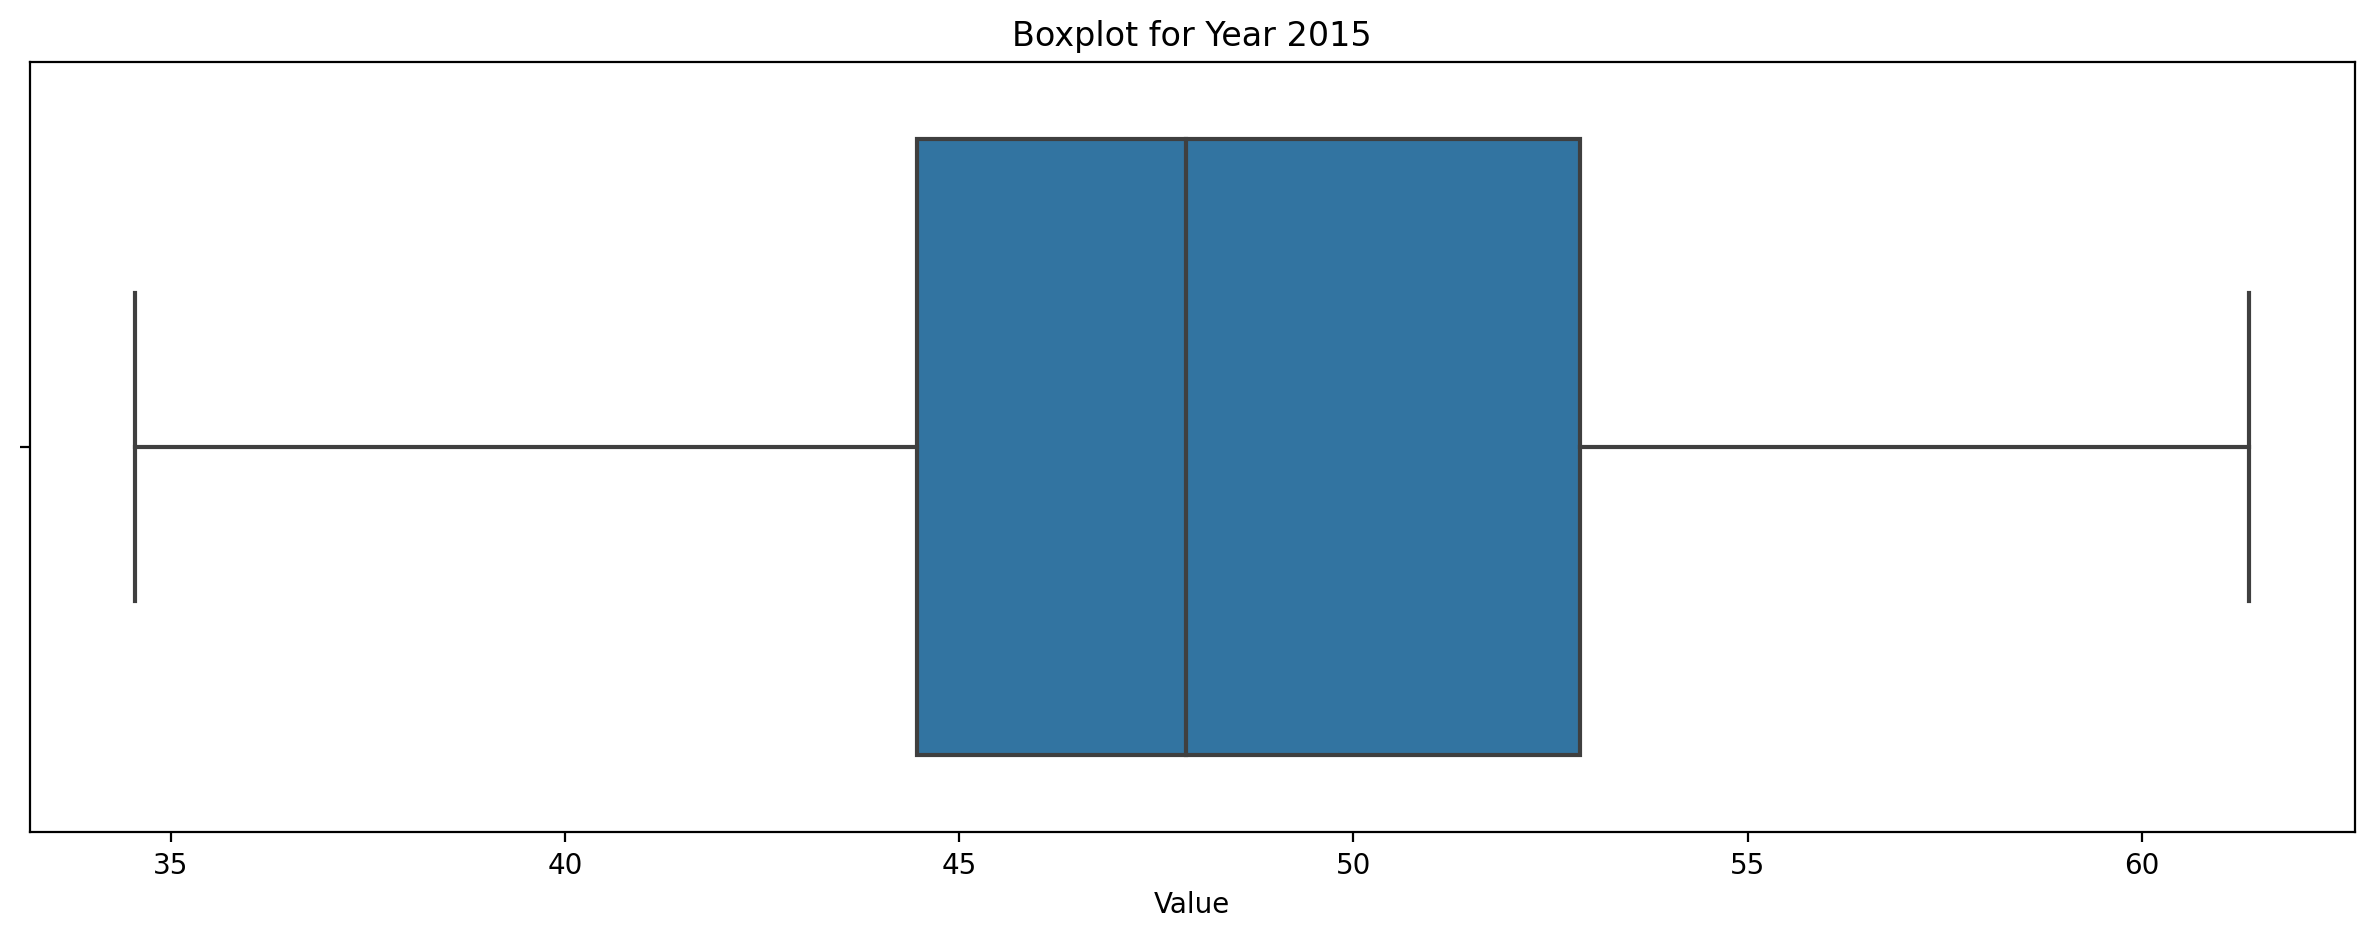

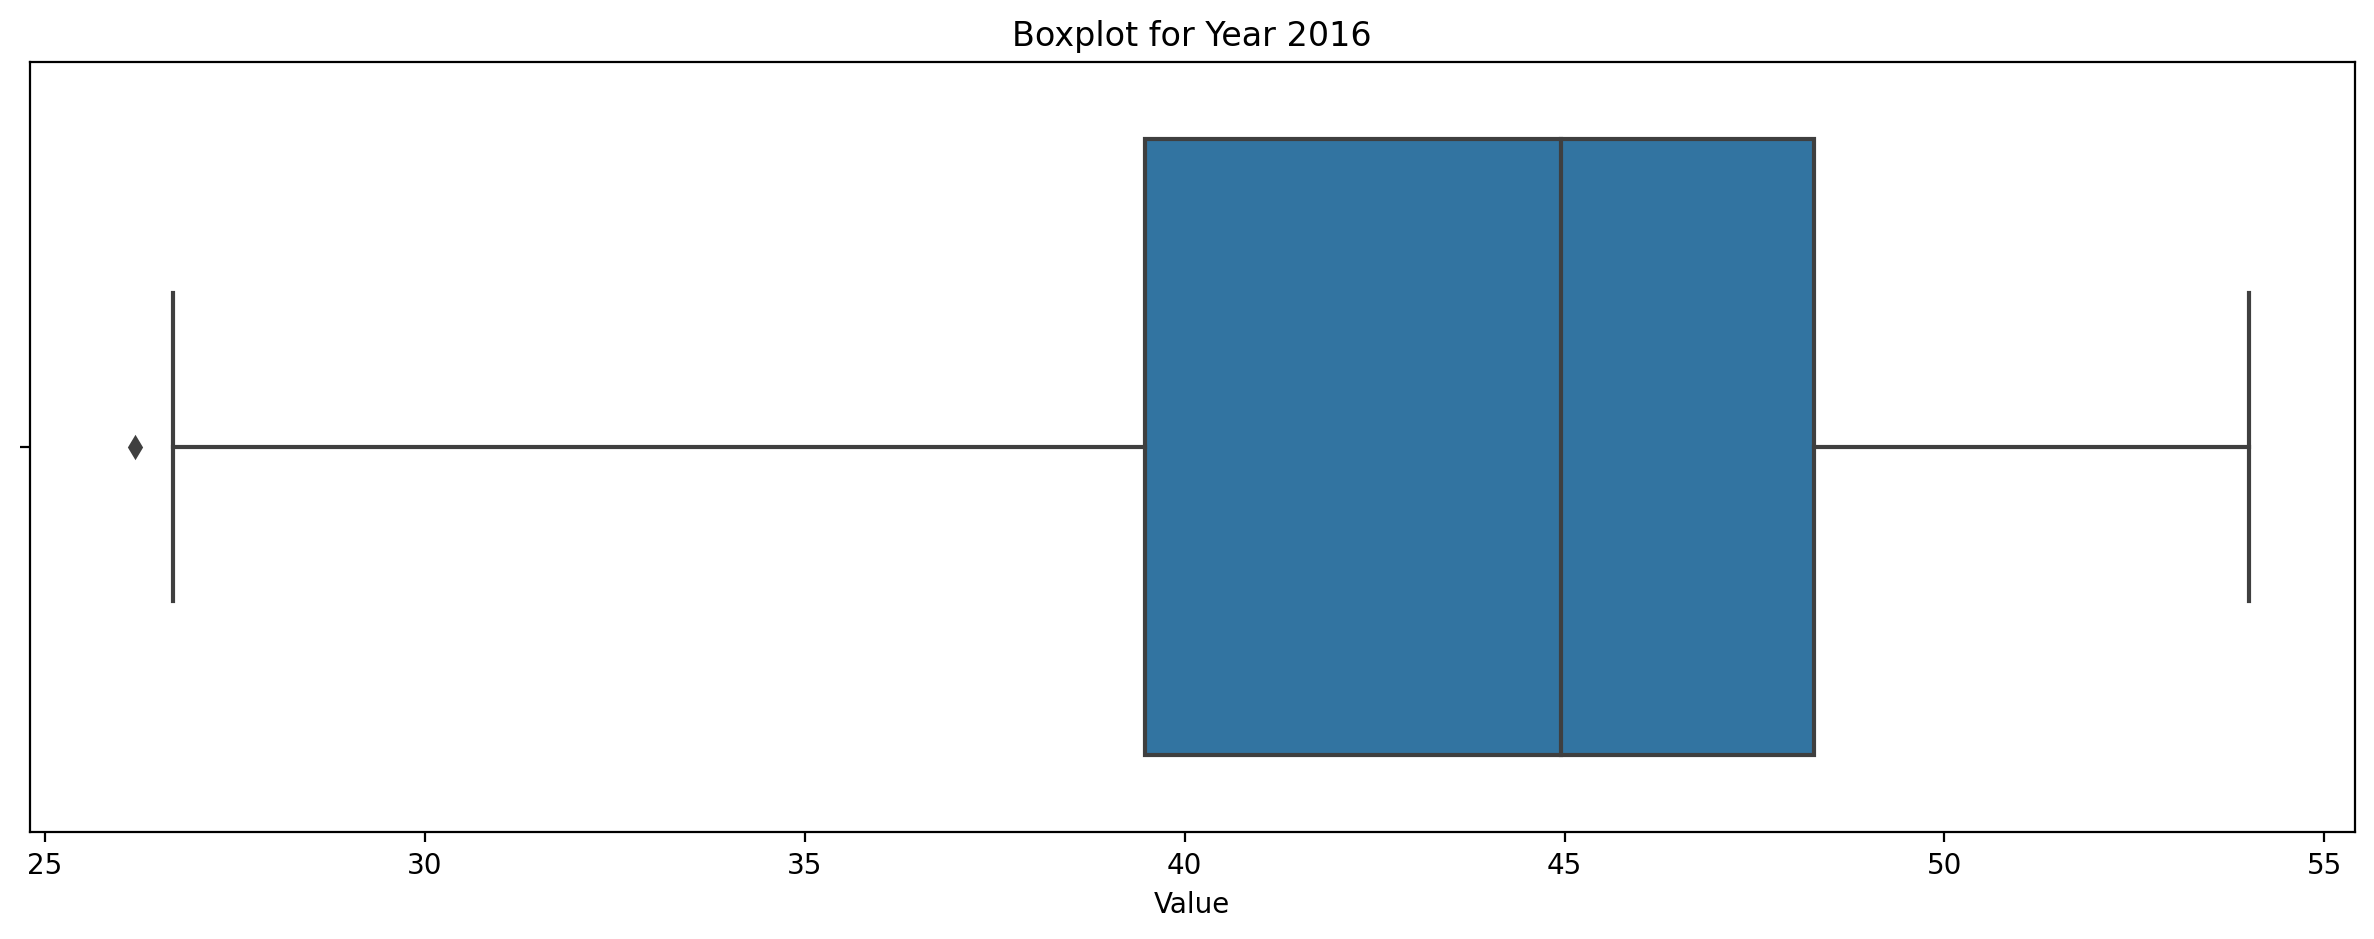

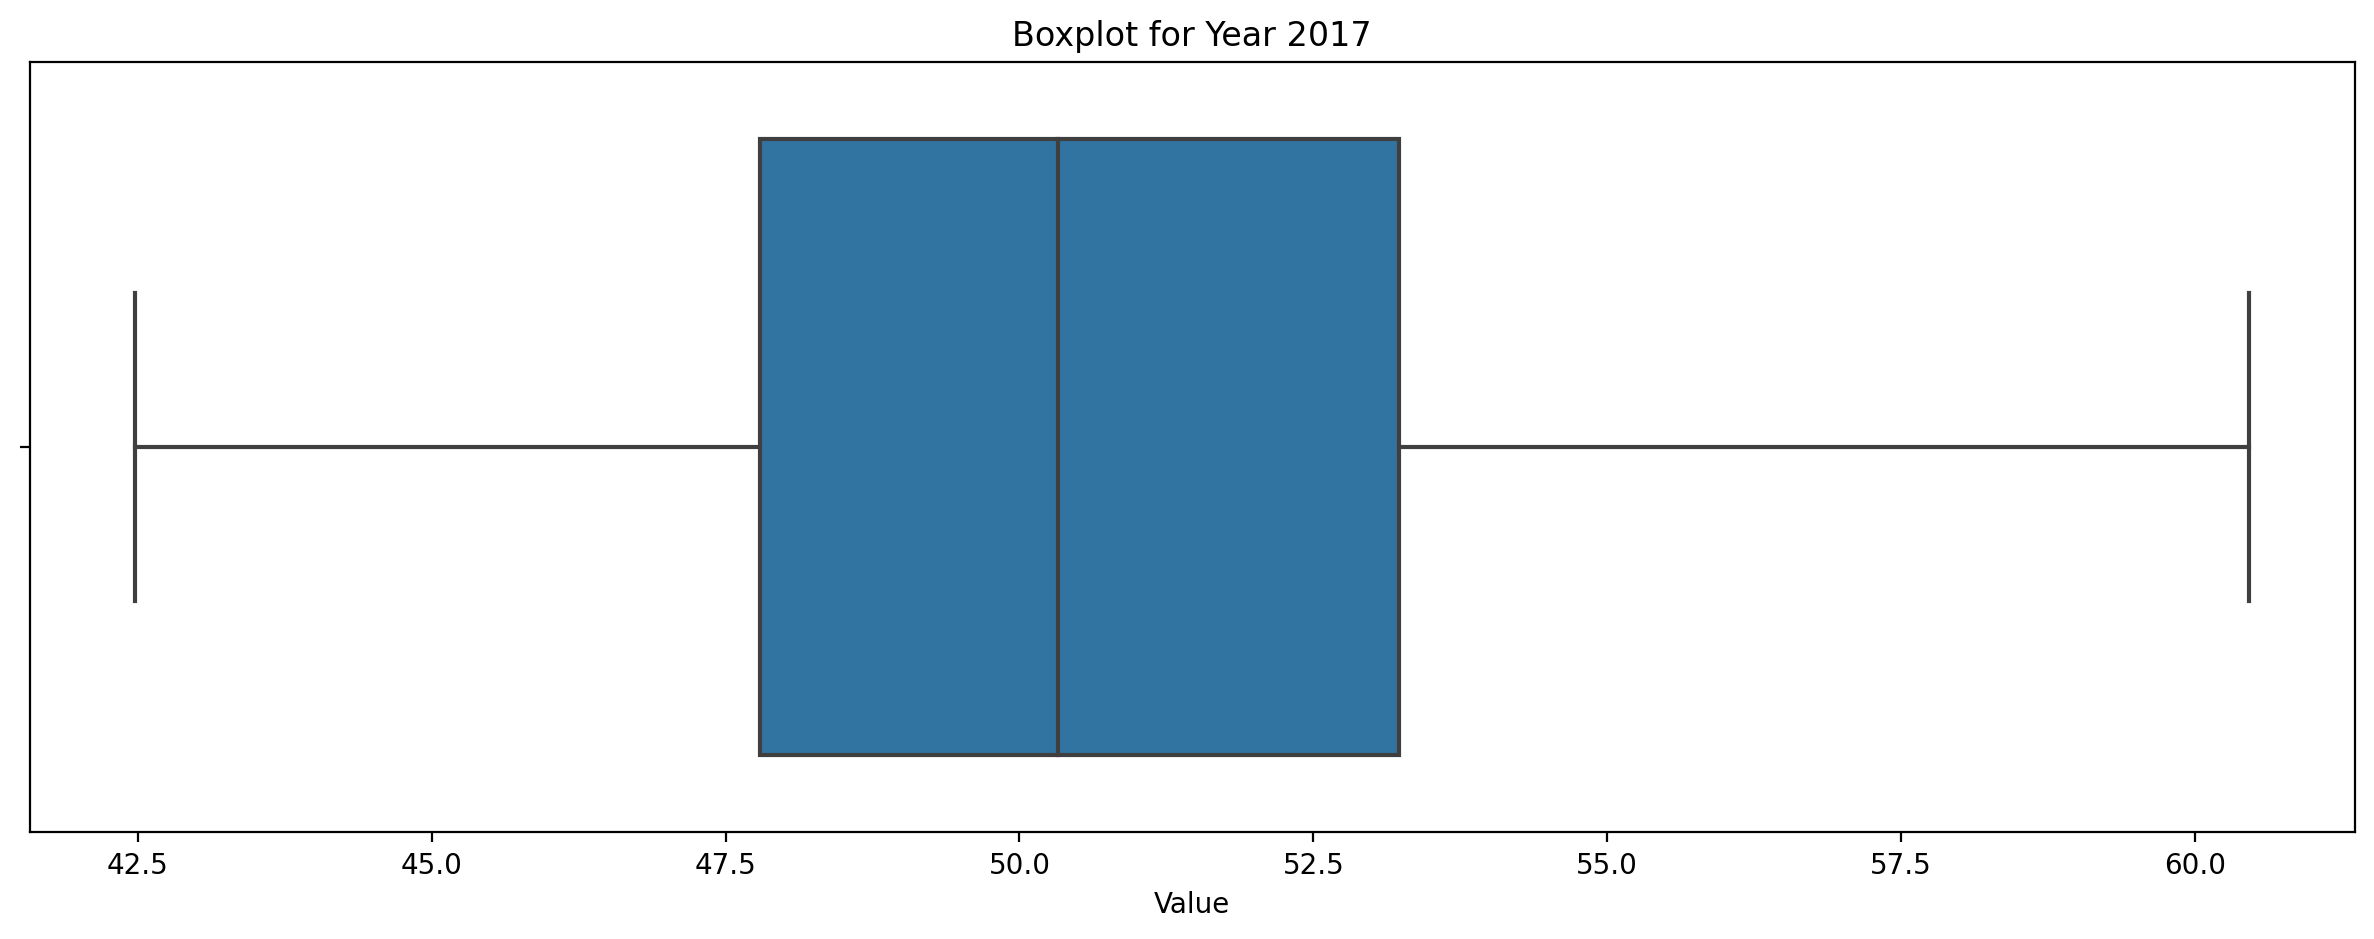

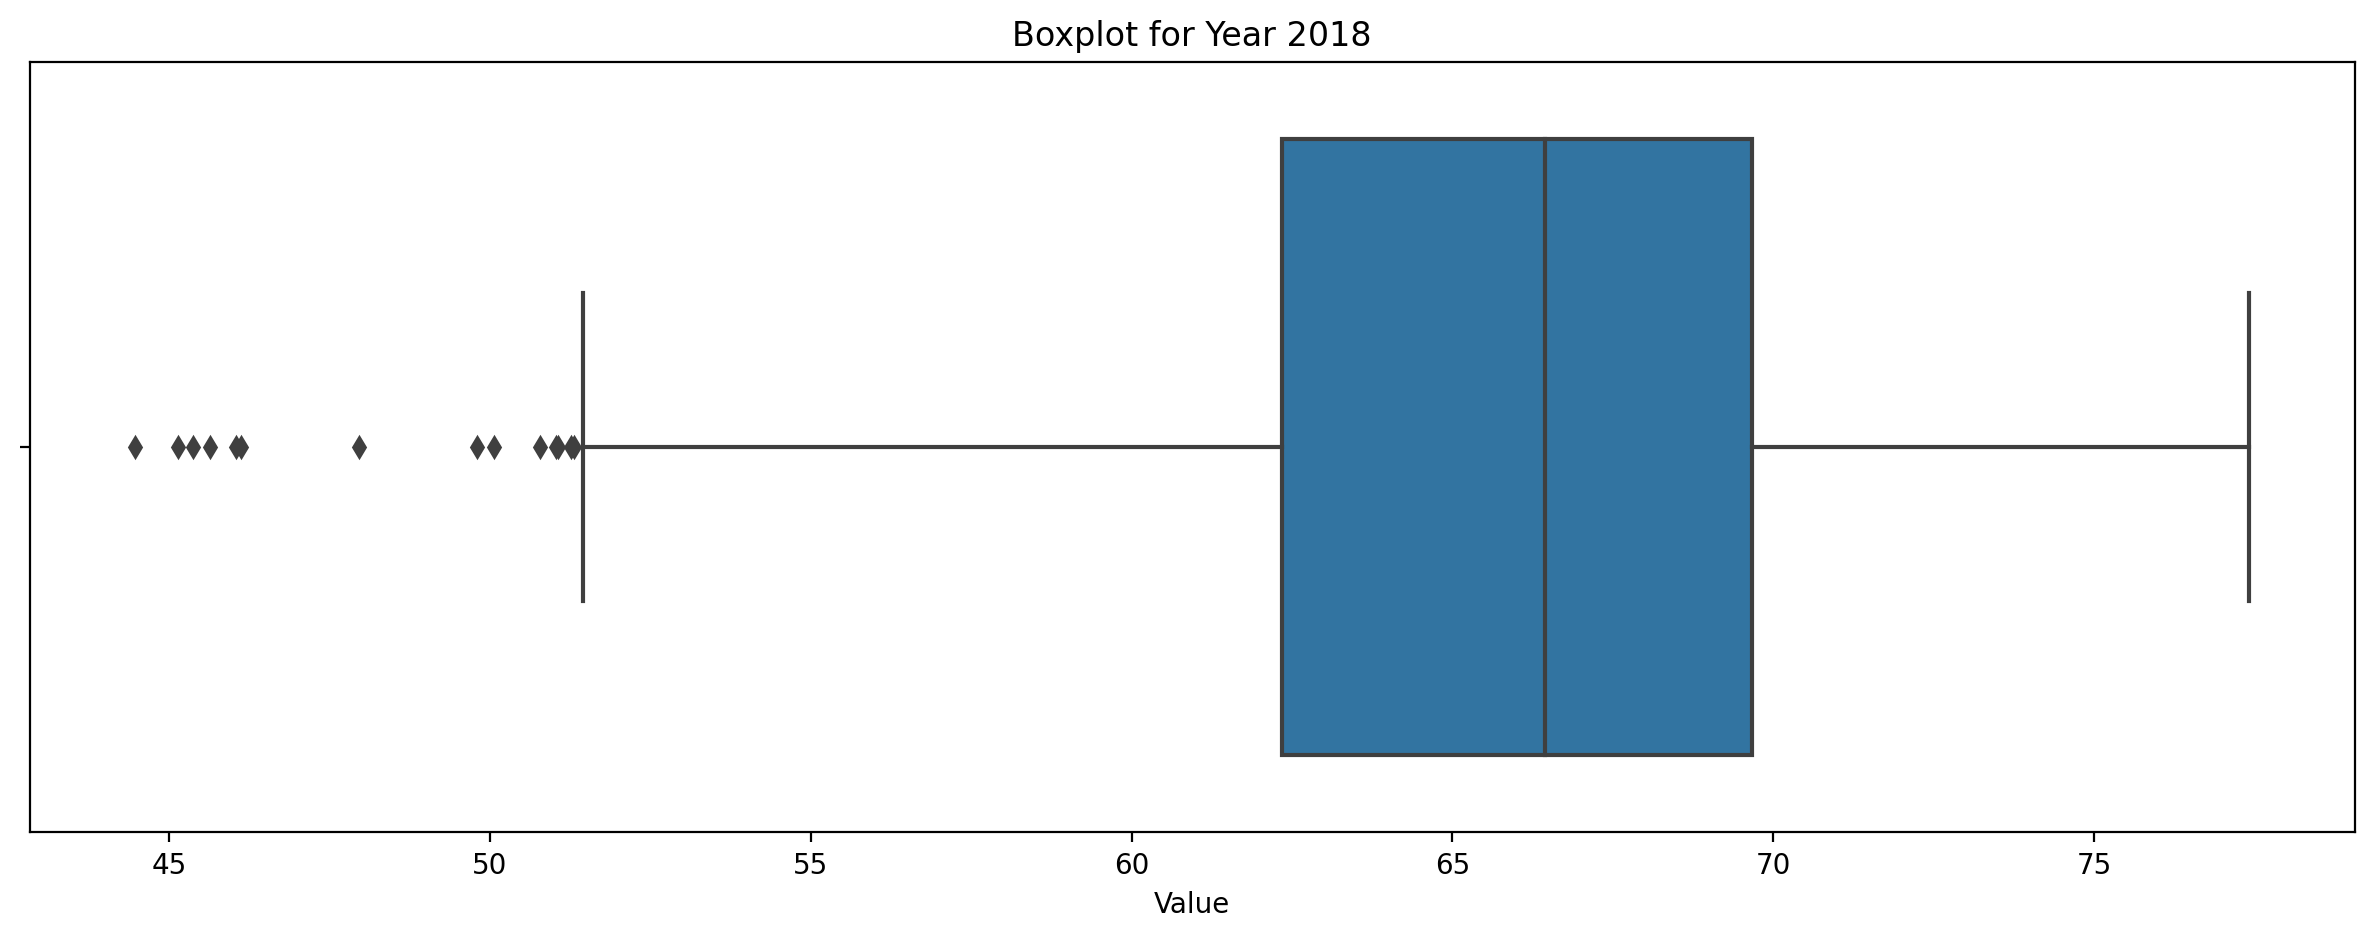

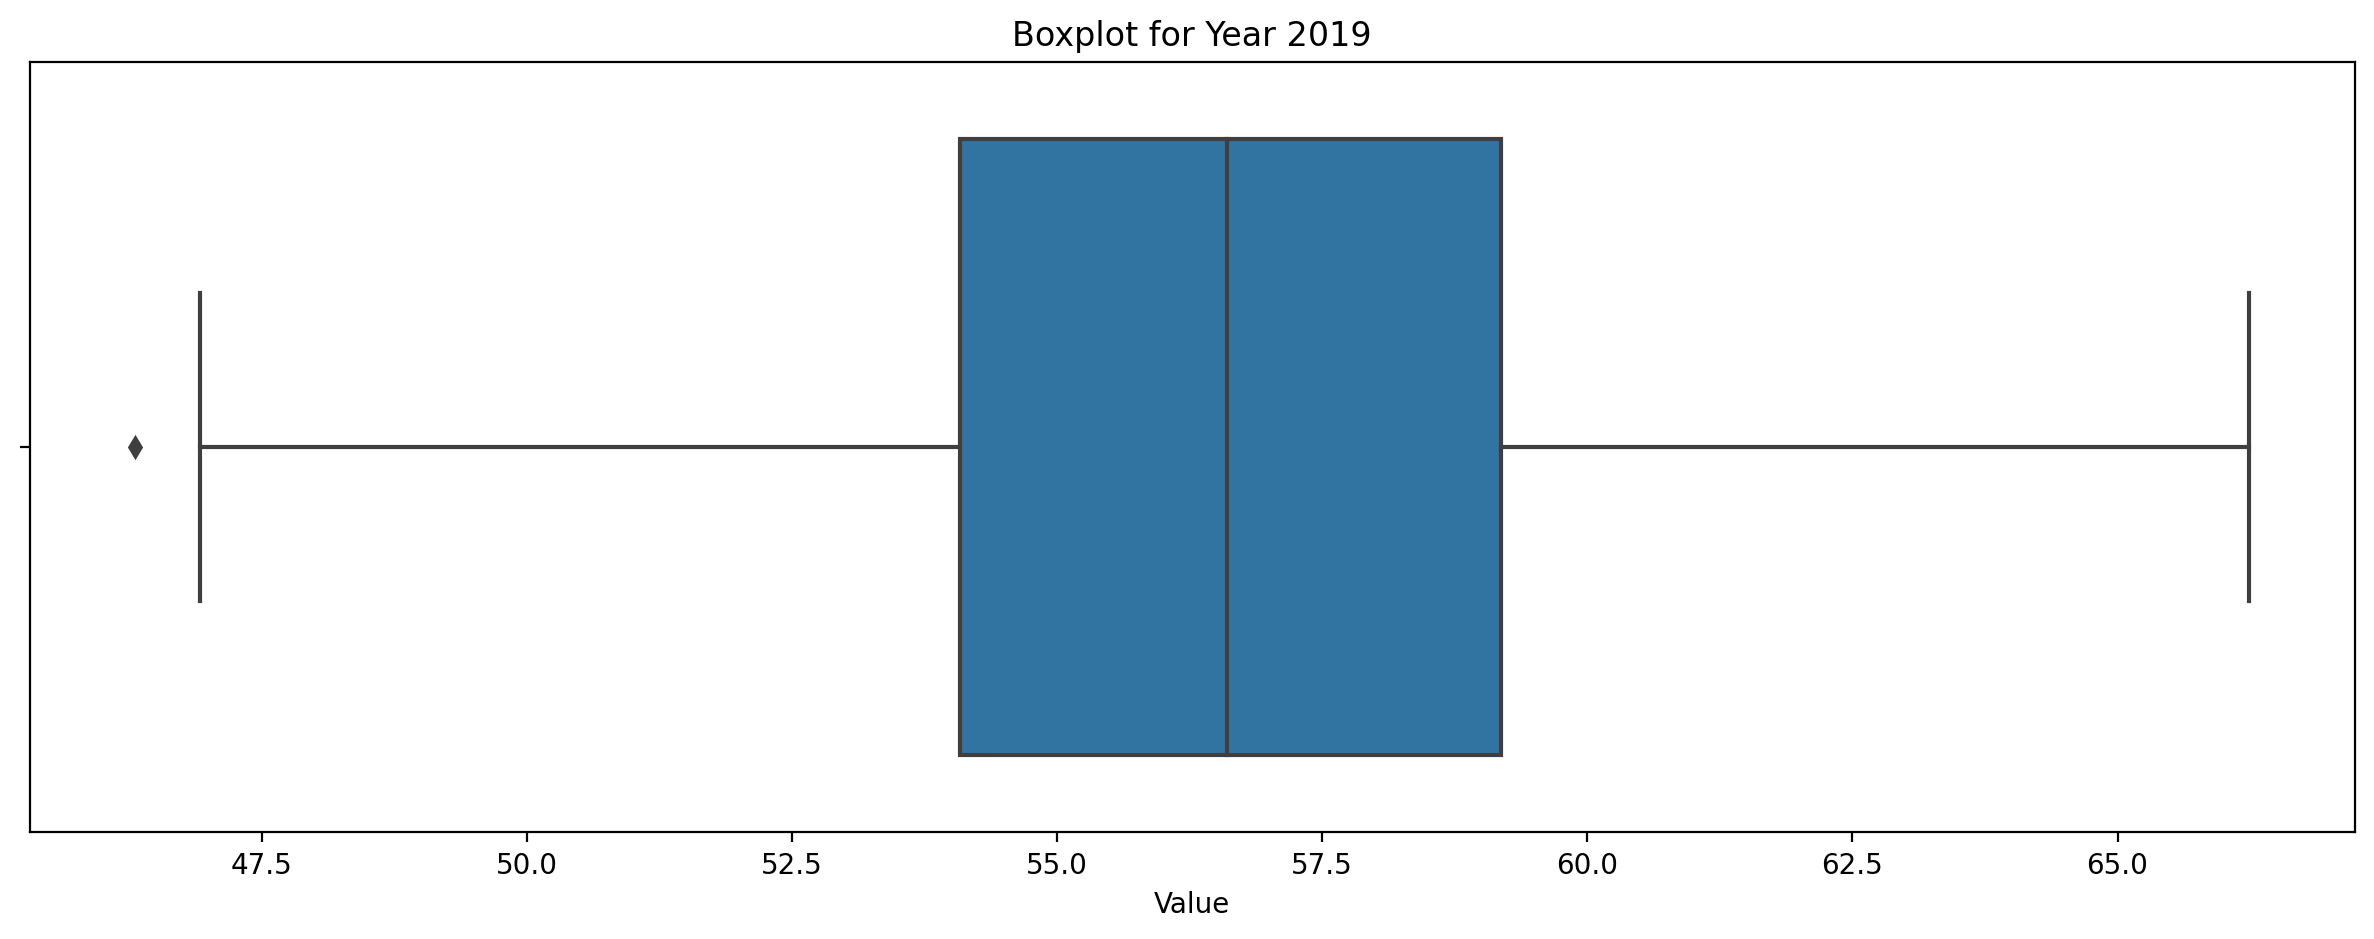

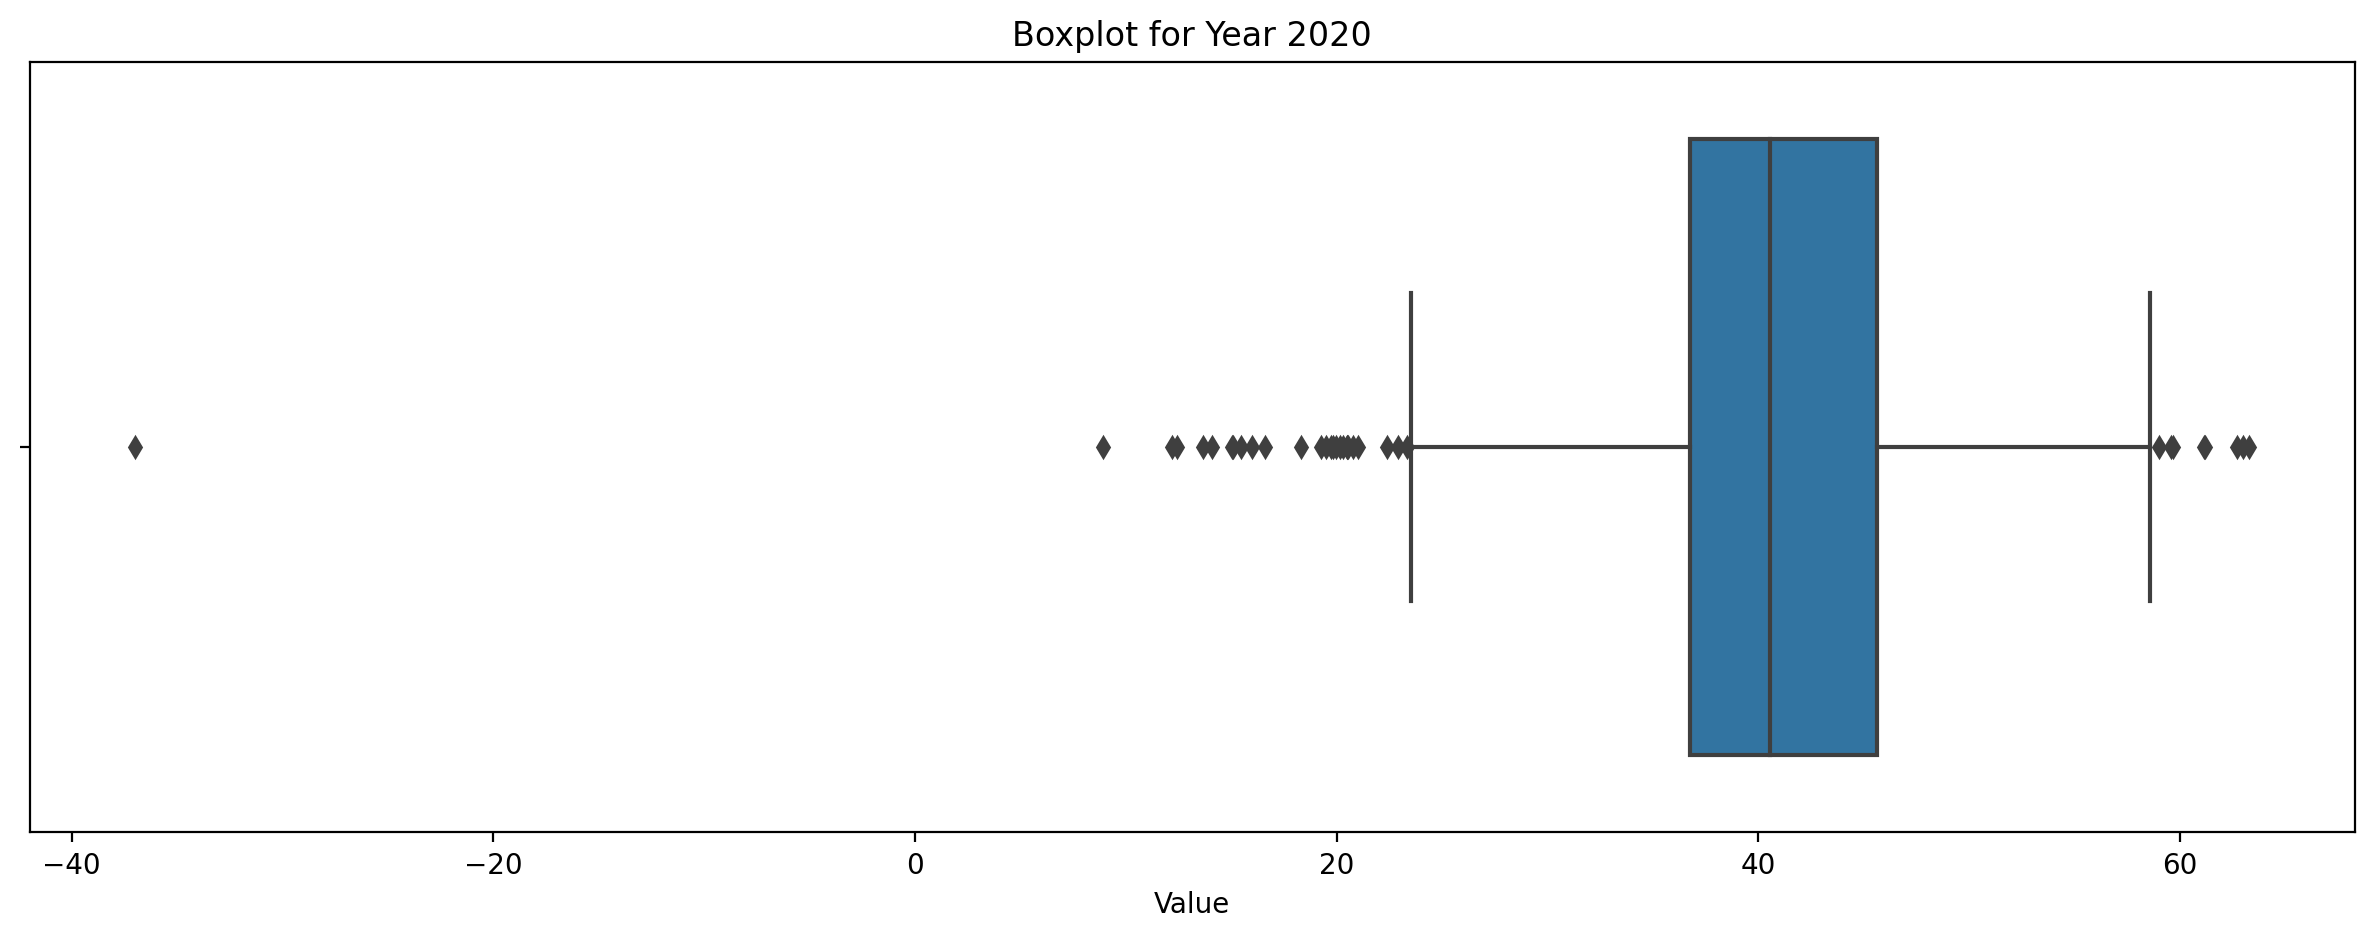

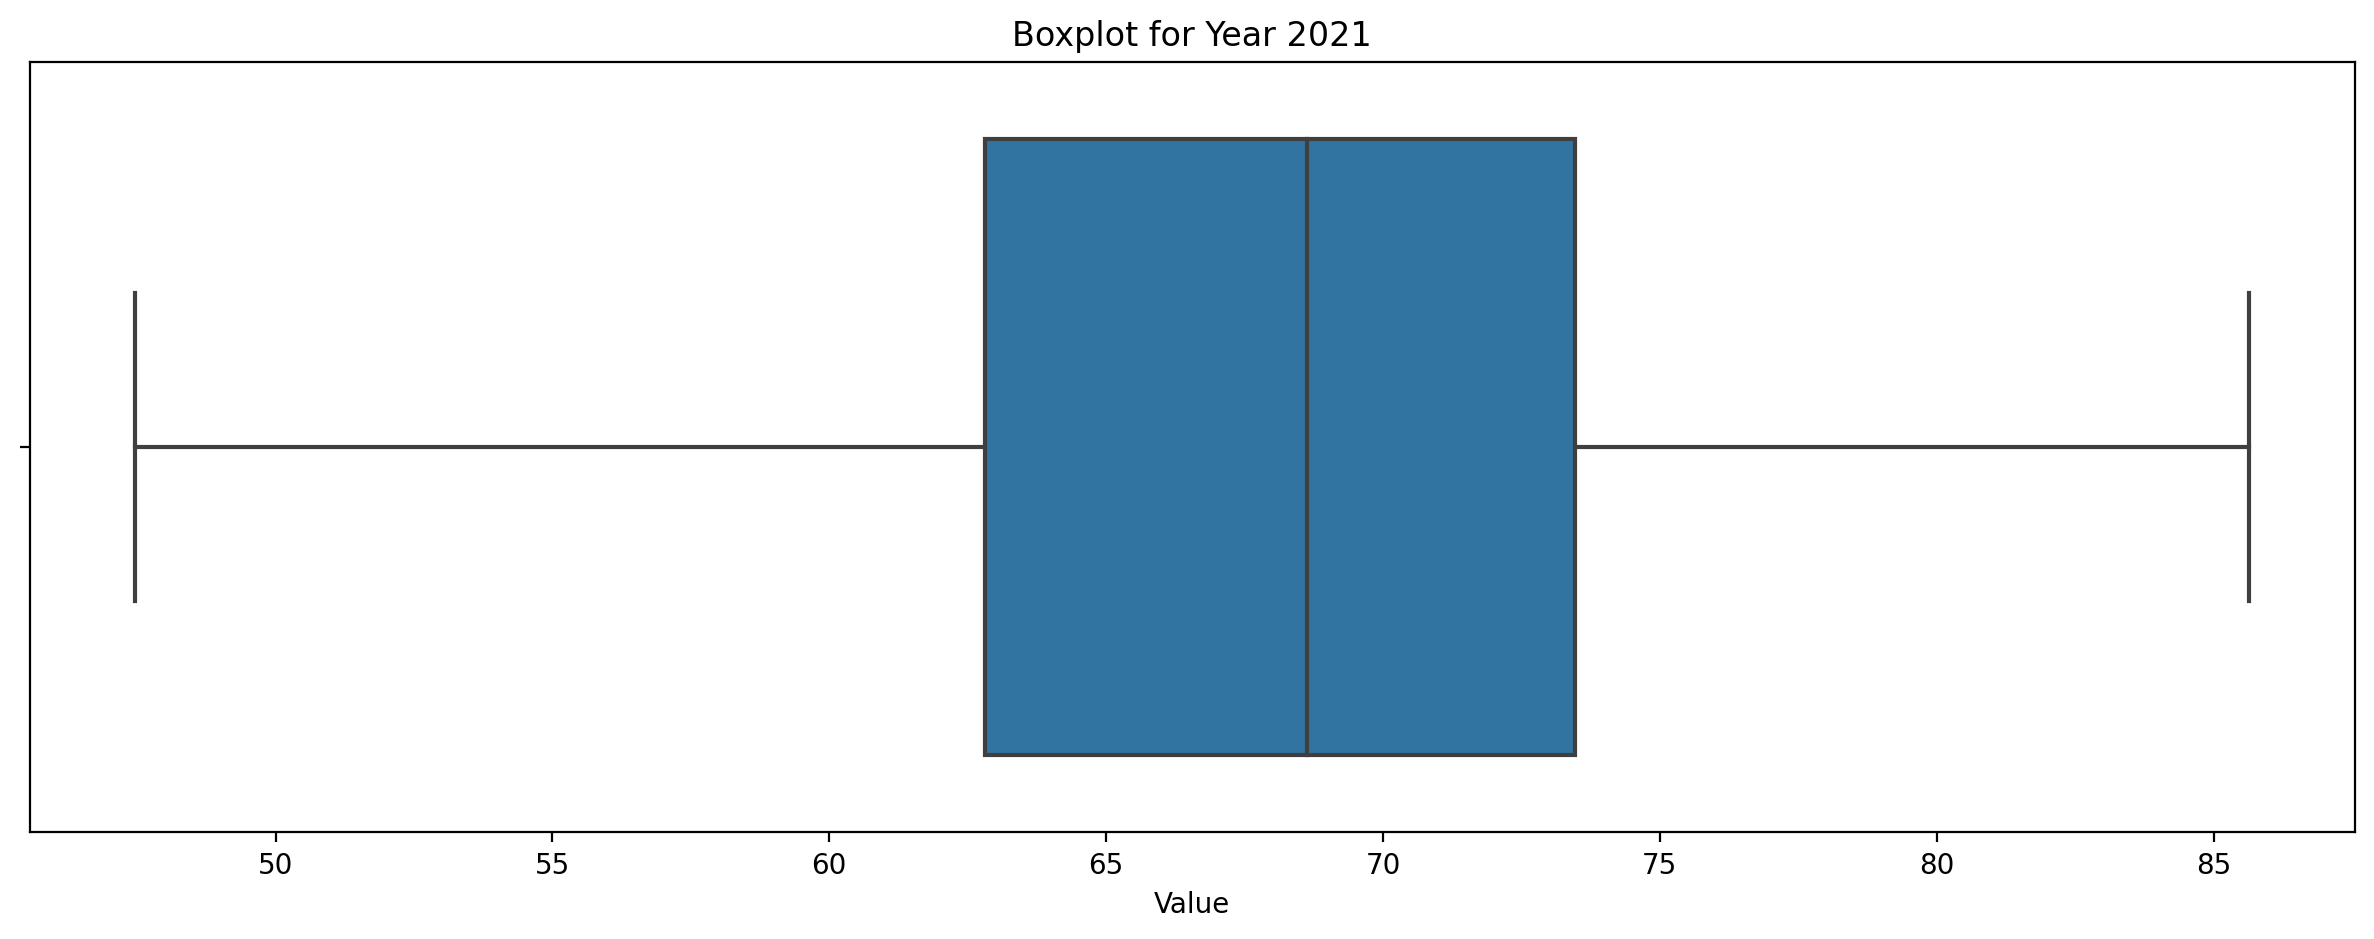

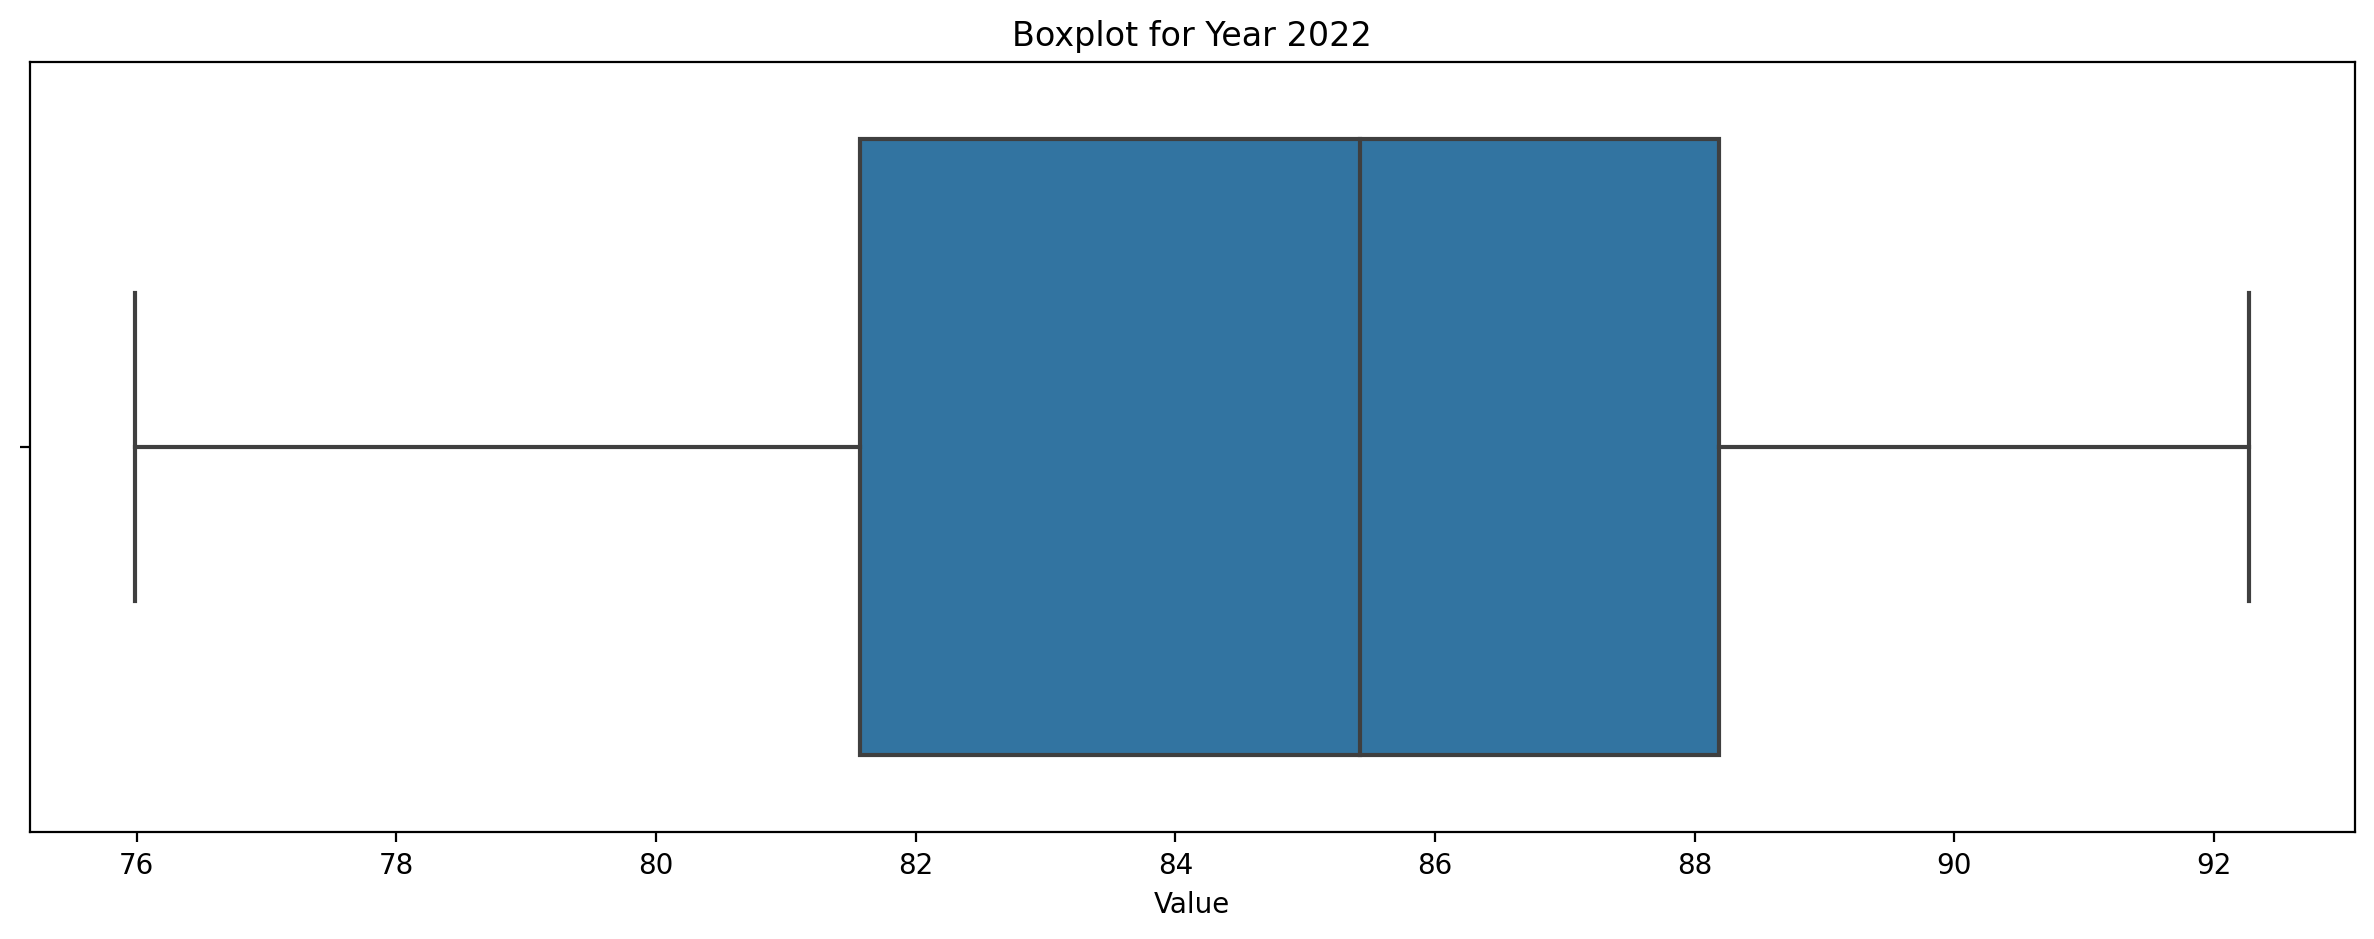

In [42]:
for Year, data in grouped_data:
    plt.figure()  # Create a new figure for each boxplot
    sns.boxplot(x='Value', data=data)
    plt.title(f'Boxplot for Year {Year}')
    plt.show()

## Capping Outliers

In [43]:
selected_years = [1986, 1987, 1989, 1991, 1997, 2002, 2003, 2008, 2014, 2016, 2018, 2019, 2020]

for year in selected_years:
    year_data = df[df['Date'].dt.year == year]  # Filter data for the specific year
    lower_limit, upper_limit = outlier_detection(year_data, 'Value')  # Apply outlier detection

    # Apply capping to outliers
    year_data.loc[year_data['Value'] < lower_limit, 'Value'] = lower_limit
    year_data.loc[year_data['Value'] > upper_limit, 'Value'] = upper_limit

    # Update the modified year data in the main DataFrame
    df.update(year_data)

<Axes: xlabel='Year', ylabel='Value'>

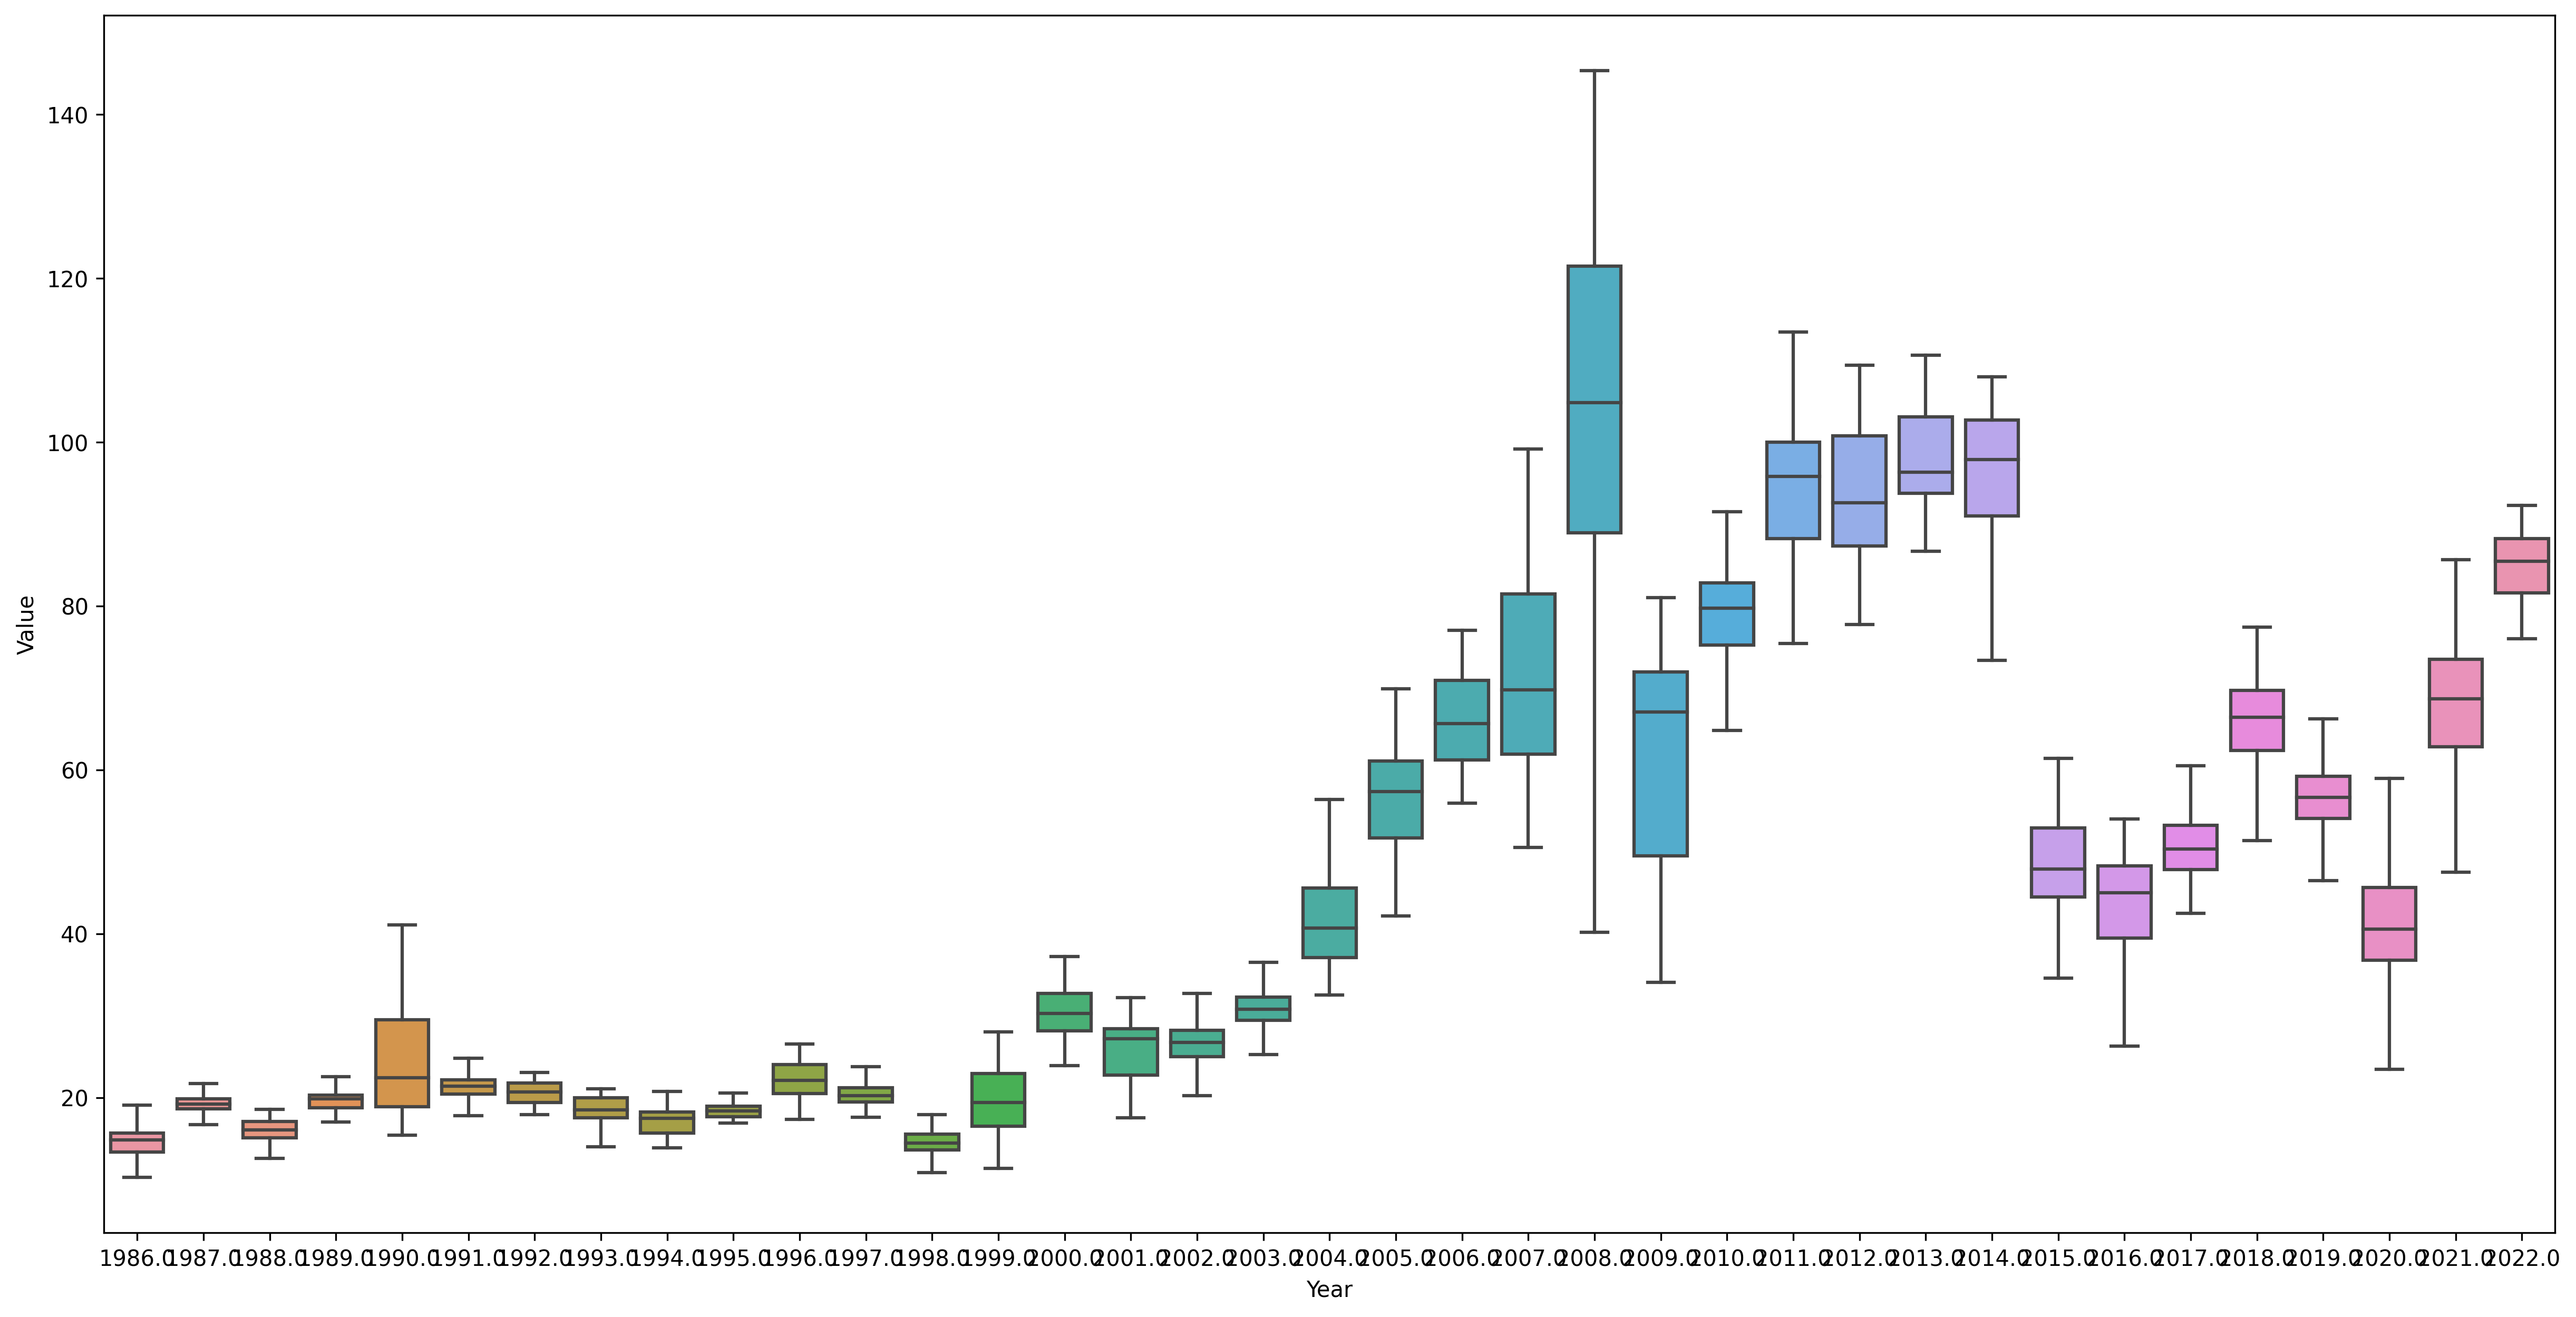

In [44]:
# Checking year wise outliere
fig, axes = plt.subplots(figsize=(20,10), dpi=300)
sns.boxplot(x='Year', y='Value', data=df)

### By employing the capping method, outliers within a dataset are effectively substituted with the upper and lower extremes of the data distribution. This method involves identifying extreme values in the dataset, often referred to as outliers, and replacing them with predetermined thresholds that serve as upper and lower limits.

# Time series decomposition
## Additive seasonal decomposition

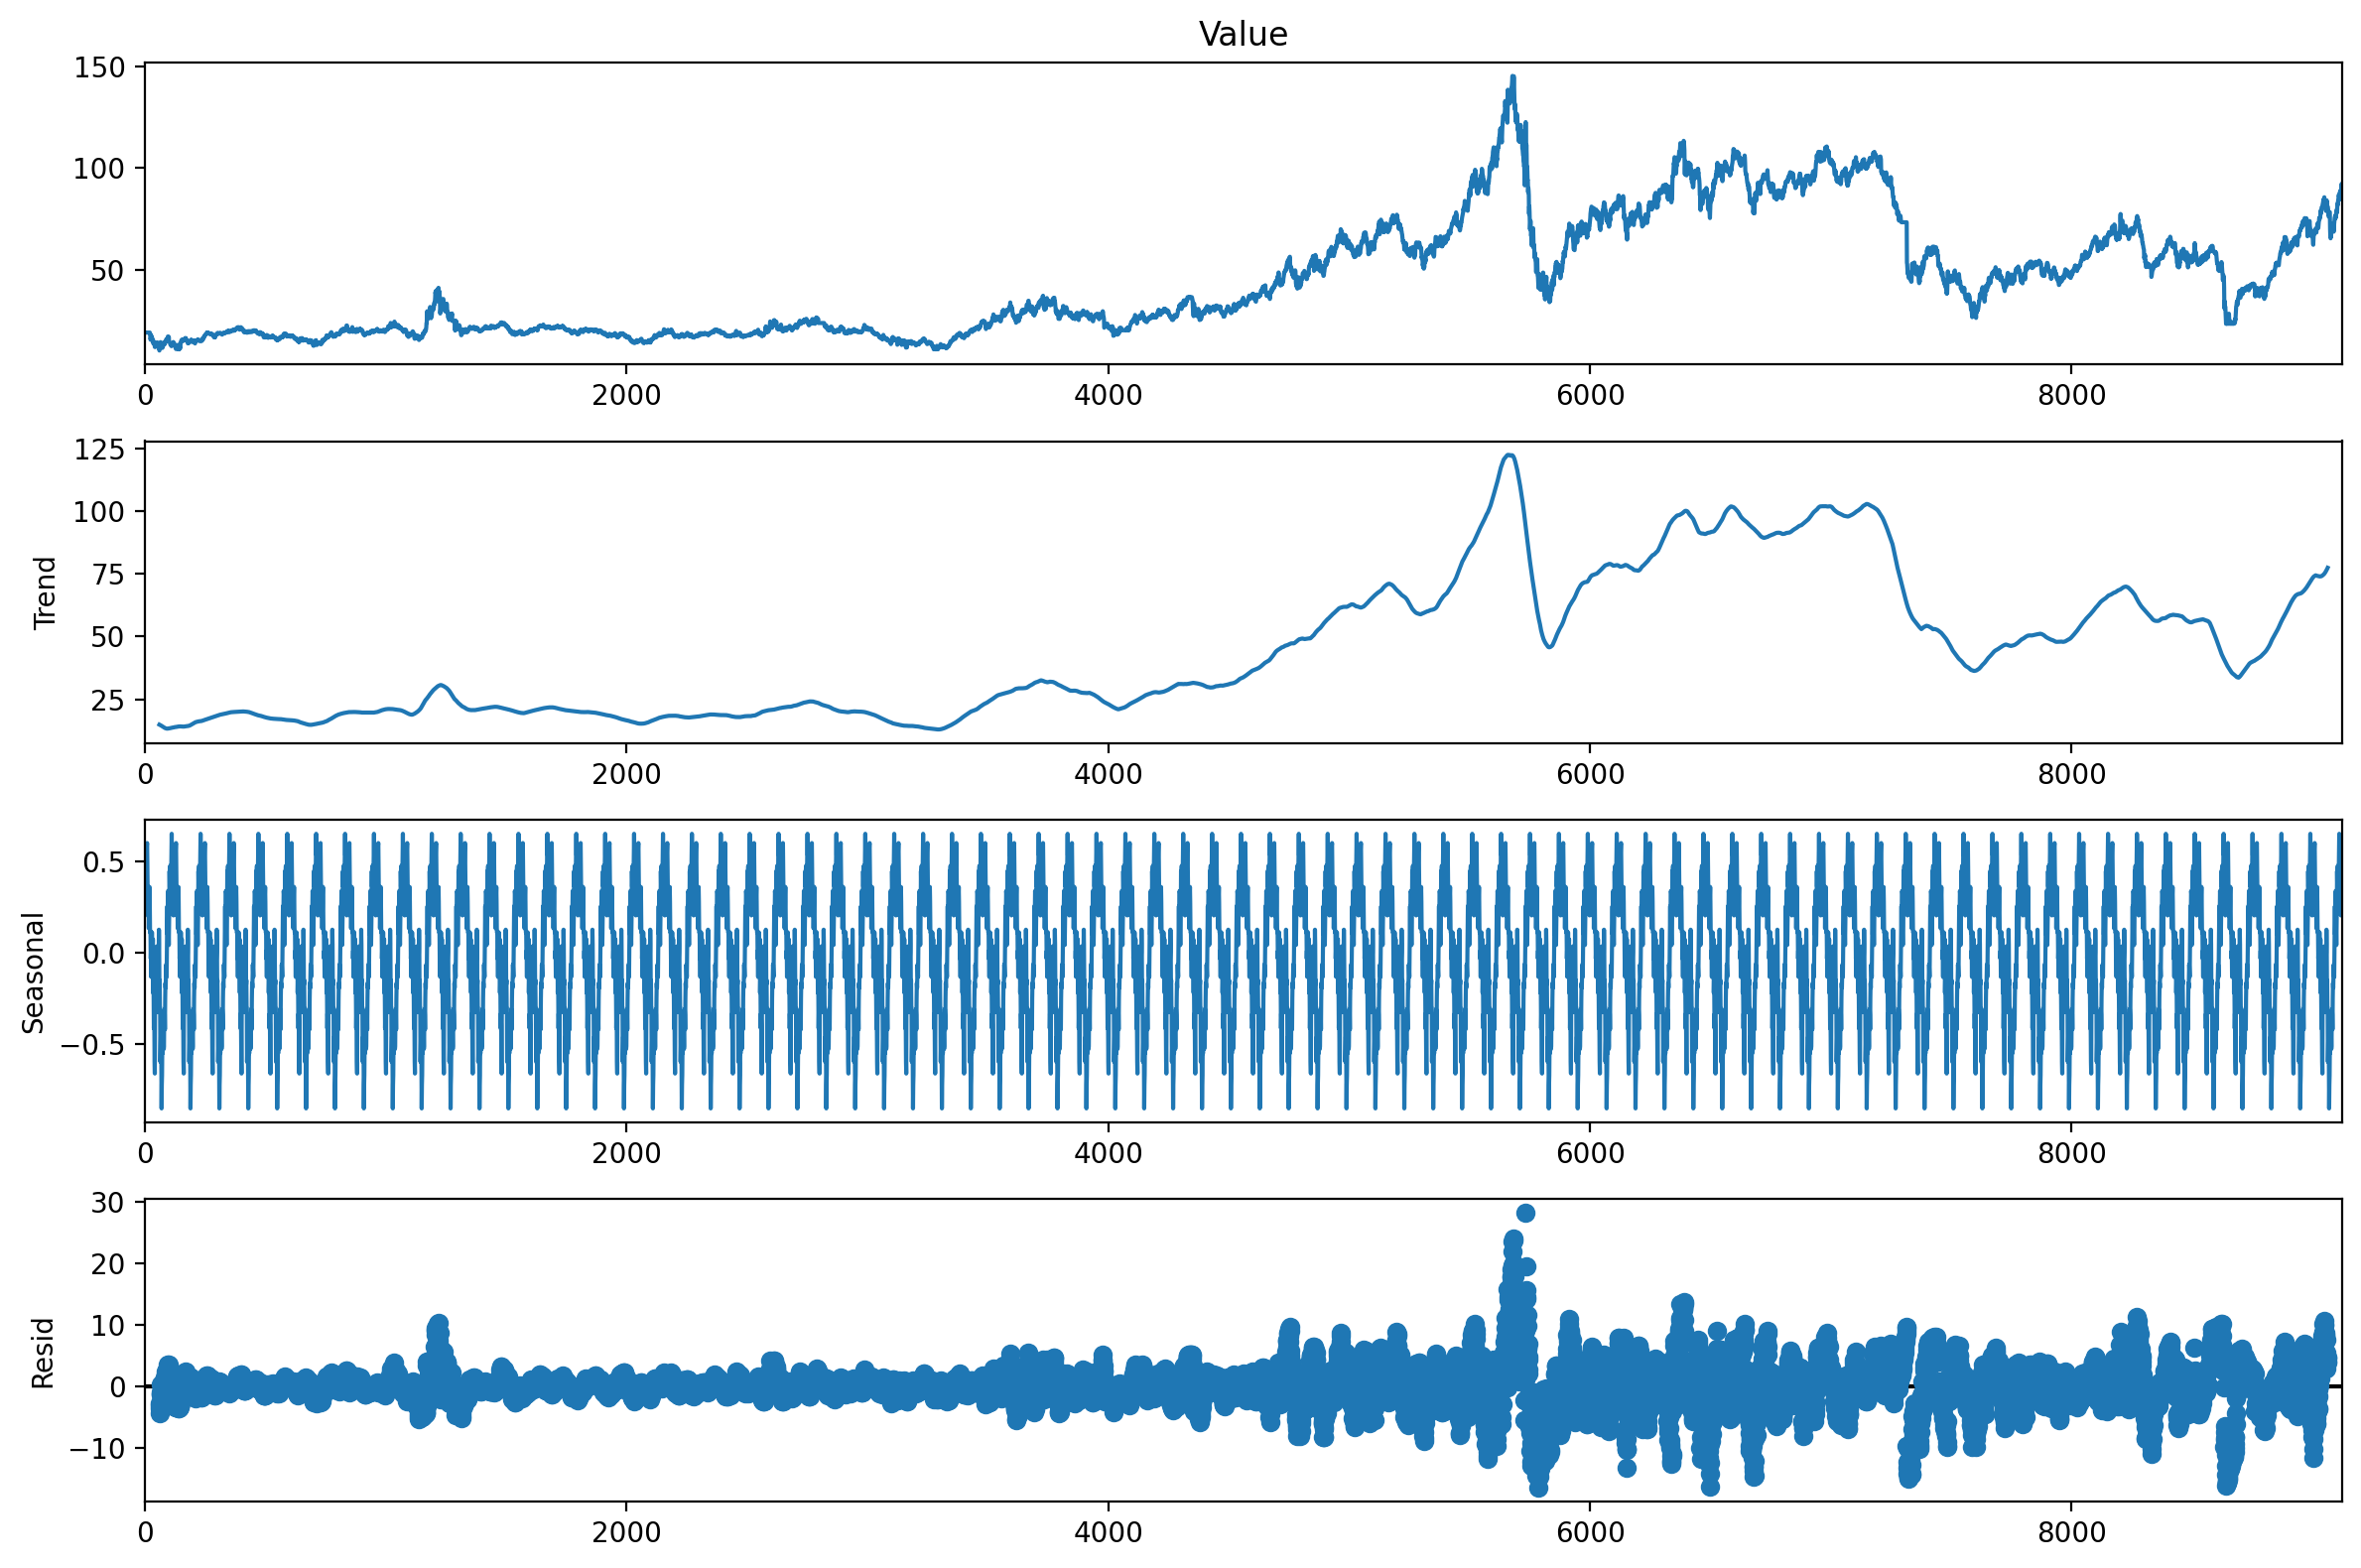

In [45]:
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(df['Value'], model='additive',period=120)
fig = decomposition.plot()
plt.show()

#### Analysis:- Observed - Actual data

**Trend** - Increasing or decreasing trend.

**Seasonal** - Varies from +0.5 to -0.5 with the mean 0. Each cycle represents each year trend. The value in the Y-axis has to be added to the Trend plot value to get the actual value of that year. E.g.:- For the year 1988 Nov, the seasonal value is +0.5 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 0.5+100 = 100.5

**Residual** - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

## Multiplicative seasonal decomposition

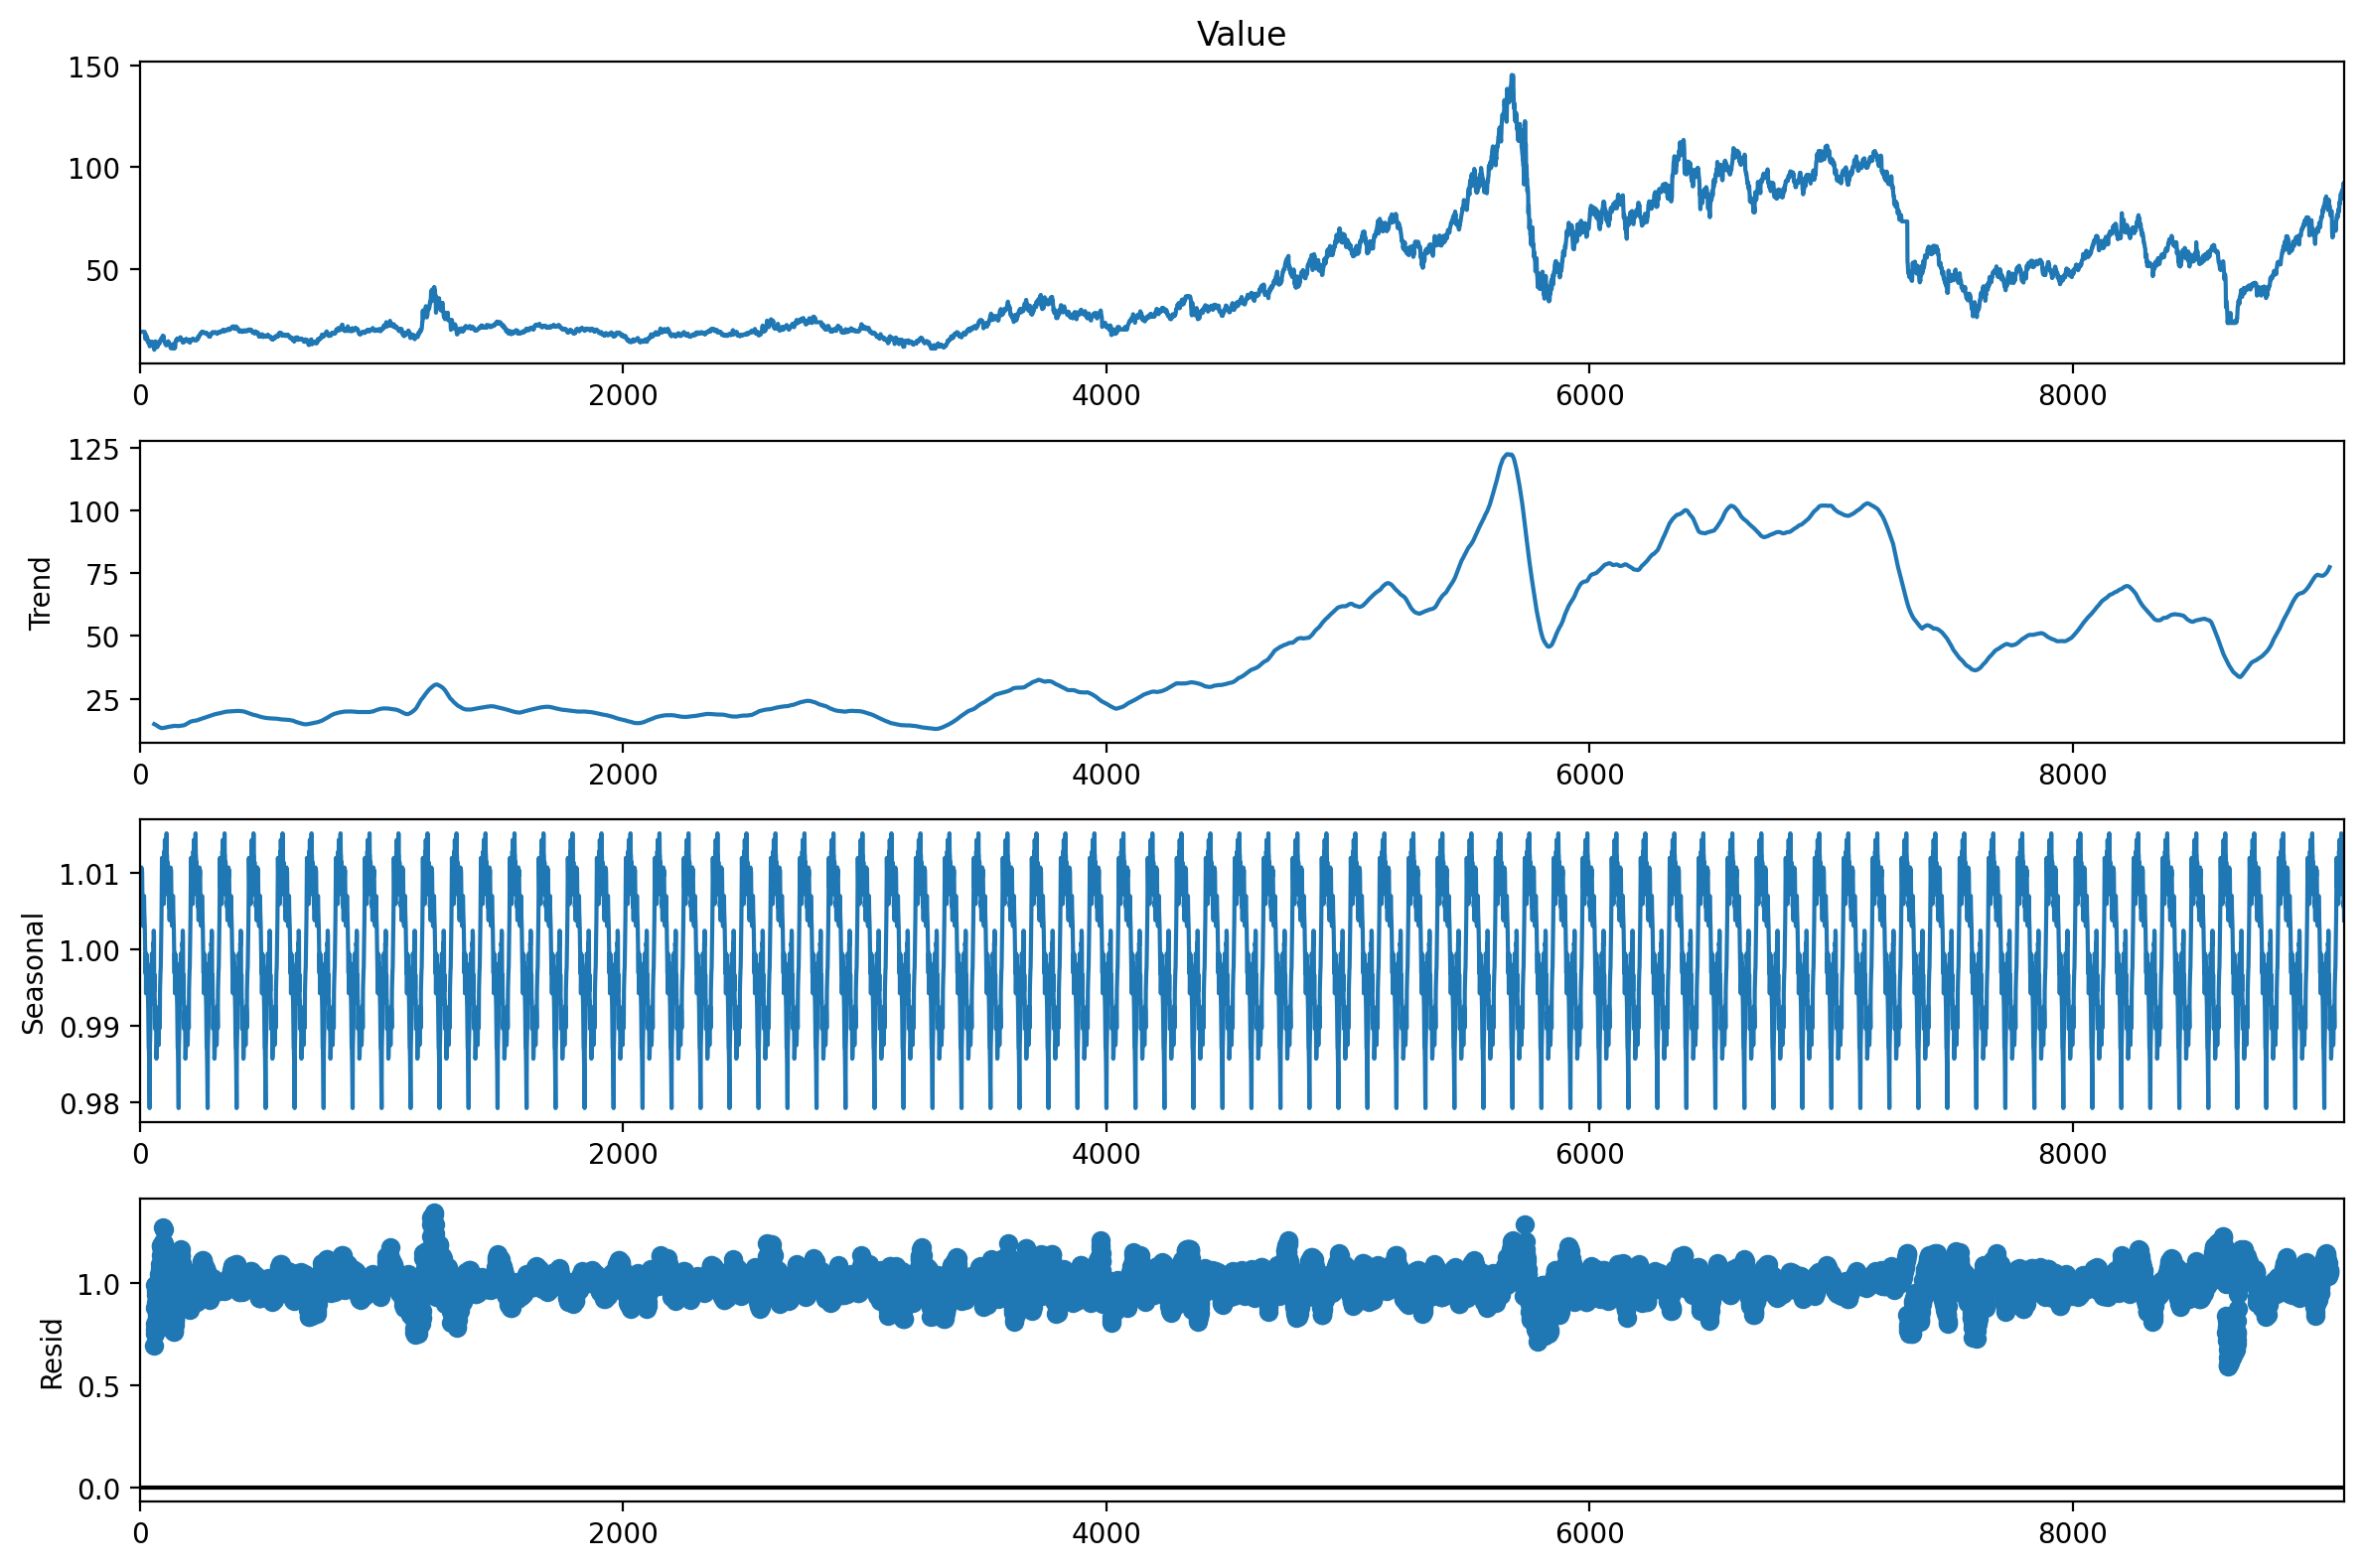

In [46]:
decomposition = sm.tsa.seasonal_decompose(df['Value'], model='multiplicative',period=120)
fig = decomposition.plot()
plt.show()

#### Analysis:- Seasonal -

Varies from 0.98 to 1.01 The value in the Y-axis has to be multiplied to the Trend plot value to get the actual value of that year. E.g.:- For the year 1988 Nov, the seasonal value is 1.01 and the trend value is 100. Hence, the actual value(price) will (seasonal X Trend) value = 1.01 X 100 = 101

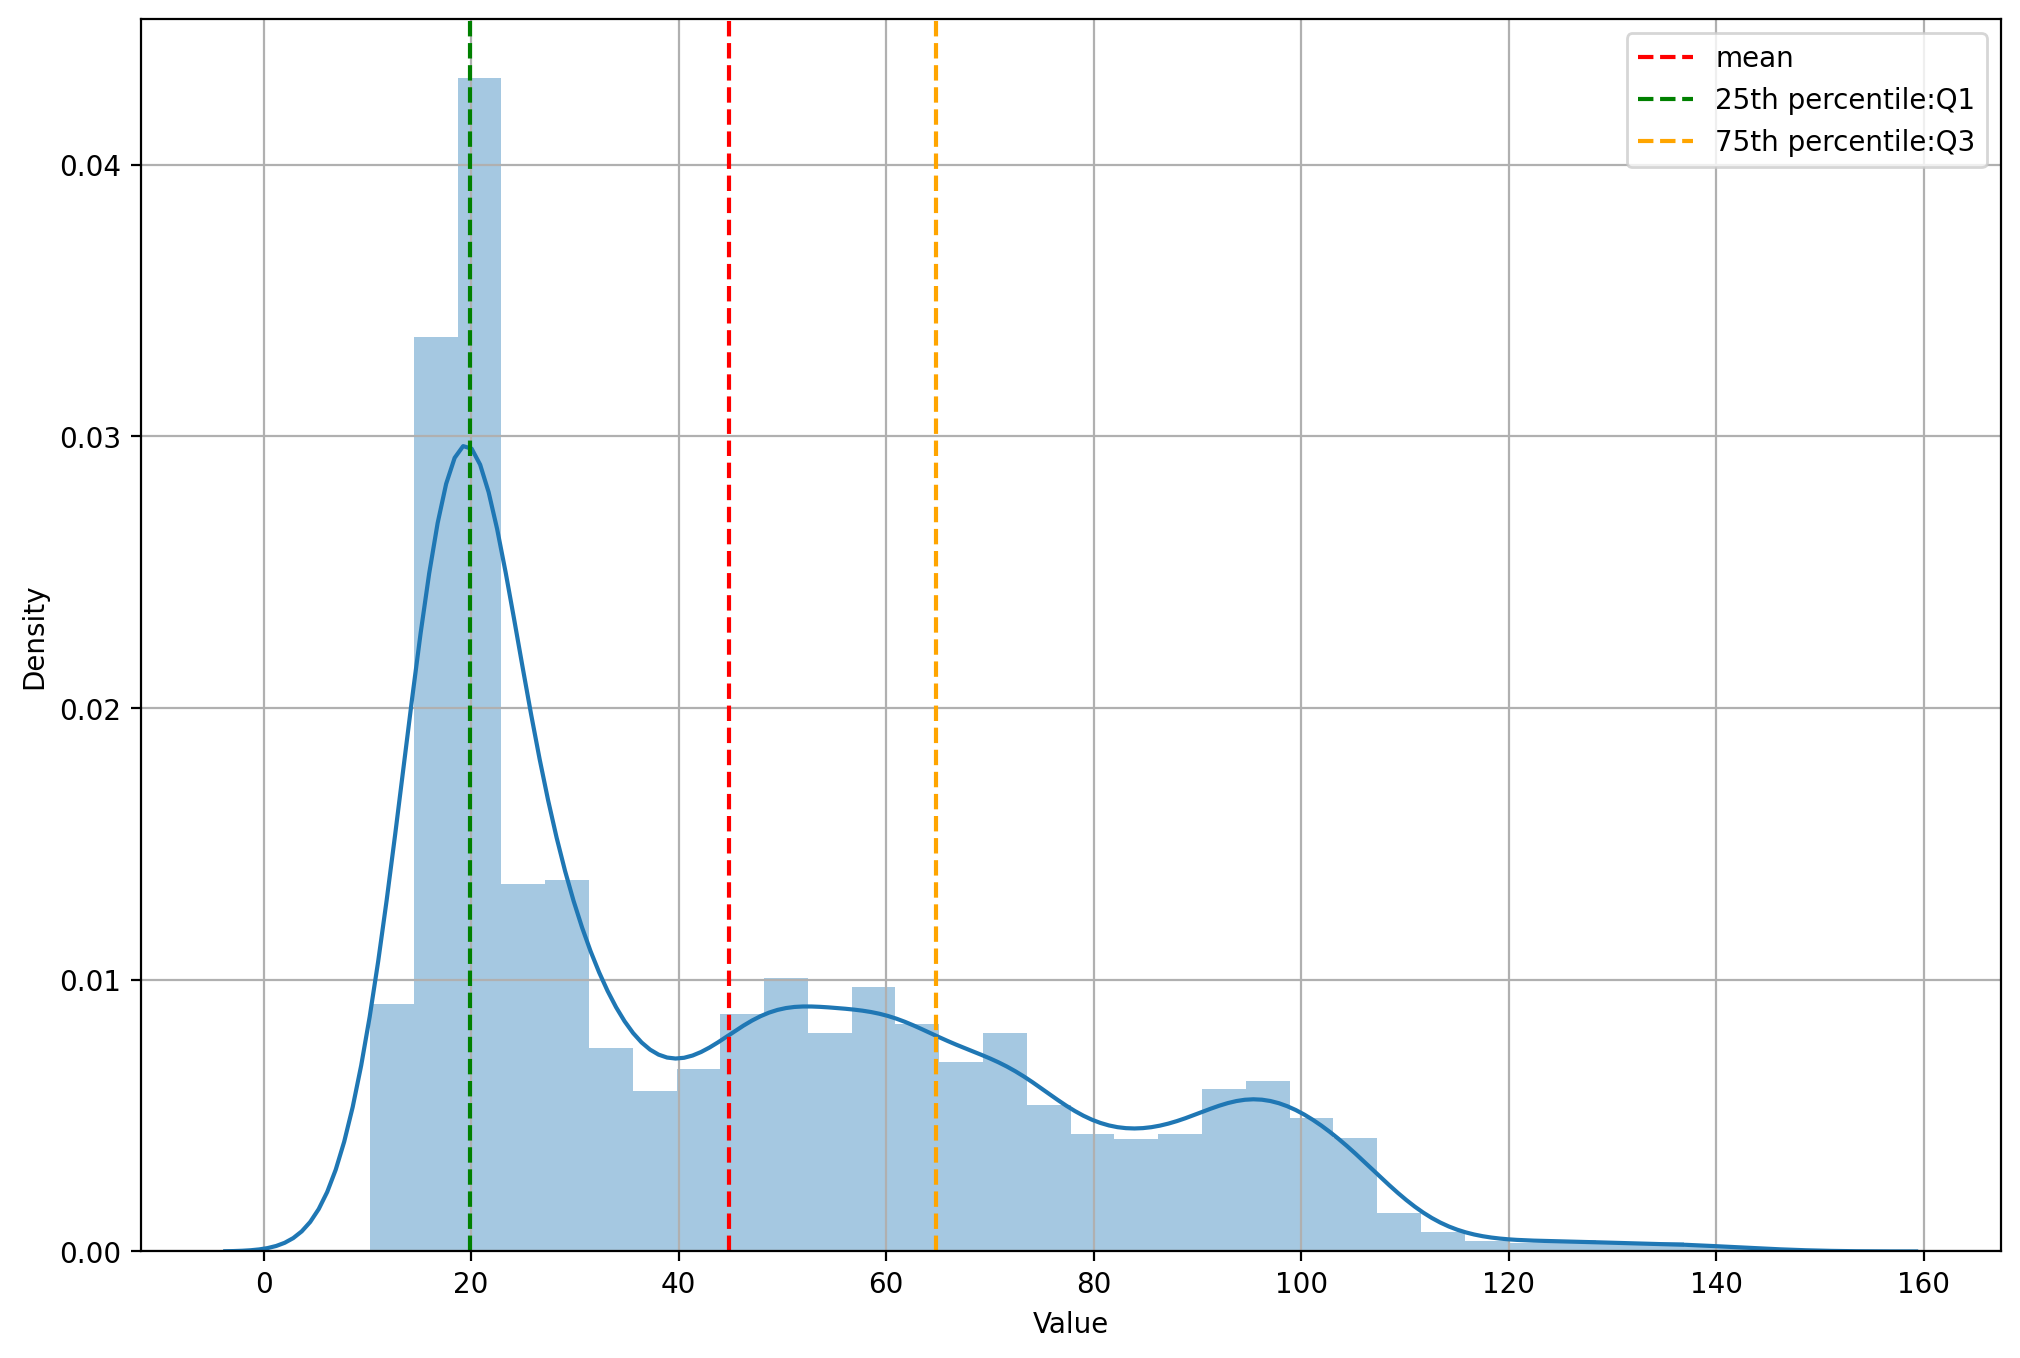

In [47]:
sns.distplot(df['Value'])
plt.axvline(x=np.mean(df['Value']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['Value'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['Value'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()
plt.grid()

#### We can see from above's Displot Data is not Normally Distibuted.

In [48]:
df.corr()

Value      Year
Value  1.000000  0.707187
Year   0.707187  1.000000

<function matplotlib.pyplot.show(close=None, block=None)>

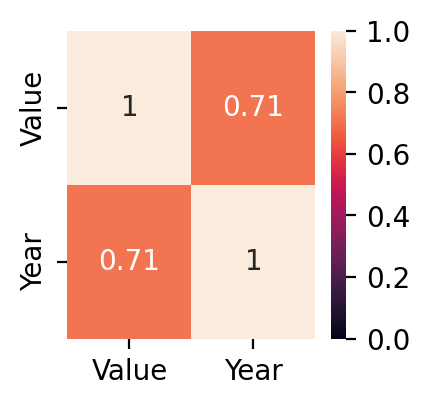

In [49]:
# Correlation plot

corr_matrix=df.corr()
plt.figure(figsize=(2,2))
sns.heatmap(data=corr_matrix,annot=True,vmin=0)
plt.show

# Converting Non-Stationary to Stationary Time Series

In [50]:
df_log=np.sqrt(df['Value'])
df_diff=df_log.diff().dropna()
df_compare=df_log

In [51]:
adfuller(df_diff)[1]

0.0

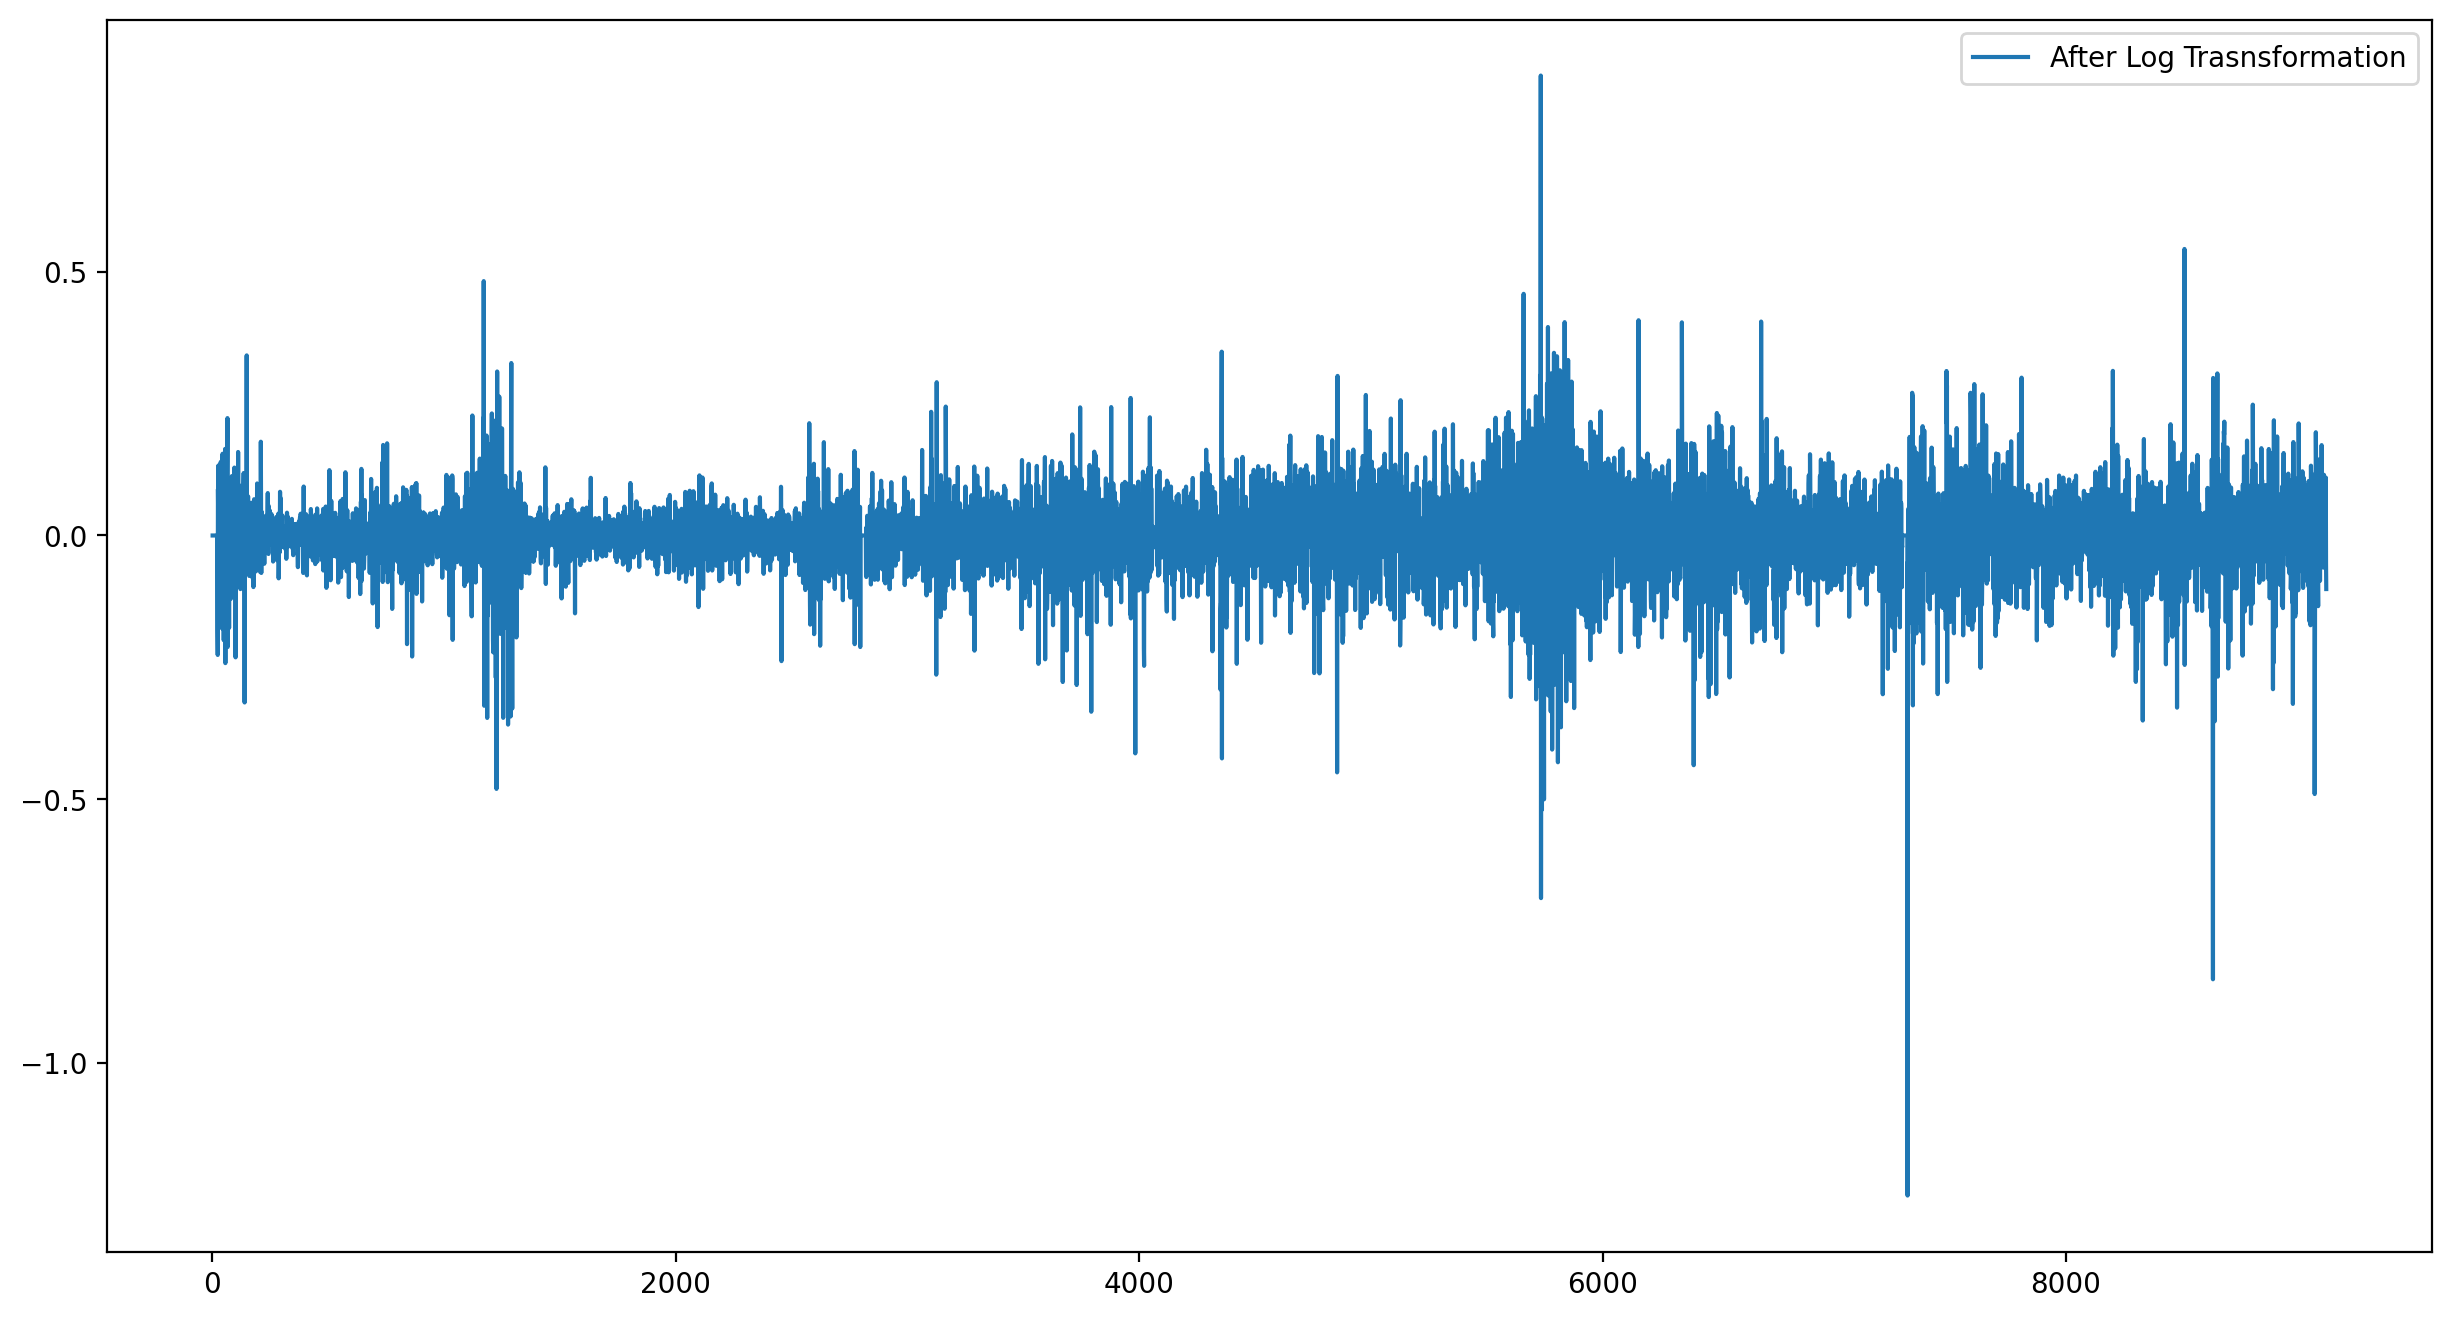

In [52]:
plt.figure(figsize=(15,8))
plt.plot(df_diff, label = 'After Log Trasnsformation')
plt.legend()
plt.show()

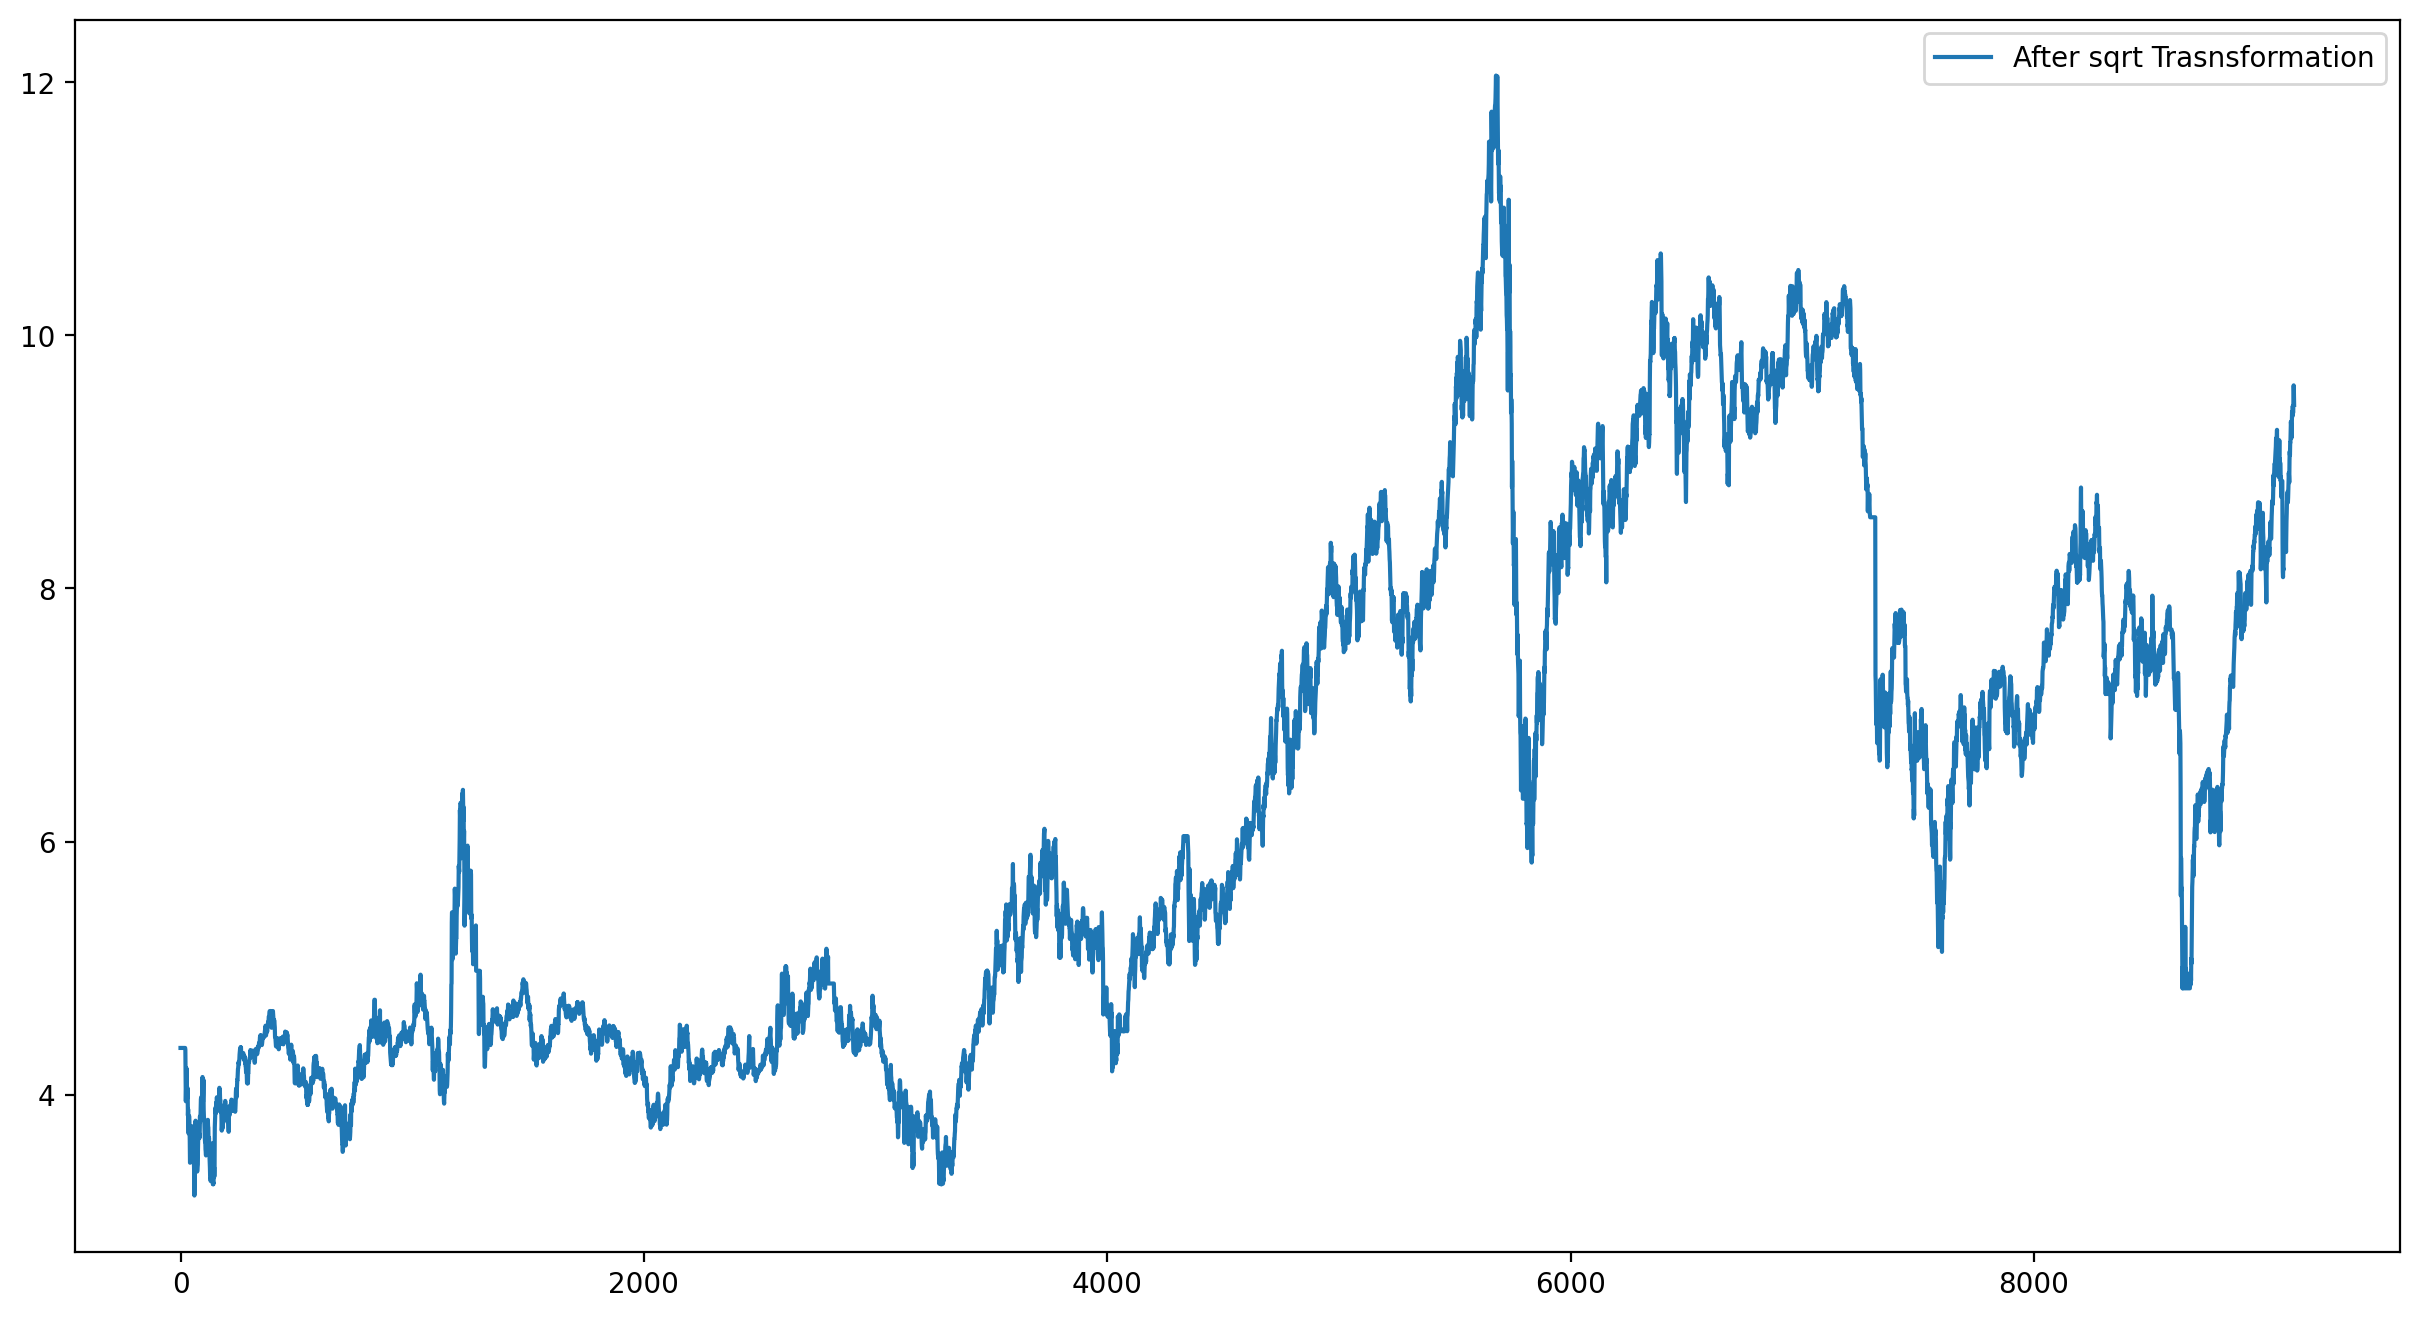

In [53]:
plt.figure(figsize=(15,8))
plt.plot(df_compare, label = 'After sqrt Trasnsformation')
plt.legend()
plt.show()

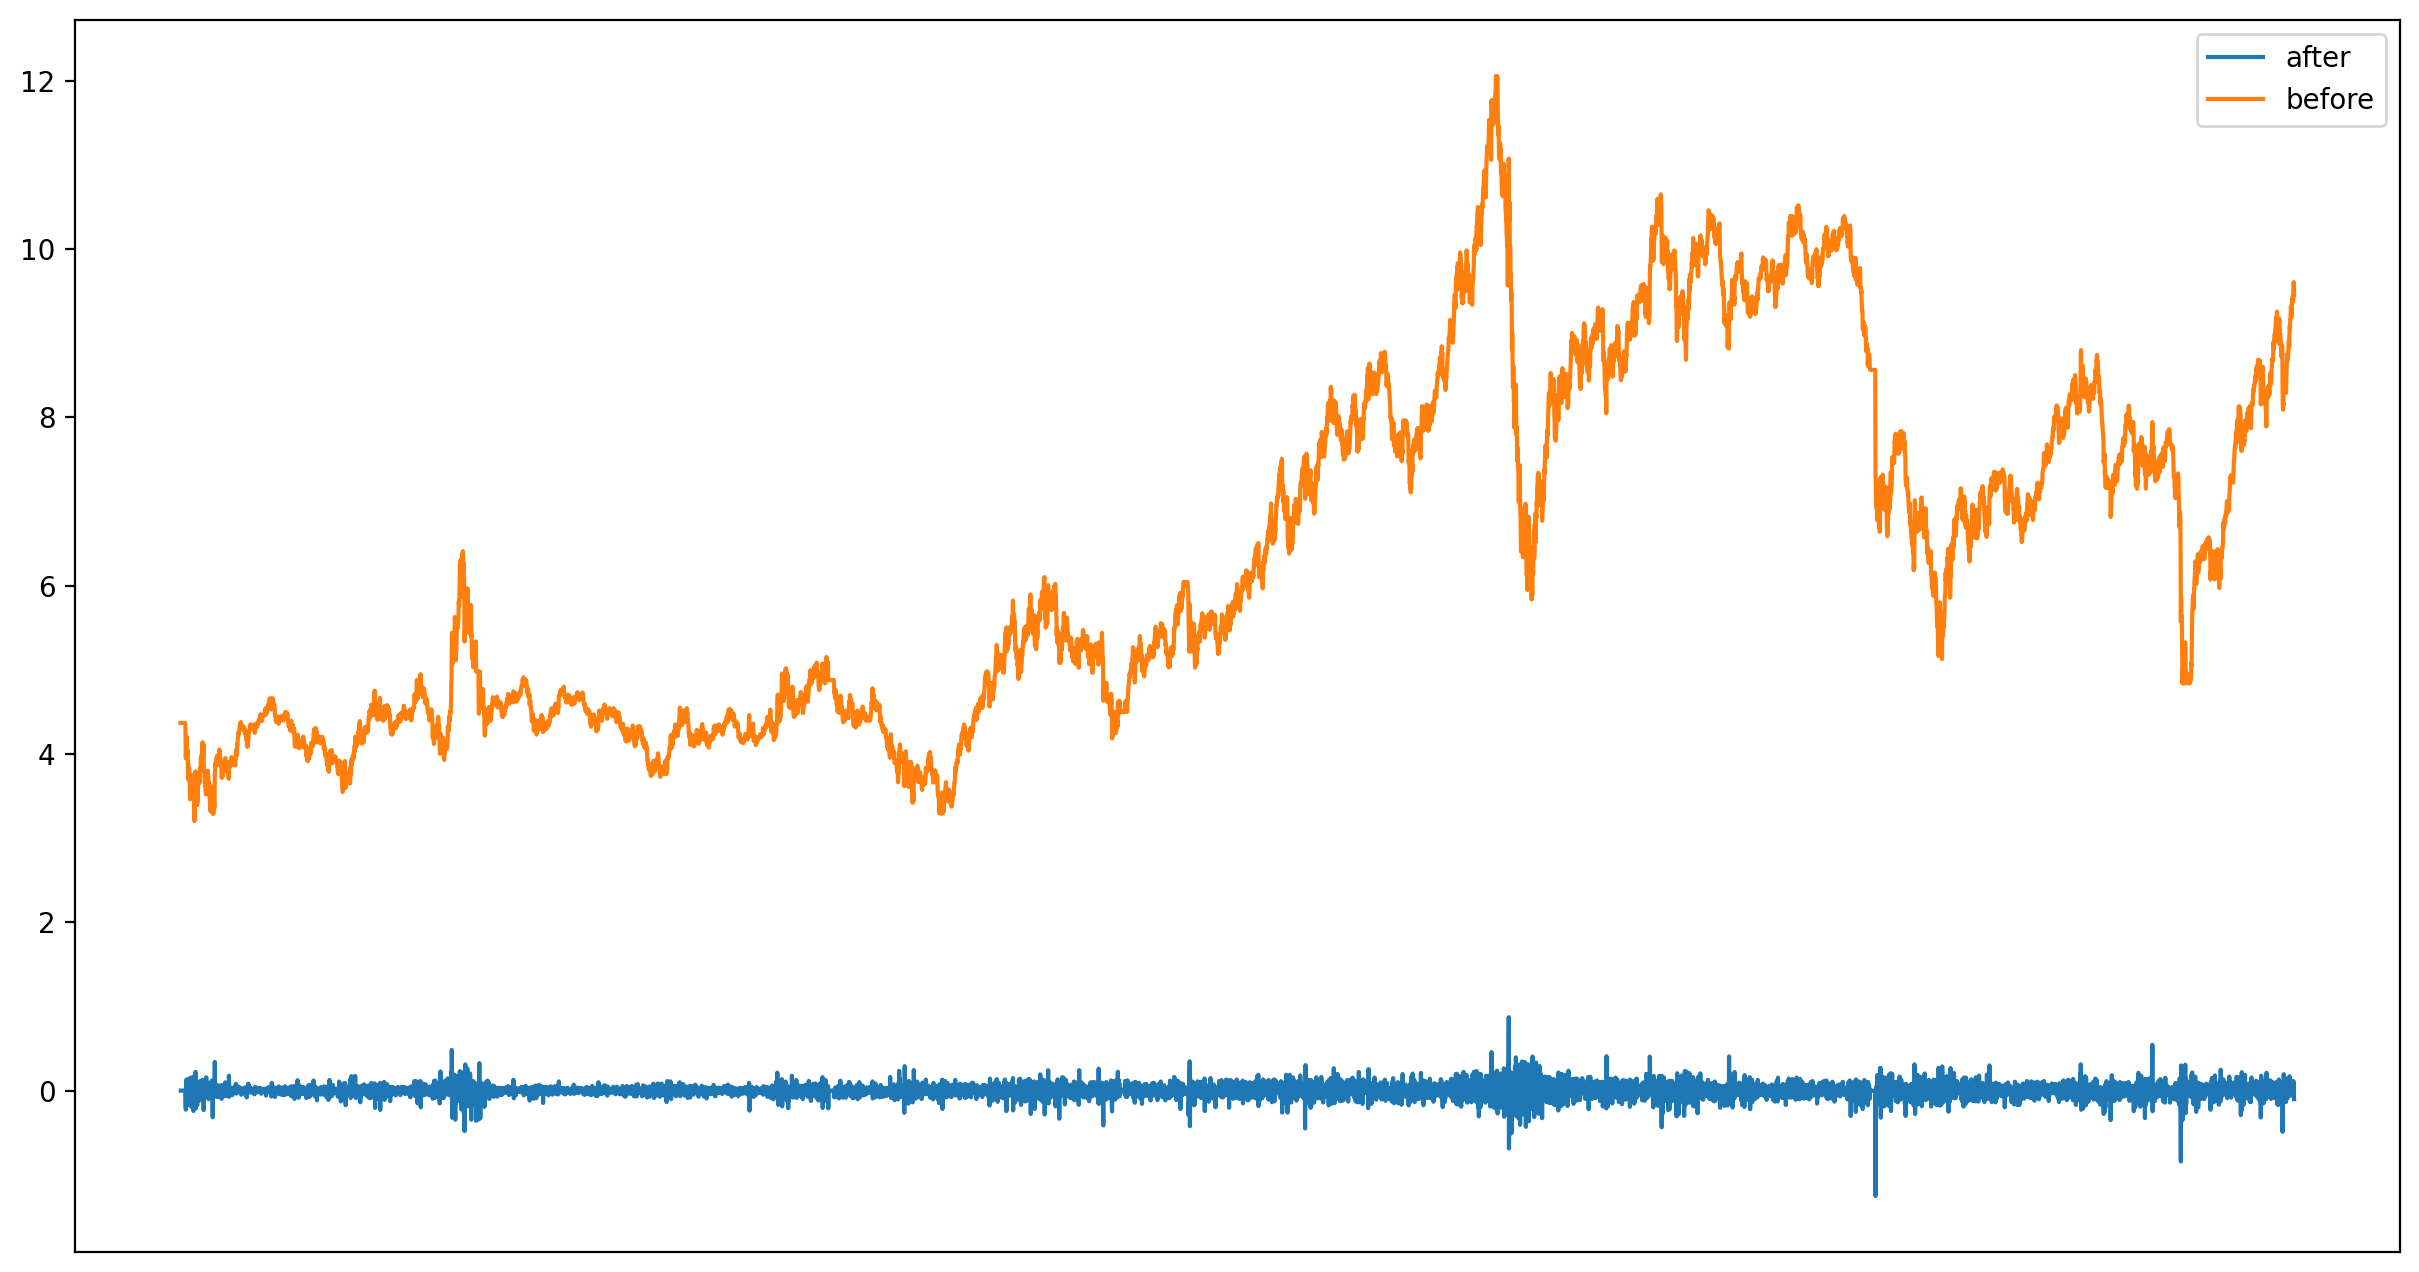

In [54]:
# Comparing both test Before Transformation and After Transformation
plt.figure(figsize=(15,8))
plt.plot(df_diff,label="after")
plt.plot(df_compare,label="before")
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend()
plt.show()

### **Analysis:**

#### As we can see Our Original Series and Before Transformation after Tranformation

## **2. Box Cox Transformation**

### Box-Cox transformation makes the variance constant in a series.

In [55]:
from scipy.stats import boxcox

In [56]:
df_eda=df.copy()
df_eda.set_index('Date',inplace=True)

In [57]:
df_eda

Value    Year
Date                       
1986-01-02  19.0825  1986.0
1986-01-03  19.0825  1986.0
1986-01-06  19.0825  1986.0
1986-01-07  19.0825  1986.0
1986-01-08  19.0825  1986.0
...             ...     ...
2022-02-02  88.1600  2022.0
2022-02-03  90.1700  2022.0
2022-02-04  92.2700  2022.0
2022-02-07  91.2500  2022.0
2022-02-08  89.3200  2022.0

[9124 rows x 2 columns]

In [58]:
df_eda

Value    Year
Date                       
1986-01-02  19.0825  1986.0
1986-01-03  19.0825  1986.0
1986-01-06  19.0825  1986.0
1986-01-07  19.0825  1986.0
1986-01-08  19.0825  1986.0
...             ...     ...
2022-02-02  88.1600  2022.0
2022-02-03  90.1700  2022.0
2022-02-04  92.2700  2022.0
2022-02-07  91.2500  2022.0
2022-02-08  89.3200  2022.0

[9124 rows x 2 columns]

In [59]:
# Creating a new dataset with the boxcox
data_boxcox=pd.DataFrame()
data_boxcox['Value'] = pd.Series(boxcox(df_eda['Value'], lmbda=0), df_eda.index)
display(data_boxcox.head())


Value
Date                
1986-01-02  2.948772
1986-01-03  2.948772
1986-01-06  2.948772
1986-01-07  2.948772
1986-01-08  2.948772

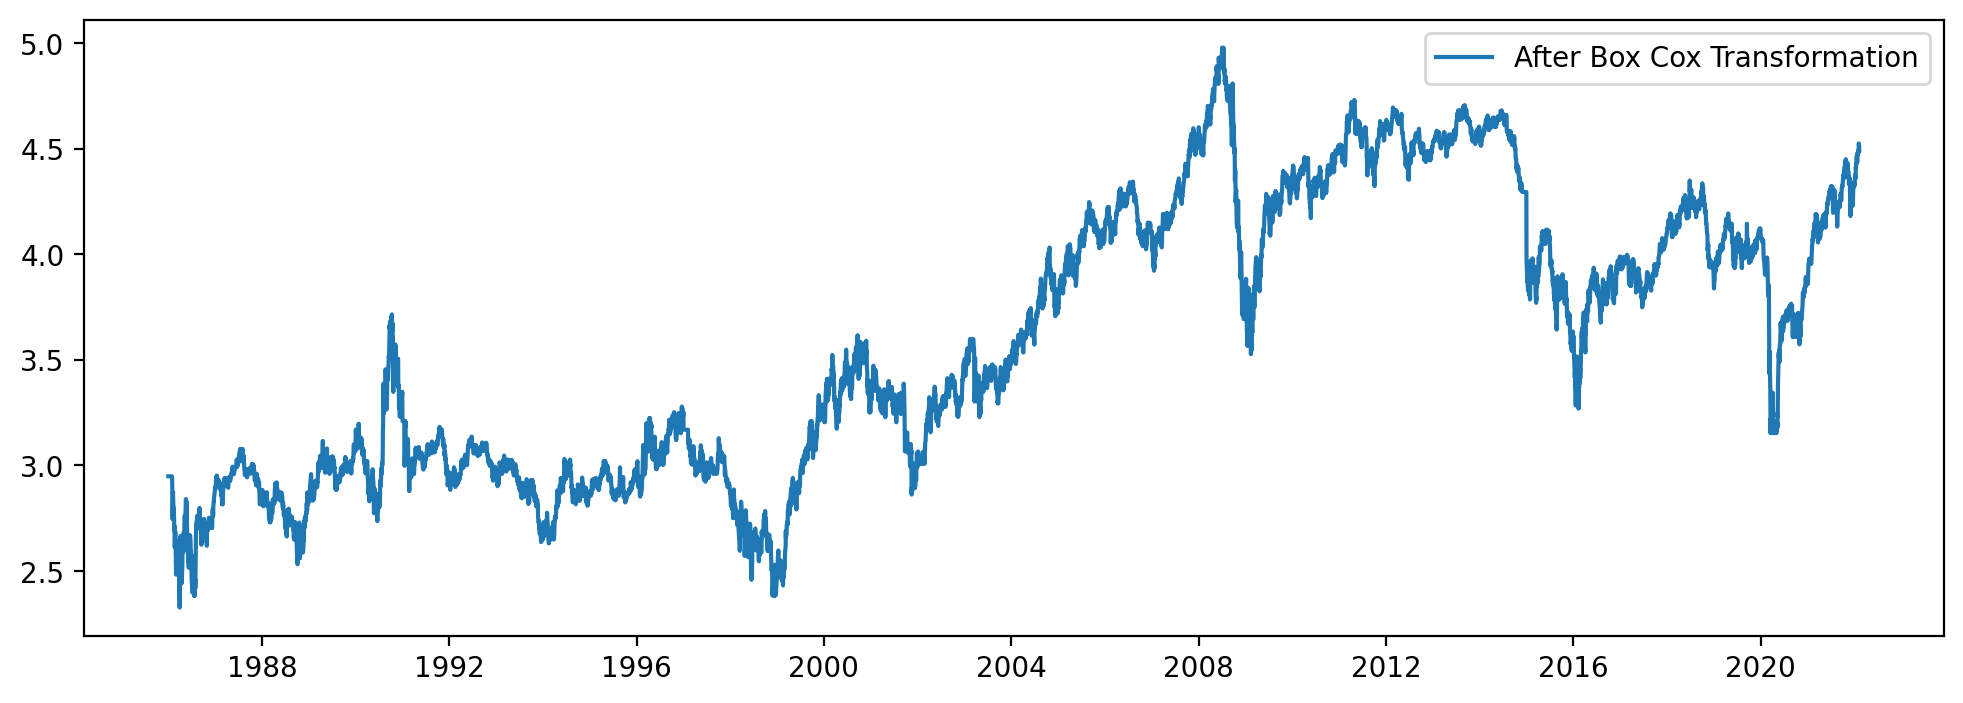

In [60]:
# Plotting the Time series after transformation
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox Transformation')
plt.legend(loc='best')
plt.show()

#### **Analysis**

1.We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.

2.But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing for making the mean constant.



## **3.** **Differencing**

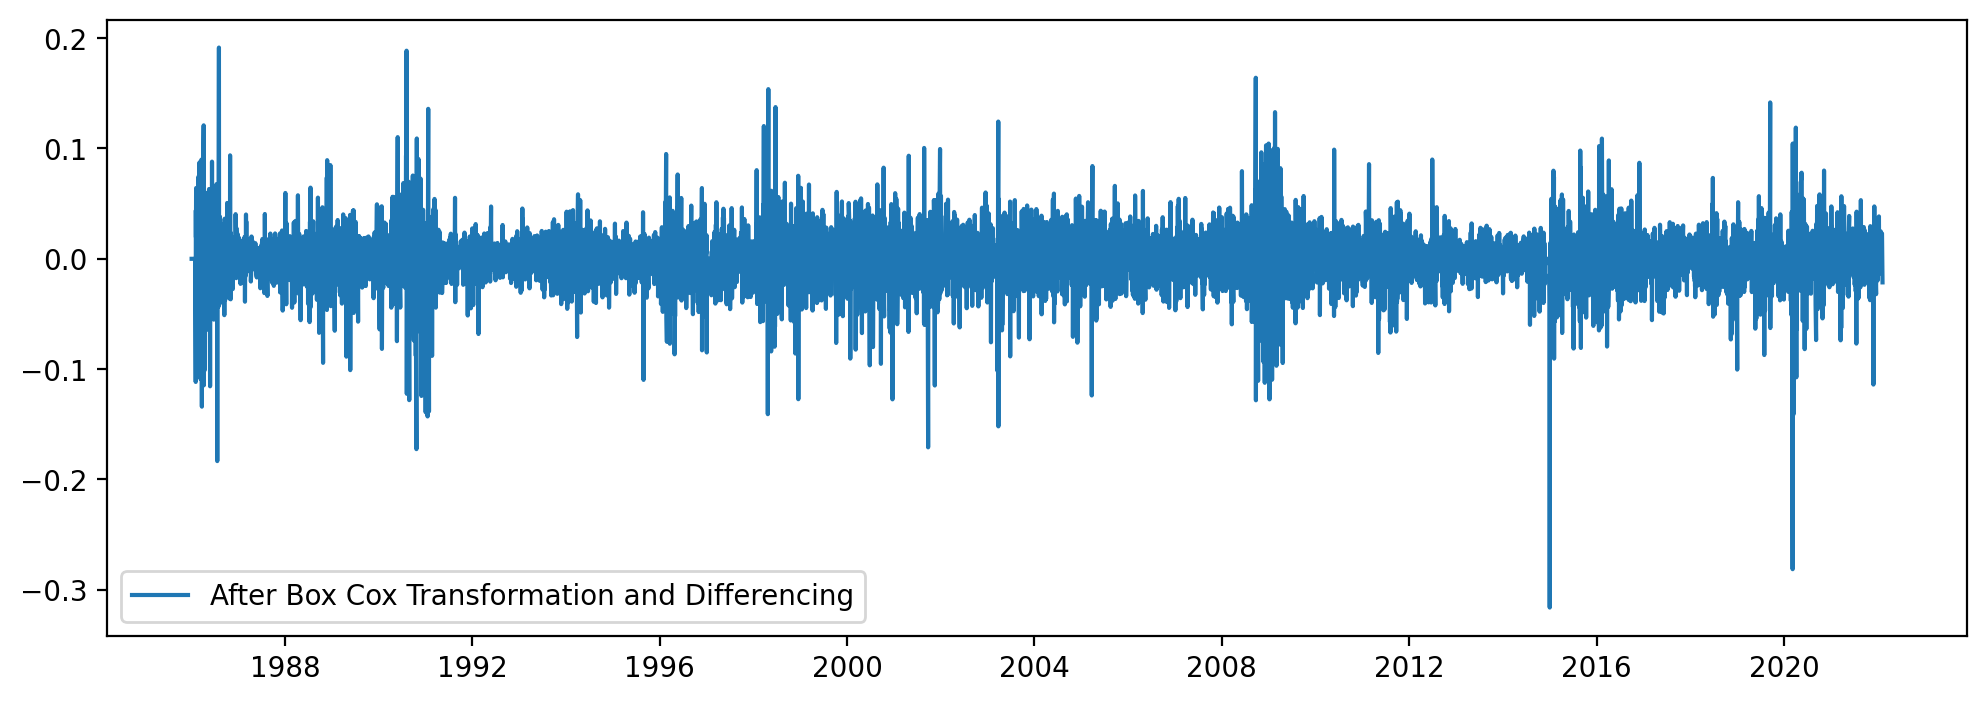

In [61]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

#### **Analysis**

We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. It is a horizontal trend. The mean became constant. The mean is zero. Also, the variance is almost constant. Lets test the Stationarity again.

## ADF Test

In [62]:
adfuller(data_boxcox_diff)[1]

0.0

- if p<0.05 = Data is Stationary
- If p>0.05 = Data is Not Stationary
** According to P-value, the p-value is less than alpha value
** Hence, Reject the null hypothesis.
** The series is Stationary.

## Autocorrelation function (ACF)

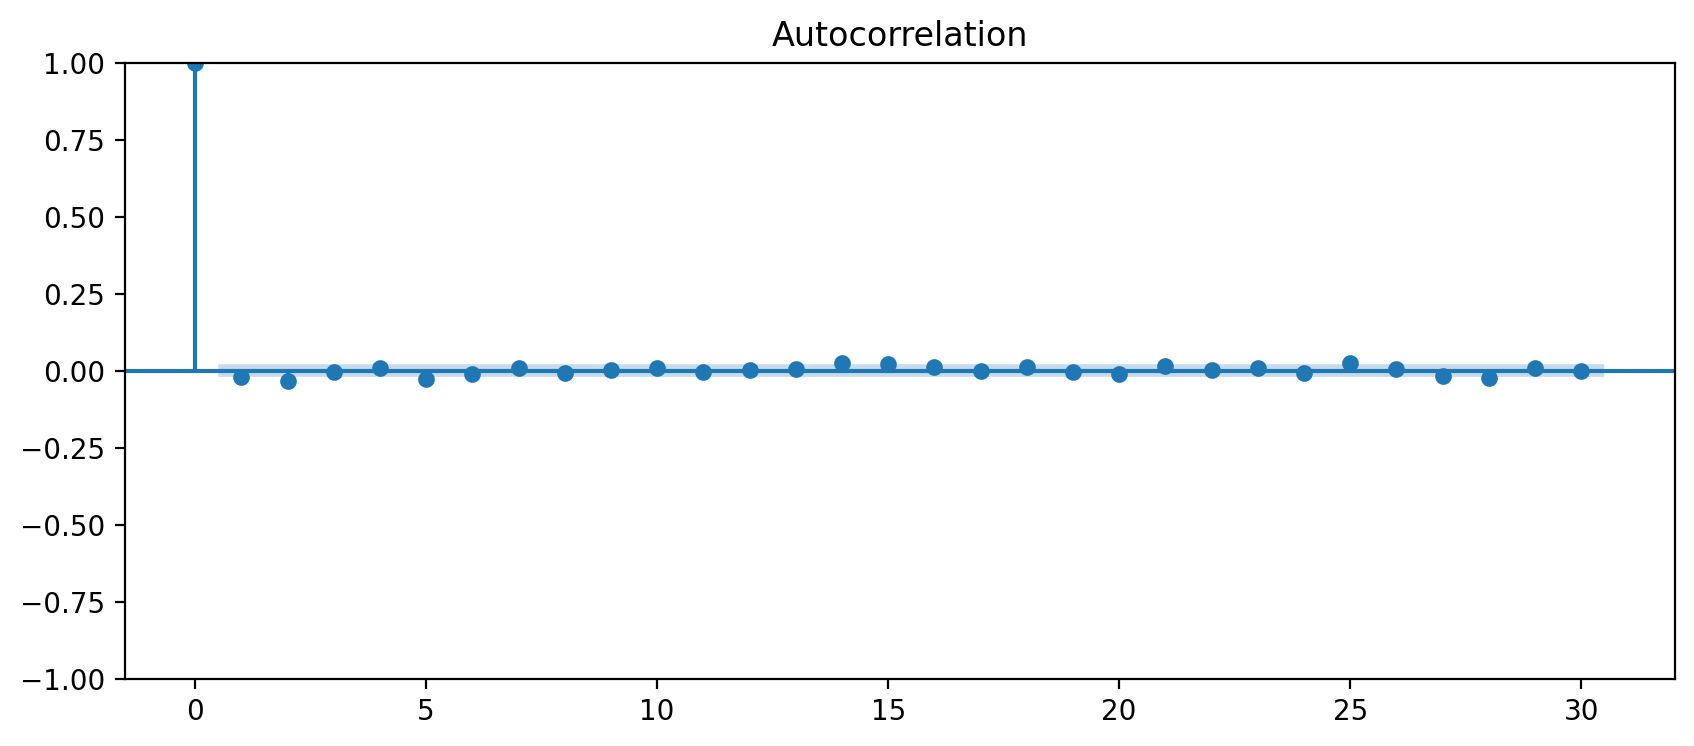

In [63]:
plt.figure(figsize=(10,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

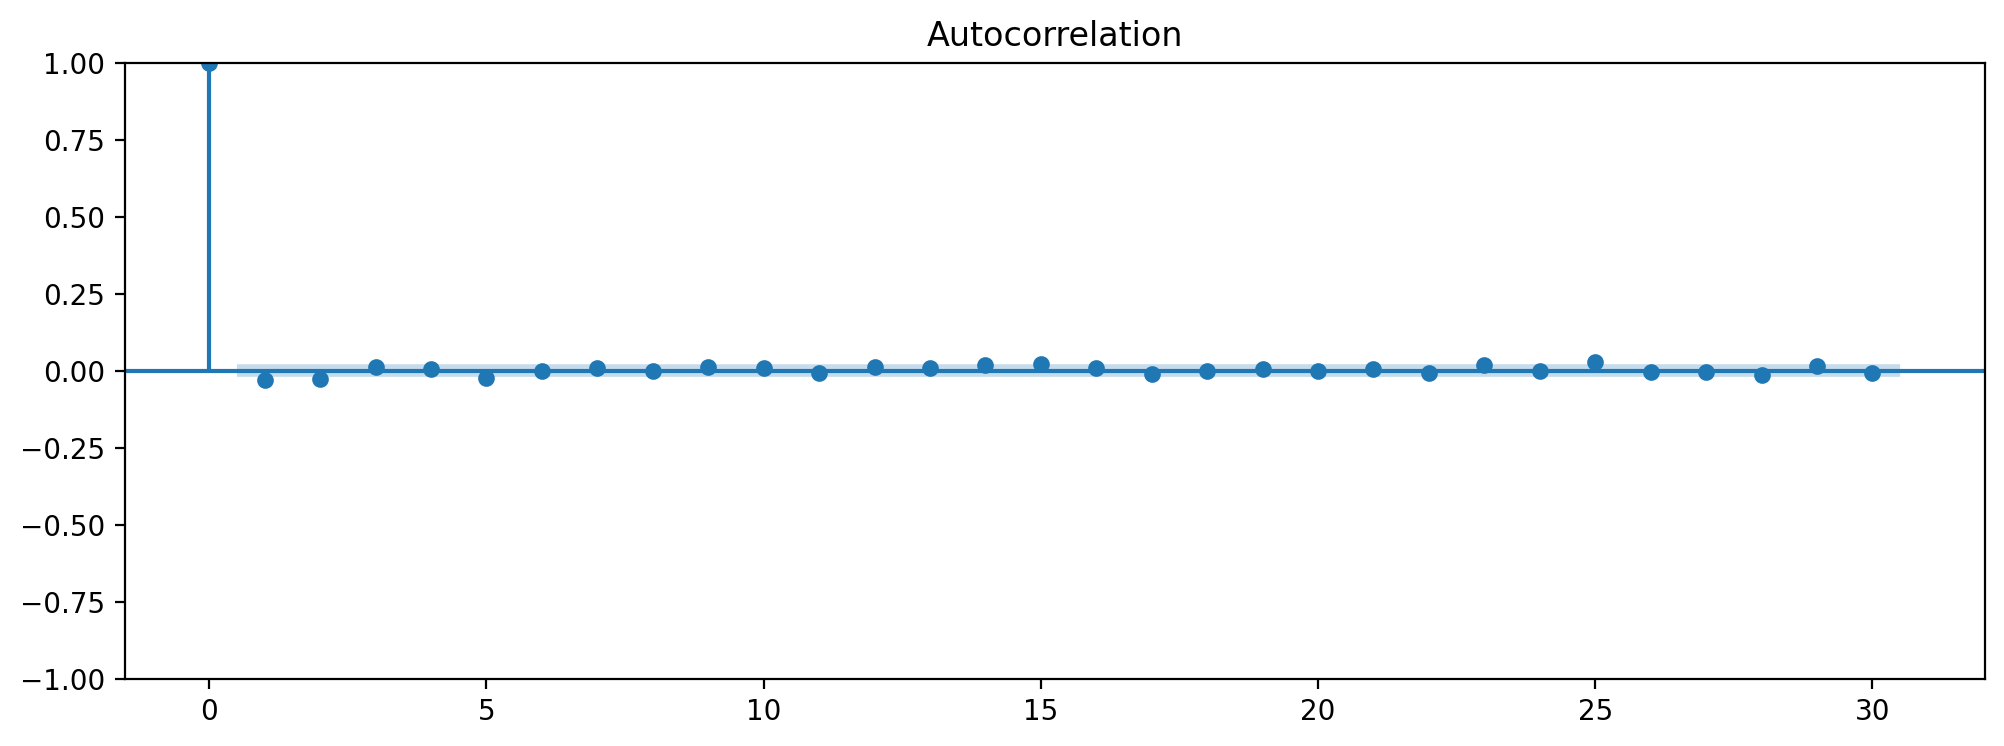

In [64]:
plt.figure(figsize=(12,4))
plot_acf(df_diff, ax=plt.gca(), lags=30)
plt.show()

## Partial autocorrelation function (PACF)

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf

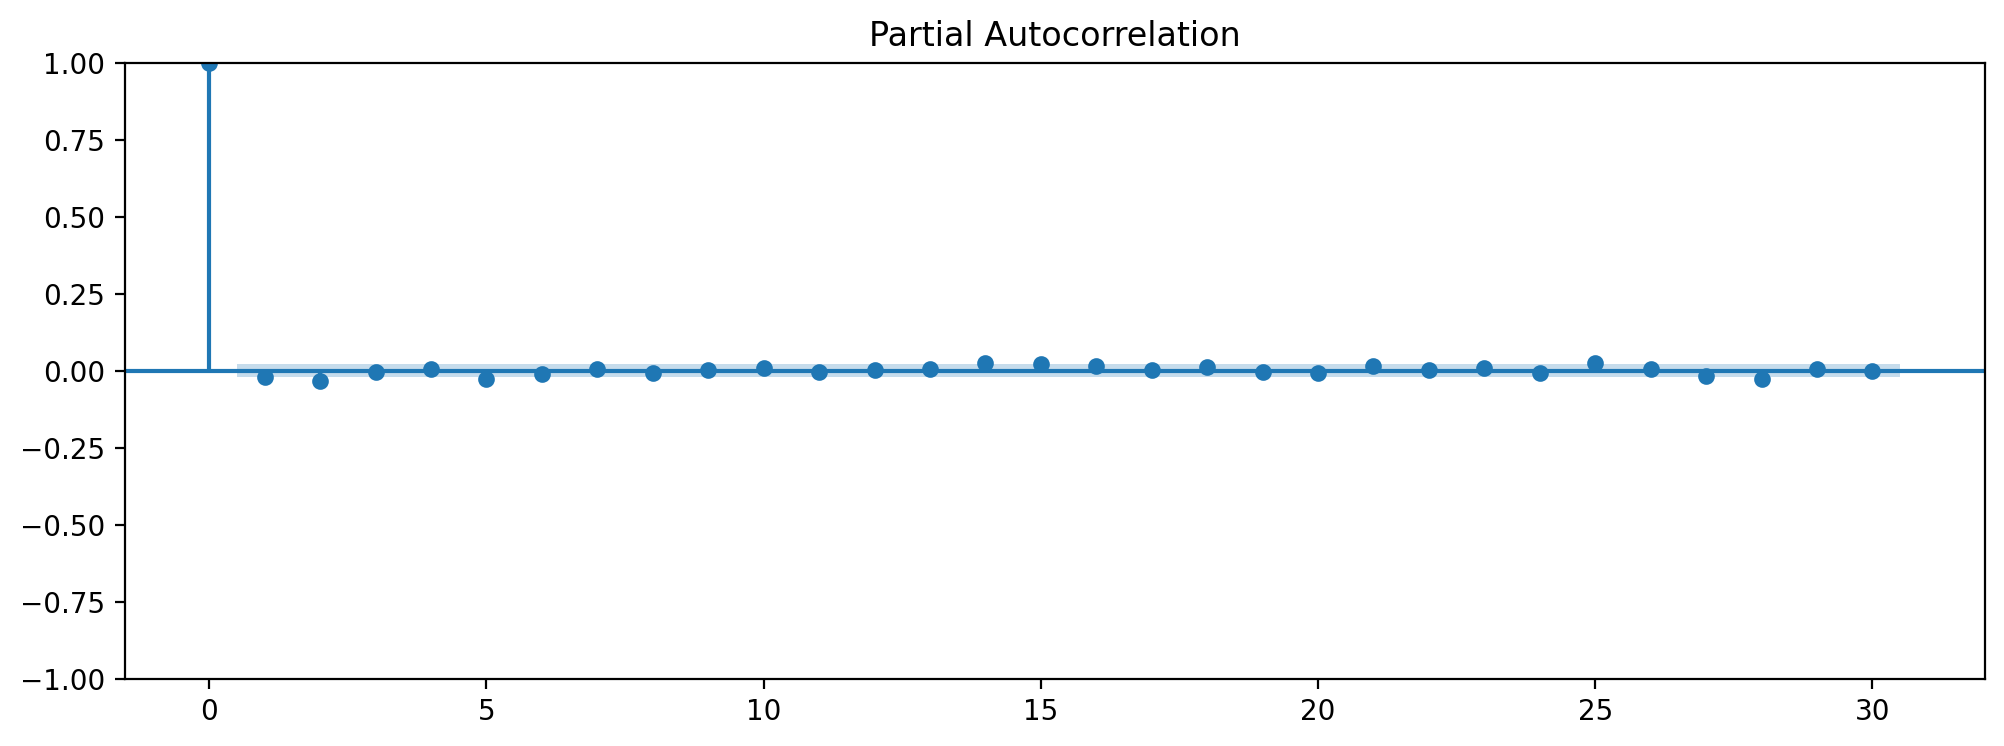

In [66]:
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

In [67]:
#data Procesing
df.head()

Date    Value    Year
0 1986-01-02  19.0825  1986.0
1 1986-01-03  19.0825  1986.0
2 1986-01-06  19.0825  1986.0
3 1986-01-07  19.0825  1986.0
4 1986-01-08  19.0825  1986.0

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9124 entries, 0 to 9123
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9124 non-null   datetime64[ns]
 1   Value   9124 non-null   float64       
 2   Year    9124 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 214.0 KB


In [69]:
df1=df.copy()

In [70]:
df1.head()

Date    Value    Year
0 1986-01-02  19.0825  1986.0
1 1986-01-03  19.0825  1986.0
2 1986-01-06  19.0825  1986.0
3 1986-01-07  19.0825  1986.0
4 1986-01-08  19.0825  1986.0

In [71]:
df1.reset_index(level=0, inplace=True)
df1

index       Date    Value    Year
0         0 1986-01-02  19.0825  1986.0
1         1 1986-01-03  19.0825  1986.0
2         2 1986-01-06  19.0825  1986.0
3         3 1986-01-07  19.0825  1986.0
4         4 1986-01-08  19.0825  1986.0
...     ...        ...      ...     ...
9119   9119 2022-02-02  88.1600  2022.0
9120   9120 2022-02-03  90.1700  2022.0
9121   9121 2022-02-04  92.2700  2022.0
9122   9122 2022-02-07  91.2500  2022.0
9123   9123 2022-02-08  89.3200  2022.0

[9124 rows x 4 columns]

In [72]:
from numpy import log
from numpy import sqrt
from sklearn.model_selection import train_test_split
from scipy import stats
t_list = [x for x in range(1,len(df)+1)]
df1['t'] = t_list

df1['t_square'] = df1['t']*df1['t']

#log transformation
df1['log_price'] = log(df1.Value)
#Square root transformation
df1['sqrt_price'] = sqrt(df1.Value)
df1.head()

index       Date    Value    Year  t  t_square  log_price  sqrt_price
0      0 1986-01-02  19.0825  1986.0  1         1   2.948772    4.368352
1      1 1986-01-03  19.0825  1986.0  2         4   2.948772    4.368352
2      2 1986-01-06  19.0825  1986.0  3         9   2.948772    4.368352
3      3 1986-01-07  19.0825  1986.0  4        16   2.948772    4.368352
4      4 1986-01-08  19.0825  1986.0  5        25   2.948772    4.368352

In [73]:
df1['months'] = df1['Date'].dt.month_name() # saves months name from date
df1['months'] = [x[0:3] for x in df1.months]

In [74]:
dummy = pd.DataFrame(pd.get_dummies(df1['months']))
dummy.reindex(sorted(dummy.columns), axis=1)
colsequence = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dummy = dummy.reindex(columns=colsequence ) #sorts the column headings

df1 = pd.concat([df1,dummy], axis=1)
df1

index       Date    Value    Year     t  t_square  log_price  \
0         0 1986-01-02  19.0825  1986.0     1         1   2.948772   
1         1 1986-01-03  19.0825  1986.0     2         4   2.948772   
2         2 1986-01-06  19.0825  1986.0     3         9   2.948772   
3         3 1986-01-07  19.0825  1986.0     4        16   2.948772   
4         4 1986-01-08  19.0825  1986.0     5        25   2.948772   
...     ...        ...      ...     ...   ...       ...        ...   
9119   9119 2022-02-02  88.1600  2022.0  9120  83174400   4.479153   
9120   9120 2022-02-03  90.1700  2022.0  9121  83192641   4.501697   
9121   9121 2022-02-04  92.2700  2022.0  9122  83210884   4.524719   
9122   9122 2022-02-07  91.2500  2022.0  9123  83229129   4.513603   
9123   9123 2022-02-08  89.3200  2022.0  9124  83247376   4.492225   

      sqrt_price months  Jan  ...  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  \
0       4.368352    Jan    1  ...    0    0    0    0    0    0    0    0   
1       4.368352    Jan    1  ...    0    0    0    0    0    0    0    0   
2       4.368352    Jan    1  ...    0    0    0    0    0    0    0    0   
3       4.368352    Jan    1  ...    0    0    0    0    0    0    0    0   
4       4.368352    Jan    1  ...    0    0    0    0    0    0    0    0   
...          ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9119    9.389356    Feb    0  ...    0    0    0    0    0    0    0    0   
9120    9.495789    Feb    0  ...    0    0    0    0    0    0    0    0   
9121    9.605727    Feb    0  ...    0    0    0    0    0    0    0    0   
9122    9.552487    Feb    0  ...    0    0    0    0    0    0    0    0   
9123    9.450926    Feb    0  ...    0    0    0    0    0    0    0    0   

      Nov  Dec  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...   ...  ...  
9119    0    0  
9120    0    0  
9121    0    0  
9122    0    0  
9123    0    0  

[9124 rows x 21 columns]

In [75]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [76]:
x_train = df1.head(7300)
x_test  = df1.tail(1824)
print(x_train.shape)
print(x_test.shape)

(7300, 21)
(1824, 21)


# Data-Driven

## Simple Exponential Smoothing Method

In [77]:
model_ses = SimpleExpSmoothing(x_train["Value"]).fit(smoothing_level=0.2)
pred_ses = model_ses.predict(start = x_test.index[0],end = x_test.index[-1])
mape_ses = np.round(MAPE(pred_ses,x_test.Value),2)
rmse_ses = np.round(np.sqrt(mean_squared_error(pred_ses,x_test.Value)),2)
print("Root Mean Square Error : ",rmse_ses)

Root Mean Square Error :  23.43


## Holt's Method (Double Exponential Method)

In [78]:
model_h = Holt(x_train["Value"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_h = model_h.predict(start = x_test.index[0],end = x_test.index[-1])
mape_h = np.round(MAPE(pred_h,x_test.Value),2)
rmse_h = np.round(np.sqrt(mean_squared_error(pred_h,x_test.Value)),2)
print("Root Mean Square Error : ",rmse_h)

Root Mean Square Error :  93.81


## H-W's Exp. Smoothing with Add. Seasonality and Trend (Holt-Winters' Exponential Smoothing with Additive Seasonality and Trend)

In [79]:
model_hw_as_at = ExponentialSmoothing(x_train["Value"],seasonal="add",trend="add",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_as_at = model_hw_as_at.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_as_at = np.round(MAPE(pred_hw_as_at,x_test.Value),2)
rmse_hw_as_at = np.round(np.sqrt(mean_squared_error(pred_hw_as_at,x_test.Value)),2)
print("Root Mean Square Error : ",rmse_hw_as_at)

Root Mean Square Error :  28.63


## H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend (Holt-Winters' Exponential Smoothing with Multiplicative Seasonality and Additive Trend)

In [80]:
model_hw_ms_at = ExponentialSmoothing(x_train["Value"],seasonal="mul",trend="add",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_ms_at = model_hw_ms_at.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_ms_at = np.round(MAPE(pred_hw_ms_at,x_test.Value),2)
rmse_hw_ms_at = np.round(np.sqrt(mean_squared_error(pred_hw_ms_at,x_test.Value)),2)
print("Root Mean Square Error : ",rmse_hw_ms_at)

Root Mean Square Error :  28.59


## H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend (Holt-Winters' Exponential Smoothing with Additive Seasonality and Multiplicative Trend)

In [81]:
model_hw_as_mt = ExponentialSmoothing(x_train["Value"],seasonal="add",trend="mul",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_as_mt = model_hw_as_mt.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_as_mt = np.round(MAPE(pred_hw_as_mt,x_test.Value),2)
rmse_hw_as_mt =np.round(np.sqrt(mean_squared_error(pred_hw_as_mt,x_test.Value)),2)
print("Root Mean Square Error : ",rmse_hw_as_mt)

Root Mean Square Error :  36.53


In [82]:
x_train = data_boxcox_diff.head(7300)
x_test  = data_boxcox_diff.tail(1824)
print(x_train.shape)
print(x_test.shape)

(7300, 1)
(1824, 1)


## Long Short Term Model (LSTM)

In [104]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['Value'].values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [105]:
# Prepare the training data for LSTM
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [106]:
# Reshape the data for LSTM input
from keras.layers import LSTM, Dense

In [107]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

In [108]:
# Compile and fit the model on the training data
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data for LSTM
inputs = df['Value'][len(df)-len(test_data)-60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

Epoch 1/10
198/198 [==============================] - 11s 42ms/step - loss: 0.0017
Epoch 2/10
198/198 [==============================] - 8s 39ms/step - loss: 2.9207e-04
Epoch 3/10
198/198 [==============================] - 8s 42ms/step - loss: 2.4821e-04
Epoch 4/10
198/198 [==============================] - 8s 43ms/step - loss: 2.1740e-04
Epoch 5/10
198/198 [==============================] - 8s 40ms/step - loss: 1.8684e-04
Epoch 6/10
198/198 [==============================] - 9s 43ms/step - loss: 1.9842e-04
Epoch 7/10
198/198 [==============================] - 8s 43ms/step - loss: 1.5882e-04
Epoch 8/10
198/198 [==============================] - 8s 39ms/step - loss: 1.5046e-04
Epoch 9/10
198/198 [==============================] - 8s 42ms/step - loss: 1.3706e-04
Epoch 10/10
198/198 [==============================] - 8s 43ms/step - loss: 1.2228e-04


In [109]:
# Reshape the data for LSTM input
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

86/86 [==============================] - 1s 12ms/step
Train Mean Absolute Error: 34.4672126881163
Train Root Mean Squared Error: 42.63421248407221


In [110]:
rmse_lstm = np.round(np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])),2)
rmse_lstm

1.48

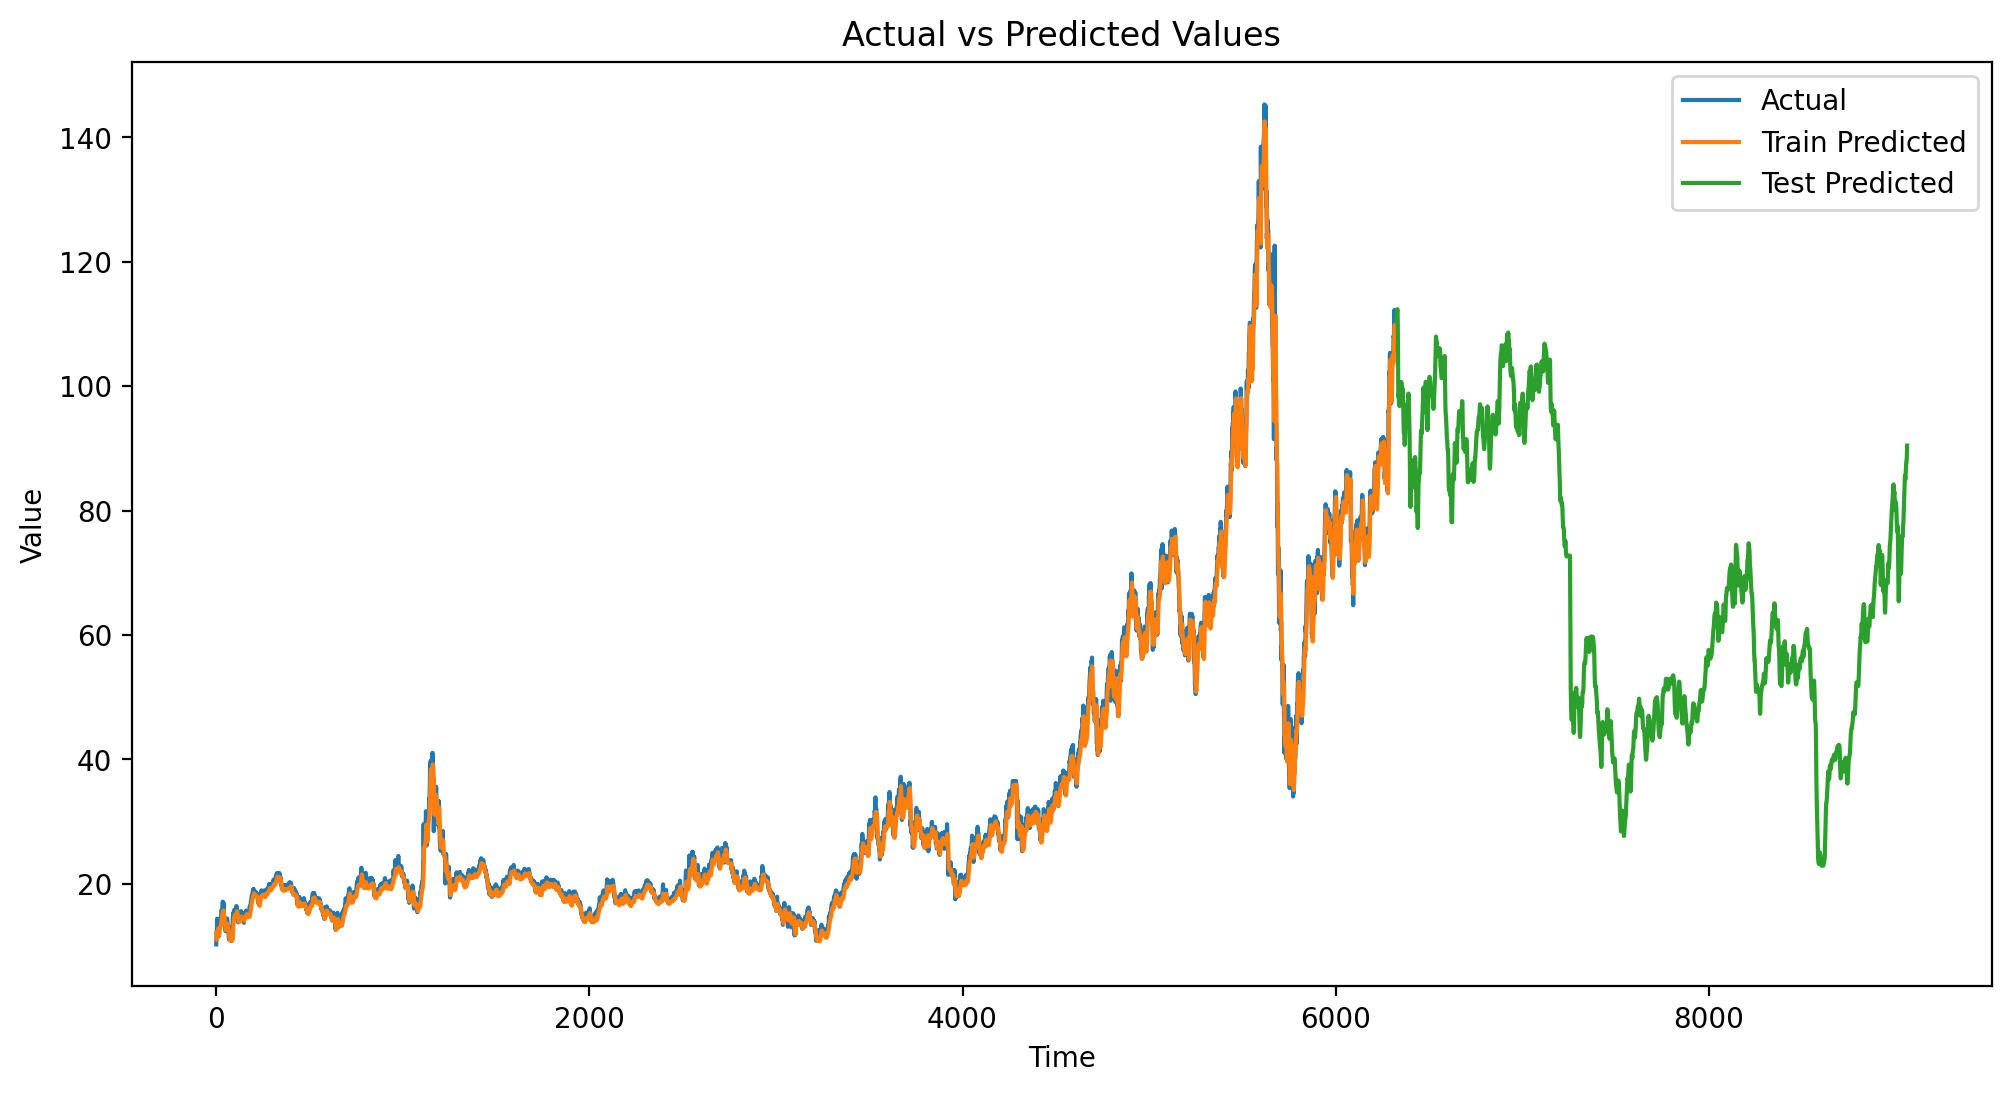

In [111]:
# Visualize the predicted values
plt.figure(figsize=(12, 6))
plt.plot(Y_train[0], label='Actual')
plt.plot(train_predict[:, 0], label='Train Predicted')
plt.plot(len(Y_train[0]) + np.arange(len(test_predict)), test_predict[:, 0], label='Test Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## RNN

In [112]:
#Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Value'].values.reshape(-1, 1))

# Split data into training and testing sets
x_train = df1.head(7300)
x_test  = df1.tail(1824)

In [113]:
# Create the training sequences and labels
sequence_length = 30  # Number of time steps to look back
X_train = []
y_train = []
for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i])
    y_train.append(train_data[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [114]:
# Create the Simple RNN model
model = Sequential()
model.add(SimpleRNN(units=32, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
199/199 [==============================] - 2s 5ms/step - loss: 0.0010
Epoch 2/10
199/199 [==============================] - 1s 6ms/step - loss: 8.7966e-05
Epoch 3/10
199/199 [==============================] - 1s 4ms/step - loss: 8.0670e-05
Epoch 4/10
199/199 [==============================] - 1s 4ms/step - loss: 7.8183e-05
Epoch 5/10
199/199 [==============================] - 1s 4ms/step - loss: 7.5693e-05
Epoch 6/10
199/199 [==============================] - 1s 4ms/step - loss: 7.3912e-05
Epoch 7/10
199/199 [==============================] - 1s 5ms/step - loss: 7.1858e-05
Epoch 8/10
199/199 [==============================] - 2s 9ms/step - loss: 7.0870e-05
Epoch 9/10
199/199 [==============================] - 1s 5ms/step - loss: 7.0793e-05
Epoch 10/10
199/199 [==============================] - 1s 4ms/step - loss: 7.1866e-05


In [115]:
# Make predictions on the test set
X_test = []
y_test = []
for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i-sequence_length:i])
    y_test.append(test_data[i])
X_test, y_test = np.array(X_test), np.array(y_test)
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

85/85 [==============================] - 0s 2ms/step


In [116]:
# Evaluate the model
mse_rnn = mean_squared_error(y_test, predictions)
mape_rnn = mean_absolute_percentage_error(y_test, predictions)
rmse_rnn = math.sqrt(mse_rnn)

print('Mean Squared Error (MSE):', mse_rnn)
print('Root Mean Squared Error (RMSE):', rmse_rnn)

Mean Squared Error (MSE): 2.3749577435455125
Root Mean Squared Error (RMSE): 1.5410897908770638


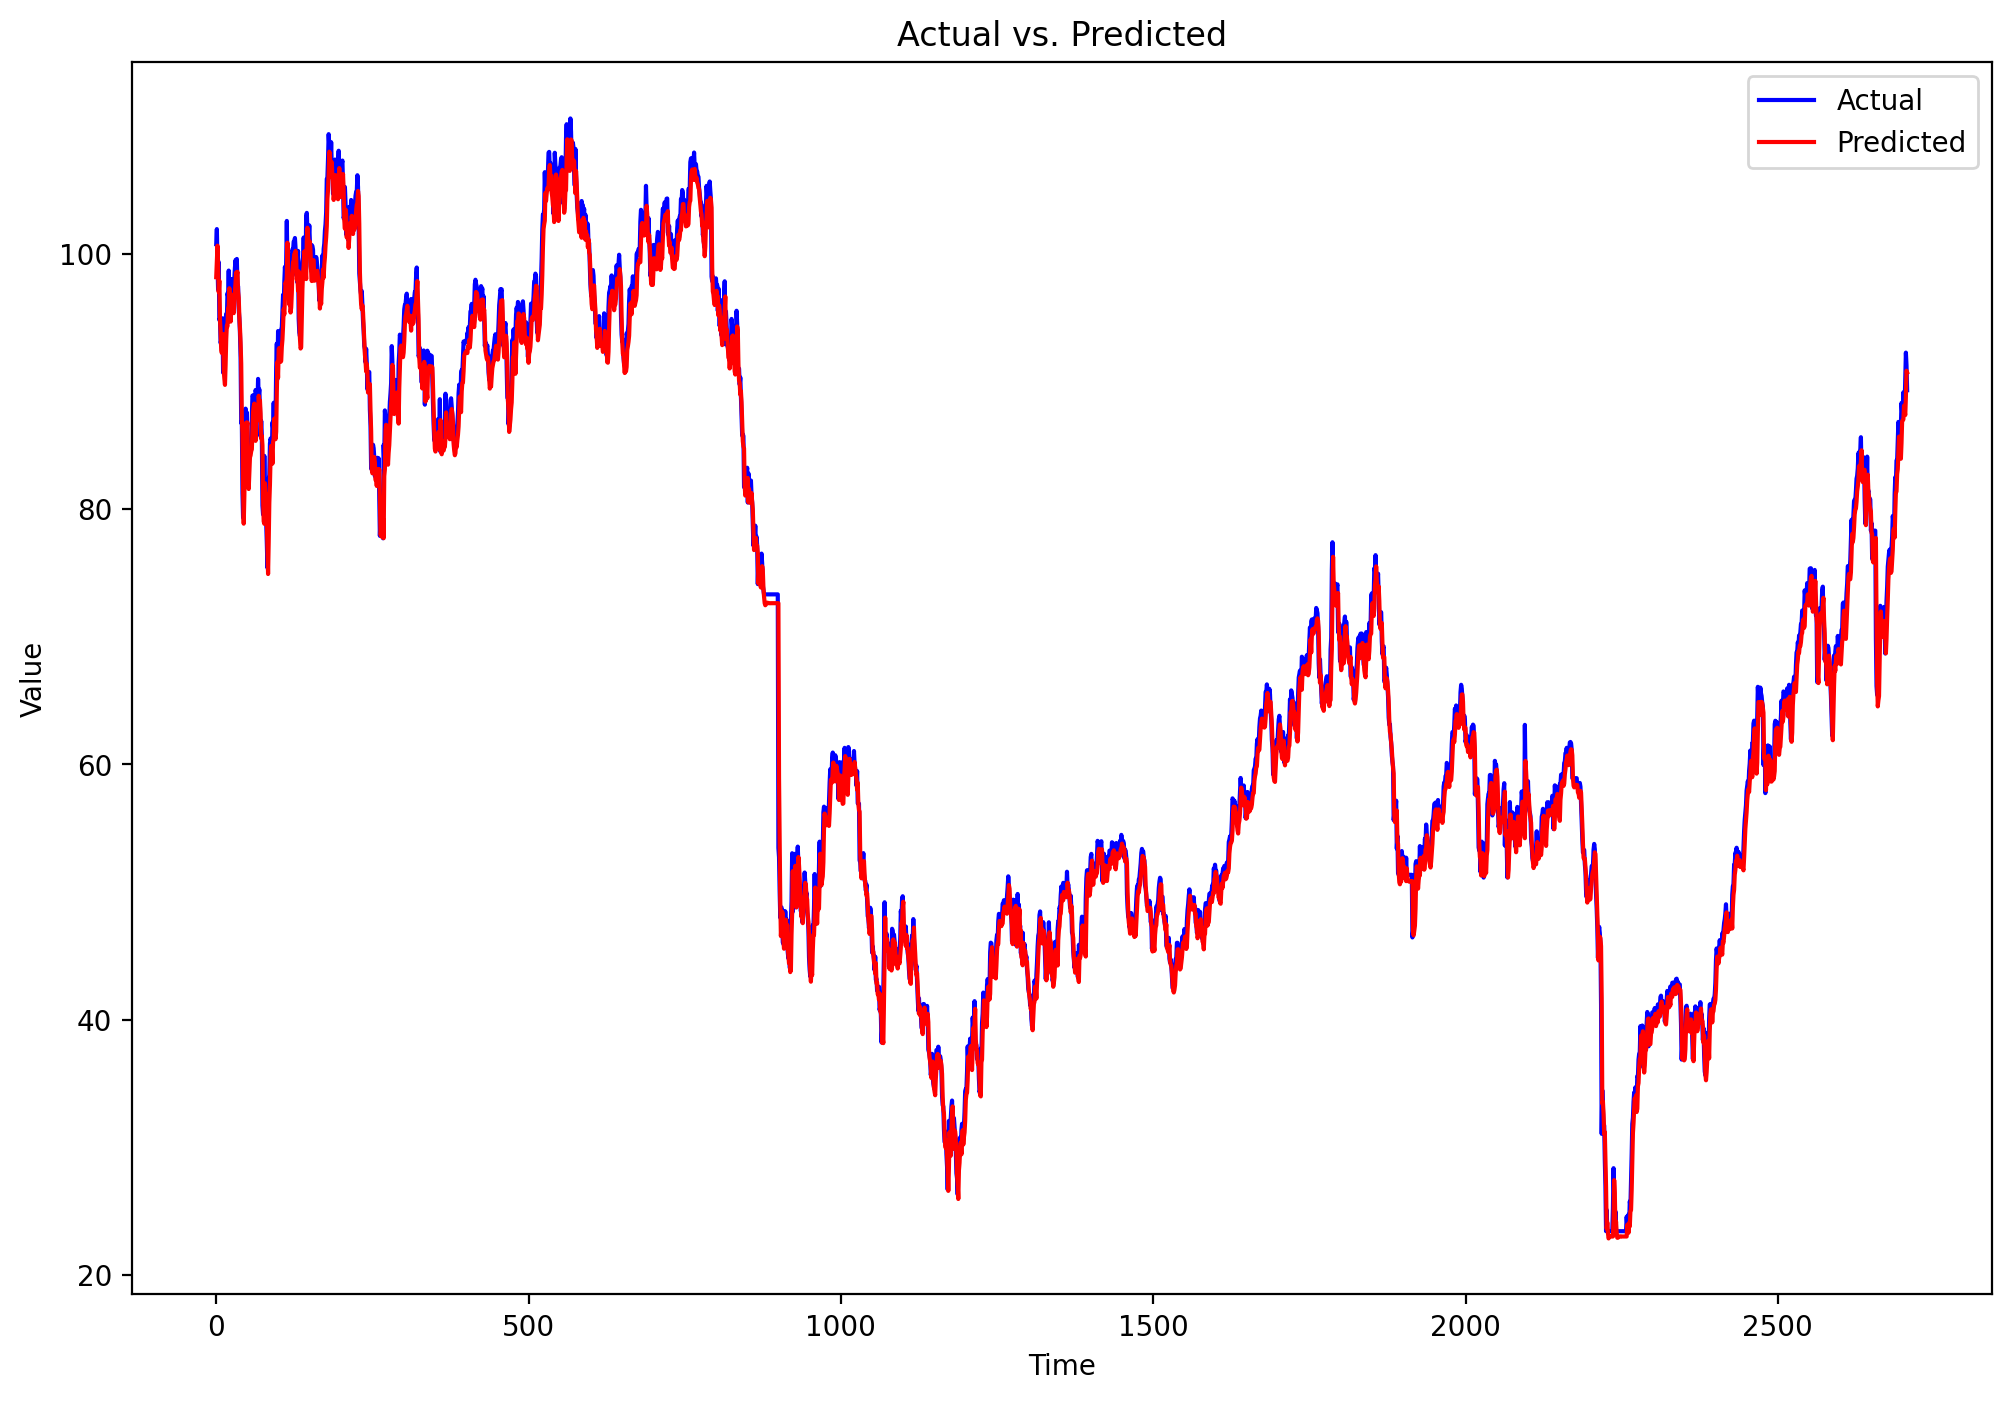

In [117]:
import matplotlib.pyplot as plt

# Plotting the actual values
plt.plot(y_test, color='blue', label='Actual')

# Plotting the predicted values
plt.plot(predictions, color='red', label='Predicted')

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()

# Display the plot
plt.show()

## Comparing the results


In [119]:
pd.set_option('max_colwidth',100)

In [120]:
model_list                = ["SES Method","Holt's Method",
                             "H-W's Exp. Smooothing with Add. Seasonality and Trend",
                             "H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend",
                             "H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend",
                             "RNN", "LSTM"
                            ]
rmse_val_list             = [rmse_ses,rmse_h,rmse_hw_as_at,rmse_hw_ms_at,rmse_hw_as_mt,rmse_rnn,rmse_lstm]

table_rmse                = pd.DataFrame(columns=['Model','RMSE_Values'])
table_rmse['Model']       = model_list
table_rmse['RMSE_Values'] = rmse_val_list
table_rmse

Model  RMSE_Values
0                                                 SES Method     23.43000
1                                              Holt's Method     93.81000
2      H-W's Exp. Smooothing with Add. Seasonality and Trend     28.63000
3  H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend     28.59000
4  H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend     36.53000
5                                                        RNN      1.54109
6                                                       LSTM      1.48000

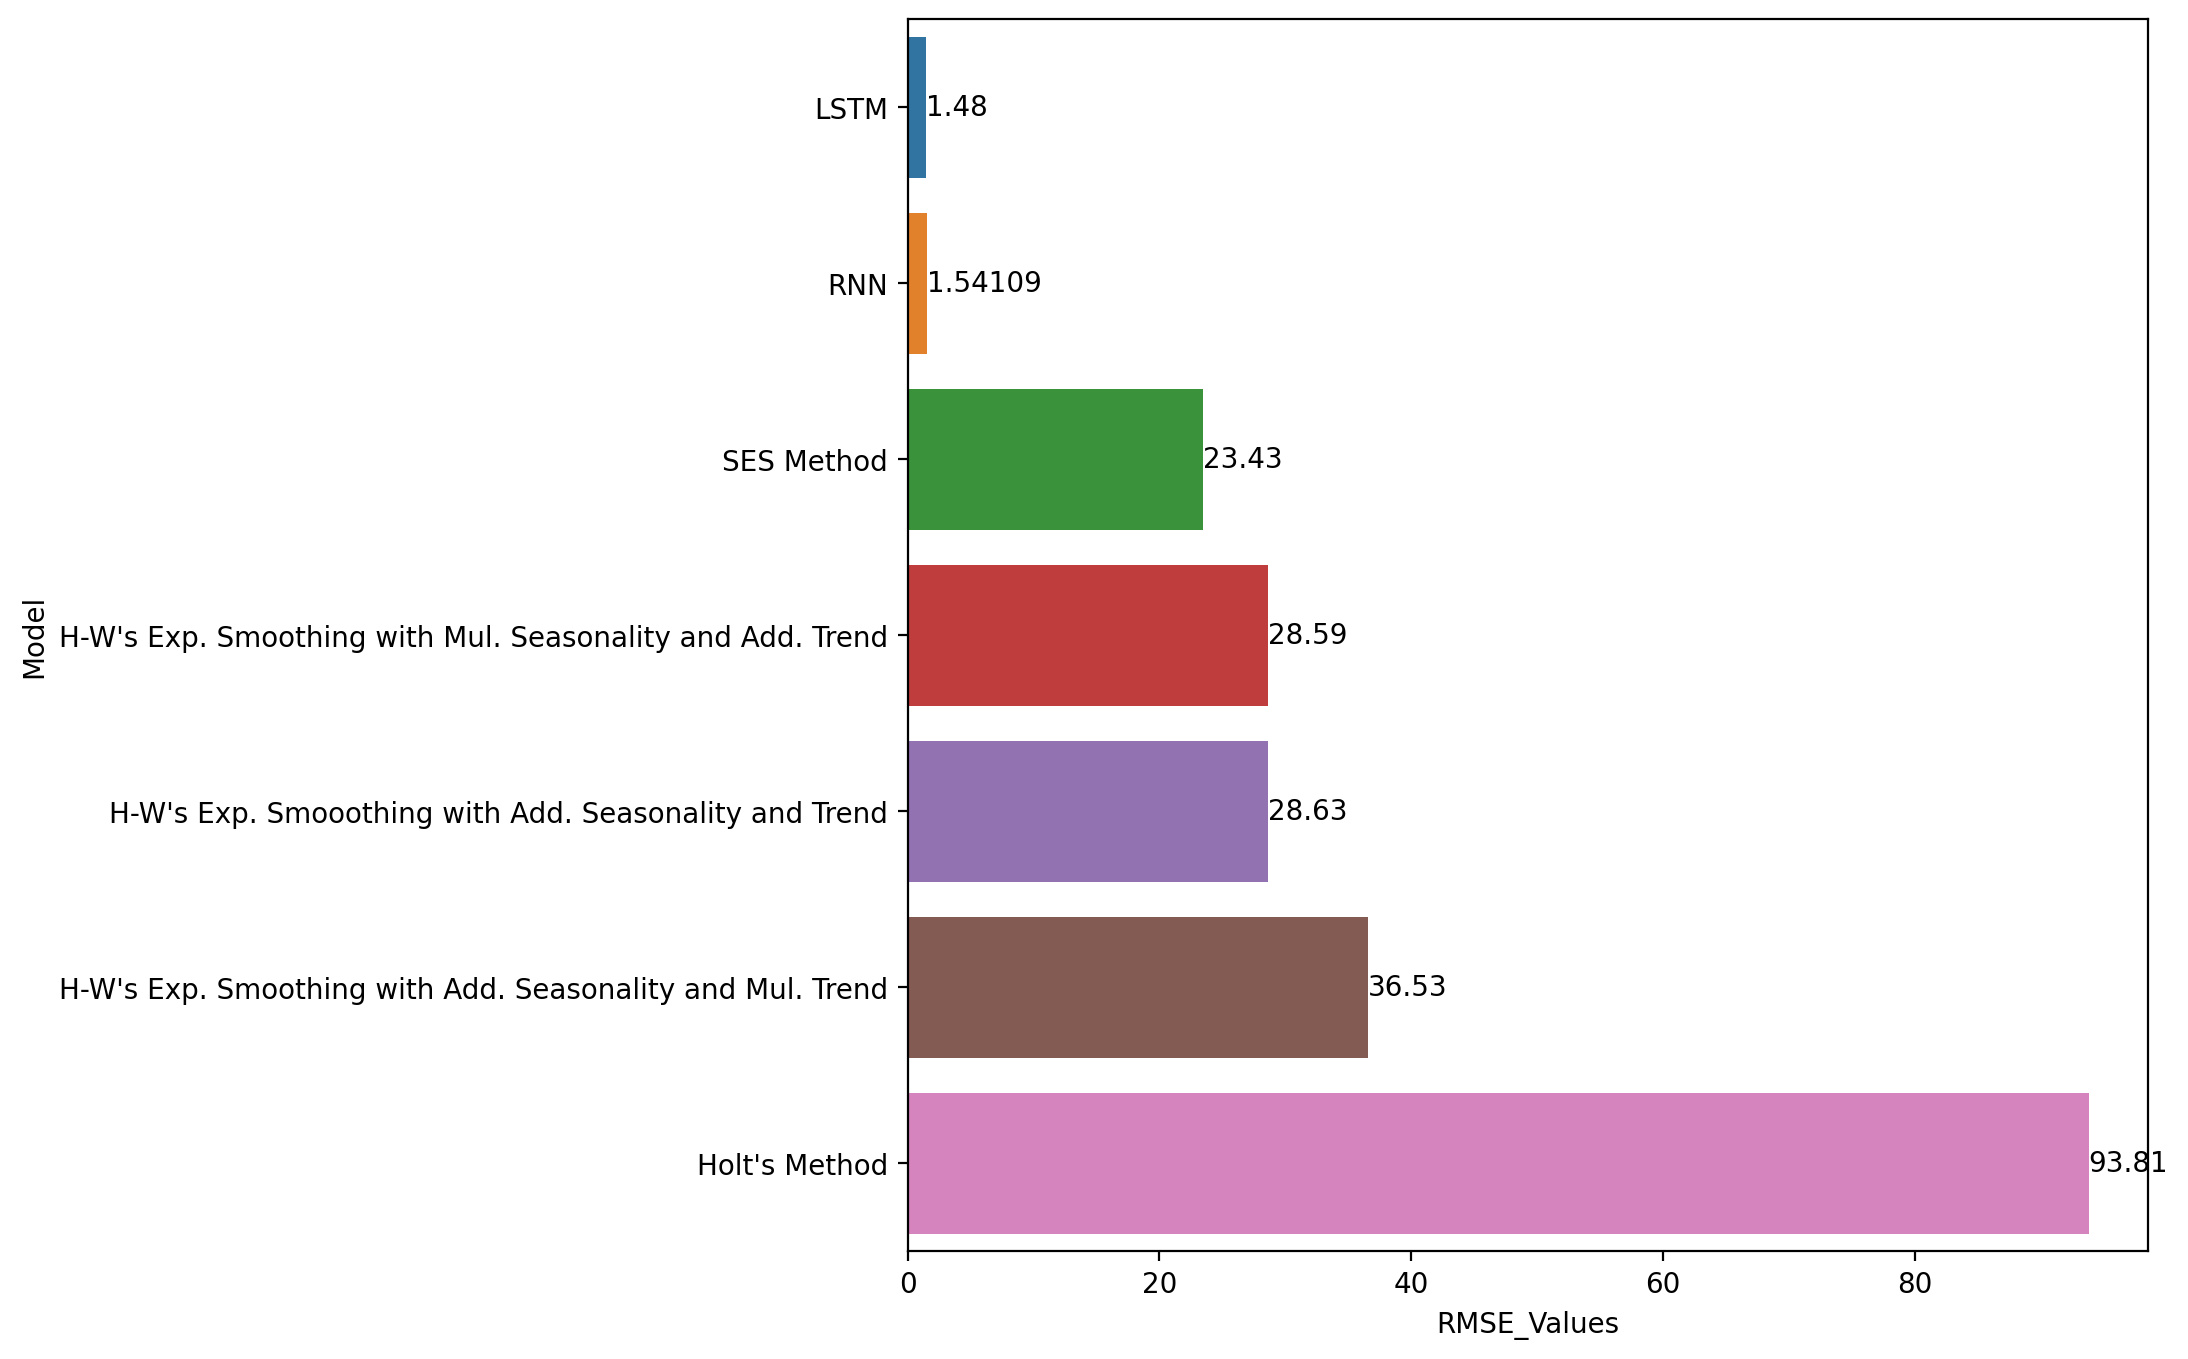

In [125]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x='RMSE_Values',y='Model',data=table_rmse,order=table_rmse.sort_values('RMSE_Values').Model)
for i in ax.containers:
    ax.bar_label(i)

# Model Driven Techniques

In [127]:
x_train = df1.head(7300)
x_test  = df1.tail(1824)
print(x_train.shape)
print(x_test.shape)

(7300, 21)
(1824, 21)


## Linear Model


In [128]:
model_lin     = smf.ols('Value~t',data=x_train).fit()
predicted_lin = pd.Series(model_lin.predict(pd.DataFrame(x_test['t'])))
rmse_lin      = np.sqrt(np.mean(np.array(x_test['Value'])-np.array(predicted_lin))**2)
rmse_lin      = round(rmse_lin,2)
print("Root Mean Square Error : ",rmse_lin)

Root Mean Square Error :  46.22


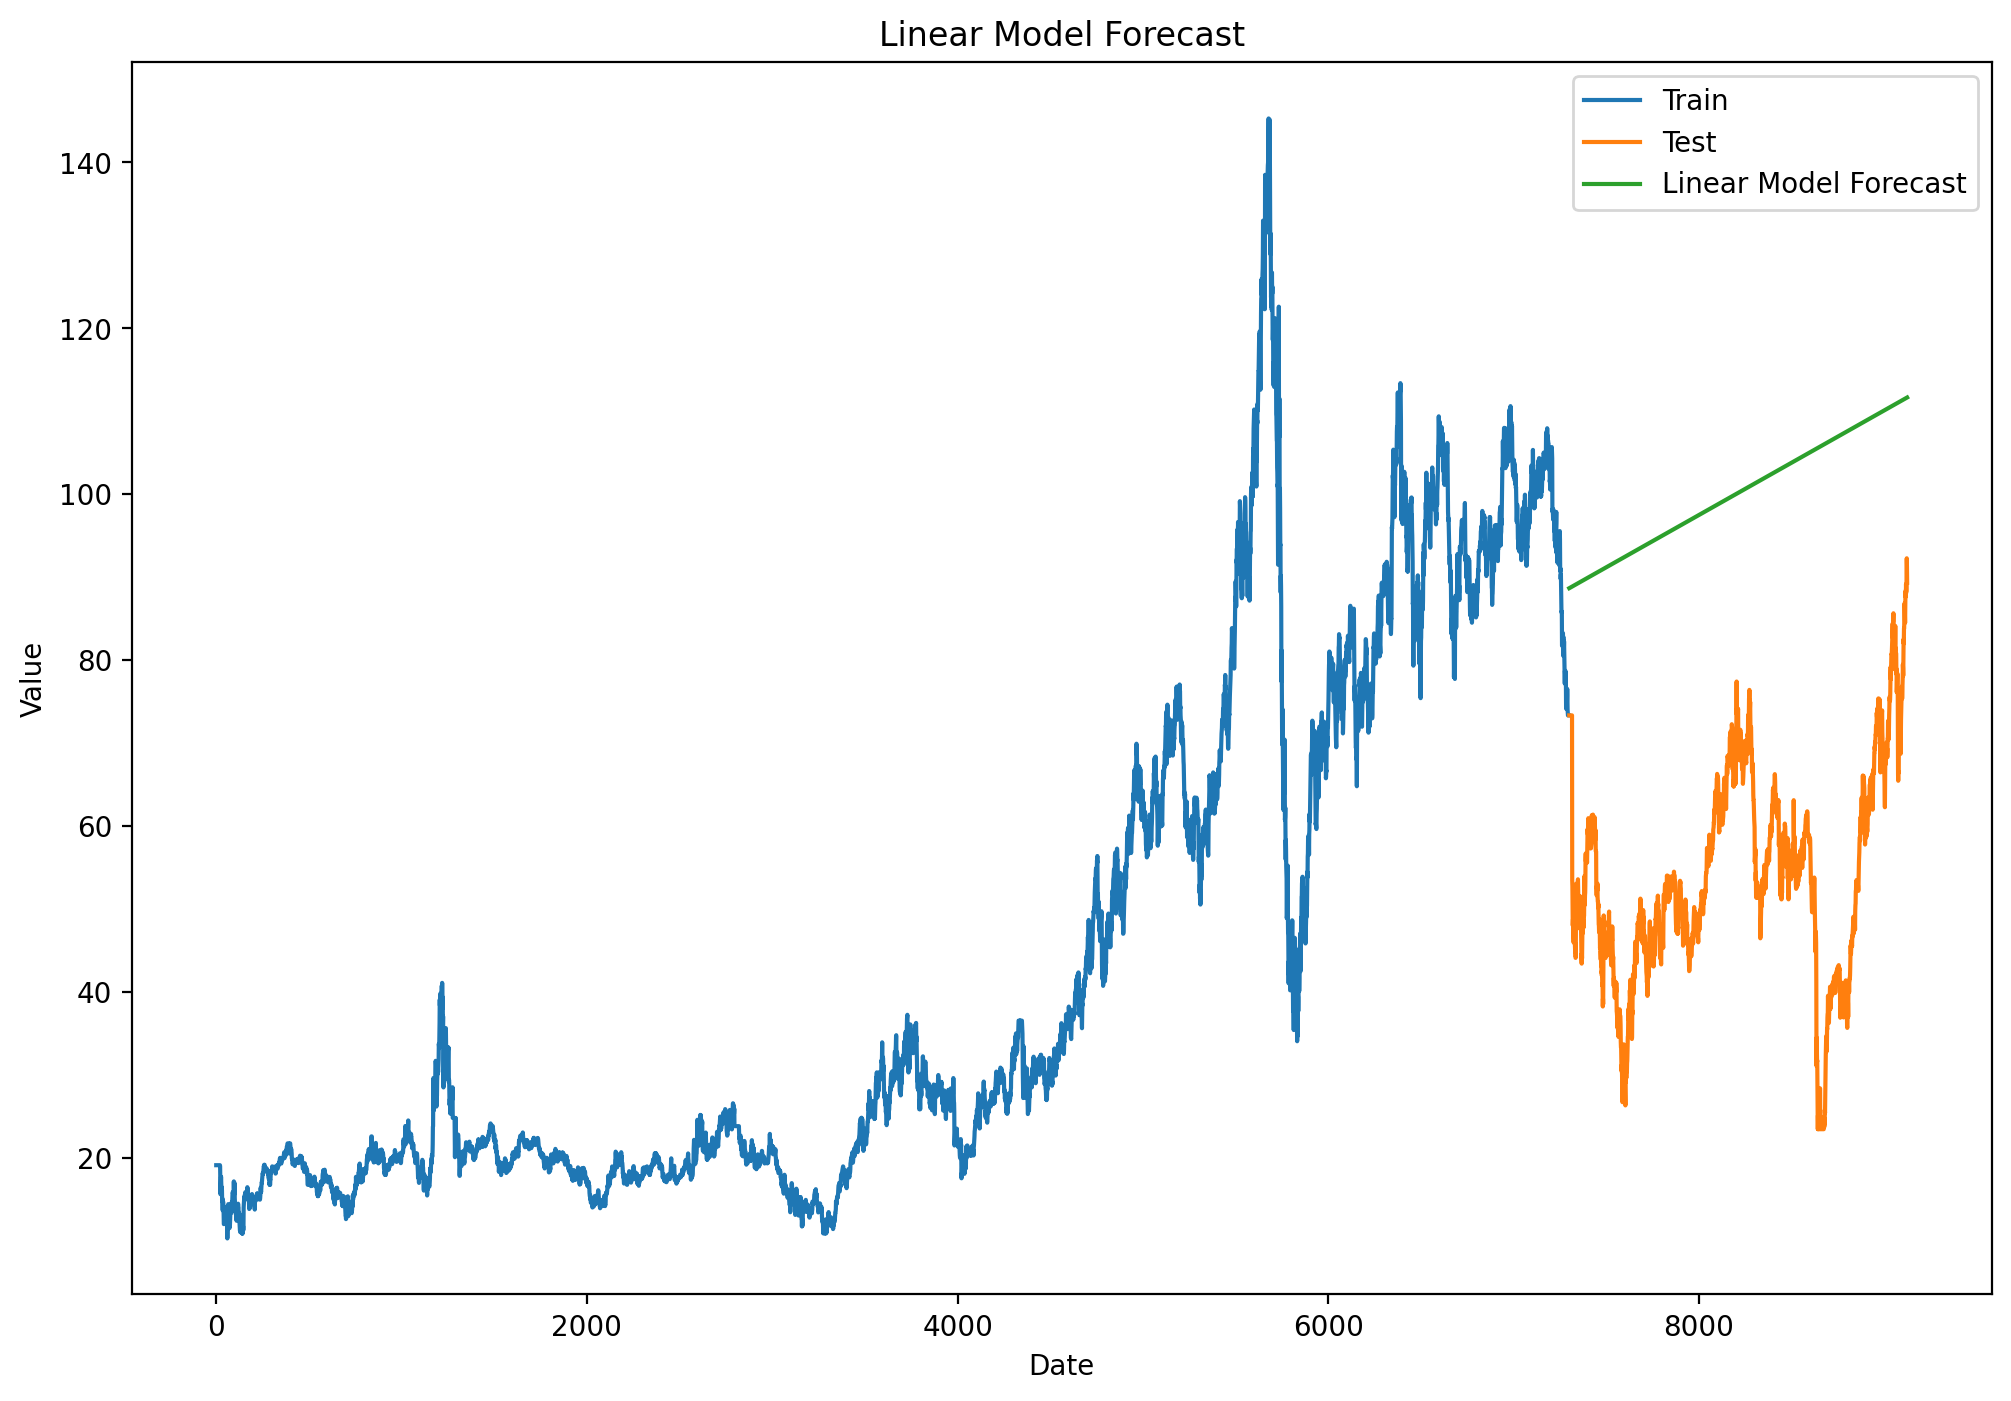

In [129]:
import matplotlib.pyplot as plt

# Linear Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, x_train['Value'], label='Train')
plt.plot(x_test.index, x_test['Value'], label='Test')
plt.plot(x_test.index, predicted_lin, label='Linear Model Forecast')
plt.legend()
plt.title('Linear Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Exponential Model

In [130]:
model_exp = smf.ols('log_price~t',data=x_train).fit()
pred_exp  = pd.Series(model_exp.predict(pd.DataFrame(x_test['t'])))
rmse_exp  = np.sqrt(np.mean((np.array(x_test['log_price'])-np.array(np.exp(pred_exp)))**2))
rmse_exp  = round(rmse_exp,2)
print("Root Mean Square Error : ",rmse_exp)

Root Mean Square Error :  123.57


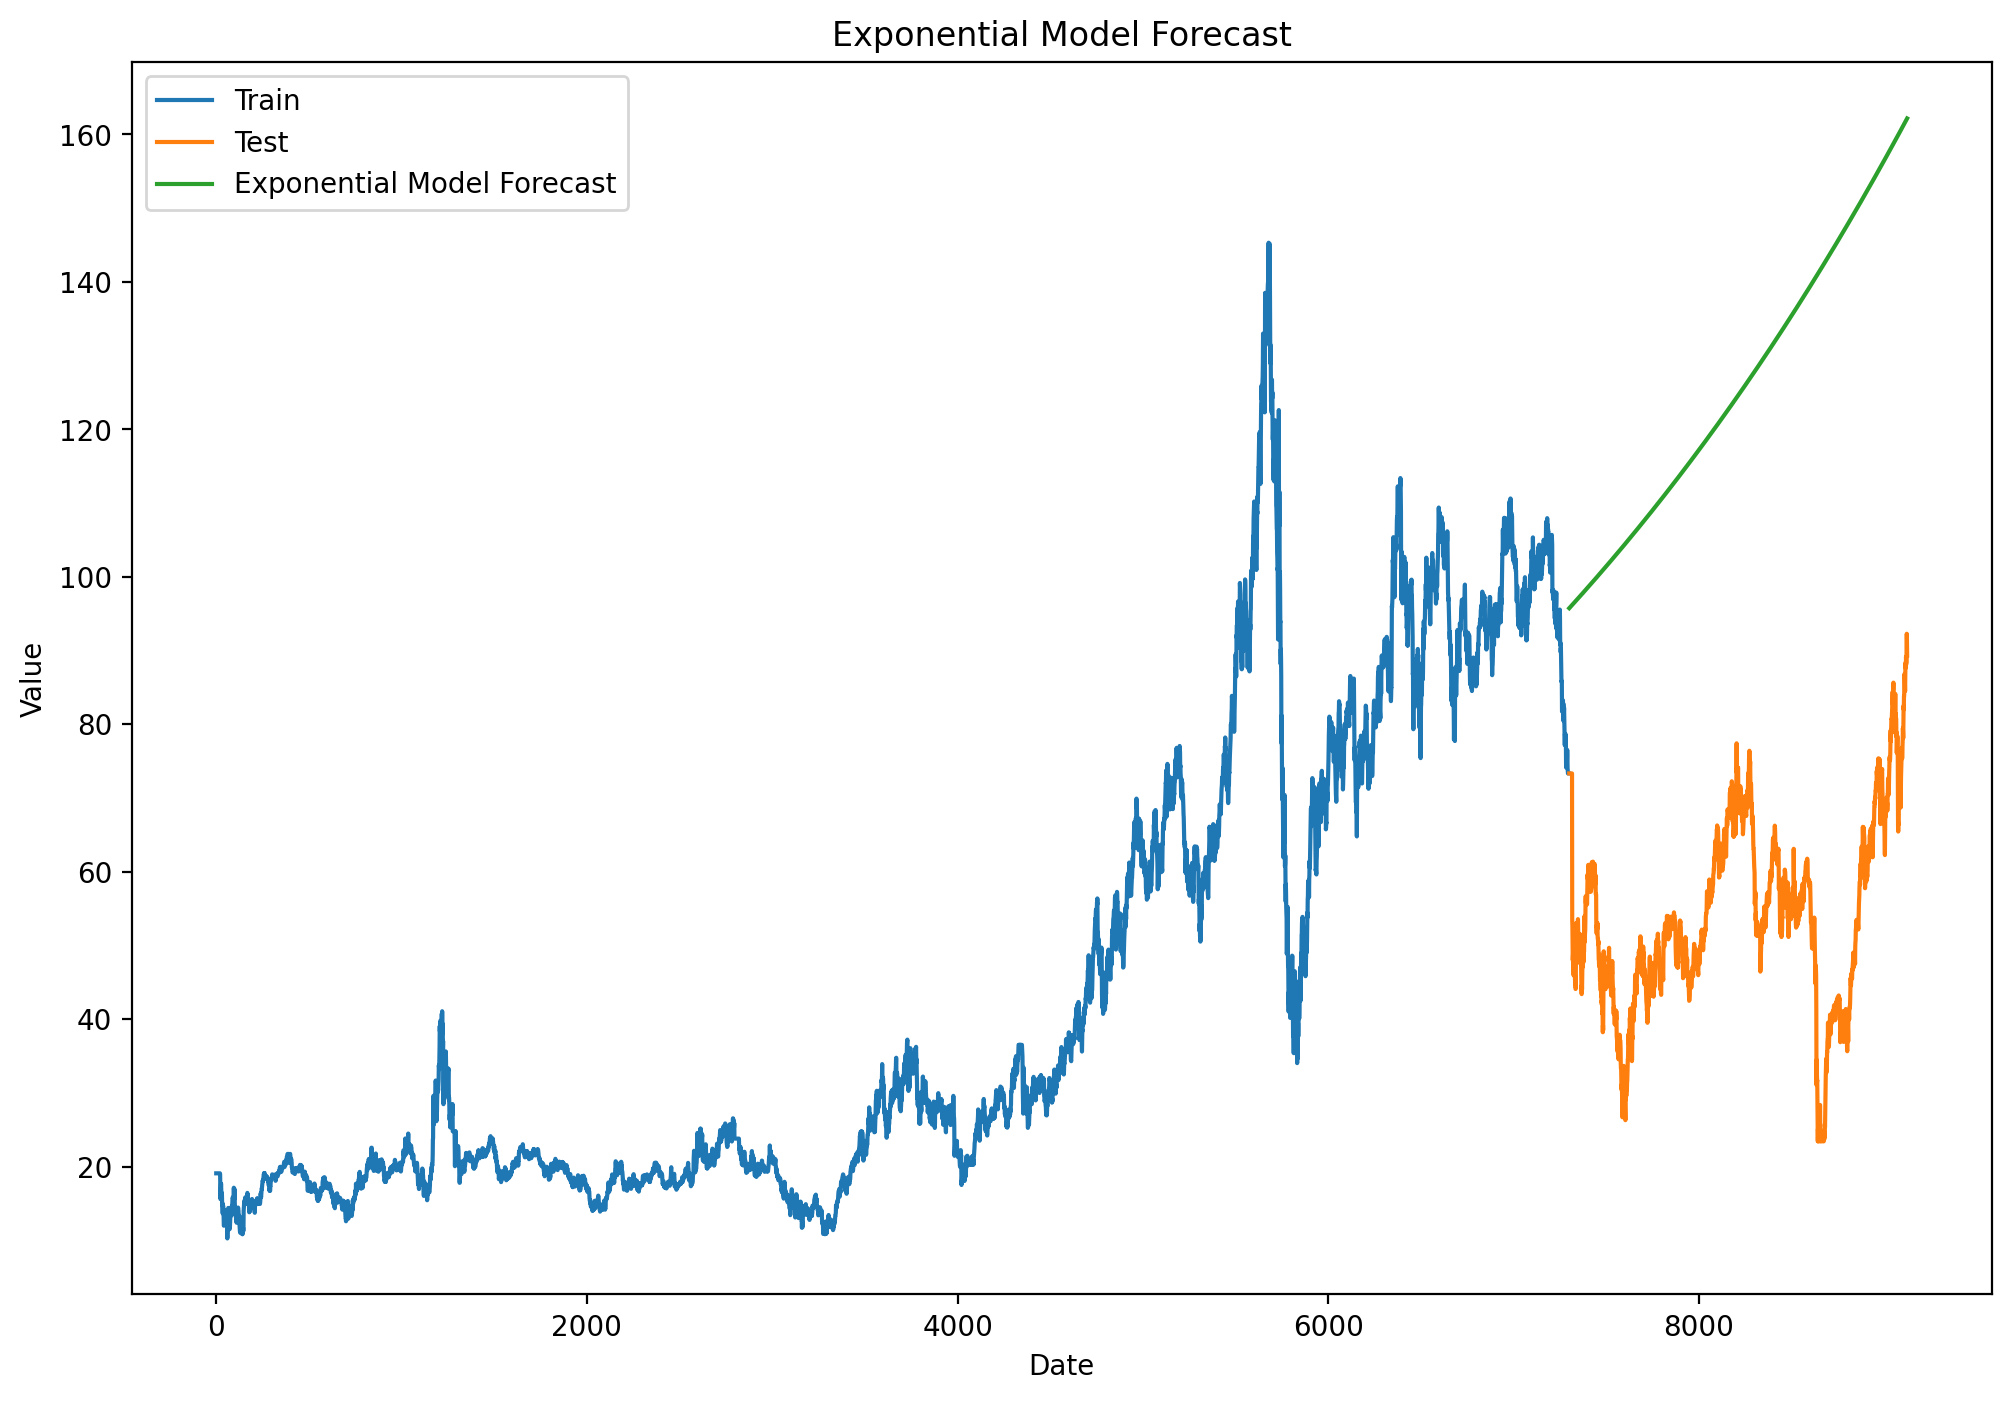

In [131]:
# Exponential Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, np.exp(x_train['log_price']), label='Train')
plt.plot(x_test.index, np.exp(x_test['log_price']), label='Test')
plt.plot(x_test.index, np.exp(pred_exp), label='Exponential Model Forecast')
plt.legend()
plt.title('Exponential Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Quadratic

In [132]:
model_quad = smf.ols('Value~t+t_square',data=x_train).fit()
pred_quad = pd.Series(model_quad.predict(x_test[["t","t_square"]]))
rmse_quad = np.sqrt(np.mean((np.array(x_test['Value'])-np.array(pred_quad))**2))
rmse_quad = round(rmse_quad,2)
print("Root Mean Square Error : ",rmse_quad)

Root Mean Square Error :  95.1


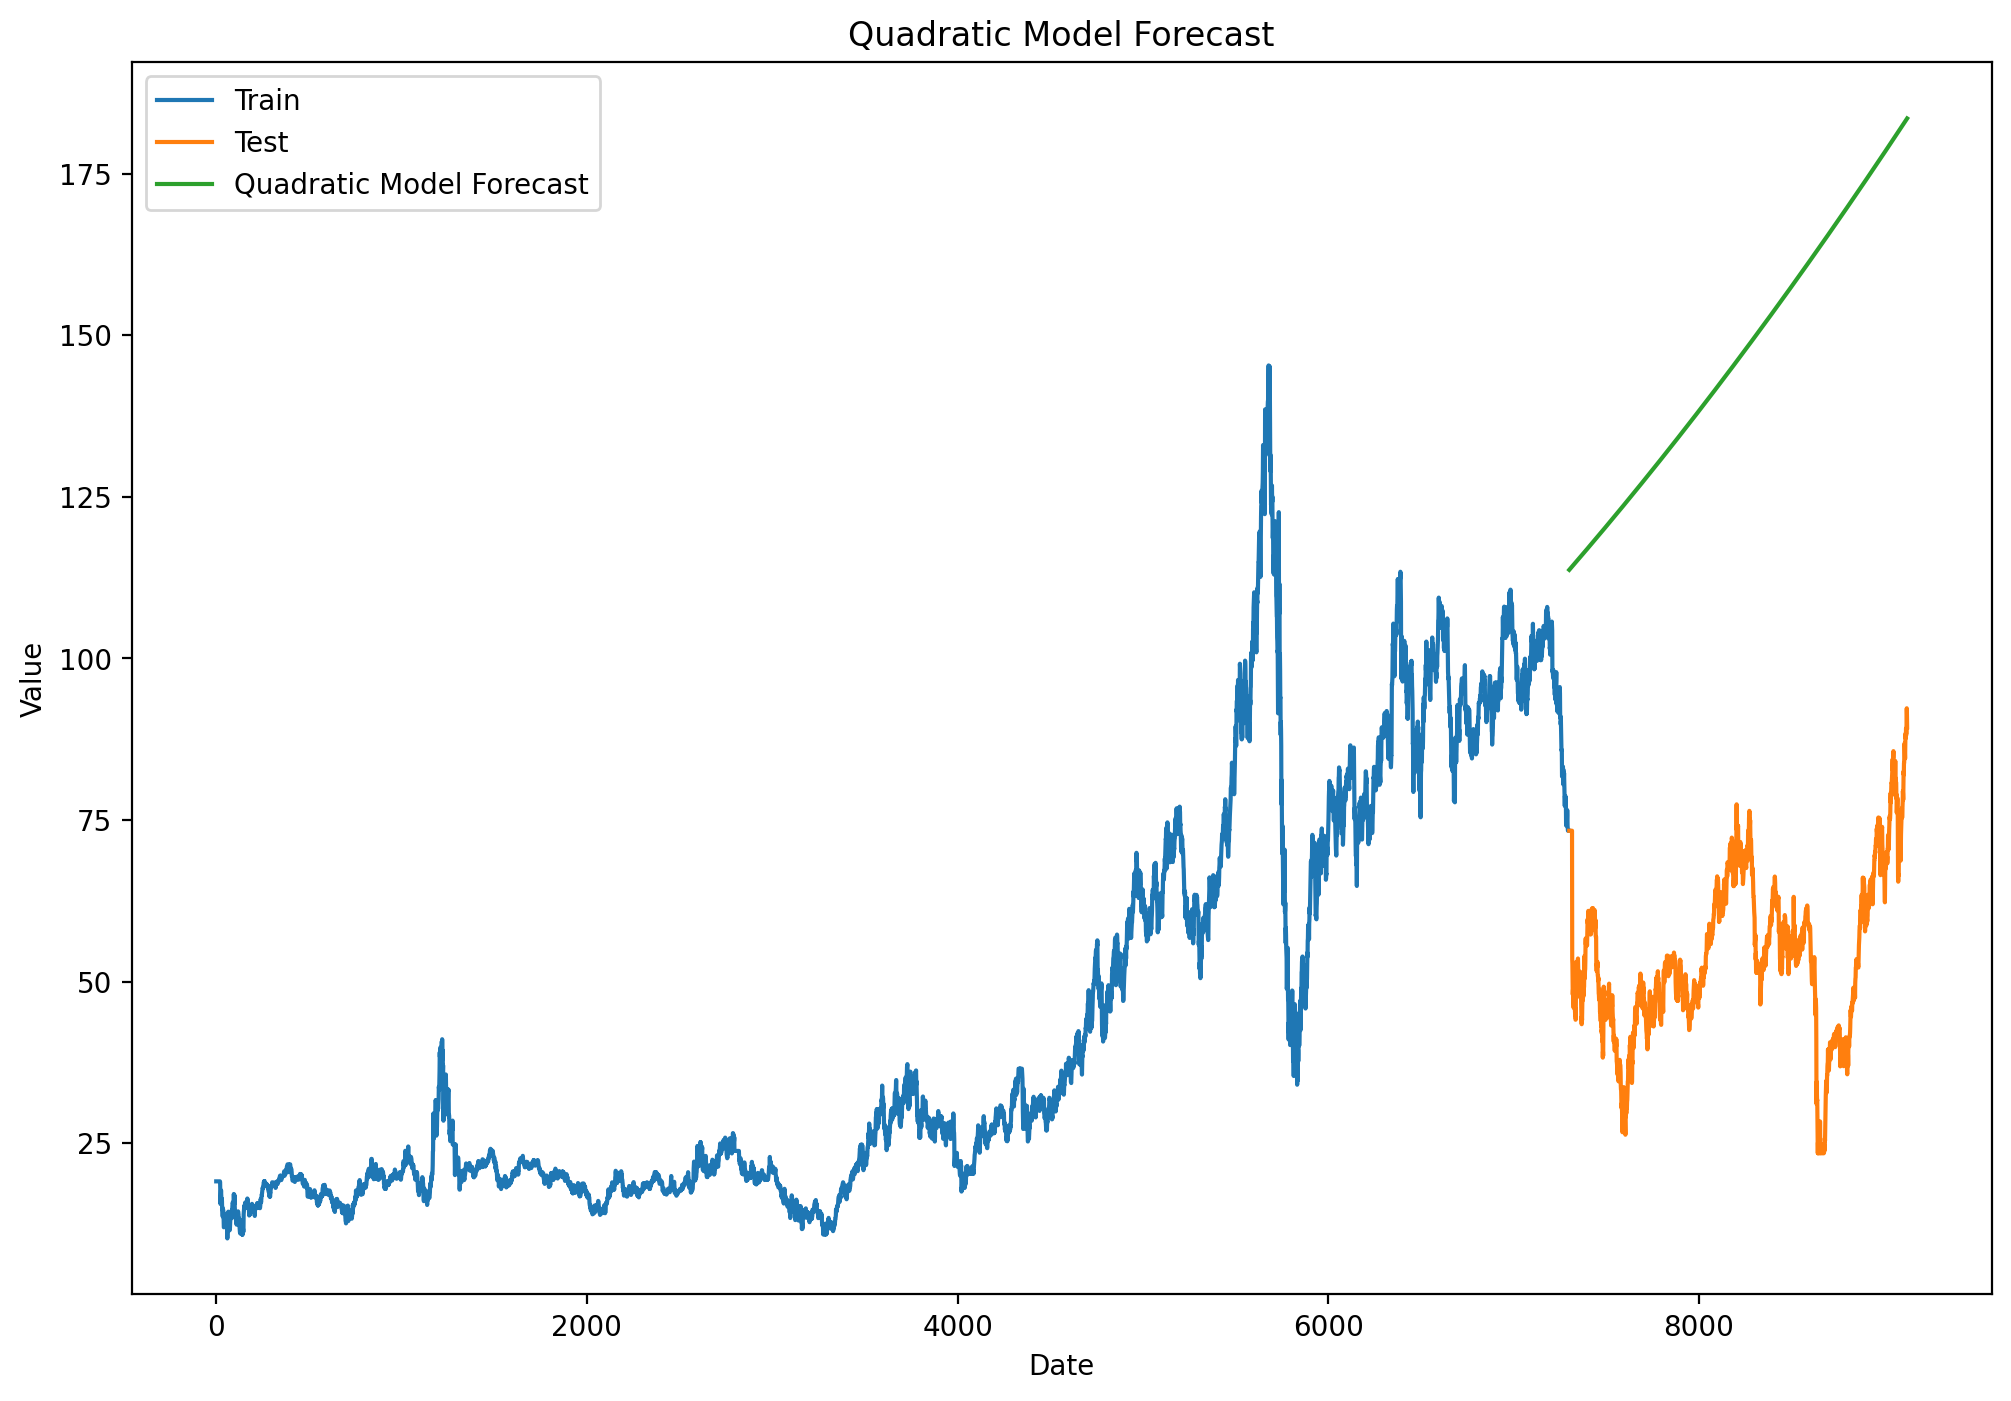

In [133]:
# Quadratic Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, x_train['Value'], label='Train')
plt.plot(x_test.index, x_test['Value'], label='Test')
plt.plot(x_test.index, pred_quad, label='Quadratic Model Forecast')
plt.legend()
plt.title('Quadratic Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Additive seasonality


In [134]:
model_add_sea = smf.ols('Value~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=x_train).fit()
pred_add_sea = pd.Series(model_add_sea.predict(x_test[['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                               'Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(x_test['Value'])-np.array(pred_add_sea))**2))
rmse_add_sea = round(rmse_add_sea,2)
print("Root Mean Square Error : ",rmse_add_sea)

Root Mean Square Error :  17.03


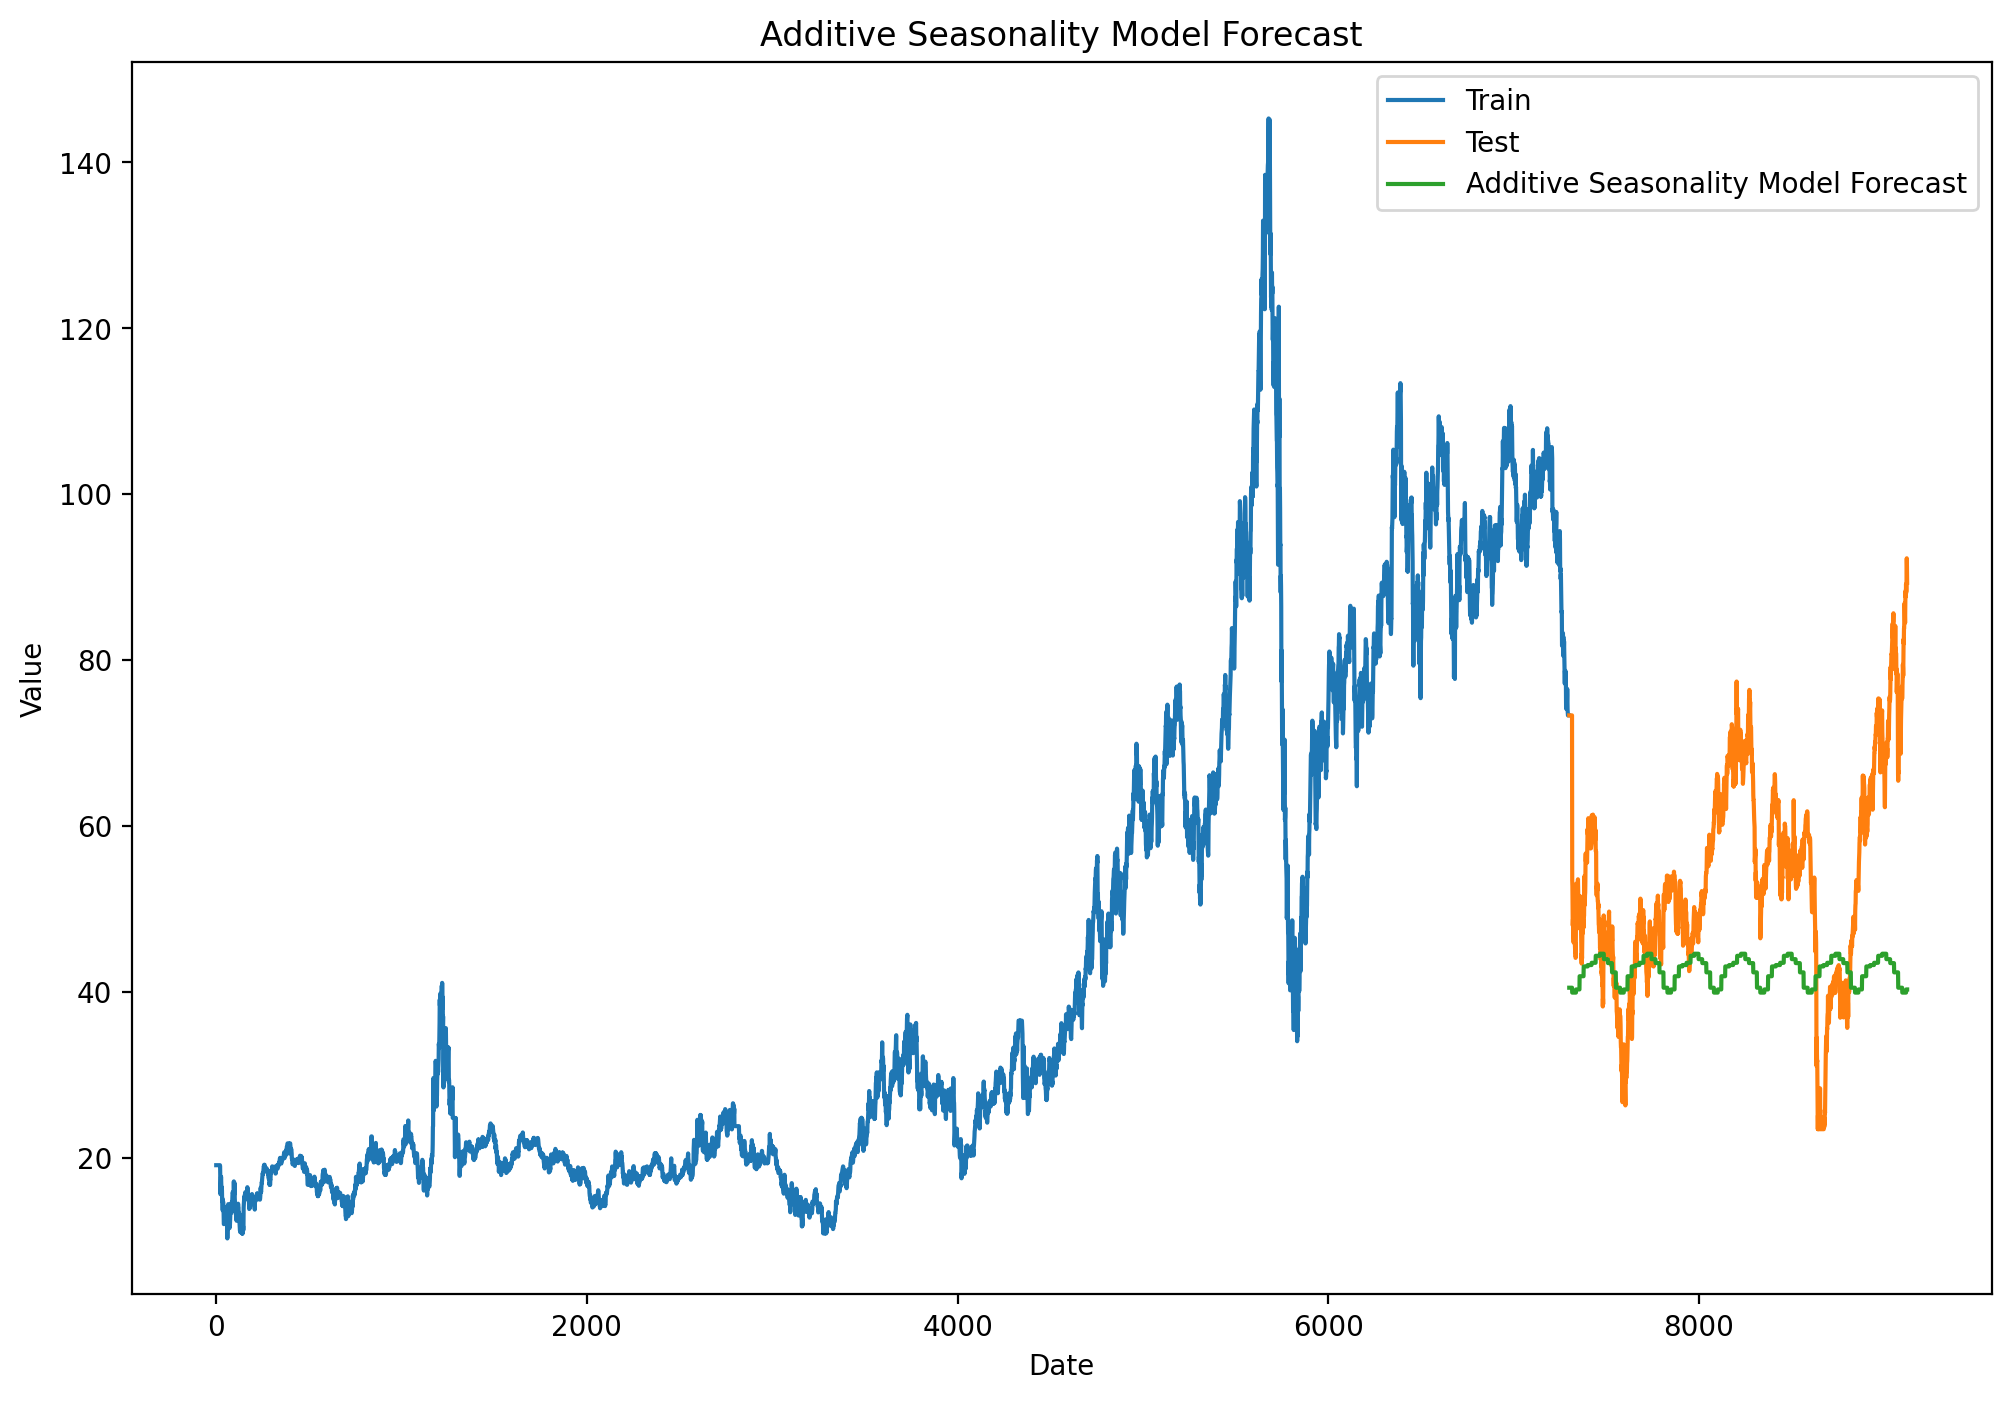

In [135]:
# Additive Seasonality Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, x_train['Value'], label='Train')
plt.plot(x_test.index, x_test['Value'], label='Test')
plt.plot(x_test.index, pred_add_sea, label='Additive Seasonality Model Forecast')
plt.legend()
plt.title('Additive Seasonality Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


## Additive Seasonality Quadratic


In [136]:
model_add_sea_quad = smf.ols('Value~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=x_train).fit()
pred_add_sea_quad = pd.Series(model_add_sea_quad.predict(x_test[['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                               'Aug','Sep','Oct','Nov','Dec','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(x_test['Value'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad = round(rmse_add_sea_quad,2)
print("Root Mean Square Error : ",rmse_add_sea_quad)

Root Mean Square Error :  95.03


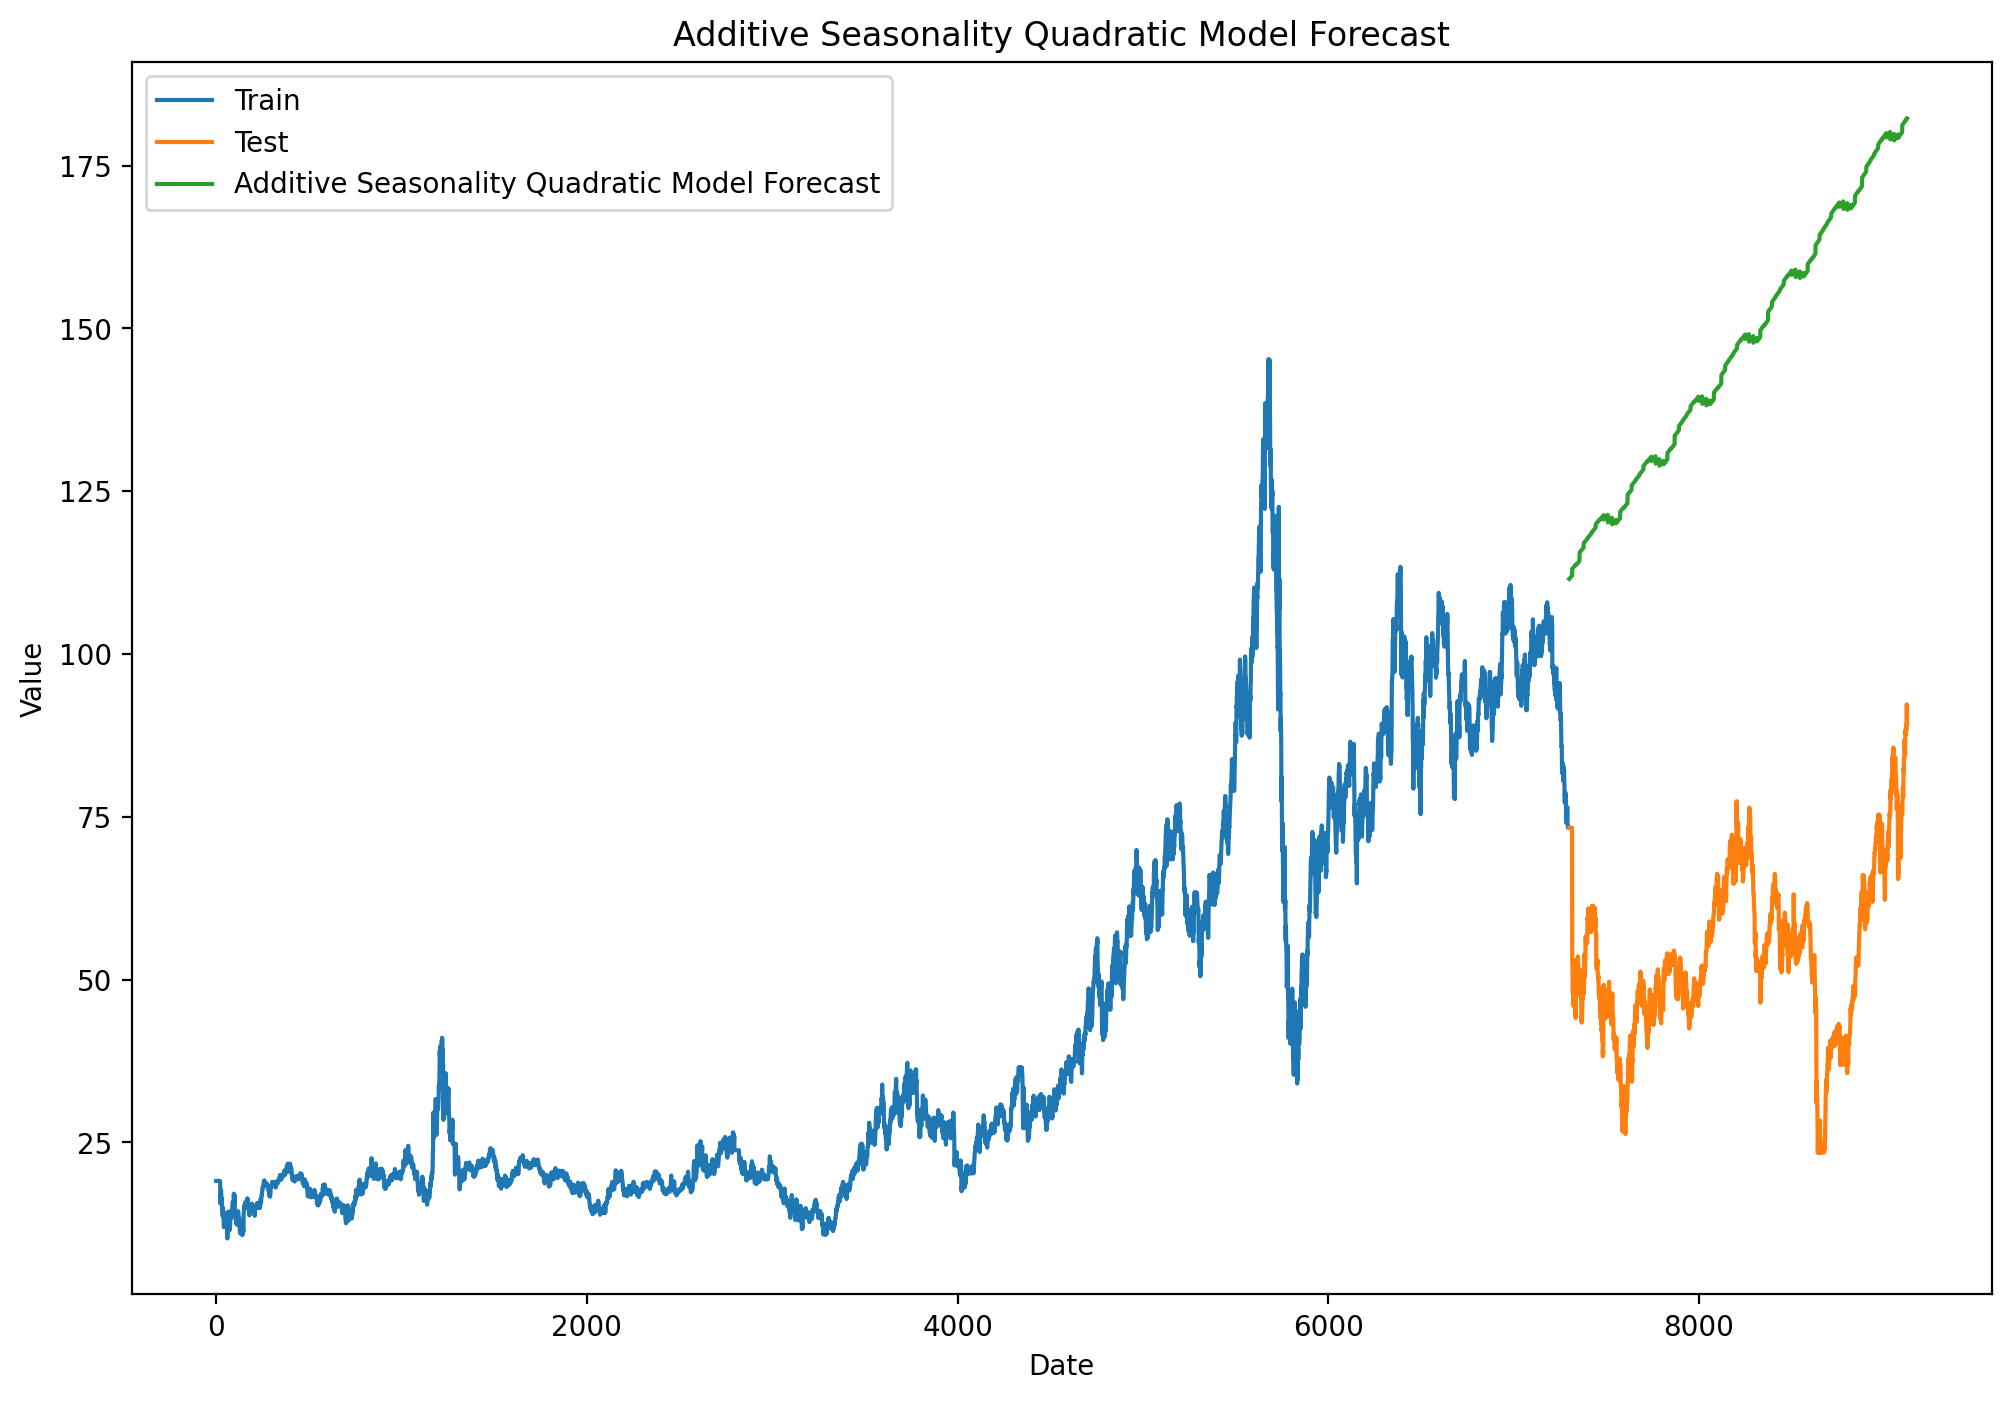

In [137]:
# Additive Seasonality Quadratic Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, x_train['Value'], label='Train')
plt.plot(x_test.index, x_test['Value'], label='Test')
plt.plot(x_test.index, pred_add_sea_quad, label='Additive Seasonality Quadratic Model Forecast')
plt.legend()
plt.title('Additive Seasonality Quadratic Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Multiplicative Seasonality


In [138]:
model_mul_sea = smf.ols('log_price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',
                  data = x_train).fit()
pred_mul_sea = pd.Series(model_mul_sea.predict(x_test))
rmse_mul_sea = np.sqrt(np.mean((np.array(x_test['Value'])-np.array(np.exp(pred_mul_sea)))**2))
rmse_mul_sea = round(rmse_mul_sea,2)
print("Root Mean Square Error : ",rmse_mul_sea)

Root Mean Square Error :  24.17


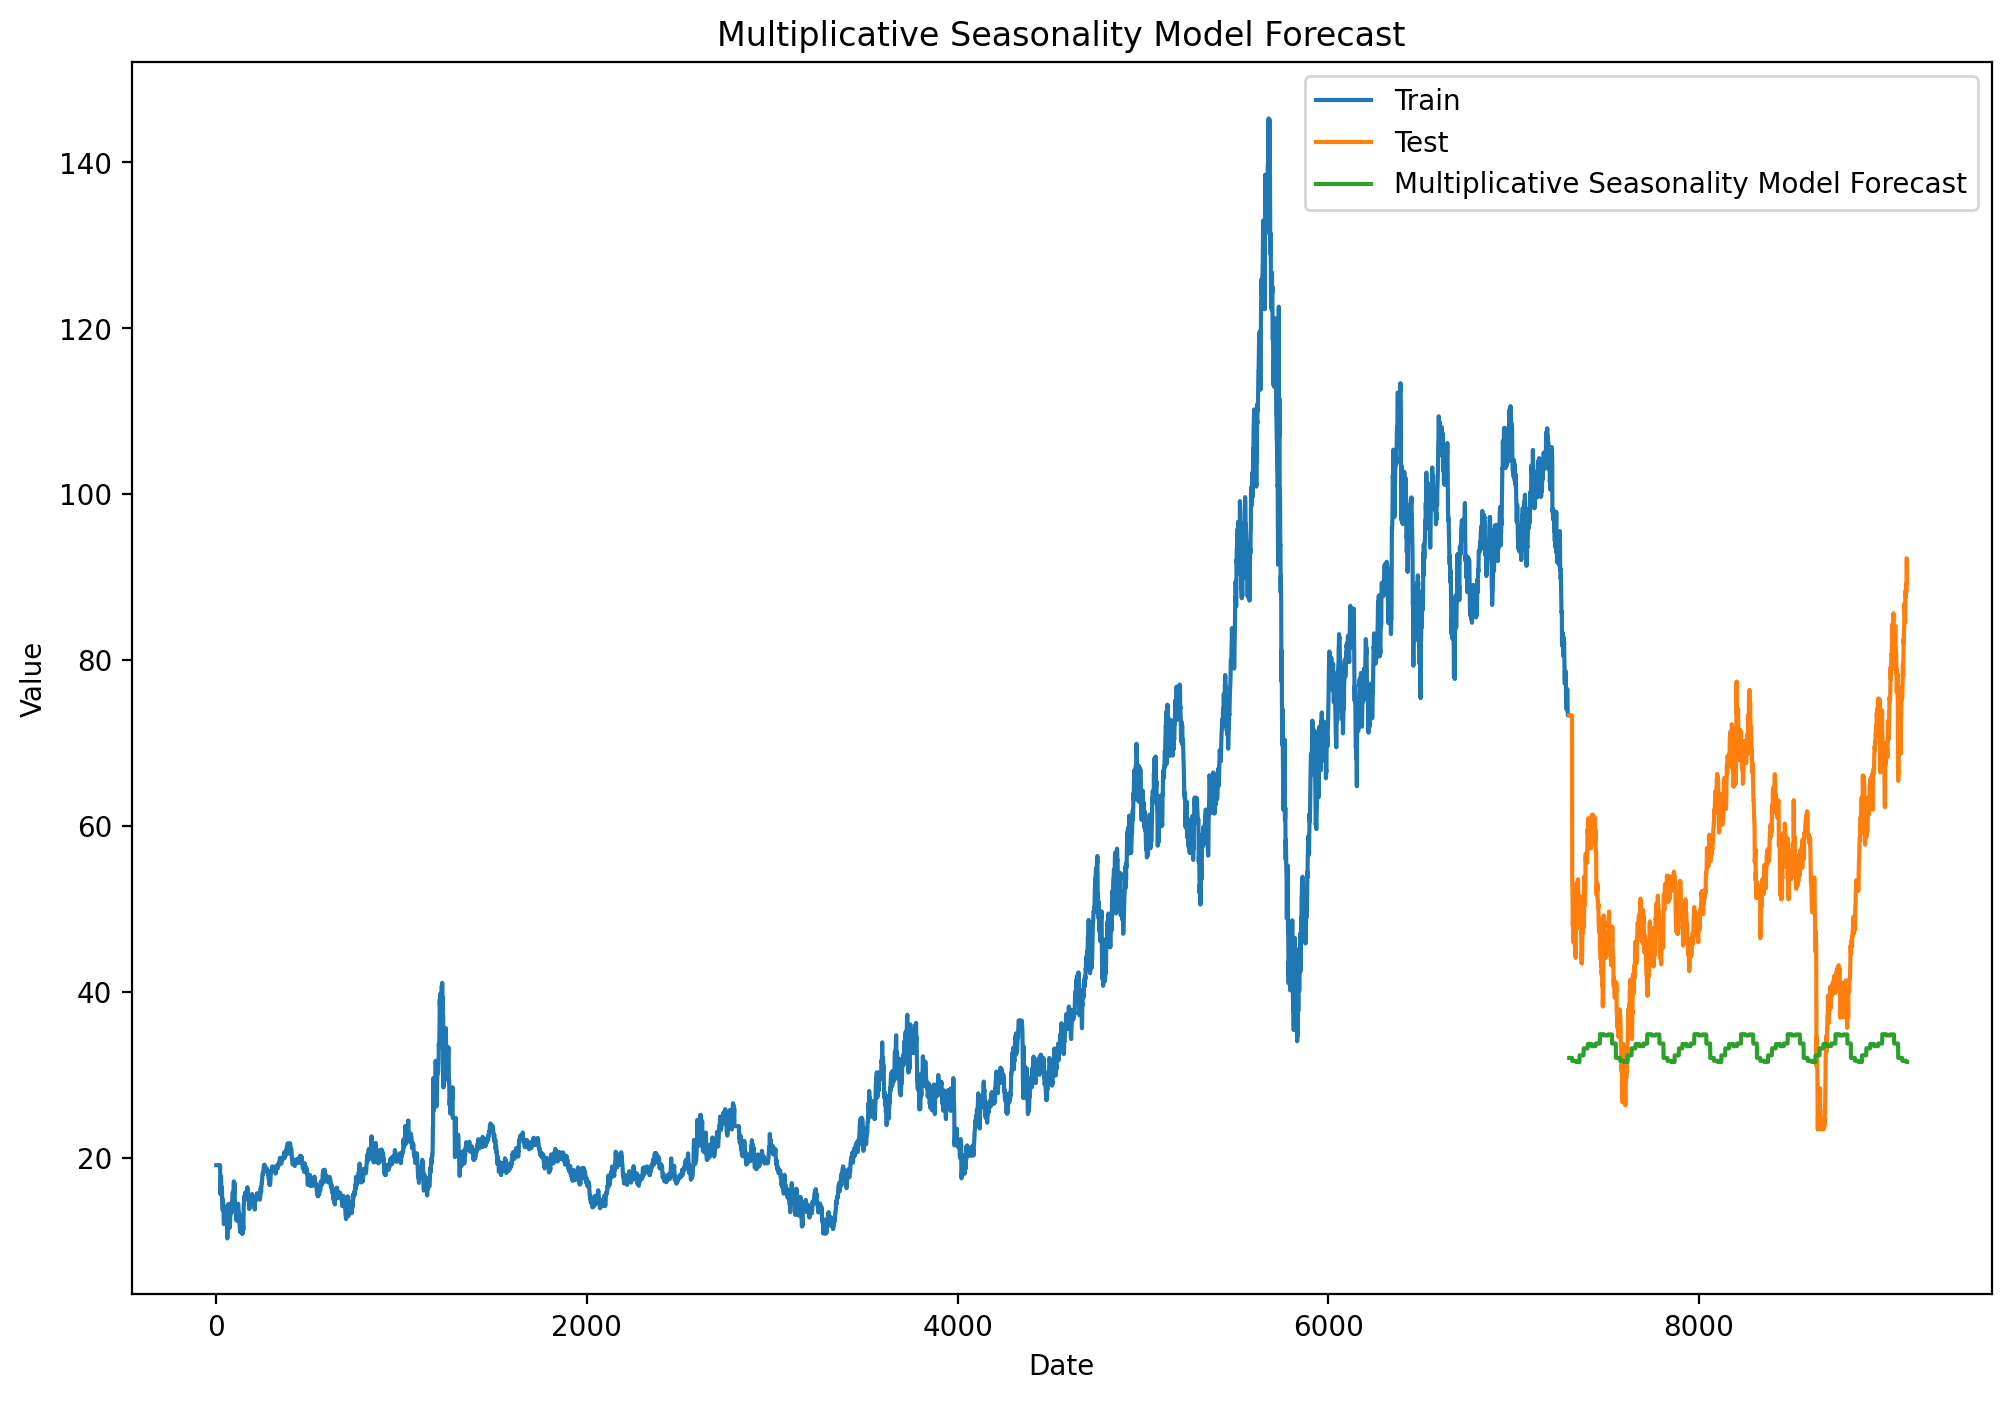

In [139]:
# Multiplicative Seasonality Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, np.exp(x_train['log_price']), label='Train')
plt.plot(x_test.index, np.exp(x_test['log_price']), label='Test')
plt.plot(x_test.index, np.exp(pred_mul_sea), label='Multiplicative Seasonality Model Forecast')
plt.legend()
plt.title('Multiplicative Seasonality Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Multiplicative Additive Seasonality


In [140]:
model_mul_add_sea = smf.ols('log_price~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = x_train).fit()
pred_mul_add_sea = pd.Series(model_mul_add_sea.predict(x_test))
rmse_mul_add_sea = np.sqrt(np.mean((np.array(x_test['Value'])-np.array(np.exp(pred_mul_add_sea)))**2))
rmse_mul_add_sea = round(rmse_mul_add_sea,2)
print("Root Mean Square Error : ",rmse_mul_add_sea)

Root Mean Square Error :  74.39


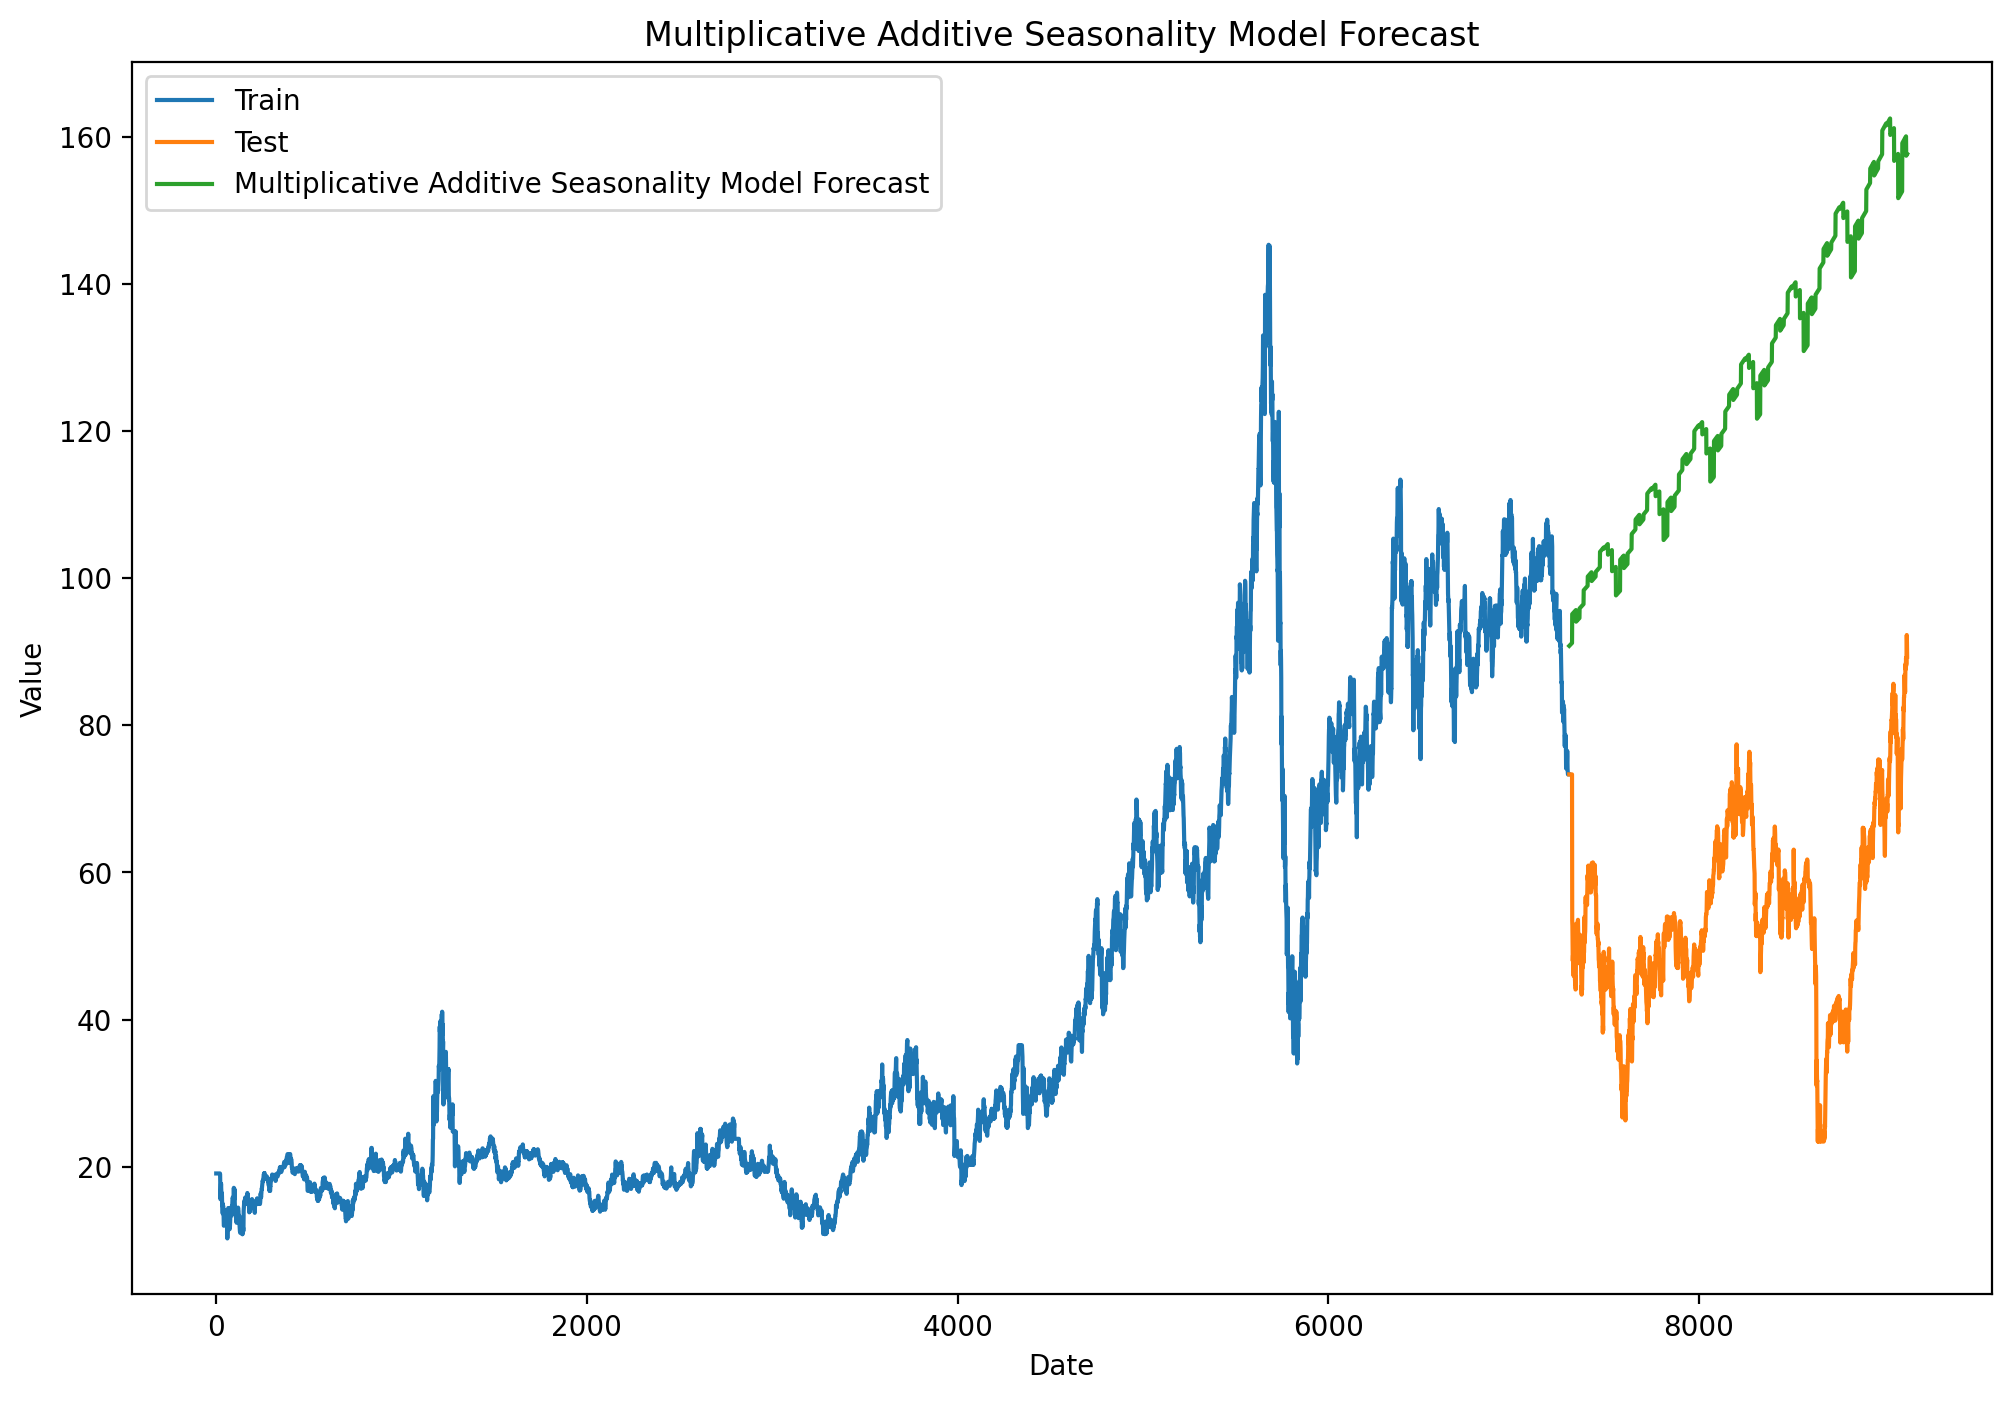

In [141]:
# Multiplicative Additive Seasonality Model
plt.figure(figsize=(12, 8))
plt.plot(x_train.index, np.exp(x_train['log_price']), label='Train')
plt.plot(x_test.index, np.exp(x_test['log_price']), label='Test')
plt.plot(x_test.index, np.exp(pred_mul_add_sea), label='Multiplicative Additive Seasonality Model Forecast')
plt.legend()
plt.title('Multiplicative Additive Seasonality Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [142]:
from prophet import Prophet
# Prepare the data for Prophet
df_prophet = df1.reset_index()[['Date', 'Value']]
df_prophet.columns = ['ds', 'y']

# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.75)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

# Create and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_data)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test_data))
forecast = model_prophet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_oshp3v/o1z7f0q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_oshp3v/t6kqro5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37878', 'data', 'file=/tmp/tmpz_oshp3v/o1z7f0q6.json', 'init=/tmp/tmpz_oshp3v/t6kqro5t.json', 'output', 'file=/tmp/tmpz_oshp3v/prophet_modelu23xme05/prophet_model-20230620035243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [143]:
# Extract the predicted values for the test set
predictions = forecast['yhat'][train_size:]

In [144]:
# Evaluate the model
mse_prophet = mean_squared_error(test_data['y'], predictions)
rmse_prophet = np.sqrt(mse_prophet)
print('Root Mean Squared Error (Prophet):', rmse_prophet)

Root Mean Squared Error (Prophet): 46.026252987385


In [145]:
# Extract the predicted values

predicted = forecast['yhat']
actual = df_prophet['y']

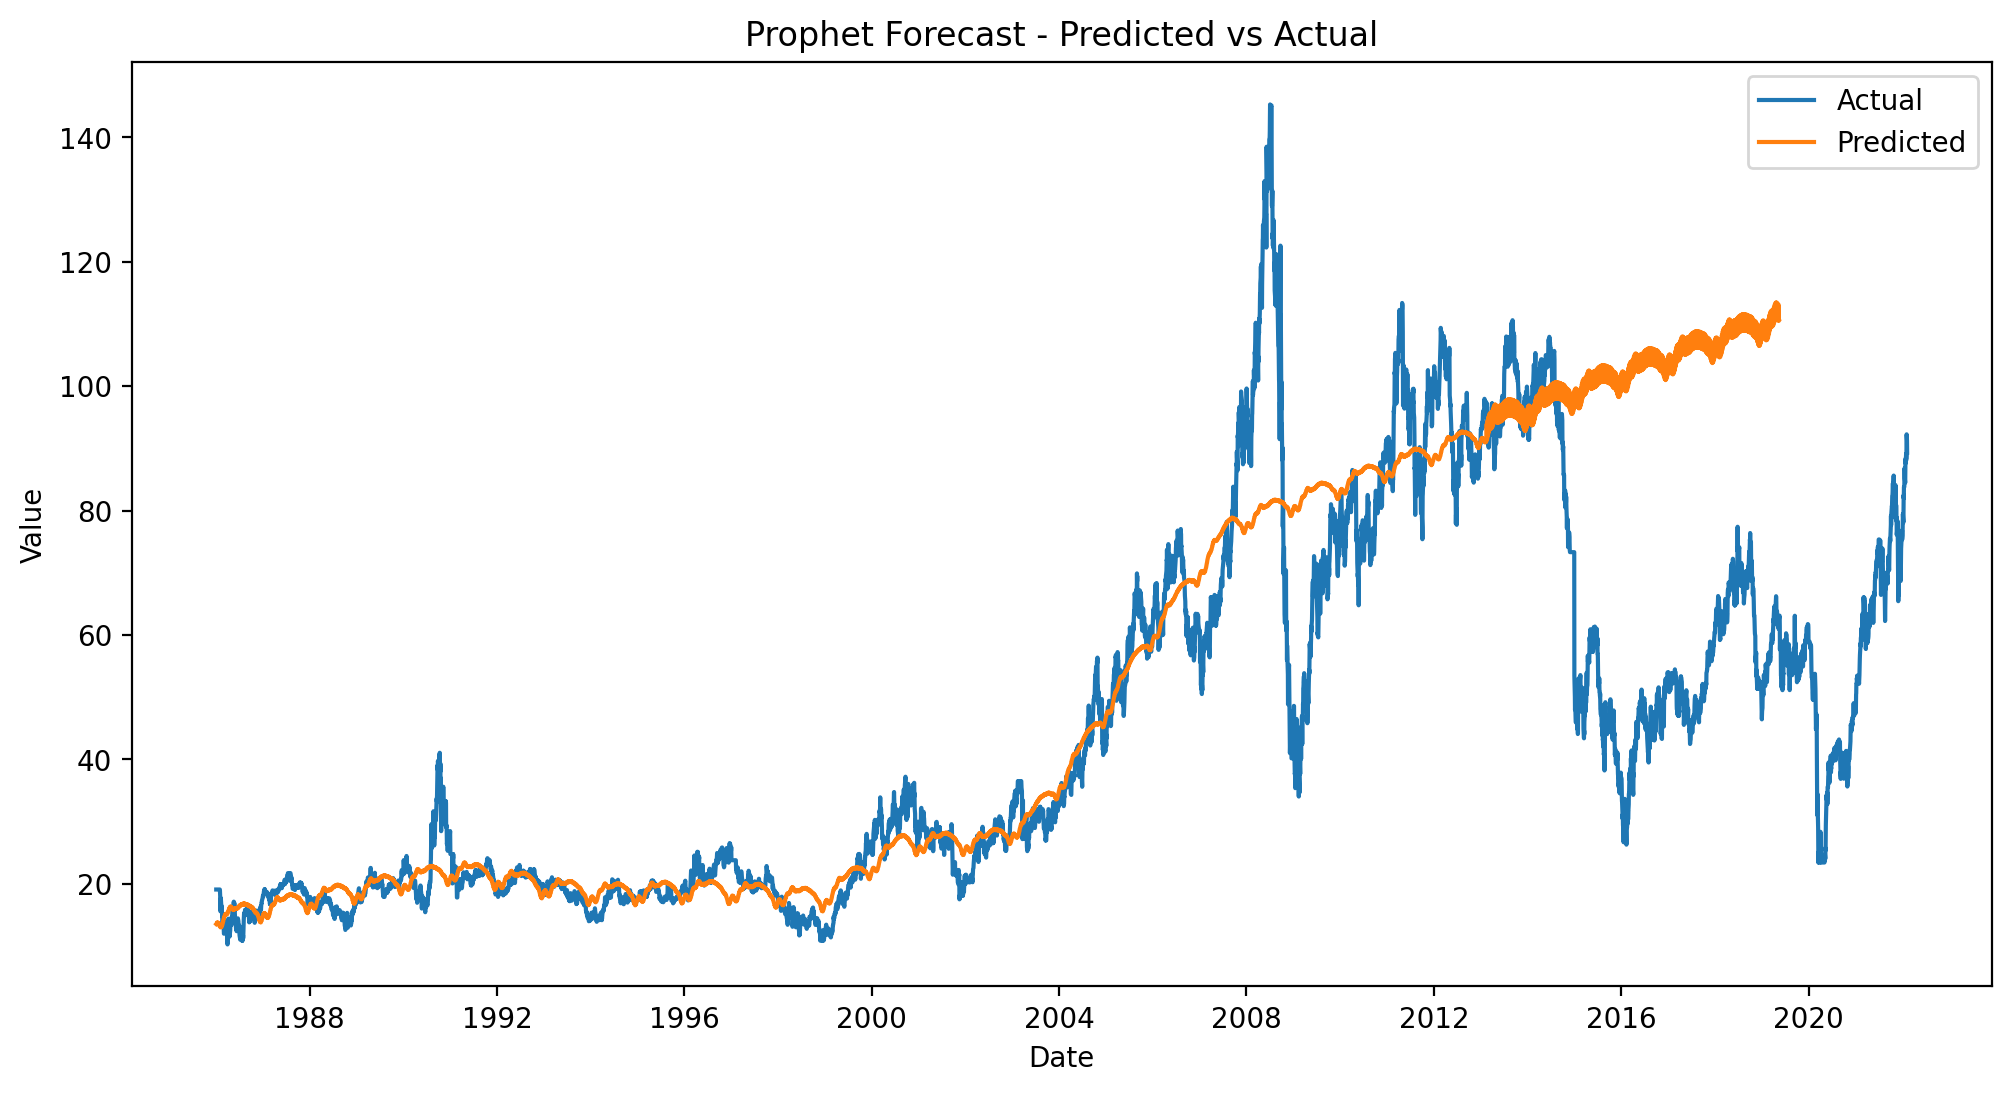

In [146]:
# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], actual, label='Actual')
plt.plot(forecast['ds'], predicted, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast - Predicted vs Actual')
plt.legend()
plt.show()

## **Comparing the results**

In [149]:
model_list                = ["Linear","Exponential","Quadratic","Additive Seasonality",
                             "Additive Seasonality Quadratic","Multiplicative Seasonality",
                             "Multiplicative Additive Seasonality","Prophet"]
rmse_val_list             = [rmse_lin,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mul_sea,
                                 rmse_mul_add_sea,rmse_prophet]

table_rmse                = pd.DataFrame(columns=['Model','RMSE_Values'])
table_rmse['Model']       = model_list
table_rmse['RMSE_Values'] = rmse_val_list

table_rmse

Model  RMSE_Values
0                               Linear    46.220000
1                          Exponential   123.570000
2                            Quadratic    95.100000
3                 Additive Seasonality    17.030000
4       Additive Seasonality Quadratic    95.030000
5           Multiplicative Seasonality    24.170000
6  Multiplicative Additive Seasonality    74.390000
7                              Prophet    46.026253

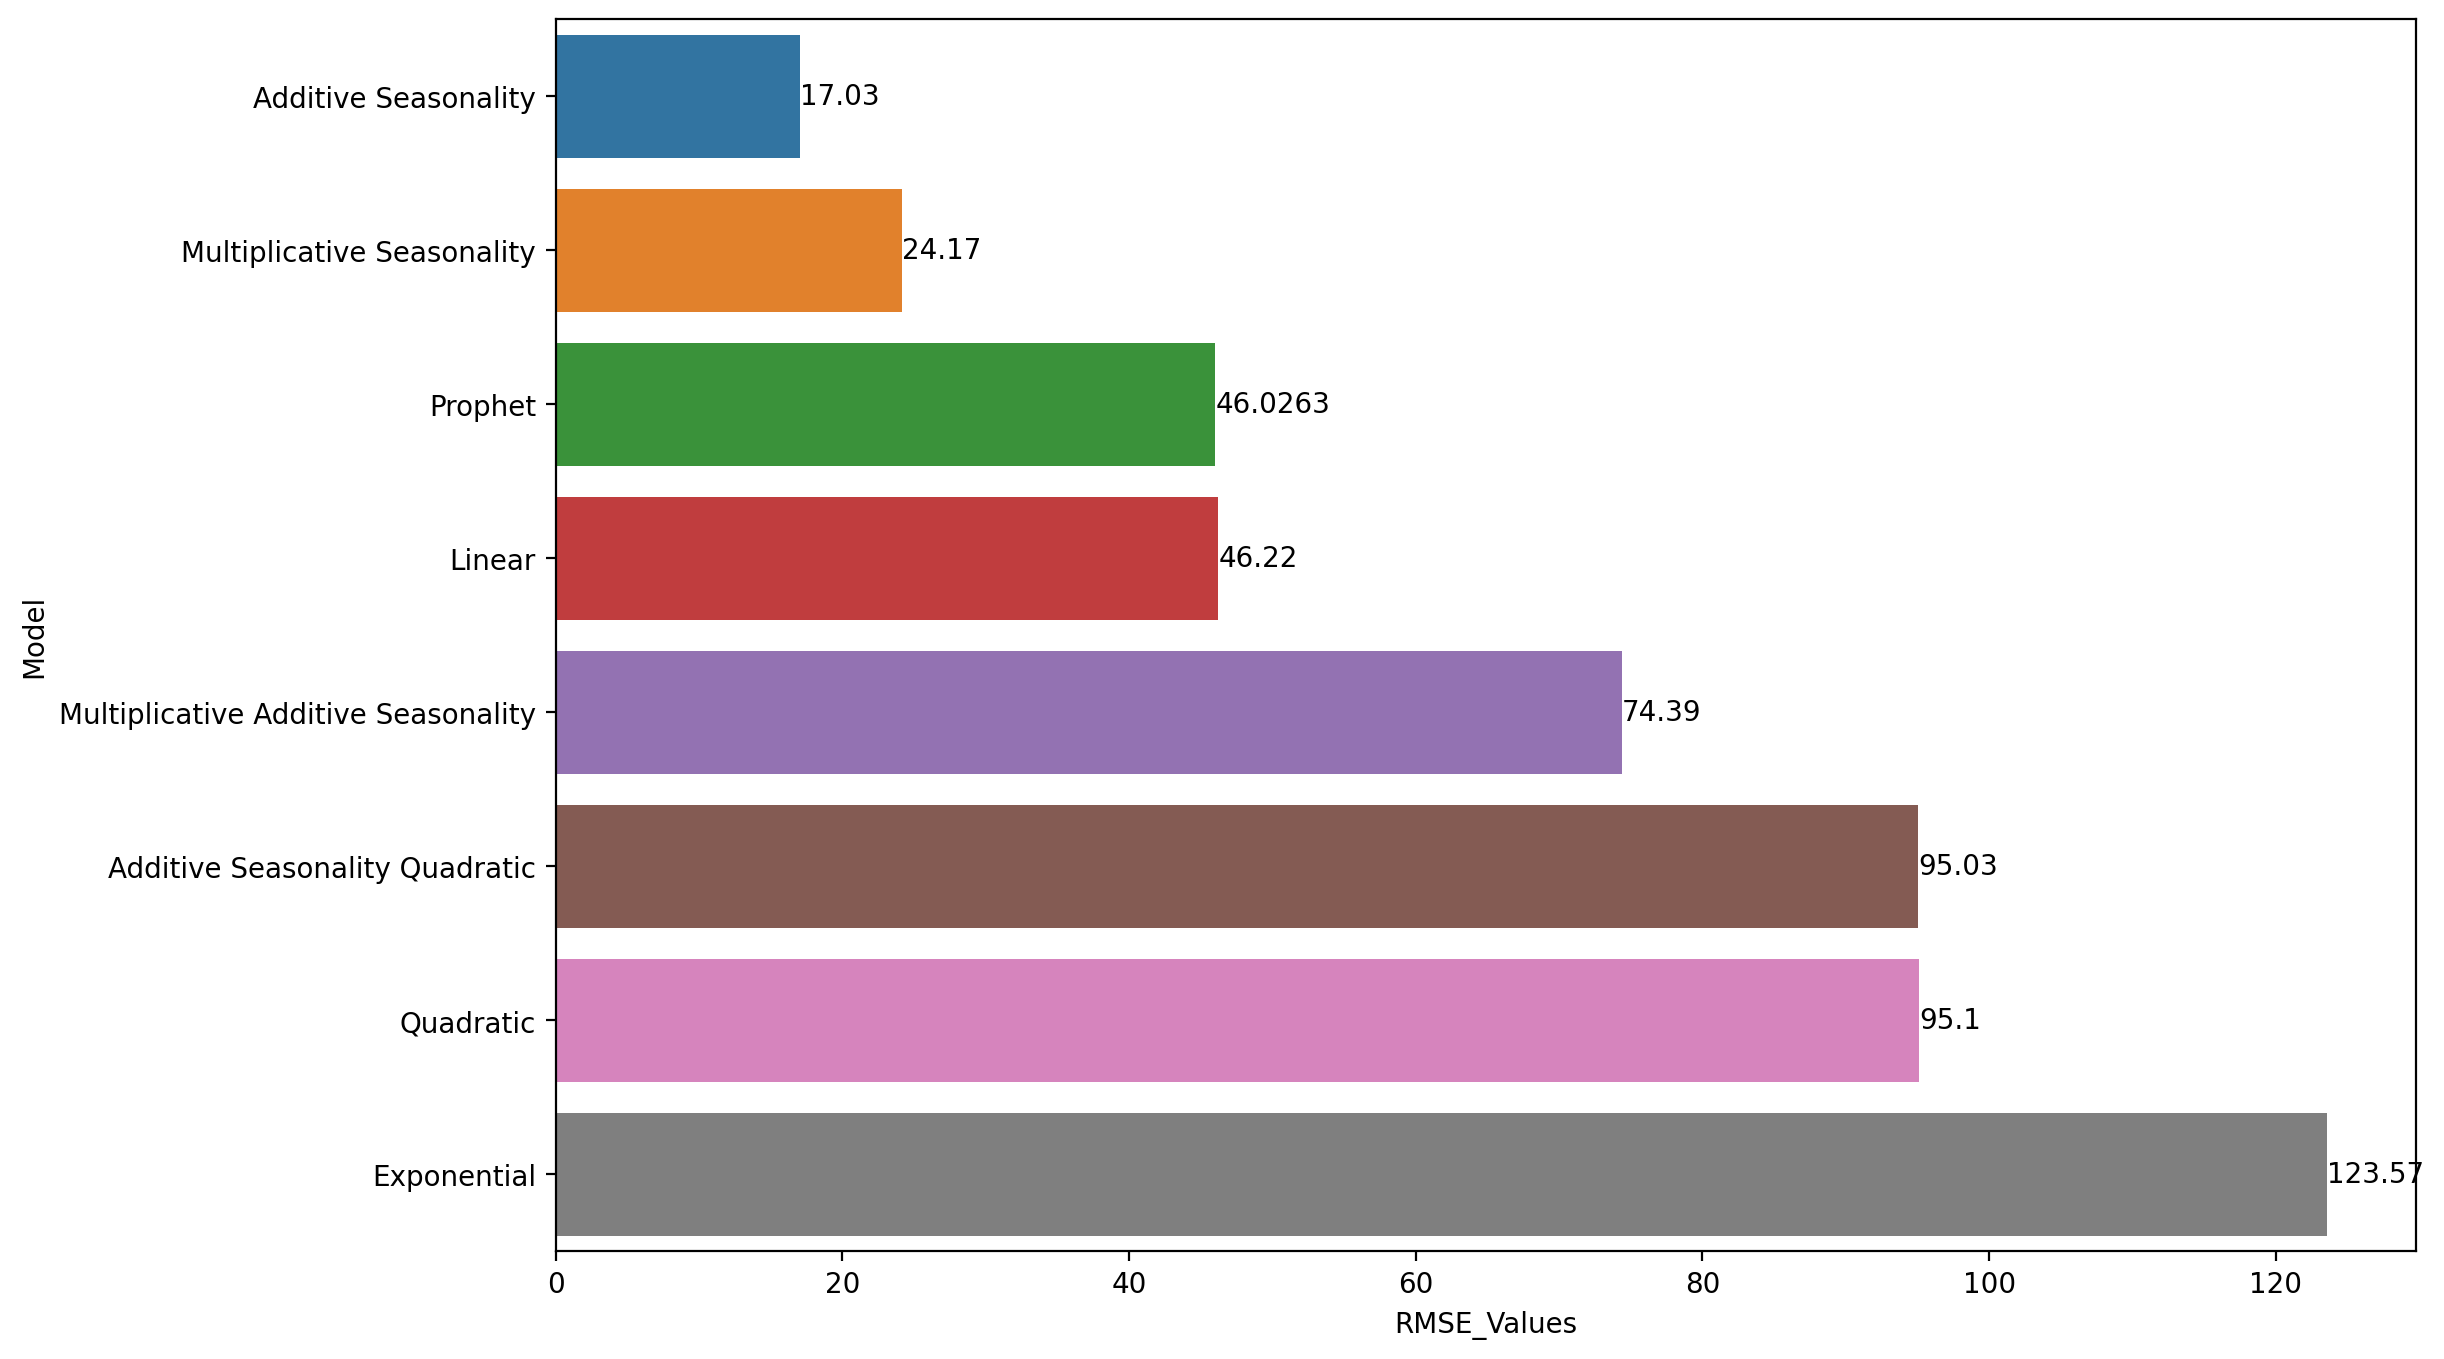

In [150]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x='RMSE_Values',y='Model',data=table_rmse,order=table_rmse.sort_values('RMSE_Values').Model)
for i in ax.containers:
    ax.bar_label(i)

#**Out of all the models, LSTM gave the lowest error. Hence use this model for forecasting.**

In [151]:
import pickle
filename = 'Forcast_LSTM.pkl'
pickle.dump(model_lstm, open(filename,'wb'))
model=pickle.load(open('Forcast_LSTM.pkl','rb'))
